# Analyzing Text Entries for User Expertise

- Analysis of amazon product reviews - more specifically electronics data.

Data source => "http://jmcauley.ucsd.edu/data/amazon/"

where

- reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- asin - ID of the product, e.g. 0000013714
- reviewerName - name of the reviewer
- helpful - helpfulness rating of the review, e.g. 2/3
- reviewText - text of the review
- overall - rating of the product
- summary - summary of the review
- unixReviewTime - time of the review (unix time)
- reviewTime - time of the review (raw)

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\Akanksha\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
import pandas as pd
import gzip

"""def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Electronics_5.json.gz')"""

"def parse(path):\n  g = gzip.open(path, 'rb')\n  for l in g:\n    yield eval(l)\n\ndef getDF(path):\n  i = 0\n  df = {}\n  for d in parse(path):\n    df[i] = d\n    i += 1\n  return pd.DataFrame.from_dict(df, orient='index')\n\ndf = getDF('reviews_Electronics_5.json.gz')"

In [3]:
#saving AvgwordtoVec
"""with open('electronics_df.pickle', 'wb') as f:
    pickle.dump(df, f)"""

"with open('electronics_df.pickle', 'wb') as f:\n    pickle.dump(df, f)"

In [4]:
#Retrieving AvgwordtoVec
with open('electronics_df.pickle', 'rb') as f:
    df = pickle.load(f)

In [5]:
df.head()

reviewerID        asin              reviewerName   helpful  \
0   AO94DHGC771SJ  0528881469                   amazdnu    [0, 0]   
1   AMO214LNFCEI4  0528881469           Amazon Customer  [12, 15]   
2  A3N7T0DY83Y4IG  0528881469             C. A. Freeman  [43, 45]   
3  A1H8PY3QHMQQA0  0528881469  Dave M. Shaw "mack dave"   [9, 10]   
4  A24EV6RXELQZ63  0528881469               Wayne Smith    [0, 0]   

                                          reviewText  overall  \
0  We got this GPS for my husband who is an (OTR)...      5.0   
1  I'm a professional OTR truck driver, and I bou...      1.0   
2  Well, what can I say.  I've had this unit in m...      3.0   
3  Not going to write a long review, even thought...      2.0   
4  I've had mine for a year and here's what we go...      1.0   

                                  summary  unixReviewTime   reviewTime  
0                         Gotta have GPS!      1370131200   06 2, 2013  
1                       Very Disappointed      1290643200  11 25, 2010  
2                          1st impression      1283990400   09 9, 2010  
3                 Great grafics, POOR GPS      1290556800  11 24, 2010  
4  Major issues, only excuses for support      1317254400  09 29, 2011

In [6]:
df.shape

(1689188, 9)

In [7]:
df.count()

reviewerID        1689188
asin              1689188
reviewerName      1664458
helpful           1689188
reviewText        1689188
overall           1689188
summary           1689188
unixReviewTime    1689188
reviewTime        1689188
dtype: int64

In [8]:
df['asin'].value_counts()

B007WTAJTO    4915
B003ES5ZUU    4143
B00DR0PDNE    3798
B0019EHU8G    3435
B002WE6D44    2813
B003ELYQGG    2652
B0002L5R78    2599
B009SYZ8OC    2542
B00BGGDVOO    2104
B002V88HFE    2082
B0074BW614    2069
B000LRMS66    1960
B006GWO5WK    1917
B000QUUFRW    1890
B005FYNSPK    1884
B005HMKKH4    1866
B0041Q38NU    1812
B00622AG6S    1710
B004QK7HI8    1581
B005DKZTMG    1564
B000VX6XL6    1556
B001XURP7W    1485
B004XC6GJ0    1456
B004G6002M    1424
B0052SCU8U    1419
B000S5Q9CA    1393
B000BQ7GW8    1388
B002MAPRYU    1374
B005CT56F8    1365
B006W8U2MU    1339
              ... 
B008P96YDA       5
B007E612LO       5
B000R22X1A       5
B00D6K2AEU       5
B004G7D0IW       5
B000AAZRIU       5
B0047LWREA       5
B000EI7SBC       5
B000A4446W       5
B002I32RE4       5
B006JSME9M       5
B001AXWR7A       5
B00264GKX4       5
B00659KR76       5
B007MX6B3I       5
B000JFGAUU       5
B002HG9LUK       5
B004JZL07O       5
B004LWO3Y2       5
B00D6NKOK4       5
B003Y5UX8W       5
B004GUT470  

"B007WTAJTO" => https://www.amazon.com/dp/B007WTAJTO
SanDisk Ultra 64GB MicroSDXC Class 10 UHS Memory Card Speed Up To 30MB/s With Adapter - SDSDQUA-064G-U46A

In [9]:
#df_sandisk=df[df.asin == 'B007WTAJTO' ]

In [10]:
#saving AvgwordtoVec
"""import pickle
with open('sandisk_df.pickle', 'wb') as f:
    pickle.dump(df_sandisk, f)"""

"import pickle\nwith open('sandisk_df.pickle', 'wb') as f:\n    pickle.dump(df_sandisk, f)"

In [11]:
#Retrieving AvgwordtoVec
with open('sandisk_df.pickle', 'rb') as f:
    df_sandisk = pickle.load(f)

In [12]:
df_sandisk.head()

reviewerID        asin  reviewerName helpful  \
1336614  A3SBTW3WS4IQSN  B007WTAJTO           NaN  [0, 0]   
1336615  A18K1ODH1I2MVB  B007WTAJTO          0mie  [0, 0]   
1336616  A2FII3I2MBMUIA  B007WTAJTO           1K3  [0, 0]   
1336617   A3H99DFEG68SR  B007WTAJTO           1m2  [0, 0]   
1336618  A375ZM4U047O79  B007WTAJTO  2&amp;1/2Men  [0, 0]   

                                                reviewText  overall  \
1336614                                         No issues.      4.0   
1336615  Purchased this for my device, it worked as adv...      5.0   
1336616  it works as expected. I should have sprung for...      4.0   
1336617  This think has worked out great.Had a diff. br...      5.0   
1336618  Bought it with Retail Packaging, arrived legit...      5.0   

                                        summary  unixReviewTime   reviewTime  
1336614                              Four Stars      1406073600  07 23, 2014  
1336615                           MOAR SPACE!!!      1382659200  10 25, 2013  
1336616               nothing to really say....      1356220800  12 23, 2012  
1336617  Great buy at this price!!!  *** UPDATE      1384992000  11 21, 2013  
1336618                        best deal around      1373673600  07 13, 2013

In [13]:
df_sandisk["reviewerID"].value_counts()

A2F8E1X2K7AUBX    1
AFXVFAG9AZ6NE     1
A399FFIZ68MS9N    1
A2Y190LXVWFSE9    1
A2J06QNGAXV2FC    1
A12N91QD1JLZPP    1
A3GPD3LRS8J7HC    1
ADQPFP62FHE8A     1
AR4BI5NBQULFW     1
A37NC7ASD6ZRKZ    1
A1QI6PI0HH4H0P    1
A221HTD29MIAKU    1
A1W4G8B9BAWR1O    1
A3FUWE5AQQ8AY3    1
A1SL5FHOMDDY15    1
ABFBFXOBHGAGJ     1
A2ZK1TTLG9BKBD    1
ADQXVKPS5CFK5     1
A3PHEC426SCQW9    1
A2XXGAVPSRBTGZ    1
A18G0NBO5FVPMZ    1
A243GSGE76TSZH    1
A3SP6JK7T0A9OV    1
A2T72XIHH24DXX    1
A2R4QMOCRL2F1O    1
A3A4NX6KSX3Q8F    1
A369PNLGF8M7OE    1
A3T9OP3YR1NZCS    1
A3D2XMRV8DSK3J    1
A1IIFU05LM2VK8    1
                 ..
A18TUDLH3X67D0    1
AUMT0X8K4M296     1
A45FCW6VF7J1S     1
A1YJDIN8Q4GZ6O    1
A2P968W8VUDI84    1
A1TAO7RR96YTOG    1
A2D33RR6H8MBIX    1
A3REDY0BEQH12D    1
A1UJA50HEURMF9    1
AG4Z43EQZT8T7     1
A3MEPYZVTAV90W    1
A3HE7R6W5B4XKX    1
A35XRT4BW4I6UD    1
A2TZXYPRH8R5JZ    1
A38LP0I95P0977    1
A2KBYEPODBMC2J    1
A330A00QHZZEW6    1
A2A1EKNXT0EQRY    1
A24FCW5FHB7EAC    1


# Hence No Duplicates and as said in the website "De duplication has been done"

In [14]:
df_sandisk[df_sandisk.astype(str).sum(axis=1).str.contains("class") == 1]

reviewerID        asin                           reviewerName  \
1336629  A29RI184HRX66H  B007WTAJTO                          Aaron "Aaron"   
1336640  A1U9QJQW3XPRL2  B007WTAJTO                         Aaron T. Swain   
1336660   AGX2K0FMS0IVL  B007WTAJTO                            AC500Driver   
1336681  A1OM05JSG2J1KB  B007WTAJTO                                 adavey   
1336689  A2KJY8F5O1U5D6  B007WTAJTO                              A. Felson   
1336703  A1JOXGZH55JMHW  B007WTAJTO                              A. Hejazi   
1336707   A837QPVOZ9YAD  B007WTAJTO                                Airedad   
1336708  A1PKJZRYCZFIGJ  B007WTAJTO                                  ajb03   
1336711  A20MEC7JYD5U11  B007WTAJTO                 A.J.O. From California   
1336714  A2CHQH95XQUY4E  B007WTAJTO                                 ak2012   
1336733   ATE41IMLCAC2H  B007WTAJTO                            Al Campbell   
1336737  A1UM44ILLZCEI1  B007WTAJTO                 Aleksandar Milivojevic   
1336754  A1OKTNPURCNYKX  B007WTAJTO                                    A.L   
1336768  A3LBEV0UWH9V2G  B007WTAJTO                                  Allen   
1336794   A3ACC82B33MGX  B007WTAJTO   Amazon Customer "ElectricalEngineer"   
1336814  A2XKRQ2IM5XS9A  B007WTAJTO                        Amazon Customer   
1336817  A26EB0MDHMDD5U  B007WTAJTO                        Amazon Customer   
1336856  A20ZOIIWZU6G6H  B007WTAJTO                        Amazon Customer   
1336865  A3DXCQV1U6QLTS  B007WTAJTO                        Amazon Customer   
1336883  A2Z2ANFDUJBB9R  B007WTAJTO                        Amazon Customer   
1336886   AK3D1F2TEULT0  B007WTAJTO                        Amazon Customer   
1336892  A149EPYL6YG1EI  B007WTAJTO                        Amazon Customer   
1336899   ABFBA039H3S1Z  B007WTAJTO                        Amazon Customer   
1336921  A3KZUJLA2X2LLC  B007WTAJTO                        Amazon Customer   
1336973   ACDHXI72HS6AR  B007WTAJTO                            Amazon User   
1336989  A1SGIBL61P776R  B007WTAJTO                                ANDR D.   
1337032  A361M14PU2GUEG  B007WTAJTO           Angry Ryan "Ryan A. Forrest"   
1337050   AWATUDXT8A7TA  B007WTAJTO                          Anthony Nonya   
1337082  A22W6XTBU8S6XA  B007WTAJTO                                 ART005   
1337083  A2EF13B4GOOVRR  B007WTAJTO                          ART D "ART D"   
...                 ...         ...                                    ...   
1341084  A2VJ5ALN1BIV3B  B007WTAJTO                      terster "Terster"   
1341096   AXOKMY2J7E2LY  B007WTAJTO                            tgreenwaldt   
1341097   A8IMDXXLZVN5M  B007WTAJTO             ThaCooLoser "CooLoserTech"   
1341116   AK6AKMA3147X0  B007WTAJTO                             The Lor **   
1341126  A17INQNCZ1HMHL  B007WTAJTO                             TheSnowman   
1341134  A2NI78TLCLF7Z2  B007WTAJTO                                 Thomas   
1341136  A3S1OWJEYYW8QY  B007WTAJTO         Thomas King "internet shopper"   
1341157   AAEVGE52KL0DJ  B007WTAJTO                                    Tim   
1341197  A3VZH0PWLQ9BB1  B007WTAJTO                                 Tom B.   
1341198  A1C00XXCYWEKK1  B007WTAJTO                                  Tombo   
1341210  A1WTQUOQ4WG9AI  B007WTAJTO            Tom Henriksen "Doggy Diner"   
1341215   AOSMOGUP5XN7V  B007WTAJTO          Tommy Dee "EnglishmanHi Tech"   
1341232  A2N2PJLAVS6TSJ  B007WTAJTO                                 Tony Z   
1341261  A3UBFIZWLK674O  B007WTAJTO                              Trip "SC"   
1341262   ABMF4UC4Z00NT  B007WTAJTO                                 trlamb   
1341273   ABAPF3XY1W6JX  B007WTAJTO                          TucsonShopper   
1341296   A4K1YGL2AXS9F  B007WTAJTO                                  Tyson   
1341315  A280KHZO2L7GKA  B007WTAJTO                                 V. Aub   
1341316   AIVU1J51MJ9O2  B007WTAJTO               Vaughn "The answer man!"   
1341333  A3KF3RWPANR3FI  B007WTAJTO

In [15]:
df_sandisk.shape

(4915, 9)

In [16]:
nltk.download('stopwords')
stop = set(stopwords.words('english')) #set of stopwords
stop

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Akanksha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [17]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [18]:
TechPhrases = ["portable flash memory","speed","capacity","expand storage","SDSC", "kb",
               "SDHC","SDXC","SDIO","mm","miniSD","miniSDHC","miniSDIO","microSD",
               "microSDHC","microSDXC","MB","specifications","GB","transfer rate",
               "MB/s","FAT12","FAT16","FAT16B","file systems","transfer rates",
               "FAT32","exFAT","Speed Class","Seq Writes","UHS","FAT",
               "Video Speed Class","Ideal Workload","recording","playback","fps",
               "data transfer rates","advancements","Class","classification",
               "minimum sequential","write speed", "IOPS" , "giga", "bytes","Ultra series",
               "capacities","flash card provider","adapter", "Evo", "Ultra",
               "pricing","availability","affordablility","benchmarks","SanDisk Extreme",
               "read","write rates","non-Select","compliance","Sony","Lexar","solid state drives",
               "SSD","memory chips","Samsung","branded","Random Read","Random Write","Ideal Workload",
               "Editing","updating app data","Application Class", "specification", "SDSQUAR" ]


In [19]:
bypass=['gb','kb','mb','mb/s','kb/s','gb/s','uhs', 'non-select',
        'fat16', 'fat16b', 'fat32', 'fps', 'mm', 'giga', 'mega', 'byte']

#bypass='\w\w\w\w'

'''if any part of [word.lower] matches any word in bypass then 
keep that word contverted to the corresposnding word in bypass, n the list.'''

'''if "blah" not in somestring: 
    continue'''

'if "blah" not in somestring: \n    continue'

In [20]:
unigramTechSet = set();

for phrase in TechPhrases:
    for w in phrase.split():
        w = w.lower()
        for i in bypass:
            if w.find(i) == -1:
                continue
            else:
                w= i
            unigramTechSet.add(w);
           
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        c = cleaned_words.lower()
                        s=(sno.stem(c))
                        unigramTechSet.add(s);
                    else:
                        continue
            else:
                    continue
        
    
print(unigramTechSet)

{'extrem', 'sandisk', 'mm', 'data', 'advanc', 'samsung', 'read', 'state', 'random', 'avail', 'record', 'uhs', 'system', 'iop', 'sdsc', 'byte', 'evo', 'benchmark', 'exfat', 'memori', 'capac', 'sdhc', 'sdsquar', 'class', 'fat32', 'complianc', 'edit', 'adapt', 'classif', 'ssd', 'seri', 'mb', 'sdxc', 'flash', 'expand', 'rate', 'portabl', 'uh', 'video', 'provid', 'microsdhc', 'gb', 'file', 'playback', 'solid', 'workload', 'price', 'lexar', 'minimum', 'affordablil', 'minisdhc', 'minisd', 'brand', 'sequenti', 'applic', 'ultra', 'fat16', 'non-select', 'drive', 'write', 'kb', 'minisdio', 'app', 'card', 'fat', 'transfer', 'specif', 'updat', 'storag', 'fps', 'ideal', 'sdio', 'seq', 'soni', 'microsdxc', 'giga', 'chip', 'speed', 'microsd'}


In [21]:
count_each = []
final_string=[]
s=''
str_full = '';
for sent in tqdm(df_sandisk['reviewText'].values):
    count = 0;
    filtered_sentence=[]
    print("#############################################################")
    print(sent)
    for w in sent.split():
        for i in bypass:
            if w.lower().find(i) == -1:
                continue
            else:
                w= i
        #if re.match('\w\w\w\w', w, flags=0):
            s = w.encode('utf8');
            filtered_sentence.append(s)
           
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        c = cleaned_words.lower()
                        s=(sno.stem(c)).encode('utf8')
                        filtered_sentence.append(s)
                        if(sno.stem(c) in unigramTechSet):
                            count = count + 1;
                    else:
                        continue
            else:
                    continue
    print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    count_each.append(count)
    final_string.append(str1)

  0%|                                                                                         | 0/4915 [00:00<?, ?it/s]

#############################################################
No issues.
[b'issu']
#############################################################
Purchased this for my device, it worked as advertised. You can never have too much phone memory, since I download a lot of stuff this was a no brainer for me.
[b'purchas', b'devic', b'work', b'advertis', b'never', b'much', b'phone', b'memori', b'sinc', b'download', b'lot', b'stuff', b'brainer']
#############################################################
it works as expected. I should have sprung for the higher capacity.  I think its made a bit cheesier than the earlier versions; the paint looks not as clean as before
[b'work', b'expect', b'sprung', b'higher', b'capac', b'think', b'made', b'bit', b'cheesier', b'earlier', b'paint', b'look', b'clean']
#############################################################
This think has worked out great.Had a diff. bran 64gb card and if went south after 3 months.This one has held up pretty well since I h

got this because i had a 2 GB one that filled up. i kept getting the insufficient disk space on my phone. my kids take my phone and do selfies. mostly my daughter. I had to get a bigger card. the 2GB one was a carry over from an old phone.needless to say this was sweet. plenty of space. and i dont have to delete pictures anymore. well for now at least.my daughter loves selfies.
[b'got', b'gb', b'one', b'fill', b'kept', b'get', b'insuffici', b'disk', b'space', b'phone', b'kid', b'take', b'phone', b'selfi', b'most', b'daughter', b'get', b'bigger', b'card', b'gb', b'one', b'carri', b'old', b'phone', b'needless', b'say', b'sweet', b'plenti', b'space', b'dont', b'delet', b'pictur', b'anymor', b'well', b'least', b'daughter', b'love', b'selfi']
#############################################################
Class 10 Speed Rating for Seamless Full HD VideoThe SanDisk Ultra UHS-I card features a Class 10 and UHS Speed Class 1 (U1) rating, the highest video performance available for recording unin

  1%|▍                                                                              | 28/4915 [00:00<00:18, 267.42it/s]

#############################################################
I purchased two of these one for my Samsung tablet and one for my samsung galaxy note. Great hardware that is truly speedy, responsive and meets my needs!
[b'purchas', b'two', b'one', b'samsung', b'tablet', b'one', b'samsung', b'galaxi', b'note', b'great', b'hardwar', b'truli', b'speedi', b'respons', b'meet', b'need']
#############################################################
As advertised, specs match.  As long as the device you as using it in can handle it (i.e. USB 3.0, not some crapple bs) it delivers the advertised speed.  P.S. The speed is READ, not WRITE, but you knew that, right?
[b'advertis', b'spec', b'match', b'long', b'devic', b'use', b'handl', b'usb', b'crappl', b'deliv', b'advertis', b'speed', b'speed', b'read', b'write', b'knew', b'right']
#############################################################
This item is great!  I can't believe how small it is.  Imagine 64gb this size back in the 70's when they had

I am very happy with this Micro SD.  I could tell the difference in the response time in my BB curve as well as my Asus tablet.  If you want something that can transfer files Photos, Videos, and Music faster this is the Micro SD card for you. Now I will say this there are faster cards out there but not at this price.  This does the trick for my devices.  Now it you are a Professional Photographer you might want to go with the Ultra 3 Micro SD but if you are an everyday user this will work wonders for you device.
[b'happi', b'micro', b'could', b'tell', b'differ', b'respons', b'time', b'curv', b'well', b'asus', b'tablet', b'want', b'someth', b'transfer', b'file', b'photo', b'video', b'music', b'faster', b'micro', b'card', b'say', b'faster', b'card', b'price', b'trick', b'devic', b'profession', b'photograph', b'might', b'want', b'ultra', b'micro', b'everyday', b'user', b'work', b'wonder', b'devic']
#############################################################
I've purchased several of the

  1%|▊                                                                              | 50/4915 [00:00<00:19, 248.01it/s]

#############################################################
A memory card either works or it doesn't. This was always going to be a one star or five star review - no middle ground.The adapter is a nice bonus too, though I don't think I have anything to use it with.
[b'memori', b'card', b'either', b'work', b'doesnt', b'alway', b'go', b'one', b'star', b'five', b'star', b'review', b'middl', b'ground', b'adapt', b'nice', b'bonus', b'though', b'dont', b'think', b'anyth', b'use']
#############################################################
I purchased this card to use in my ContourROAM2 and it works great.  All I had to do was put the card in the camera, format it, and I was good to go.  It allows me to easily record hours of 720p/60fps video without running out of space or slowing down.
[b'purchas', b'card', b'use', b'work', b'great', b'put', b'card', b'camera', b'format', b'good', b'allow', b'easili', b'record', b'hour', b'fps', b'fps', b'video', b'without', b'run', b'space', b'slow']
#

[b'gb', b'storag', b'new', b'asus', b'tablet', b'what', b'love', b'cant', b'imagin', b'pay', b'model', b'upgrad', b'storag', b'especi', b'sinc', b'usual', b'like', b'thing', b'cheap', b'work', b'great']
#############################################################
excellent quality, excellent speed. no complaints here. very easy to use, reliable and the red stripe on the front makes it easy to find on a crowded desk
[b'excel', b'qualiti', b'excel', b'speed', b'complaint', b'easi', b'use', b'reliabl', b'red', b'stripe', b'front', b'make', b'easi', b'find', b'crowd', b'desk']
#############################################################
This card advertises itself as UHS1 but it's actually UHS50.This means that it will not go up to SDR104 speeds/throughput.Not necessary bad, just false advertising.
[b'card', b'advertis', b'uhs', b'uh', b'actual', b'uhs', b'uh', b'mean', b'speed', b'throughput', b'necessari', b'bad', b'fals', b'advertis']
##################################################

  1%|█                                                                              | 69/4915 [00:00<00:22, 213.65it/s]

#############################################################
There is something to be said about SanDisk. You plug it in and it just works. I've never had one be DOA or any memory issues throughout the years, both for my camera and storage products. I installed this in my Galaxy SIII and it recognized it right away and I was able to dump my music onto it. Speed seems great as well, no complaints.
[b'someth', b'said', b'sandisk', b'plug', b'work', b'ive', b'never', b'one', b'doa', b'memori', b'issu', b'throughout', b'year', b'camera', b'storag', b'product', b'instal', b'galaxi', b'siii', b'recogn', b'right', b'away', b'abl', b'dump', b'music', b'onto', b'speed', b'seem', b'great', b'well', b'complaint']
#############################################################
How do I praise extra memory? It fills my MP3 player with every song my heart desires, the sound quality is perfect. The ease of use is superb. It's great.
[b'prais', b'extra', b'memori', b'fill', b'player', b'everi', b'song'

[b'gb', b'card', b'stop', b'allow', b'write', b'via', b'window', b'insid', b'sever', b'card', b'adapt', b'tab', b'either', b'posit', b'plug', b'direct', b'microsd', b'slot', b'reader', b'microsd', b'card', b'tab', b'quit', b'surpris', b'worri', b'fail', b'find', b'workabl', b'solut', b'search', b'onlin', b'final', b'put', b'chromebook', b'creat', b'new', b'folder', b'stuck', b'back', b'window', b'longer', b'gave', b'error', b'anyon', b'similar', b'problem', b'mm', b'someth', b'similar', b'put', b'laptop', b'camera', b'etc', b'avail', b'tri', b'write', b'portion', b'review', b'necessarili', b'written', b'updat', b'origin', b'review', b'gb', b'version', b'card', b'sinc', b'amazon', b'disallow', b'multipl', b'review', b'consid', b'item', b'portion', b'concern', b'gb', b'version', b'dont', b'need', b'fast', b'card', b'speed', b'card', b'import', b'besid', b'test', b'exact', b'therefor', b'didnt', b'count', b'speed', b'result', b'got', b'use', b'usb', b'card', b'adapt', b'thought', b'might'

[b'come', b'kind', b'flash', b'storag', b'sandisk', b'alway', b'brand', b'sell', b'qualiti', b'item', b'stand', b'there', b'problem', b'usual', b'complaint', b'work', b'descri', b'havent', b'issu', b'read', b'write', b'speed', b'right', b'spec', b'say']
#############################################################
High speed, high capacity of storage. Great durability. I use in my phone and in my digital camera. Work very good
[b'high', b'speed', b'high', b'capac', b'storag', b'great', b'durabl', b'use', b'phone', b'digit', b'camera', b'work', b'good']
#############################################################
THis memory helps me to keep all what I want to keep on my cell phone.It is a good brand and its on the right price.
[b'memori', b'help', b'keep', b'want', b'keep', b'cell', b'phone', b'good', b'brand', b'right', b'price']
#############################################################
I bought this SD card for my android phone thinking that a class 10 will be faster and more re

  2%|█▍                                                                             | 92/4915 [00:00<00:22, 216.62it/s]

#############################################################
Bought this to store music on my phone. Works flawlessly after three months so far, no problems.In my card reader, I average 6-8 megabytes read and write to it.
[b'bought', b'store', b'music', b'phone', b'work', b'flawless', b'three', b'month', b'far', b'problem', b'card', b'reader', b'averag', b'mega', b'mega', b'read', b'write']
#############################################################
I'm amazed.  I ordered this from Amazon on Tuesday morning, and it arrived with Wednesday's mail.  VERY impressive service from Amazon!As has already been reported, the card formats out to > 59 Gb, and it performs perfectly in my Samsung Galaxy S III (which is also new).  Using two card readers on a fast PC, I transferred everything from my old 16GB card to the new 64 GB card in less time than it took to walk to the kitchen and get a cup of coffee.  So I think the Class 10 rating is correct on the card.Once I have some experience with th

I got this memory card for my Samsung Galaxy S3. I was running out of room on my Sandisk 32gb Class 4 micro sd card. I also wanted a faster and more durable card. I was hopping to put lots of media on it. In addition to nandroid backups and custom roms. I later found out that since this card is formatted in ex-fat it would not work to make nandroid backups or flash custom roms. Most custom recovery and custom roms dont work with ex-fat. So my only choice was to format the card to fat 32, which meant I couldn't put any files larger than 4gb on it. Besides that this card is great and very reasonable price of $50. If your some one who doesn't root their phone or put custom roms, nandroid backups or put files larger than 4gb than this will not affect you. This memory card is fast and provides the most storage you can put on your mobile device at this time. The card is also water proof, shock proof and comes with lifetime warranty. Ive never had any issues with sandisk memory cards or usb f

  2%|█▋                                                                            | 110/4915 [00:00<00:28, 169.75it/s]

#############################################################
Great for adding a ton of storage to your smartphone or other device.  Fast enough for most needs and the price is right.
[b'great', b'ad', b'ton', b'storag', b'smartphon', b'devic', b'fast', b'enough', b'need', b'price', b'right']
#############################################################
You can't possibly go wrong with a San Disc product!  Although I purchased this for my son, I have used San Disc in the past and have never been disappointed!
[b'cant', b'possibl', b'wrong', b'san', b'disc', b'product', b'although', b'purchas', b'son', b'use', b'san', b'disc', b'past', b'never', b'disappoint']
#############################################################
Does it's job and fairly cheap for what it's worth. I had to return my first one and exchange it for another because the first one was defective. Sandisk really needs to do better quality assurance on their products. The second one works perfectly fine. I use it for my 

[b'provid', b'updat', b'regard', b'sandisk', b'support', b'bought', b'memori', b'card', b'aug', b'see', b'origin', b'review', b'may', b'cruis', b'alaska', b'card', b'went', b'bad', b'sail', b'san', b'francisco', b'fine', b'use', b'take', b'panorama', b'shot', b'golden', b'gate', b'bridg', b'cruis', b'use', b'dslr', b'next', b'time', b'want', b'use', b'cell', b'phone', b'phone', b'told', b'memori', b'card', b'load', b'way', b'test', b'card', b'laptop', b'got', b'back', b'couldnt', b'recogn', b'contact', b'sandisk', b'via', b'email', b'provid', b'copi', b'receipt', b'amazon', b'along', b'serial', b'mb', b'back', b'card', b'hard', b'read', b'told', b'send', b'back', b'card', b'sent', b'brand', b'new', b'card', b'still', b'function', b'cell', b'phone', b'great', b'support', b'provid', b'sandisk', b'hassl', b'long', b'provid', b'proof', b'purchas', b'easi', b'sinc', b'amazon', b'keep', b'entir', b'purchas', b'histori', b'invoic', b'onlin', b'one', b'reason', b'buy', b'direct', b'amazon', b'

[b'bought', b'gb', b'version', b'card', b'use', b'gopro', b'hero', b'black', b'edit', b'didnt', b'work', b'card', b'work', b'camera', b'set', b'resolut', b'lower', b'bit', b'rate', b'work', b'fine', b'protun', b'protun', b'howev', b'protun', b'bitrat', b'shi', b'mb', b'mode', b'much', b'higher', b'protun', b'turn', b'noth', b'troubl', b'camera', b'would', b'sometim', b'work', b'sometim', b'random', b'stop', b'record', b'obvious', b'reason', b'first', b'suspect', b'camera', b'test', b'differ', b'card', b'end', b'sandisk', b'card', b'fault', b'spare', b'card', b'old', b'cheap', b'gb', b'pni', b'also', b'class', b'work', b'fine', b'condit', b'camera', b'set', b'obvious', b'problem', b'card', b'found', b'peopl', b'gopro', b'forum', b'troubl', b'specif', b'card', b'well', b'well', b'alway', b'find', b'figur', b'right', b'anyhow', b'speed', b'test', b'card', b'simpl', b'write', b'gb', b'file', b'full', b'zero', b'use', b'unix', b'util', b'copi', b'gb', b'zero', b'dev', b'zero', b'els', b'wou

  3%|██                                                                            | 130/4915 [00:00<00:27, 177.00it/s]

#############################################################
Bought it for my gopro hero3 camera (silver edition).Working without any problems. Fast!Was pleasantly surprised of the good quality Memory Card Adapter! Now can turn it into my laptop directly.
[b'bought', b'gopro', b'camera', b'silver', b'edit', b'work', b'without', b'problem', b'fastwa', b'pleasant', b'surpris', b'good', b'qualiti', b'memori', b'card', b'adapt', b'turn', b'laptop', b'direct']
#############################################################
It is a great addition to a smart phone with huge capacity to store data. Also it is pretty fast to record video, no lag at all during recording.
[b'great', b'addit', b'smart', b'phone', b'huge', b'capac', b'store', b'data', b'also', b'pretti', b'fast', b'record', b'video', b'lag', b'record']
#############################################################
The micro SD card was very well made it had great read and write speeds and it added gray amount of memory to my Samsung 

[b'old', b'sandisk', b'card', b'still', b'work', b'thought', b'new', b'card', b'would', b'reliabl', b'wrong', b'microsd', b'card', b'fail', b'yesterday', b'insid', b'phone', b'use', b'adapt', b'connect', b'comput', b'wouldnt', b'mount', b'bought', b'direct', b'amazon', b'third', b'parti', b'vendor', b'know', b'genuin', b'sandisk']
#############################################################
Best price anywhere!!!
[b'best', b'price', b'anywher']
#############################################################
I bought this memory card for my Samsung Note 10.1. i amis really happy about it and i am recommending this product & am very pleased about it.
[b'bought', b'memori', b'card', b'samsung', b'note', b'ami', b'realli', b'happi', b'mm', b'product', b'pleas']
#############################################################
Shipping was fast , the product has a great quality and a great pricing.I like this manufacture and I am going to order them for my other devices.Lots of space
[b'ship', b

  3%|██▍                                                                           | 152/4915 [00:00<00:27, 170.29it/s]

#############################################################
Put in the lumix camera and it works fast and great, no complaints, never had any issues, highly recommended, this brand always comes through  .
[b'put', b'lumix', b'camera', b'work', b'fast', b'great', b'complaint', b'never', b'issu', b'high', b'mm', b'brand', b'alway', b'come']
#############################################################
Great product with enough capacity and it delivers performance. I am happy with this product on my Samsung Galaxy S4 phone.
[b'great', b'product', b'enough', b'capac', b'deliv', b'perform', b'happi', b'product', b'samsung', b'galaxi', b'phone']
#############################################################
Got this because you can't beat the price and Sandisk has so far always been reliable for me.  I own two 32gb UHS-1 cards and a few older (16gb, 8gb, class 4, class 6, etc) Sandisk MicroSDs not including my standard SDs or my USB thumb drives and they have stood up to my tests with only 

[b'use', b'raspberri', b'adapt', b'work', b'far', b'also', b'appear', b'genuin', b'part', b'although', b'prolif', b'sandisk', b'counterfeit', b'gotten', b'realli', b'sneaki', b'recent', b'year', b'like', b'get', b'microsdhc', b'card', b'adapt', b'differ', b'devic', b'size', b'exampl', b'let', b'say', b'buy', b'use', b'phone', b'need', b'memori', b'card', b'use', b'take', b'pis', b'card', b'take', b'adapt', b'put', b'devic', b'rather', b'pay', b'money', b'wait', b'week', b'deliveri', b'new', b'one']
#############################################################
Just popped it in and moved some apps to the card and works great.  Video is handled quickly and all apps start fast.
[b'pop', b'move', b'app', b'card', b'work', b'great', b'video', b'handl', b'quick', b'app', b'start', b'fast']
#############################################################
This is a great buy. It work just fine and I use it everyday in my cell phone. The adapter is great when moving files from my computer to my ce

  4%|██▊                                                                           | 179/4915 [00:00<00:24, 190.40it/s]

#############################################################
Works as expected.  Based on price and performance this may be a best of breed product.  I have found the SanDisk brand to be dependable.
[b'work', b'expect', b'base', b'price', b'perform', b'may', b'best', b'breed', b'product', b'found', b'sandisk', b'brand', b'depend']
#############################################################
It is a memory card, fast as any other class10 card, and SanDisk units rarely lose data.  I wish these guys would keep their marketing on the backside leaving some white space on top so we could write things.  The cheapo-brands do this but not the big guys - idiots.
[b'memori', b'card', b'fast', b'card', b'sandisk', b'unit', b'rare', b'lose', b'data', b'wish', b'guy', b'would', b'keep', b'market', b'backsid', b'leav', b'white', b'space', b'top', b'could', b'write', b'thing', b'big', b'guy', b'idiot']
#############################################################
So this product is a large disappoin

Arrived quickly and in perfect condition.  It works well with my camera using its standard size adapter and then is readable by my Note 8.  Seems quick enough for my Canon G12.  I would recommend this.
[b'arriv', b'quick', b'perfect', b'condit', b'work', b'well', b'camera', b'use', b'standard', b'size', b'adapt', b'readabl', b'note', b'seem', b'quick', b'enough', b'canon', b'would', b'mm']
#############################################################
Big card, a lot faster than the card that came with my phone. Allows me to switch to video and take pics faster. If you are going to get a cloud storage program think about just getting a couple big cards instead makes downloading and accessing chunks of data a lot easier.
[b'big', b'card', b'lot', b'faster', b'card', b'came', b'phone', b'allow', b'switch', b'video', b'take', b'pic', b'faster', b'go', b'get', b'cloud', b'storag', b'program', b'think', b'get', b'coupl', b'big', b'card', b'instead', b'make', b'download', b'access', b'chunk',

  4%|███▏                                                                          | 199/4915 [00:01<00:26, 176.01it/s]

#############################################################
Bought this to use in my 8 inch Onda tablet.  No problems or issues installing or using.  Have about three months.  Would recommend to others.
[b'bought', b'use', b'inch', b'onda', b'tablet', b'problem', b'issu', b'instal', b'use', b'three', b'month', b'would', b'mm', b'other']
#############################################################
Can't go wrong with this class 10 card cheap and works great may have to buy another one as a spare.
[b'cant', b'wrong', b'class', b'card', b'cheap', b'work', b'great', b'may', b'buy', b'anoth', b'one', b'spare']
#############################################################
Fast, reliable, plenty of size for the money. I ran Sandisk memory zone on this and was reading between 22 and 29 mbps. Not quite the 30 that it is supposedly rated at, but that is with a lot of apps installed and running off of the device.
[b'fast', b'reliabl', b'plenti', b'size', b'money', b'ran', b'sandisk', b'memori'

[b'use', b'sandisk', b'photographi', b'cours', b'went', b'time', b'outfit', b'new', b'samsung', b'galaxi', b'intern', b'microsd', b'card', b'spent', b'extra', b'buck', b'compar', b'name', b'micro', b'card', b'bought', b'variant', b'took', b'quit', b'pictur', b'even', b'transfer', b'album', b'comput', b'coud', b'show', b'friend', b'less', b'two', b'month', b'sandisk', b'microsd', b'card', b'start', b'act', b'recogn', b'stop', b'restart', b'remov', b'reinstal', b'onto', b'phone', b'errat', b'behavior', b'taken', b'mm', b'tri', b'recov', b'anyth', b'could', b'thing', b'hit', b'fan', b'unfortun', b'wait', b'long', b'morn', b'reason', b'turn', b'phone', b'card', b'show', b'blank', b'neither', b'window', b'mac', b'even', b'detect', b'card', b'yes', b'tri', b'two', b'differ', b'adapt', b'tri', b'sandisk', b'recoveri', b'found', b'recover', b'file', b'even', b'though', b'check', b'file', b'type', b'extens', b'ive', b'appar', b'lost', b'pictur', b'top', b'gfs', b'cheap', b'name', b'card', b'nev

[b'use', b'mani', b'memori', b'devic', b'sandisk', b'well', b'coupl', b'sansa', b'player', b'card', b'live', b'expect', b'work', b'well', b'samsung', b'galaxi', b'phone', b'havent', b'bother', b'adapt', b'doubt', b'job', b'nice', b'case', b'need', b'read', b'card', b'outsid', b'phone']


  5%|███▌                                                                          | 226/4915 [00:01<00:23, 195.38it/s]

#############################################################
I have used this for months on my Galaxy S4 with no issues and it is plenty fast to transfer content to this card.
[b'use', b'month', b'galaxi', b'issu', b'plenti', b'fast', b'transfer', b'content', b'card']
#############################################################
I just got a Note 3 and while 32gb is great...who wouldn't want another 64gb?  This SD card does what I want it to do and I'm happy with it.
[b'got', b'note', b'gb', b'great', b'wouldnt', b'want', b'anoth', b'gb', b'card', b'want', b'happi']
#############################################################
I like things that work and I like things that work the way they're sold to me and when they do I give it a great review so trust me when I say this works and you won't find a faster SD card out there.
[b'like', b'thing', b'work', b'like', b'thing', b'work', b'way', b'theyr', b'sold', b'give', b'great', b'review', b'trust', b'say', b'work', b'wont', b'find', b'f

[b'receiv', b'memori', b'card', b'great', b'condit', b'pack', b'pleas', b'put', b'outdoor', b'camera', b'video', b'come', b'go', b'wild', b'life', b'work', b'great']
#############################################################
Is very stable and when i use this product in my samsung galaxy 7, sometimes the tablet don't recongnize the memory but the problem is maybe the tablet not the memory i think
[b'stabl', b'use', b'product', b'samsung', b'galaxi', b'sometim', b'tablet', b'dont', b'recongn', b'memori', b'problem', b'mayb', b'tablet', b'memori', b'think']
#############################################################
it is an almost required piece for my Samsung tablet.  it was at a good buy. :-)it is easy to use, and easy to install.
[b'almost', b'requir', b'piec', b'samsung', b'tablet', b'good', b'buy', b'easi', b'use', b'easi', b'instal']
#############################################################
it's a class 10 so it's pretty fast.  I am using it in my HTC EVO LTE 4G phone hop

  5%|███▉                                                                          | 247/4915 [00:01<00:26, 178.83it/s]

#############################################################
I've had this card for some time now and I've only had one problem with it and I believe that problem to be with my phone. The card's formatting became corrupted and while I could still copy to and from using my computer, my phone didn't recognize the card. Copying the data off, formatting the card, and copying the data back onto it fixed the issue. It's really nice to have 64GB's of extra data storage on my phone.
[b'ive', b'card', b'time', b'ive', b'one', b'problem', b'believ', b'problem', b'phone', b'card', b'format', b'becam', b'corrupt', b'could', b'still', b'copi', b'use', b'comput', b'phone', b'didnt', b'recogn', b'card', b'copi', b'data', b'format', b'card', b'copi', b'data', b'back', b'onto', b'fix', b'issu', b'realli', b'nice', b'gb', b'extra', b'data', b'storag', b'phone']
#############################################################
I've purchased this MicroSD card back in January for use in my tablet and my Andr

#############################################################
No complaints.  Worked in every piece of electronics I've tried them in.  I've run across fake chips online before, but these are high quality at a good price.
[b'complaint', b'work', b'everi', b'piec', b'electron', b'ive', b'tri', b'ive', b'run', b'across', b'fake', b'chip', b'onlin', b'high', b'qualiti', b'good', b'price']
#############################################################
Not as fast as advertised most of the time, actually slowed down my Note 3 when I filled it with movies leaving only about 8gb free, switched to a faster card due to that, but it could also be the phones fault. All in all it's a good card with good speed and size for the money.
[b'fast', b'advertis', b'time', b'actual', b'slow', b'note', b'fill', b'movi', b'leav', b'gb', b'free', b'switch', b'faster', b'card', b'due', b'could', b'also', b'phone', b'fault', b'good', b'card', b'good', b'speed', b'size', b'money']
################################

[b'realli', b'isnt', b'much', b'say', b'micro', b'either', b'work', b'doesnt', b'bought', b'instal', b'phone', b'seem', b'work', b'fine', b'fit', b'perfect', b'perform', b'total', b'satisfactori', b'ive', b'never', b'troubl', b'sandisk', b'product', b'like', b'except', b'great', b'valu', b'compar', b'place', b'price', b'local']
#############################################################
The SanDisk Ultra 16GB memory card has shown no sign of not being exactly what I needed.  A good deal.
[b'sandisk', b'ultra', b'gb', b'memori', b'card', b'shown', b'sign', b'exact', b'need', b'good', b'deal']


  5%|████▎                                                                         | 269/4915 [00:01<00:24, 188.64it/s]

#############################################################
This card has worked flawlessly in my phone for about three months! I had an smaller and slower card in it that this replaced. When doing pictures and video you can definitely tell the difference in write speed between a class ten and four.
[b'card', b'work', b'flawless', b'phone', b'three', b'month', b'smaller', b'slower', b'card', b'replac', b'pictur', b'video', b'definit', b'tell', b'differ', b'write', b'speed', b'class', b'ten', b'four']
#############################################################
This chip is holding all my music and photos so they are ready to share with friends and family on my tablet. Quick response and no drop outs or lags.  Price was amazing!!
[b'chip', b'hold', b'music', b'photo', b'readi', b'share', b'friend', b'famili', b'tablet', b'quick', b'respons', b'drop', b'out', b'lag', b'price', b'amaz']
#############################################################
This is a great SD card, it's very fas

[b'provid', b'plenti', b'storag', b'capac', b'tablet', b'mobil', b'devic', b'ive', b'put', b'cellphon', b'android', b'tablet', b'twelv', b'month', b'use', b'download', b'music', b'video', b'app', b'plenti', b'room', b'left', b'class', b'version', b'also', b'great', b'phone', b'tablet', b'camera', b'well', b'stand', b'alon', b'camera', b'yes', b'still', b'use', b'digit', b'camera', b'yesterday', b'must', b'action', b'video', b'camera', b'record', b'well', b'price', b'continu', b'drop', b'afford', b'unless', b'devic', b'take', b'gb', b'version', b'higher', b'capac', b'video', b'record', b'devic']
#############################################################
This was the perfect addition to my Surface tablet.  It came in easy to open packaging and it worked from the moment I pout it in the Microsoft Surface tablet.  Expanded my 32 g tablet to a lot more storage for movies and music.
[b'perfect', b'addit', b'surfac', b'tablet', b'came', b'easi', b'open', b'packag', b'work', b'moment', b'po

  6%|████▌                                                                         | 289/4915 [00:01<00:25, 179.67it/s]

#############################################################
Worked with my Samsung Galaxy S3 perfectly. I finally have the space to take all my current digital content with me when I am on a plane.
[b'work', b'samsung', b'galaxi', b'perfect', b'final', b'space', b'take', b'current', b'digit', b'content', b'plane']
#############################################################
Works fine in my Sony RX100 using the provided adapter, but who would expect otherwise.  Bought the more expensive micro with adapter rather than full size SD so that I can move it to other devices that take micro SD.Prime shipping arrived in one day.
[b'work', b'fine', b'soni', b'use', b'provid', b'adapt', b'would', b'expect', b'otherwis', b'bought', b'expens', b'micro', b'adapt', b'rather', b'full', b'size', b'move', b'devic', b'take', b'micro', b'prime', b'ship', b'arriv', b'one', b'day']
#############################################################
Works Great!  I was running out of room on my 32GB card on my

Just got this 128GB micro SD card and put it in my Samsung Note 3, replacing a 64GB Sandisk card before. The Storage under settings show 119GB free space! It was as easy as 1-2-3.Testing it using SD card reader on my laptop, I get around 45MB/s read, and close to 30MBs write. That's above the advertised throughput.So far I populated around 100GB of video files, and after a week of 3-4 hours of playing videos from the SD card, there has been absolutely no glitches, no hanging, and no errors!
[b'got', b'gb', b'micro', b'card', b'put', b'samsung', b'note', b'replac', b'gb', b'sandisk', b'card', b'storag', b'set', b'show', b'gb', b'free', b'space', b'easi', b'test', b'use', b'card', b'reader', b'laptop', b'get', b'around', b'mb', b'read', b'close', b'mb', b'write', b'that', b'advertis', b'throughput', b'far', b'popul', b'around', b'gb', b'video', b'file', b'week', b'hour', b'play', b'video', b'card', b'absolut', b'glitch', b'hang', b'error']
################################################

  6%|████▉                                                                         | 312/4915 [00:01<00:24, 191.46it/s]

#############################################################
I love this 64 GB microSD.  I dont ever have to think about it now.  I love that we can get such a large amount of memory for our devices.
[b'love', b'gb', b'microsd', b'dont', b'ever', b'think', b'love', b'get', b'larg', b'amount', b'memori', b'devic']
#############################################################
All the horror stories about SD memory not really being the density reported.  I loaded two of these things to the max.  All data is accessible.
[b'horror', b'stori', b'memori', b'realli', b'densiti', b'report', b'load', b'two', b'thing', b'max', b'data', b'access']
#############################################################
It's worked great with my Galaxy S4 cell phone. Videos and photos taken with the phone automatically get stored to the memory card after it was installed as do may apps.  No issues.
[b'work', b'great', b'galaxi', b'cell', b'phone', b'video', b'photo', b'taken', b'phone', b'automat', b'get', b

My pour Note 2 has been working absolutely overtime.  I just love it so much.  So I am downloading a great many pictures, audible books, and of mp3's from Amazon.  With all of these many interest of mine working over time I soon found that the 32 GB microcard was just too small.  So when Amazon had a great sale on the 64 GB ones I purchased it.  My main concerns was would it work in my phone and be fast enough to do so seamlessly.  Well that it was this 64 GB microSDXC Class 10 did.  So whatever SanDisk wants to name it, the bottom line is that it works seamlessly and now I don't get those nasty warnings telling me my memory was almost full.  It is very nice that Samsung realized the need to be able to use such larger memory cards, and the Note 2 allows this size card use without any issues at all.
[b'pour', b'note', b'work', b'absolut', b'overtim', b'love', b'much', b'download', b'great', b'mani', b'pictur', b'audibl', b'book', b'amazon', b'mani', b'interest', b'mine', b'work', b'time

  7%|█████▎                                                                        | 332/4915 [00:01<00:25, 182.44it/s]

#############################################################
I have two of these and use them for my Galazy Note 2. It's great having the flexibility to keep extra storage with you for your 'phablet'.So far they have done what they are intended to do.
[b'two', b'use', b'galazi', b'note', b'great', b'flexibl', b'keep', b'extra', b'storag', b'phablet', b'far', b'done', b'intend']
#############################################################
can't say enough about it ... just works perfectly every time ... wish I could say the same about people ... great product
[b'cant', b'say', b'enough', b'work', b'perfect', b'everi', b'time', b'wish', b'could', b'say', b'peopl', b'great', b'product']
#############################################################
When I placed this in my Galaxy S4 phone it read it right away at 29.7 GB. Which is expected to loose a few GB. I transferred file from my old card and it was done fast. Although I didn't have large files to start with. I had been looking for 

[b'alway', b'pleas', b'sandisk', b'product', b'one', b'except', b'work', b'advertis', b'would', b'purchas']
#############################################################
A must have for those who have android products with expandable memory slots...the go to place to save your pictures and videos so if you change phones or tablets you won't lose your memories.
[b'must', b'android', b'product', b'expand', b'memori', b'slot', b'place', b'save', b'pictur', b'video', b'chang', b'phone', b'tablet', b'wont', b'lose', b'memori']
#############################################################
I just popped it in my Sony Xperia Tablet Z .  It works.  There is no sense that I will ever run out of room.  If I was using it for work that might be different, but I could just change with a new micro sd card.  I don't know why all tablets don't have a port for one.  I feel confident with the SanDisk brand.  I have never bought a bad SanDisk product.
[b'pop', b'soni', b'xperia', b'tablet', b'work', b'sen

  7%|█████▋                                                                        | 358/4915 [00:01<00:24, 186.31it/s]

#############################################################
I do not get the advertised speed of 30MB/s, more like a 200-300KB/s on my Galaxy S4. At least it gives me a lot of extra storage space, for a phone it works nicely if you don't need to transfer big files.
[b'get', b'advertis', b'speed', b'mb', b'like', b'kb', b'galaxi', b'least', b'give', b'lot', b'extra', b'storag', b'space', b'phone', b'work', b'nice', b'dont', b'need', b'transfer', b'big', b'file']
#############################################################
I originally bought a Samsung equivalent and then my phone was stolen, so I made the switch.  I have done some research and realized the class 10 and the SDXC are very important as it is the quickest rate of transfer.  However when you read Samsung's description and this one, Samsung claims 80 mbps and SanDisk has 30 mbps, after using both they are identical.  The class and the sdxc are the most important, they are almost absolutely identical.  Samsung's equivalent 

I bought this sundisk memory card for my knew cellphone and it is fantastic, it stores all my cell contacts and leave much space to store any apps or programs I want, I recommend it with all my hurt.
[b'bought', b'sundisk', b'memori', b'card', b'knew', b'cellphon', b'fantast', b'store', b'cell', b'contact', b'leav', b'much', b'space', b'store', b'app', b'program', b'want', b'mm', b'hurt']
#############################################################
I got this for my Galaxy S4 so I could store most of my music. It works great. Easy to install (duh), worked out of the box (good), and transfer speeds seem to be very fast. I need to get another one for my Galaxy Note 10.1 2014 Edition.
[b'got', b'galaxi', b'could', b'store', b'music', b'work', b'great', b'easi', b'instal', b'duh', b'work', b'box', b'good', b'transfer', b'speed', b'seem', b'fast', b'need', b'get', b'anoth', b'one', b'galaxi', b'note', b'edit']
#############################################################
Was purchased to e

  8%|██████                                                                        | 379/4915 [00:01<00:23, 191.92it/s]

#############################################################
I have a GoPro 3 camera with which the cards (64Gb and 32Gb editions) work perfect.Formatting went perfect, movie recording and picture taking without any problem for the last 6 months now.However, I tried to use it in a Contour+ and the Contour GPS and both cameras are unable to use the cards, I presume these cards do not fit the Contour specifications (unable to format, no way to record on the card).So make sure the card is compatible for its intended use.
[b'gopro', b'camera', b'card', b'gb', b'gb', b'edit', b'work', b'perfect', b'format', b'went', b'perfect', b'movi', b'record', b'pictur', b'take', b'without', b'problem', b'last', b'month', b'howev', b'tri', b'use', b'contour', b'gps', b'camera', b'unabl', b'use', b'card', b'presum', b'card', b'fit', b'contour', b'specif', b'unabl', b'format', b'way', b'record', b'card', b'make', b'sure', b'card', b'compat', b'intend', b'use']
############################################

[b'great', b'card', b'great', b'price', b'doubl', b'storag', b'new', b'htc', b'one', b'ive', b'got', b'gb', b'total', b'storag', b'phone', b'idea', b'beat', b'gb', b'iphon', b'hadanyway', b'card', b'work', b'great', b'speedi', b'boot']
#############################################################
the micro sd works great as described. but beware that the micro sd adapters are faulty. the micro sd will get stuck in the adapter. you will have to carefully rip apart the adapter to get the micro sd out thus damaging the apapter.
[b'micro', b'work', b'great', b'describ', b'bewar', b'micro', b'adapt', b'faulti', b'micro', b'get', b'stuck', b'adapt', b'care', b'rip', b'apart', b'adapt', b'get', b'micro', b'thus', b'damag', b'apapt']


  8%|██████▎                                                                       | 399/4915 [00:02<00:24, 185.78it/s]

#############################################################
Purchased in November 2012 (less than 18 months ago)  for use in my then new Samsung Galaxy S3.  It has never been removed from the phone until today when it failed.  Since the phone is still fine and the memory card is stored well inside, it's safe to assume this card has suffered no abuse.  Today, the card is totally unreadable.  It can't be formatted by the phone.  The PC doesn't see it at all.  It's dead, Jim.  I'll be contacting SANDISK about warranty today.UPDATE:  I've updated this from 1 start to 4 because although it failed, SANDISK is replacing it at no charge.  Sometimes stuff fails. If a manufacturer will stand by it, that speaks well.  Nice that because I bought it on Amazon I could search my orders and find the original invoice to use when I contacted them.
[b'purchas', b'mb', b'less', b'month', b'ago', b'use', b'new', b'samsung', b'galaxi', b'never', b'remov', b'phone', b'today', b'fail', b'sinc', b'phone', b'

[b'price', b'great', b'buy', b'would', b'mm', b'pretti', b'high', b'transfer', b'rate', b'come', b'adapt', b'dont', b'worri']
#############################################################
Ordered this from Amazon and was expecting it to work perfectly like my other 32GB sandisk (in my galaxy s4). However, I was really disappointed that upon placing it in my note 10.1 2014 edition the card become unrecognizable. I tried reformatting on the computer, on the phone, and yet, no prevail. It could be the firmware or current update of android, but the point is that, if other companies can make a card that works, why not do the same? Maybe I got a bad batch, who knows...I went ahead and ordered the G.Skill microsd card and now it's working perfectly. I'm s
[b'order', b'amazon', b'expect', b'work', b'perfect', b'like', b'gb', b'sandisk', b'galaxi', b'howev', b'realli', b'disappoint', b'upon', b'place', b'note', b'edit', b'card', b'becom', b'unrecogniz', b'tri', b'reformat', b'comput', b'phone',

[b'easi', b'instal', b'perform', b'per', b'spec', b'expand', b'capac', b'handheld', b'scanner', b'product', b'conveni', b'micro', b'product', b'phenomen', b'began', b'career', b'attest', b'truli', b'wonder', b'progress', b'tech', b'made', b'year', b'innov', b'that', b'capit', b'best']
#############################################################
I bought this card for my Phone. It gave me the extra storage for my pictures and video that I needed.
[b'bought', b'card', b'phone', b'gave', b'extra', b'storag', b'pictur', b'video', b'need']
#############################################################
It's fast and not too expensive, Still works after several months, unlike a lot of cheaper cards.  You don't need this fast of a card in most phones if you just access but it makes a world of difference if you do a lot transferring.
[b'fast', b'expens', b'still', b'work', b'sever', b'month', b'unlik', b'lot', b'cheaper', b'card', b'dont', b'need', b'fast', b'card', b'phone', b'access', b'make'

  9%|██████▊                                                                       | 428/4915 [00:02<00:21, 207.91it/s]

#############################################################
than i expected. I don't know if it would kill any manufacturers to actually have a memory card or stick or device to actually HAVE Available the advertised capacity. Fortunately l learned that the advertised and actual available memory are TWO SEPARATE THINGS before i bought it, always scroll down and read the technical spec of a device or anything before you buy as that way ideally, your actually informed. Let the buyer beware, is more appropriate every day as most things are not exactly as they seem. And if it's food and cheap, it's likely cancer causing and don't feed your body and your car in the same place.
[b'expect', b'dont', b'know', b'would', b'kill', b'manufactur', b'actual', b'memori', b'card', b'stick', b'devic', b'actual', b'avail', b'advertis', b'capac', b'fortun', b'learn', b'advertis', b'actual', b'avail', b'memori', b'two', b'separ', b'thing', b'bought', b'alway', b'scroll', b'read', b'technic', b'spec', b'

I've noticed something VERY CROOKED online...postage scalpers! Charging $8 bucks to mail out micro sd cards that usually come in a small envelope? I mean COME ON! The FTC needs to crack down on these postage scalpers because they are working in FULL FORCE these days?I'd say a Micro-SD card should mail NO HIGHER than a $1.50 to $3.00 bucks but $8.00s????These crooks ARE DEMENTED! I've just been deleting orders out of my cart & will keep doing so till I find one that WON'T rip me off!Great products come  from Scan Disk but BUYERS BEWARE of these shops who mark these things with high priced postage & then mail it out in a small envelope! and YES almost EVERYONE I've ever ordered came in a small envelope BTW...Shame on you! I think I'll write my congressman about it! [for whatever good that'll do? w/a 10% rating as they NEVER CARE what "We The People" want!]Never the less, You all should be fined by the FTC for committing HIGHWAY ROBBERY!  end of review & hopes this helps others speak out 

  9%|███████▏                                                                      | 450/4915 [00:02<00:23, 189.72it/s]

#############################################################
I just recently received a new Nook HD+ Tablet as a gift  and wanted to increase the storage capacity as well as convert it to an android base system with the N2A software! This card was compatible and has really increased the flexibility of my new Nook without having to root the system and void my warranty. I can use my new Nook either way. Plus the card was at a reasonable price and really the latest in technology!
[b'recent', b'receiv', b'new', b'nook', b'tablet', b'gift', b'want', b'increas', b'storag', b'capac', b'well', b'convert', b'android', b'base', b'system', b'softwar', b'card', b'compat', b'realli', b'increas', b'flexibl', b'new', b'nook', b'without', b'root', b'system', b'void', b'warranti', b'use', b'new', b'nook', b'either', b'way', b'plus', b'card', b'reason', b'price', b'realli', b'latest', b'technolog']
#############################################################
it is extremely small. so small in fact, th

[b'realli', b'want', b'like', b'trust', b'sandisk', b'manufactur', b'memori', b'card', b'said', b'move', b'card', b'thank', b'amazon', b'except', b'custom', b'servic', b'els', b'upset', b'basic', b'card', b'sudden', b'allow', b'write', b'anymor', b'cant', b'save', b'file', b'cant', b'delet', b'file', b'cant', b'event', b'format', b'ive', b'tri', b'three', b'differ', b'ose', b'devic', b'luck', b'read', b'sandisk', b'forum', b'seem', b'happen', b'lot', b'card', b'return', b'amazon', b'tri', b'luck', b'differ', b'brand', b'see', b'happen']
#############################################################
I use this to store all my music pictures and HD video on the limited storage of the surface pro and it simply works! at the price point of below 60$ I think its a steal!
[b'use', b'store', b'music', b'pictur', b'video', b'limit', b'storag', b'surfac', b'pro', b'simpli', b'work', b'price', b'point', b'think', b'steal']
#############################################################
Perfect card

 10%|███████▌                                                                      | 478/4915 [00:02<00:21, 209.22it/s]

#############################################################
I used this SanDisk Ultra 64 GB microSDXC Class 10 UHS-1 Memory Card 30MB/s to expand my Surface RT and it is really excellent.
[b'use', b'sandisk', b'ultra', b'gb', b'microsdxc', b'class', b'uhs', b'uh', b'memori', b'card', b'mb', b'expand', b'surfac', b'realli', b'excel']
#############################################################
Phone missing extra storage space? This was a great purchase and at a great price with Amazon. Would recommend for the movie watcher or photo/music enthusiast.
[b'phone', b'miss', b'extra', b'storag', b'space', b'great', b'purchas', b'great', b'price', b'amazon', b'would', b'mm', b'movi', b'watcher', b'photo', b'music', b'enthusiast']
#############################################################
The card was fast enough for HD video recording with my Sony ActionCam as-15 and it is very durable. Great stuff
[b'card', b'fast', b'enough', b'video', b'record', b'soni', b'actioncam', b'durabl', b'gr

I cannot gauge if its better or faster than a class 4 or 6. I use it in my mobile and it saves pictures just as quickly. Dont see a difference. But it has advertised capacity and works ok.
[b'cannot', b'gaug', b'better', b'faster', b'class', b'use', b'mobil', b'save', b'pictur', b'quick', b'dont', b'see', b'differ', b'advertis', b'capac', b'work']
#############################################################
Just great, I hadn't been problems with my memory and I use it with my S3 all the time, so its great.
[b'great', b'hadnt', b'problem', b'memori', b'use', b'time', b'great']
#############################################################
There's not much to be said for this except that it works as advertised.  I'm happy with the purchase and would buy again.
[b'there', b'much', b'said', b'except', b'work', b'advertis', b'happi', b'purchas', b'would', b'buy']
#############################################################
As an photographer I rely on high quality cards for my images...th

 10%|███████▉                                                                      | 501/4915 [00:02<00:21, 202.73it/s]

#############################################################
I wanted a memory card for my phone so I started looking around online, this is by far one of the best you can get and the price is un-beatable
[b'want', b'memori', b'card', b'phone', b'start', b'look', b'around', b'onlin', b'far', b'one', b'best', b'get', b'price']
#############################################################
64GB for this price is a nice deal, especially when you are trying to add storage capability for a tablet or phone.  Keep in mind that not all phones/tablets/devices support 64GB, so you may have to get the 32 GB instead.  Performance is very good, especially when weighing with price and capacity.
[b'gb', b'price', b'nice', b'deal', b'especi', b'tri', b'add', b'storag', b'capabl', b'tablet', b'phone', b'keep', b'mind', b'phone', b'tablet', b'devic', b'support', b'gb', b'may', b'get', b'gb', b'instead', b'perform', b'good', b'especi', b'weigh', b'price', b'capac']
#######################################

[b'whether', b'vacat', b'take', b'photo', b'video', b'around', b'hous', b'dont', b'trust', b'memori', b'card', b'keep', b'memori', b'bought', b'card', b'main', b'contour', b'roam', b'helmet', b'cam', b'ive', b'use', b'sandisk', b'compact', b'flash', b'card', b'canon', b'dslr', b'sandisk', b'card', b'panason', b'video', b'camera', b'ive', b'never', b'singl', b'problem', b'dont', b'fail', b'ive', b'never', b'file', b'corrupt', b'theyv', b'surviv', b'ray', b'airport', b'extrem', b'weather', b'condit', b'sometim', b'tempt', b'price', b'memori', b'card', b'end', b'sandisk', b'warm', b'fuzzi', b'feel', b'know', b'photo', b'video', b'perfect', b'safe']
#############################################################
Used in my gopro. it holds a massive amount of video. No problems with it. It does what it is supposed to.
[b'use', b'gopro', b'hold', b'massiv', b'amount', b'video', b'problem', b'suppos']
#############################################################
Works great in GoPro Hero 3+. Su

 11%|████████▎                                                                     | 523/4915 [00:02<00:23, 187.15it/s]

#############################################################
Works just fine.  Came with an adapter for a standard size card slot.  Installed in a Samsung Mini Tab 2.
[b'work', b'fine', b'came', b'adapt', b'standard', b'size', b'card', b'slot', b'instal', b'samsung', b'mini', b'tab']
#############################################################
I got a few of these for tablets and phones and they have been fine. I loaded them with movies for a trip and they playback was perfect. I used one in a camera for video and it was plenty fast enough for the clips I was taking.
[b'got', b'tablet', b'phone', b'fine', b'load', b'movi', b'trip', b'playback', b'perfect', b'use', b'one', b'camera', b'video', b'plenti', b'fast', b'enough', b'clip', b'take']
#############################################################
buy this one. it was inserted in my galaxy note 2, and also my asus transformer infinity. i bought 2 of these cards. i will buy it again if i need to. its easy to install, just pop it i

#############################################################
Couldn't wait to test it when I got home. Yes, the capacity is 128GB but shows less due to binary code. I managed to stuff 53 Hi-Def movies on to this. That is just insane. Speed is pretty good too. I managed 17MB/sec write and 45MB/sec read using a USB3.0 reader. This is for files 64KB or bigger. It slows down substantially with smaller files - typical for SD cards and thumb drives.Great warranty and only a small premium over 2 x 64GB cards.No regrets - highly recommended if you can get it at a decent price.
[b'couldnt', b'wait', b'test', b'got', b'home', b'yes', b'capac', b'gb', b'show', b'less', b'due', b'binari', b'code', b'manag', b'stuff', b'movi', b'insan', b'speed', b'pretti', b'good', b'manag', b'mb', b'write', b'mb', b'read', b'use', b'reader', b'file', b'kb', b'bigger', b'slow', b'substanti', b'smaller', b'file', b'typic', b'card', b'mb', b'drive', b'great', b'warranti', b'small', b'premium', b'gb', b'card', b'reg

 11%|████████▊                                                                     | 555/4915 [00:02<00:20, 213.04it/s]

#############################################################
My old microsd causes images taken to get corrupted probably because of the write speed it can't handle. This one works great! It has been a a few months and it still working good. I haven't seen any problem at. It seems pretty fast compare to my old  transcend. I would recommend it as Sandisk is already proven. It might cost a little more but it seems more reliable.
[b'old', b'microsd', b'caus', b'imag', b'taken', b'get', b'corrupt', b'probabl', b'write', b'speed', b'cant', b'handl', b'one', b'work', b'great', b'month', b'still', b'work', b'good', b'havent', b'seen', b'problem', b'seem', b'pretti', b'fast', b'compar', b'old', b'transcend', b'would', b'mm', b'sandisk', b'alreadi', b'proven', b'might', b'cost', b'littl', b'seem', b'reliabl']
#############################################################
Figured there was not going to be any issues with SanDisk; produce arrived in well packaged - removed it, formatted it on com

[b'get', b'mb', b'format', b'capac', b'closer', b'gb', b'howev', b'extra', b'storag', b'use', b'quirk', b'cant', b'move', b'anyth', b'recycl', b'bin', b'doesnt', b'work', b'perman', b'delet']
#############################################################
I didn't see this brand listed on the GoPro website as one of the recommended cards but I've never had an issue with SanDisk before so I gave it a try. It is a UHS1 card so it doesn't ever stop recording due to write errors. For the price, you can't beat the quality that comes with it. It also included a microSD to Standard SD card adapter so that you don't need a different card reader if you have one for your old SD cards.
[b'didnt', b'see', b'brand', b'list', b'gopro', b'websit', b'one', b'mm', b'card', b'ive', b'never', b'issu', b'sandisk', b'gave', b'tri', b'uhs', b'uh', b'card', b'doesnt', b'ever', b'stop', b'record', b'due', b'write', b'error', b'price', b'cant', b'beat', b'qualiti', b'come', b'also', b'includ', b'microsd', b'stan

 12%|█████████▏                                                                    | 579/4915 [00:02<00:21, 198.27it/s]

#############################################################
Fast and reliable. So far no problems in my Samsung Galaxy S4 phone. Plus I got it on sale and well worth price.
[b'fast', b'reliabl', b'far', b'problem', b'samsung', b'galaxi', b'phone', b'plus', b'got', b'sale', b'well', b'worth', b'price']
#############################################################
I upgraded from my 8 GB SD to this one and it was great to have the extra space.No problems with it.I removed the SD card from my phone and copied the files up to my computer using the adapter that came with the new card.  I copied the files to my new 32 GB MicroSDHC and installed it in my Galaxy S4 and it worked great.I liked the color. Makes it easier to see on my black desk.
[b'upgrad', b'gb', b'one', b'great', b'extra', b'space', b'problem', b'remov', b'card', b'phone', b'copi', b'file', b'comput', b'use', b'adapt', b'came', b'new', b'card', b'copi', b'file', b'new', b'gb', b'microsdhc', b'instal', b'galaxi', b'work', b'g

[b'bought', b'gopro', b'great', b'problem', b'experi', b'download', b'pictur', b'video', b'day', b'card', b'tri', b'use', b'seem', b'get', b'confus', b'left', b'lost', b'get', b'pictur', b'video', b'second', b'day', b'scuba', b'vacat', b'would', b'start', b'gopro', b'video', b'mode', b'would', b'record', b'second', b'stop', b'automat', b'havent', b'anymor', b'problem', b'sinc', b'night', b'download', b'video', b'set', b'look', b'great']
#############################################################
Worked for awhile and then android would blow chunks (unexpectedly removed).  Windows sometimes could not read them and just blew up explorer.  Formated FAT32 .... ect ect ect over and over.  I'm done with SanDisk.  I think the problem is the CLASS 10 part of these cards.  All other cards I have work fine and they are less than class 10.  Maybe this was a bad batch because my replacement card a few days later (from Amazon) did the same thing again.EDIT: Decided to pick up the card that was la

 12%|█████████▌                                                                    | 605/4915 [00:03<00:21, 197.59it/s]

#############################################################
able to capture 1080p full Hd on my blackberry z10 now.  with my other card i was only able to do 720
[b'abl', b'captur', b'full', b'kb', b'card', b'abl']
#############################################################
A micro card that has 64G still just blows my mind. I put this card in my Galaxy Tab and I love it. It gives me plenty of storage for my music, videos, movies, photos, etc. The speed is awesome too. That makes uploading to it that much more enjoyable. I recommend it.
[b'micro', b'card', b'still', b'blow', b'mind', b'put', b'card', b'galaxi', b'tab', b'love', b'give', b'plenti', b'storag', b'music', b'video', b'movi', b'photo', b'etc', b'speed', b'awesom', b'make', b'upload', b'much', b'enjoy', b'mm']
#############################################################
I use mine inside a dash camera which records continuously while the car is being driven. No problems so far. Having the SD adapter included is nice.
[b'

[b'bought', b'wife', b'android', b'phone', b'fail', b'month', b'figur', b'luck', b'draw', b'mine', b'fail', b'month', b'lose', b'bunch', b'photo', b'video', b'made', b'sure', b'back', b'everi', b'week', b'even', b'lost', b'bunch', b'photo', b'month', b'newborn', b'clear', b'sandisk', b'bad', b'batch', b'lot', b'return', b'polici', b'horribl', b'wont', b'buy', b'sandisk', b'matter', b'cheap', b'bought', b'sale', b'around', b'januari', b'half', b'price', b'similar', b'sandisk', b'clear', b'knew', b'bad', b'batch', b'shame', b'dump', b'custom', b'matter', b'cheap', b'would', b'presum', b'would', b'solv', b'problem', b'product', b'buy', b'risk', b'sandisk', b'sell', b'product', b'ridicul', b'failur', b'rate', b'submit', b'review', b'research', b'site', b'low', b'star', b'review', b'sandisk', b'clear', b'guilti', b'sell', b'defect', b'product', b'batch', b'month', b'ago', b'said', b'put', b'super', b'discount', b'sale', b'knew', b'mb', b'nose', b'custom', b'fell', b'outsid', b'warrante', b'

#############################################################
Pay attention to your application and what class your card is!  Class 4 or unclassed may be cheaper but it may not give you the performance you want. Don't be pennywise and poundfoolish... this was purchased to go into one of the newer MK808 version tv streamer dongles and those take class 10. For the price this was a good value.I have been using SanDisk xD and sD regular and micro for 8 years now and always found them to be a consistent and high grade storage card. I can recommend this brand.
[b'pay', b'attent', b'applic', b'class', b'card', b'class', b'unclass', b'may', b'cheaper', b'may', b'give', b'perform', b'want', b'dont', b'pennywis', b'poundfoolish', b'purchas', b'one', b'newer', b'version', b'streamer', b'dongl', b'take', b'class', b'price', b'good', b'valu', b'use', b'sandisk', b'regular', b'micro', b'year', b'alway', b'found', b'consist', b'high', b'grade', b'storag', b'card', b'mm', b'brand']
###################

 13%|█████████▉                                                                    | 630/4915 [00:03<00:20, 209.40it/s]

#############################################################
Purchased it for DATA2SD on my Asus Transformer Prime. It did a great job but eventually the tablet started slowing down anyway so I have replaced it with a Samsung Tablet, which I will use the SD card in it but as a regular form of storage.
[b'purchas', b'asus', b'transform', b'prime', b'great', b'job', b'eventu', b'tablet', b'start', b'slow', b'anyway', b'replac', b'samsung', b'tablet', b'use', b'card', b'regular', b'form', b'storag']
#############################################################
Works great with the GoPro camera!I can get about 3 days of kayaking video and photos on it.Price was fair.
[b'work', b'great', b'gopro', b'camerai', b'get', b'day', b'kayak', b'video', b'photo', b'price', b'fair']
#############################################################
This is great. I use this with my Contour Roam camera. Works great. lots of room for video. Transfer speeds are as expected.
[b'great', b'use', b'contour', b'

I purchased 2 128GB SD cards, one for my Nokia Lumia 1520, and another for my Surface Pro 2, both devices took the card without any issues.As for read/Write speeds, I am sure there are better options, but this is the only 128GB Micro SD card available right now, and Sandisk did an amazing job with the product.And currently at $119.99(For how long, I am not sure), it's a great deal, considering a lot of the good SD cards are in the $140 range still.No issues with either card unmounting itself, put them in, transfer files, and you're good.
[b'purchas', b'gb', b'card', b'one', b'nokia', b'lumia', b'anoth', b'surfac', b'pro', b'devic', b'took', b'card', b'without', b'issu', b'read', b'write', b'speed', b'sure', b'better', b'option', b'gb', b'micro', b'card', b'avail', b'right', b'sandisk', b'amaz', b'job', b'product', b'current', b'long', b'sure', b'great', b'deal', b'consid', b'lot', b'good', b'card', b'rang', b'still', b'issu', b'either', b'card', b'unmount', b'put', b'transfer', b'file'

 13%|██████████▎                                                                   | 652/4915 [00:03<00:21, 196.19it/s]

#############################################################
Bought this for the GoPro Hero3 and it works as advertised with no issues. Since I bought this, I have learned to watch for sales because they tend to get deeply discounted at local retailers every once in a while.
[b'bought', b'gopro', b'work', b'advertis', b'issu', b'sinc', b'bought', b'learn', b'watch', b'sale', b'tend', b'get', b'deepli', b'discount', b'local', b'retail', b'everi']
#############################################################
I could not get this brand of memory card to work in my Roku.  It would not format correctly.  I had to return this for another brand which worked ok.
[b'could', b'get', b'brand', b'memori', b'card', b'work', b'roku', b'would', b'format', b'correct', b'return', b'anoth', b'brand', b'work']
#############################################################
I shopped several other places for a good deal on a quality memory card and found it at amazon once again
[b'shop', b'sever', b'place'

I'm a music lover and like to carry my entire music collection around with me everywhere I go. That being said it takes up A LOT of space, enough to fill a 64gb memory card on its own (a lot of the files are FLAC format.) I was a little hesitant to buy the 128gb card when it came out recently because with the 64gb cards the first batch were pretty much defective with resulted in a recall. Me, learning of the recall after looking up the issues I was having had to return the card I bought. SanDisk took the 64gb card back without hesitation and was actually prepared to do it without the serial number (since I couldn't open my phone at the time because the case is screwed on.)Note to everyone:Quite a few applications don't fully support NTFS or newer file system formats such as exFAT. To use your SD card without issues you have to format it to FAT32 which IS possible even though its over 32GB. Use the &#34;Fat32Format&#34; tool made by Ridgecrop Consultants, there's a GUI (Graphical User I

I bought this to use as expanded storage in my Asus Transformer Book T100 but it was unstable and I have had to return it. Although the tablet would see the card when it was first inserted there would be errors trying to copy files onto it and then Windows would indicate that it needed formatting. If I tried a quick format then everything seemed to be OK but the instability would return as soon as I tried to copy data to the card. If I tried a full format it always failed.I gave it two starts because it seemed to work using the supplied SD adapter in a Windows 7 laptop. I was able to do a full format on that but, when I put it back into the tablet, the problems continued. The tablet is compatible with SDXC cards and, when I tried a different micro SD card in the tablet, it worked fine so I assume it was a problem with this card.
[b'bought', b'use', b'expand', b'storag', b'asus', b'transform', b'book', b'unstabl', b'return', b'although', b'tablet', b'would', b'see', b'card', b'first', b

 14%|██████████▊                                                                   | 679/4915 [00:03<00:19, 212.83it/s]

#############################################################
Good card at a good price but I bought it specifically for my gopro camera. Even though its a class 10, its not fast enough to record on the higher quality settings. I guess not all class 10 are the same even among the exact same cards. You will need to buy the extreme version for gopro.
[b'good', b'card', b'good', b'price', b'bought', b'specif', b'gopro', b'camera', b'even', b'though', b'class', b'fast', b'enough', b'record', b'higher', b'qualiti', b'set', b'guess', b'class', b'even', b'among', b'exact', b'card', b'need', b'buy', b'extrem', b'version', b'gopro']
#############################################################
I purchased this to expand the internal memory of my smart phone, specifically the Galaxy S3.  It performs absolutely flawlessly.  If you have any reservations about this micrSD...don't. There's no need to format since it comes pre formatted. Should you desire to format,  do it from within the phones sett

I bought this to go along with my new S4 that I purchased and I have to say I am pleasantly surprised at how much 32GB can get you on a phone!  I have pushed all of my apps to my SD card which has given me plenty of free room on my phone (a major detraction placed on the S4 especially).  I do notice that since moving most of my apps to the card, some load times and other features may take an extra second to really get going.  This may lead me towards going with more powerful SD cards in the future though I am assured this will work for all of my current needs.
[b'bought', b'along', b'new', b'purchas', b'say', b'pleasant', b'surpris', b'much', b'gb', b'get', b'phone', b'push', b'app', b'card', b'given', b'plenti', b'free', b'room', b'phone', b'major', b'detract', b'place', b'especi', b'notic', b'sinc', b'move', b'app', b'card', b'load', b'time', b'featur', b'may', b'take', b'extra', b'second', b'realli', b'get', b'go', b'may', b'lead', b'toward', b'go', b'power', b'card', b'futur', b'th

 14%|███████████▏                                                                  | 702/4915 [00:03<00:21, 194.70it/s]

#############################################################
Very fast card in my SGS3.  Sandisk always makes quality cards.  I always get read/write speeds of at least 14MB/s and 22MB/s with this card (see my uploaded pic).  Card hasn't given me any problems.  Reliable, fast, great price.  A++!!!
[b'fast', b'card', b'sandisk', b'alway', b'make', b'qualiti', b'card', b'alway', b'get', b'read', b'write', b'speed', b'least', b'mb', b'mb', b'card', b'see', b'upload', b'pic', b'card', b'hasnt', b'given', b'problem', b'reliabl', b'fast', b'great', b'price']
#############################################################
I bought this for my Note 3. I put some of my data on it, and when I go to access my data, my data is there. It feels faster than the Note 3's internal storage. Currently a very good piece of tech. I'll update this review if anything new develops.
[b'bought', b'note', b'put', b'data', b'access', b'data', b'data', b'feel', b'faster', b'note', b'intern', b'storag', b'current', 

[b'card', b'would', b'show', b'gb', b'spent', b'card', b'reader', b'support', b'sdxc', b'transfer', b'class', b'speed', b'manag', b'get', b'format', b'fat32', b'gb', b'free', b'cowon', b'take', b'hour', b'transfer', b'gb', b'got', b'refund', b'servic', b'qualiti', b'paid', b'hope', b'music', b'list', b'pmp', b'turn', b'tomorrow', b'microsdxc', b'slot', b'aft', b'connect', b'syba', b'via', b'usb', b'card', b'feel', b'free', b'tell', b'wrong', b'get', b'class', b'speed', b'transfer', b'finish', b'data', b'show', b'cowon', b'earli', b'version', b'work', b'gone', b'buy', b'devic', b'sdxc', b'specif', b'chang', b'someth']
#############################################################
I purchased this card for my parent's ASUS Transformer Tablet as a Christmas gift.  It installed with no issues and they love it.  I made the mistake of buying a no name SD card for my tablet (Motorola Xoom) previously and had to return it as my tablet didn't recognize it.  The SanDisk brand is excellent quality

[b'descript', b'amazon', b'page', b'call', b'class', b'card', b'uhs', b'uh', b'perform', b'technic', b'correct', b'full', b'record', b'would', b'expect', b'perform', b'sequenti', b'write', b'speed', b'actual', b'doesnt', b'even', b'hit', b'class', b'speed', b'unless', b'round', b'mb', b'card', b'report', b'speed', b'kingston', b'gb', b'sdhc', b'class', b'write', b'mb', b'keep', b'mind', b'sandisk', b'beat', b'card', b'random', b'read', b'write', b'mayb', b'design', b'faster', b'random', b'read', b'write', b'caus', b'sequenti', b'write', b'run', b'slower', b'expect', b'test', b'san', b'disk', b'follow', b'hiyohiyocryst', b'dew', b'world', b'ultra', b'gb', b'class', b'micro', b'sdhc', b'uhs', b'uh', b'speed', b'mb', b'byte', b'byte', b'byte', b'byte', b'read', b'mb', b'write', b'mb', b'read', b'kb', b'mb', b'write', b'kb', b'mb', b'read', b'kb', b'mb', b'write', b'kb', b'mb', b'read', b'kb', b'mb', b'write', b'kb', b'mb', b'mb', b'gb', b'date', b'window', b'home', b'premium', b'edit', b'

 15%|███████████▌                                                                  | 726/4915 [00:03<00:20, 204.43it/s]

#############################################################
I use the phone with this card in combination with an Eye-Fi Mobi card  to back up photos when I'm in the field.
[b'use', b'phone', b'card', b'mb', b'mobi', b'card', b'back', b'photo', b'field']
#############################################################
This MicroSD card made for a great upgrade for my Galaxy S 3's storage capacity.  The card performs efficient read/writes and is giving my phone the kind of data storage I never thought I'd have.  If anyone is looking for enough storage space on their phone or tablet for a large amount of pictures, video's, apps, or even document files, this may be exactly what you're looking for.
[b'microsd', b'card', b'made', b'great', b'upgrad', b'galaxi', b'storag', b'capac', b'card', b'perform', b'effici', b'read', b'write', b'give', b'phone', b'kind', b'data', b'storag', b'never', b'thought', b'anyon', b'look', b'enough', b'storag', b'space', b'phone', b'tablet', b'larg', b'amount', 

[b'got', b'gopro', b'far', b'work', b'great', b'gopro', b'realli', b'eat', b'flash', b'memori', b'bought', b'gb', b'model', b'suggest', b'unless', b'go', b'particular', b'long', b'scuba', b'dive', b'adventur', b'get', b'gb', b'gb', b'card', b'spread', b'risk', b'one', b'card', b'failur', b'caus', b'loss', b'video']
#############################################################
This Micro SD card works great. I even formatted it to FAT32 to use in my car for my TV headunit and have had no issues. Plus when i bought it it was down to 34.99 from 50.00. Great deal. I recommend setting an alert on www . camel camel camel . com so you get the best price.
[b'micro', b'card', b'work', b'great', b'even', b'format', b'fat32', b'use', b'car', b'headunit', b'issu', b'plus', b'bought', b'great', b'deal', b'mm', b'set', b'alert', b'www', b'camel', b'camel', b'camel', b'com', b'get', b'best', b'price']
#############################################################
Card works great and I use it for our 

 15%|███████████▊                                                                  | 748/4915 [00:03<00:21, 195.15it/s]

#############################################################
Honestly I just don't care anymore. If this thing works as intended then I suppose its fast to me. Get it.
[b'honest', b'dont', b'care', b'anymor', b'thing', b'work', b'intend', b'suppos', b'fast', b'get']
#############################################################
I really wouldn't know how to rate a chip except to say that it works.  It is obviously slower than a USB 3.0 flash drive but it is working well in my Asus T100.  I use it as my D:\drive for all data and scripts.
[b'realli', b'wouldnt', b'know', b'rate', b'chip', b'except', b'say', b'work', b'obvious', b'slower', b'usb', b'flash', b'drive', b'work', b'well', b'asus', b'use', b'data', b'script']
#############################################################
Used in new smart phone, seems to be working well so far. Three months on the clock. Time will tell re durability.
[b'use', b'new', b'smart', b'phone', b'seem', b'work', b'well', b'far', b'three', b'month', b'c

I bought it for my wife's Samsung Galaxy SIII.  I wanted something reliable so she can store music, videos, photos.I do recommend it to family and friends.
[b'bought', b'wife', b'samsung', b'galaxi', b'siii', b'want', b'someth', b'reliabl', b'store', b'music', b'video', b'photo', b'mm', b'famili', b'friend']
#############################################################
Using it on a Canon 6D. No camplains at all. Really fast access. The adapter itself is not at same level, even though. Bad connection, had to use a previous adapter that I already had.
[b'use', b'canon', b'camplain', b'realli', b'fast', b'access', b'adapt', b'level', b'even', b'though', b'bad', b'connect', b'use', b'previous', b'adapt', b'alreadi']
#############################################################
I use SanDisk SDHC cards in my Nikon cameras. I am using this one in a SANSA ZIP CLIP which is an MP3 player.  I am very happy.Cons:  none that I can think ofPros: Fast memory, small form factor, and excessively ine

 16%|████████████▏                                                                 | 770/4915 [00:03<00:21, 192.61it/s]

#############################################################
Great card at a great price.  Hard to believe something so small could hold so much data.  I got this to use with my new MacBook Pro with a &#34;reduced profile&#34; adaptor.  The adaptor didn't fit so well, but works great in my raspberry pi.  The card I just use as a normal one for now.
[b'great', b'card', b'great', b'price', b'hard', b'believ', b'someth', b'small', b'could', b'hold', b'much', b'data', b'got', b'use', b'new', b'macbook', b'pro', b'adaptor', b'adaptor', b'didnt', b'fit', b'well', b'work', b'great', b'raspberri', b'card', b'use', b'normal', b'one']
#############################################################
I have no issues with this card, and my phone now boots much faster than before with my old 8gb class 4 card.
[b'issu', b'card', b'phone', b'boot', b'much', b'faster', b'old', b'gb', b'class', b'card']
#############################################################
Id say that this product is a steal! Now

Bought two separately.1) One was a frustration free package one was apparently a frustrating package. Both came in similar packages stuffed in large yellow envelopes. Don't really see the difference between the frustration free and frustrating one. The frustrating one just required scissors, no real attempt of making it a &#34;greener&#34; package was really attempted (that I could tell), nor did it matter since it was put into a giant envelope anyway.2) One was sent USPS, the other ParcelPool. I've had bad experiences before with ParcelPool (as have many people apparently) but I guess Amazon gave them an earful because it actually arrived on time this time. The &#34;tracking&#34; for ParcelPool is still a huge joke though.3) Actual product: it's a MicroSD card, it does exactly what it's supposed to do. No problems with it.
[b'bought', b'two', b'separ', b'one', b'frustrat', b'free', b'packag', b'one', b'appar', b'frustrat', b'packag', b'came', b'similar', b'packag', b'stuf', b'larg', b

 16%|████████████▋                                                                 | 799/4915 [00:04<00:19, 211.98it/s]

#############################################################
Works as expected. This product has added 32GB memory to my Samsung Galaxy S3. Love it. It adds so much more memory to your device.
[b'work', b'expect', b'product', b'ad', b'gb', b'memori', b'samsung', b'galaxi', b'love', b'add', b'much', b'memori', b'devic']
#############################################################
Love this micro sd card, but love the fact that I was able to buy it at such a great price!
[b'love', b'micro', b'card', b'love', b'fact', b'abl', b'buy', b'great', b'price']
#############################################################
The only thing is if you use this product on Andiod you must format .  Windows machines don't seem to supot FAT32  .  winwods machines will open files but the format program on Win only formats NTFS and EXFAT  which is limting because Andriod uses FAT32.
[b'thing', b'use', b'product', b'andiod', b'must', b'format', b'window', b'machin', b'dont', b'seem', b'supot', b'fat32', b'

Perfect.Get the 32gb.
[b'perfect', b'get', b'gb']
#############################################################
I put this in my Galaxy Note II and put a bunch of music and PDFs on it.  I also used it to save videos and photos.  It worked well for about 2 months then, on Christmas Day (today), it said that there was an error reading the card and the card was now blank.  My phone no longer recognizes the card and even putting it into its adapter and sticking it in the SDHC reader of my laptop doesn't work.If this is SanDisk Quality, then I am not impressed.  I am going to have to deal with their warranty replacement but I'd rather have a refund than get another card that might fail after 2 months...
[b'put', b'galaxi', b'note', b'put', b'bunch', b'music', b'pdfs', b'also', b'use', b'save', b'video', b'photo', b'work', b'well', b'month', b'christma', b'day', b'today', b'said', b'error', b'read', b'card', b'card', b'blank', b'phone', b'longer', b'recogn', b'card', b'even', b'put', b'adapt

 17%|█████████████                                                                 | 822/4915 [00:04<00:20, 199.23it/s]

#############################################################
So far have not had any problems with the card.  Our movies have been great.  Beautiful color. Very clear and bright pictures.
[b'far', b'problem', b'card', b'movi', b'great', b'beauti', b'color', b'clear', b'bright', b'pictur']
#############################################################
great price and just what i needed i would recomend this product i think all scan disk products are good
[b'great', b'price', b'need', b'would', b'recomend', b'product', b'think', b'scan', b'disk', b'product', b'good']
#############################################################
I slipped this into my smartphone. Lots of space for photos, and movies on the go at a great price.
[b'slip', b'smartphon', b'lot', b'space', b'photo', b'movi', b'great', b'price']
#############################################################
No problems encountered and seems perfectly compatable with the S4...  Can't even tell when you are using something off the

[b'wish', b'could', b'say', b'card', b'great', b'wait', b'around', b'year', b'half', b'whilst', b'use', b'gb', b'one', b'also', b'sandisk', b'never', b'gave', b'sad', b'lost', b'card', b'confus', b'heck', b'use', b'first', b'wouldnt', b'recogn', b'tri', b'gfs', b'problem', b'appar', b'come', b'format', b'exfat', b'thought', b'mayb', b'reformat', b'fat32', b'would', b'solv', b'problem', b'well', b'thought', b'sinc', b'phone', b'final', b'recogn', b'upon', b'insert', b'new', b'problem', b'aros', b'though', b'start', b'take', b'pictur', b'tri', b'odd', b'thing', b'pictur', b'becam', b'corrupt', b'even', b'viewabl', b'phone', b'second', b'take', b'work', b'other', b'later', b'restart', b'phone', b'reason', b'later', b'want', b'check', b'pictur', b'surpris', b'surpris', b'everyth', b'gone', b'find', b'later', b'everi', b'time', b'restart', b'phone', b'everyth', b'card', b'delet', b'tri', b'gfs', b'phone', b'thing', b'happen', b'tri', b'reformat', b'fat32', b'use', b'gpart', b'couldnt', b'hu

 17%|█████████████▌                                                                | 853/4915 [00:04<00:19, 204.34it/s]

#############################################################
Got for my Samsung Galaxy Tab2 7.0 . Plugged it in and it works.That is about all there is to it.
[b'got', b'samsung', b'galaxi', b'plug', b'work']
#############################################################
So far its been fine, no problems other than when installed phone only read 59.45GB instead of the 64 GB, thats the reason I'm only giving it 4 stars.  If anyone can give me a answer why it only read 59 instead of the 64 please let me know!
[b'far', b'fine', b'problem', b'instal', b'phone', b'read', b'gb', b'instead', b'gb', b'that', b'reason', b'give', b'star', b'anyon', b'give', b'answer', b'read', b'instead', b'pleas', b'let', b'know']
#############################################################
Very quick and no problems what so ever. A great storage platform and works great in both my Lenovo tablet and my Samsung phone. I would recommend this to anyone =)
[b'quick', b'problem', b'ever', b'great', b'storag', b'pla

[b'purchas', b'phone', b'easi', b'instal', b'format', b'phone', b'arriv', b'time', b'packag', b'appropri']
#############################################################
No issues so far.  SanDisk is a good brand so hopefully it will last and be durable.  We'll see.  Recommended.
[b'issu', b'far', b'sandisk', b'good', b'brand', b'hope', b'last', b'durabl', b'well', b'see', b'mm']
#############################################################
I bought this for my camera, which had a 720p video recording option.  Everything works just fine with the card and its adapter.
[b'bought', b'camera', b'video', b'record', b'option', b'everyth', b'work', b'fine', b'card', b'adapt']
#############################################################
After purchasing three of these (one for myself and two for gifts to others) I read reviews that said they sometimes just quit, and it's difficult or impossible to recover data.  I have only been using my own card for 2-3 weeks, but it hasn't failed yet.3/27/13

[b'reach', b'read', b'speed', b'mb', b'write', b'speed', b'mb', b'optim', b'situat', b'speed', b'everyth', b'fine', b'like', b'say', b'color', b'quit', b'good', b'thing', b'microsd', b'could', b'small', b'put', b'away', b'second', b'easili', b'disappear', b'bright', b'read', b'light', b'grey', b'color', b'much', b'easier', b'find', b'blend', b'mm', b'background', b'also', b'qualiti', b'look', b'good', b'like', b'microsd', b'card', b'unibodi', b'design', b'cannot', b'tell', b'appear', b'circuit', b'card', b'adapt', b'come', b'quit', b'good', b'qualiti', b'mm', b'good', b'design', b'good', b'qualiti', b'satisfi', b'speed', b'judgement', b'call', b'say', b'worth', b'total']
#############################################################
I've tried other cards going back to when Compact Flash cards ruled and every single time I wind up coming back to SanDisk.  Why, because they won't certify a card at a certain speed unless it can sustain that speed and every single SanDisk product I've ever

 18%|█████████████▉                                                                | 875/4915 [00:04<00:19, 205.45it/s]

#############################################################
Using this in a security camera that I have mounted outside. It does the job of recording the pictures and video. The first one failed and had issues, but this second one seems to be working well.
[b'use', b'secur', b'camera', b'mount', b'outsid', b'job', b'record', b'pictur', b'video', b'first', b'one', b'fail', b'issu', b'second', b'one', b'seem', b'work', b'well']
#############################################################
I purchased this for my grandson for his tablet. I actually purchased 2. He loves his games so I wanted to be sure he had plenty of space to save everything he wanted. They must be working, I've heard no complaints.
[b'purchas', b'grandson', b'tablet', b'actual', b'purchas', b'love', b'game', b'want', b'sure', b'plenti', b'space', b'save', b'everyth', b'want', b'must', b'work', b'ive', b'heard', b'complaint']
#############################################################
Excellent, quality item.
[b'exc

[b'product', b'ship', b'fast', b'actual', b'came', b'day', b'earli', b'read', b'peopl', b'problem', b'card', b'got', b'first', b'thing', b'format', b'also', b'make', b'sure', b'devic', b'compat', b'sdhc', b'card', b'problem', b'fast', b'read', b'write', b'speed', b'littl', b'gb', b'actual', b'avail', b'storag', b'pleas']
#############################################################
Lasted about 8 months of daily use in my Android phone. But yesterday it stopped performing writes and then failed altogether. While it was working, reads were incredibly fast and writes were pretty good as well.
[b'last', b'month', b'daili', b'use', b'android', b'phone', b'yesterday', b'stop', b'perform', b'write', b'fail', b'altogeth', b'work', b'read', b'incred', b'fast', b'write', b'pretti', b'good', b'well']
#############################################################
Yeah. Ultra Hot. I could not get any of my devices to recognize this card. When I finally was, using a USD reader, I tried to format it.

 18%|██████████████▏                                                               | 896/4915 [00:04<00:20, 194.89it/s]

#############################################################
i thought only a 32 gb would work in my 32gb asus pad but this works great in it...i wanted more space an this made it easier to put on vids an way more pics
[b'thought', b'gb', b'would', b'work', b'gb', b'asus', b'pad', b'work', b'great', b'want', b'space', b'made', b'easier', b'put', b'vid', b'way', b'pic']
#############################################################
I was looking for expanding memory of my Galaxy Note 3, so I bought this one. This is class 10 micro SD card. Good enough speed for the smart phones. The best way to upgrade the memory of the phone.
[b'look', b'expand', b'memori', b'galaxi', b'note', b'bought', b'one', b'class', b'micro', b'card', b'good', b'enough', b'speed', b'smart', b'phone', b'best', b'way', b'upgrad', b'memori', b'phone']
#############################################################
When I needed more VIDEO capacity for my Canon camera, the Sandisk 32 GB Micro Card (with included Adapte

#############################################################
Works fine my Virgin Mobile HTC EVO V. The phone didn't recognize it at first, but after formatting it's all good.
[b'work', b'fine', b'virgin', b'mobil', b'htc', b'evo', b'phone', b'didnt', b'recogn', b'first', b'format', b'good']
#############################################################
32 GB on top of my 16GB from my Samsung  S4.  Memory Card with adapter included.  Fit exactly on my phone.  Price was lower than buying in another phone store.
[b'gb', b'top', b'gb', b'samsung', b'memori', b'card', b'adapt', b'includ', b'fit', b'exact', b'phone', b'price', b'lower', b'buy', b'anoth', b'phone', b'store']
#############################################################
I got this to upgrade my surface pro 2's storage and it works nicely, what do I store on it? Bunch of MP3's and games on steam.It works well, the games run fine, boot pretty quick, the one issues I had was installing the games, sometimes the card would vanish 

 19%|██████████████▌                                                               | 918/4915 [00:04<00:19, 200.85it/s]

#############################################################
I take lots of pics with my phone (Samsung 4S) and this helps free up space on my phone. I've not had any issues with it so far.
[b'take', b'lot', b'pic', b'phone', b'samsung', b'help', b'free', b'space', b'phone', b'ive', b'issu', b'far']
#############################################################
exactly what I neededTook the old 32 GB card out of my Samsung Galaxy S4 to put in my digital recorder so I bought this new 64 GB card for the phone.As advertised, very fast and stable (I try to transfer as many of my apps to external media on the phone to free memory on the phone) and I have not had one problem as of yet.Highly recommended
[b'exact', b'neededtook', b'old', b'gb', b'card', b'samsung', b'galaxi', b'put', b'digit', b'record', b'bought', b'new', b'gb', b'card', b'phone', b'advertis', b'fast', b'stabl', b'tri', b'transfer', b'mani', b'app', b'extern', b'media', b'phone', b'free', b'memori', b'phone', b'one', b'probl

[b'ive', b'memori', b'card', b'week', b'recent', b'start', b'reset', b'intermitt', b'lose', b'contact', b'cell', b'phone', b'memori', b'lost', b'eras', b'everyth', b'find', b'return', b'date', b'past', b'stuck', b'peic', b'memori', b'card', b'cant', b'damn', b'thing', b'thank', b'lot', b'noth', b'never', b'buy', b'direct', b'againalso', b'didnt', b'realiz', b'suppos', b'adapt', b'wow', b'heck']
#############################################################
This card does not work on droid razr phones. Whenever I try to transfer files on the card, it makes the phone freeze completely. I have tried every possibility to get this to work, but this type of card is worthless because it does not work due to its high capacity on phones. Every workaround I have tried to get this card to work, it still causes my phone to freeze.
[b'card', b'work', b'droid', b'razr', b'phone', b'whenev', b'tri', b'transfer', b'file', b'card', b'make', b'phone', b'freez', b'complet', b'tri', b'everi', b'possibl', b

 19%|██████████████▉                                                               | 939/4915 [00:04<00:22, 177.41it/s]

#############################################################
A must have for those who listen to a lot of music on the go...wish they made a 128gb model.
[b'must', b'listen', b'lot', b'music', b'wish', b'made', b'gb', b'model']
#############################################################
Bought this to expand my storage space on both my Galaxy S4 and a Surface tablet with Windows RT. Performed very well on both, transferring small files can take a while but I have no problems recording video in HD with my phone. Totally recommend it, and it's the largest card both of this devices will take.
[b'bought', b'expand', b'storag', b'space', b'galaxi', b'surfac', b'tablet', b'window', b'perform', b'well', b'transfer', b'small', b'file', b'take', b'problem', b'record', b'video', b'phone', b'total', b'mm', b'largest', b'card', b'devic', b'take']
#############################################################
Brilliant Little Card  Good Transfer speeds highly recommend to all was exactly what i w

This card worked in my Galaxy S3 right off the bat.  I did not need to format it or anything.  After about 2 weeks, I was watching a video on my phone and it locked up.  Then the phone showed that the card was damaged.  Now I am unable to copy anything over 100mb to or from the card.  Viewing photos from the gallery also locks up the phone.  Amazon customer service is great, however.  They sent me a new card.  I will update my review after I am able to use the new one for at least a month without any errors.****UPDATE****After having the second card for a few weeks, it also had the same issues.  Even worse, the card was completely unreadable after it locked up.  The card showed about 5 GB of data being used, but could not be accessed via the phone or in a computer.  Sent this one back and will be going back to my trusty 16GB card.
[b'card', b'work', b'galaxi', b'right', b'bat', b'need', b'format', b'anyth', b'week', b'watch', b'video', b'phone', b'lock', b'phone', b'show', b'card', b'd

 20%|███████████████▎                                                              | 965/4915 [00:04<00:20, 195.77it/s]

#############################################################
No issues, plug and play.I have not run benchmarks, but I do store all of my camera and video data to the card. This includes a lot of high definition Daily Roads dashboard cam footage. There's no issues caching all of the temp video files, or storing the ones I opt to save due to the apparently speed and capacity of this card.The only con is the fact I waited so long to buy one. :)
[b'issu', b'plug', b'play', b'run', b'benchmark', b'store', b'camera', b'video', b'data', b'card', b'includ', b'lot', b'high', b'definit', b'daili', b'road', b'dashboard', b'cam', b'footag', b'there', b'issu', b'cach', b'temp', b'video', b'file', b'store', b'one', b'opt', b'save', b'due', b'appar', b'speed', b'capac', b'card', b'con', b'fact', b'wait', b'long', b'buy', b'one']
#############################################################
If you're getting this card it means you're 1337 like me.  Or at least you aspire...Carry on young diamond...c

I have a dashcam.  It didn't come with a memory card so I got this.This card has been working well in a fairly demanding capacity.  That's because like the way most drivers use dashcams, I've got mine set to 10 minute loops.  That means new data is being written over and over again on this card.  So far the card hasn't quit on me and I'm pleased.
[b'dashcam', b'didnt', b'come', b'memori', b'card', b'got', b'card', b'work', b'well', b'fair', b'demand', b'capac', b'that', b'like', b'way', b'driver', b'use', b'dashcam', b'ive', b'got', b'mine', b'set', b'minut', b'loop', b'mean', b'new', b'data', b'written', b'card', b'far', b'card', b'hasnt', b'quit', b'pleas']
#############################################################
the phone that memory resides plays video and media fast.  Sandisk always makes excellent products and for memory it is leader.
[b'phone', b'memori', b'resid', b'play', b'video', b'media', b'fast', b'sandisk', b'alway', b'make', b'excel', b'product', b'memori', b'leader

 20%|███████████████▋                                                              | 986/4915 [00:04<00:20, 191.79it/s]

#############################################################
This is very good memory for GoPro. Went with 32GB because my brother, who has two GoPro cameras, said he never filled up his 32 so why go for 64? Anyway, this is versatile enough to go in phone or camera, I ordered two more.
[b'good', b'memori', b'gopro', b'went', b'gb', b'brother', b'two', b'gopro', b'camera', b'said', b'never', b'fill', b'anyway', b'versatil', b'enough', b'phone', b'camera', b'order', b'two']
#############################################################
I am giving this item a five star rating because it works well and can be used in a micro or standard format.
[b'give', b'item', b'five', b'star', b'rate', b'work', b'well', b'use', b'micro', b'standard', b'format']
#############################################################
Just what I am expecting for this brand, I installed it in my tablet the moment it arrives and it works perfectly.
[b'expect', b'brand', b'instal', b'tablet', b'moment', b'arriv', b'

32 gig MicroSD card that costs less than a dollar per gig and is Class 10! And even more importantly, it tests at class 10 and operates at class 10, which is saying a lot compared to a lot of other &#34;Class 10&#34; cards.
[b'gig', b'microsd', b'card', b'cost', b'less', b'dollar', b'per', b'gig', b'class', b'even', b'import', b'test', b'class', b'oper', b'class', b'say', b'lot', b'compar', b'lot', b'card']
#############################################################
I'm a nerd and a hoarder. I waited a year for more memory than 64gb. I wanted to carry my extensive digital comic collection on my tablet. No longer waiting. Happy nerd.
[b'nerd', b'hoarder', b'wait', b'year', b'memori', b'gb', b'want', b'carri', b'extens', b'digit', b'comic', b'collect', b'tablet', b'longer', b'wait', b'happi', b'nerd']
#############################################################
Great price! works flawless with my note 3. I love it!!! So glad I purchased this memory card. A must have to expand your mem

I bought this to be able to load more music into my Verizon LG Android phone. I spent hours adding music to the card. Then, I put it into my Android phone. The phone did not read anything on the memory card. The other memory cards, 8GB and 32GB worked fine, so it must be a flaw in this memory card. Also, this memory card got stuck in my Android phone's slot. I had to use a utility knife with a very, very thin blade to pull out this card.
[b'bought', b'abl', b'load', b'music', b'verizon', b'android', b'phone', b'spent', b'hour', b'ad', b'music', b'card', b'put', b'android', b'phone', b'phone', b'read', b'anyth', b'memori', b'card', b'memori', b'card', b'gb', b'gb', b'work', b'fine', b'must', b'flaw', b'memori', b'card', b'also', b'memori', b'card', b'got', b'stuck', b'android', b'phone', b'slot', b'use', b'util', b'knife', b'thin', b'blade', b'pull', b'card']


 21%|███████████████▊                                                             | 1013/4915 [00:05<00:18, 207.76it/s]

#############################################################
There are things that I would like to say about the sand disk ultra.It is the best dang SD card I've ever used.  All rights so let's be honest I just put this in my phone so that I would have extra storage for photos and videosHowever it is really good because it just sits in my phone and I don't have to do anything about it.Seriously I can access everything by Just connecting my phone to USB so it is essentially like the phone has another hard drive.
[b'thing', b'would', b'like', b'say', b'sand', b'disk', b'ultra', b'best', b'dang', b'card', b'ive', b'ever', b'use', b'right', b'let', b'honest', b'put', b'phone', b'would', b'extra', b'storag', b'photo', b'videoshowev', b'realli', b'good', b'sit', b'phone', b'dont', b'anyth', b'serious', b'access', b'everyth', b'connect', b'phone', b'usb', b'essenti', b'like', b'phone', b'anoth', b'hard', b'drive']
#############################################################
I love this memo

[b'there', b'lot', b'counterfeit', b'appar', b'pick', b'bum', b'card', b'memorywhiz', b'devic', b'show', b'there', b'gb', b'space', b'imposs', b'gain', b'access', b'rather', b'sdcard', b'folder', b'found', b'devic', b'intern', b'memori', b'memori', b'came', b'devic', b'even', b'download', b'app', b'suppos', b'read', b'write', b'sdcard', b'work', b'even', b'unmount', b'card', b'remov', b'check', b'card', b'thorough', b'buy', b'make', b'sure', b'theyr', b'say', b'natur', b'sandisk', b'isnt', b'go', b'stand', b'counterfeit']
#############################################################
SOOOO pleased with this little dude.  I actually bought 2 of these - a 32GB and a 16GB for 2 MEEPS that are Christmas gifts, which, BTW, is about the coolest little tablet for little kids as it does it all - books, movies, games, internet, etc - all parentally controlled via cloud!!!  The MEEP has adaquate memory to a degree like all other handheld devices, however, if you want to store a lot games/movies/b

 21%|████████████████▏                                                            | 1035/4915 [00:05<00:20, 184.87it/s]

#############################################################
I was working with a three of these cards using the included adapter, and thought they were slower than they should be.  I just bought a full size Sandisk Ultra 16GB class 10 (all the same specs except size theoretically) for a different project, and it writes over twice as fast on the same computer! The write speed on this card is between 7 and 10 MB/s, the read seems to be 35MB/s, compared to the full size card with write speed of 22 to 25MB/s and a read speed of 42MB/s (this is from an imaging program, not a benchmark program, so it's not checking different sizes of transfer and the like).  Compare that with a Transcend 4 GB Class 4 card, the write speed is nearly identical (7 to 9MB/s), while the read speed on the class four is 12 to 13MB/s, significantly slower, as expected.The read speed is good, but the write speed is abysmal!  If it says "Class 10", it should be somewhat close to the Class 10 spec.I'm returning them.

I purchased this to put into my Samsung Galaxy Blaze, mainly to store music.  I previously owned an Adata 32GB card which died after a couple weeks.The most annoying thing about large storage is copying files to it, especially when the card is slow.  A class 4 would take well over 2 hours to fill up, while this one takes just a bit over 45 minutes.Using the Antutu benchmark suite, this card clocked in at 11.1MB/s write and 21.7MB/s read.I didn't have to format it or anything, just popped it out of the packaging and threw it right into the sd slot of my phone.
[b'purchas', b'put', b'samsung', b'galaxi', b'blaze', b'main', b'store', b'music', b'previous', b'own', b'adata', b'gb', b'card', b'die', b'coupl', b'week', b'annoy', b'thing', b'larg', b'storag', b'copi', b'file', b'especi', b'card', b'slow', b'class', b'would', b'take', b'well', b'hour', b'fill', b'one', b'take', b'bit', b'minut', b'use', b'antutu', b'benchmark', b'suit', b'card', b'clock', b'mb', b'write', b'mb', b'read', b'did

[b'late', b'sandisk', b'appear', b'lost', b'way', b'littl', b'flash', b'storag', b'product', b'almost', b'univers', b'truth', b'usb', b'flash', b'drive', b'hopeless', b'theyr', b'usual', b'reliabl', b'transfer', b'rate', b'mb', b'less', b'worthless', b'fill', b'gb', b'drive', b'fortun', b'ultra', b'line', b'card', b'still', b'appear', b'buck', b'trend', b'format', b'ntfs', b'use', b'anelago', b'mobil', b'nano', b'reader', b'see', b'write', b'speed', b'linux', b'machin', b'consist', b'mb', b'copi', b'larg', b'gb', b'larger', b'file', b'card', b'live', b'class', b'bill', b'read', b'appear', b'run', b'mb', b'cant', b'mm', b'reliabl', b'ive', b'card', b'day', b'everyth', b'ive', b'copi', b'far', b'test', b'made', b'onto', b'card', b'corrupt', b'checksum', b'everi', b'file', b'ive', b'transfer', b'match', b'sourc', b'that', b'said', b'supertal', b'pico', b'usb', b'drive', b'card', b'reader', b'intend', b'replac', b'never', b'quit', b'right', b'alway', b'occasion', b'random', b'corrupt', b'f

 22%|████████████████▌                                                            | 1059/4915 [00:05<00:21, 176.78it/s]

#############################################################
Bought a Windows Surface with 8 Pro. It has a 128GB SSD which is pretty good, but adding the card gives me 64GB of storage and backup that is nearly as fast as the SSD.
[b'bought', b'window', b'surfac', b'pro', b'gb', b'ssd', b'pretti', b'good', b'ad', b'card', b'give', b'gb', b'storag', b'backup', b'near', b'fast', b'ssd']
#############################################################
This thing is quick, no waiting for things to load. The free app has a good UI and is actually helpful unlike a lot of free apps.
[b'thing', b'quick', b'wait', b'thing', b'load', b'free', b'app', b'good', b'actual', b'help', b'unlik', b'lot', b'free', b'app']
#############################################################
I bought two of these for my samsung Galaxy note 10.1.  Just to be on the safe side...I put them in my note FIRST and formatted them, then took them out and put media on them.  I use the media card reader with these and it works

[b'good', b'extra', b'one', b'camera', b'tablet', b'hold', b'lot', b'data']
#############################################################
I use it to extend Nook's memory. Not much to say. It works well enough so I can forget it exists.
[b'use', b'extend', b'nook', b'memori', b'much', b'say', b'work', b'well', b'enough', b'forget', b'exist']
#############################################################
Got this to expand the memory of my son's Go Pro camera.  It does the job for much less than the box stores had it for.
[b'got', b'expand', b'memori', b'son', b'pro', b'camera', b'job', b'much', b'less', b'box', b'store']
#############################################################
Excellent price for the amount of storage and speed. I just washed this in the washing machine and was preparing to buy another. After checking it for errors it came up with none. Needless to say I don't have to buy another but did feel compelled to write a review. Cheers!
[b'excel', b'price', b'amount', b'st

 22%|█████████████████                                                            | 1086/4915 [00:05<00:19, 195.19it/s]

#############################################################
I used it and it worked fine. i try to buy many of sandisk products more often but its a bit pricey
[b'use', b'work', b'fine', b'tri', b'buy', b'mani', b'sandisk', b'product', b'often', b'bit', b'pricey']
#############################################################
Excellent cards. I have this one in my ASUS Transformer  and a 16 GB one in my camera. Both work flaulessly.
[b'excel', b'card', b'one', b'asus', b'transform', b'gb', b'one', b'camera', b'work', b'flaulessli']
#############################################################
I bought a similar one to this a little while back for a digital camera, I think I should've gotten this one instead. I believe it's faster (I think mine was Class 4 for the same price). For the money I feel I have all the memory I'll ever need for my smart phone, same for my HD video camera.
[b'bought', b'similar', b'one', b'littl', b'back', b'digit', b'camera', b'think', b'shouldv', b'gotten', 

[b'wife', b'upgrad', b'phone', b'note', b'want', b'space', b'phone', b'day', b'micro', b'card', b'work', b'fine', b'howev', b'feel', b'transfer', b'rate', b'slow', b'transfer', b'movi', b'desktop', b'card', b'gb', b'movi', b'take', b'minut', b'pretti', b'high', b'end', b'game', b'intel', b'cpu', b'gb', b'memori', b'ati', b'graphic', b'card', b'gb', b'ssd', b'card', b'hard', b'drive', b'storag', b'gold', b'pus', b'asus', b'sabortooth', b'motherboard', b'etc', b'transfer', b'movi', b'file', b'inch', b'extern', b'hard', b'drive', b'take', b'minut', b'still', b'satisfi', b'sinc', b'gb', b'storag', b'phone']
#############################################################
Purchased this to drop into my Galaxy Note II. Exactly what I wanted.Loaded up the entirety of the card in about 18 minutes, which is not super fast, but very good considering the card was in the phone instead of in the computer using the include adapter.I purchased this product with the worry-free packaging and was for the f

[b'problem', b'transfer', b'stuff', b'includ', b'gb', b'song', b'much', b'faster', b'offbrand', b'got', b'got', b'wife', b'new', b'samsung', b'galaxi', b'old', b'phone', b'would', b'video', b'didnt', b'nice', b'camera', b'wife', b'realli', b'photo', b'concern', b'wouldnt', b'keep', b'fancier', b'camera', b'load', b'gb', b'song', b'got', b'even', b'concern', b'wouldnt', b'keep', b'fanci', b'new', b'camera', b'bought', b'one', b'sandisk', b'gb', b'extrem', b'card', b'amaz', b'speed', b'differ', b'copi', b'song', b'due', b'prior', b'problem', b'generic', b'card', b'ill', b'buy', b'sandisk', b'futur', b'noth', b'wrong', b'ultra', b'card', b'didnt', b'seem', b'par', b'fulli', b'take', b'advantag', b'latest', b'greatest', b'phone', b'technolog', b'shes', b'go', b'carri', b'old', b'card', b'purs', b'case', b'fill', b'first', b'one']
#############################################################
Works well. No problems after using it for a number of months. I've always found the SanDisk memory 

 23%|█████████████████▎                                                           | 1107/4915 [00:05<00:21, 181.03it/s]

#############################################################
I don't know, but it's a bunch. This card works great in my Nook HD, no problems installing or using it.
[b'dont', b'know', b'bunch', b'card', b'work', b'great', b'nook', b'problem', b'instal', b'use']
#############################################################
Use it in my Ainol Spark, and it gets great read/write speeds.  Dont ever use your available past 90% or you will corrupt your SD cards in a very short time.  So available is 29 gig, and dont go over say.. 26 and you will likely never get a problem with it.
[b'use', b'ainol', b'spark', b'get', b'great', b'read', b'write', b'speed', b'dont', b'ever', b'use', b'avail', b'past', b'corrupt', b'card', b'short', b'time', b'avail', b'gig', b'dont', b'say', b'like', b'never', b'get', b'problem']
#############################################################
We often to forget the complexity of technology that we use every day.  That is surely the case with purchased memory. 

I use this card in Smasung Galaxy S4 active and before that I used it in my Samsung Galaxy Note 2. It has always worked flawlessly and never given me a single problem. I use the card to copy movies to it. Playback is always smooth. I mostly play high definition movie rips. These require a lot of processing power and data transfer from the card. It has always done great. I will continue to buy this card. I have one in my MacBook Air for backups. Again, no problems.- Damon
[b'use', b'card', b'smasung', b'galaxi', b'activ', b'use', b'samsung', b'galaxi', b'note', b'alway', b'work', b'flawless', b'never', b'given', b'singl', b'problem', b'use', b'card', b'copi', b'movi', b'playback', b'alway', b'smooth', b'most', b'play', b'high', b'definit', b'movi', b'rip', b'requir', b'lot', b'process', b'power', b'data', b'transfer', b'card', b'alway', b'done', b'great', b'continu', b'buy', b'card', b'one', b'macbook', b'air', b'backup', b'problem', b'damon']
###########################################

The speed is great i use it in my Galaxy Tab 3 and had a bunch of HD movies on it and i can watch movies on my tablet flawlessly, does what it says
[b'speed', b'great', b'use', b'galaxi', b'tab', b'bunch', b'movi', b'watch', b'movi', b'tablet', b'flawless', b'say']


 23%|█████████████████▋                                                           | 1133/4915 [00:05<00:19, 197.94it/s]

#############################################################
A very good product and very useful for my smart phone, adapter works fine.Recomended for all th smart phones that can expand to 64 GB
[b'good', b'product', b'use', b'smart', b'phone', b'adapt', b'work', b'fine', b'recomend', b'smart', b'phone', b'expand', b'gb']
#############################################################
I bought this for my Galaxy S4 to expand its storage capacity and it has worked great.  Fast transfer speeds as well.
[b'bought', b'galaxi', b'expand', b'storag', b'capac', b'work', b'great', b'fast', b'transfer', b'speed', b'well']
#############################################################
This card is great. It's really fast compared to common cards even from Sandisk, Kingston, etc.If you need to copy files to your card in the shortest time, then this is the right one.It&#8217;s reliable, never missed a photo or music file.5 stars well deserved.
[b'card', b'great', b'realli', b'fast', b'compar', b'mm

One of the best memory card out there! Will look forward to purchasing items again! Will get the 64 next...
[b'one', b'best', b'memori', b'card', b'look', b'forward', b'purchas', b'item', b'get', b'next']
#############################################################
Bought this card for my Galaxy S4 and after installing it and loading my music, the card was randomly ejecting itself. After like the 3rd ejection of the morning, the phone reported that the card needed to be reformatted because it was damaged, so I reformatted. The random SDCard ejection and Damaged card kept coming up. After googling, I read that the Galaxy series phones are known to have compatibility issues with SanDisk cards and its a hit or miss, some phones have no issues. I have replaced this card already, which Amazon, shipped me a 2nd card within a few days, but the same problems arise. Not sure if I should switch to a different brand, but this card is definitely useless to me for the time being. Maybe I can give 

 23%|██████████████████                                                           | 1154/4915 [00:05<00:19, 192.19it/s]

#############################################################
I like this because it works in my transformer tablet and supplies me with plenty of space to play, watch, or listen to what I want.
[b'like', b'work', b'transform', b'tablet', b'suppli', b'plenti', b'space', b'play', b'watch', b'listen', b'want']
#############################################################
When the wife's Macbook Air SSD got full, I dropped in one of these with a near-flush mount SD adaptor (also via Amazon) and set it up as a second drive for her iTunes collection. Now she's got plenty of room for pics of the kid.
[b'wife', b'macbook', b'air', b'ssd', b'got', b'full', b'drop', b'one', b'mount', b'adaptor', b'also', b'via', b'amazon', b'set', b'second', b'drive', b'itun', b'collect', b'shes', b'got', b'plenti', b'room', b'pic', b'kid']
#############################################################
If you are going to add more storage to you android tablet, this is the one for you. I recommend this SSD Card.

This card is exactly what it seems to be. It's large, it's fast, and it's priced well. Not much more you could ask for.
[b'card', b'exact', b'seem', b'larg', b'fast', b'price', b'well', b'much', b'could', b'ask']
#############################################################
I put this in my hp envy x2 to extend storage, stays inside unit all the time. Works as a hard drive. It works as advertised
[b'put', b'envi', b'extend', b'storag', b'stay', b'insid', b'unit', b'time', b'work', b'hard', b'drive', b'work', b'advertis']
#############################################################
i still own it but card went bad after 2 weeks of owning it, lost tons of music and data ect and lost all faith in sandisk products. i tried to get it replaced or money back but no return email from seller, so unhappy i lost over 20gigs of movies/music and data. wish there would have been a reply from seller or amazon but i still have a dead sdcard with all my files stuck on it.
[b'still', b'card', b'went', 

 24%|██████████████████▍                                                          | 1178/4915 [00:05<00:18, 202.99it/s]

#############################################################
Packaging very secure, product is absolutely legitimate Sandisk card.29.7 GB available storage.[Normal for 32GB card] Amazon comes through again!Speed unknown, works fine in all my **stuff**..Addenda 9-19-13: Two received and working perfectly. The loss of 2.3 GB(32 to 29.7)explained by the data added when formatting the chip.  Seemsto be a legitimate 10 speed. VERY good MicroSDHC! The best!
[b'packag', b'secur', b'product', b'absolut', b'legitim', b'sandisk', b'card', b'gb', b'avail', b'storag', b'gb', b'amazon', b'come', b'againspe', b'unknown', b'work', b'fine', b'addenda', b'two', b'receiv', b'work', b'perfect', b'loss', b'gb', b'explain', b'data', b'ad', b'format', b'chip', b'seemsto', b'legitim', b'speed', b'good', b'microsdhc', b'best']
#############################################################
This is a quality 64gb micro sd memory card. It does what it is supposed to do. I would recommend this to any one.
[b'qual

Gave it 4 stars because I don't know if the problem is the card or the phone.  I have an intermittant problem where the phone stops recognizing it.  But it's fast, and holds a lot.  I would recommend it.Update:  Had intermittant issues with my phone (galaxy s3).  Finally gave up the ghost completely, computer won't recognize it at all.  I don't think I had any important data on it.  I would take it up with SanDisk, as another reviewer indicated that they replaced his over issues in his phone, but my computer can't even recognize it to wipe it so I'm not sending it anywhere.
[b'gave', b'star', b'dont', b'know', b'problem', b'card', b'phone', b'intermitt', b'problem', b'phone', b'stop', b'recogn', b'fast', b'hold', b'lot', b'would', b'mm', b'intermitt', b'issu', b'phone', b'galaxi', b'final', b'gave', b'ghost', b'complet', b'comput', b'wont', b'recogn', b'dont', b'think', b'import', b'data', b'would', b'take', b'sandisk', b'anoth', b'review', b'indic', b'replac', b'issu', b'phone', b'com

 24%|██████████████████▊                                                          | 1200/4915 [00:06<00:19, 189.24it/s]

#############################################################
I got this for my Galaxy Note 3, as it accepts add on storage.  Works perfectly, and I use it to store all my music and files so I dont junk up the phones memory.
[b'got', b'galaxi', b'note', b'accept', b'add', b'storag', b'work', b'perfect', b'use', b'store', b'music', b'file', b'dont', b'junk', b'phone', b'memori']
#############################################################
needed more room on the phone and I picked this card up. Popped it in and let the phone format it, works just fine. Specs say that this phone max out with 32 GB card but that's just not true.  Really glad I got this card, it's fast so when I am taking photo's in burst mode it moves every one.... Not missing out on photo's due to a slow card.
[b'need', b'room', b'phone', b'pick', b'card', b'pop', b'let', b'phone', b'format', b'work', b'fine', b'spec', b'say', b'phone', b'max', b'gb', b'card', b'that', b'true', b'realli', b'glad', b'got', b'card', b'fas

Use it in Galaxy s3, note 8.0 and note 10.1. Never had a problem. I'll continue to buy these when I get new devices. Never tried a 64g one. Might.
[b'use', b'galaxi', b'note', b'note', b'never', b'problem', b'ill', b'continu', b'buy', b'get', b'new', b'devic', b'never', b'tri', b'one', b'might']
#############################################################
Using this in my galaxy note 2, works great for movies, music and apps, with no issues what so ever.
[b'use', b'galaxi', b'note', b'work', b'great', b'movi', b'music', b'app', b'issu', b'ever']
#############################################################
Works on my Samsung Galaxy Note 3, but I don't really stress these kinds of things.  I have had no problems.  Have not checked it for heat or any such thing.
[b'work', b'samsung', b'galaxi', b'note', b'dont', b'realli', b'stress', b'kind', b'thing', b'problem', b'check', b'heat', b'thing']
#############################################################
Phone recognized immediately and

 25%|███████████████████▏                                                         | 1224/4915 [00:06<00:20, 182.84it/s]

#############################################################
As advertised. Good write and read speeds and works well with new Microsoft surface. Only complaint is there was a significant price drop after I purchased this card. But that's not amazons fault nor the product.
[b'advertis', b'good', b'write', b'read', b'speed', b'work', b'well', b'new', b'microsoft', b'surfac', b'complaint', b'signific', b'price', b'drop', b'purchas', b'card', b'that', b'amazon', b'fault', b'product']
#############################################################
...then Class 6 cards on Samsung Galaxy Note. With Class 6 cards I had some minor speed issues, but with this one they are gone.
[b'class', b'card', b'samsung', b'galaxi', b'note', b'class', b'card', b'minor', b'speed', b'issu', b'one', b'gone']
#############################################################
My Headline says it ALL!  How can U go wrong?  & the price was better that what I was looking for.  If U have read any of my past reviews I hop

I was able to use this microSD card with my Samsung Galaxy S3.  I just had to format it when it was in the phone.  The only reason not a 5 star is that it's not as fast as the more expensive versions.
[b'abl', b'use', b'microsd', b'card', b'samsung', b'galaxi', b'format', b'phone', b'reason', b'star', b'fast', b'expens', b'version']
#############################################################
Got this for my phone. At first it wouldn't work, but the new version of Android was able to format the card so both my phone and computer can use it. I was able to load my sizable music collection and a bunch of books on the card, put it in my phone and use it immediately.
[b'got', b'phone', b'first', b'wouldnt', b'work', b'new', b'version', b'android', b'abl', b'format', b'card', b'phone', b'comput', b'use', b'abl', b'load', b'sizabl', b'music', b'collect', b'bunch', b'book', b'card', b'put', b'phone', b'use', b'mm']
#############################################################
As per other's i

 26%|███████████████████▋                                                         | 1255/4915 [00:06<00:17, 207.35it/s]

#############################################################
Shipped fast.  Works in my camera..  Does store video much faster than my older memory card.  For the price it is a good deal.
[b'ship', b'fast', b'work', b'camera', b'store', b'video', b'much', b'faster', b'older', b'memori', b'card', b'price', b'good', b'deal']
#############################################################
I havent done speed tests, but this sits in my tablet and lets me store music with easy. It is fast enough to stream HD video from.
[b'havent', b'done', b'speed', b'test', b'sit', b'tablet', b'let', b'store', b'music', b'easi', b'fast', b'enough', b'stream', b'video']
#############################################################
No complaints matched description, was delivered on time and works well. Would easily recommend this to anyone looking to memory for their mobile device etc
[b'complaint', b'match', b'descript', b'deliv', b'time', b'work', b'well', b'would', b'easili', b'mm', b'anyon', b'look', b'

#############################################################
I bought two cards for tablets.  The first wouldn't format, so I bought another GSkill Class 10. The second worked, but only for 3-5 minutes. Then error, or freeze.  I thought it may have been the tablets.  However, the Gskill worked in both.....So I called Amazon.  The customer service was excellent.  There "may" have been a problem with one of their vendors......They shipped out two new cards with Saturday delivery.  It was "implied" through lengthy conversation with the Amazon Agent, that there were numerous problems with a particular company/vendor.Lesson:  Do NOT Hesitate To Call And Return if you get a card that seems to have ANY troubles out of the pack.I was surprised that my initial review was removed  from Amazon....So I am leaving another about the return.  II tried everything to fix these cards: fat32 ntfs and the newest exFat.....  There are definitely some damaged cards out there so be wary, and do not hesitate

 26%|████████████████████                                                         | 1278/4915 [00:06<00:18, 191.93it/s]

#############################################################
These work great in a GoPro Hero 3+ Black.
[b'work', b'great', b'gopro', b'hero', b'black']
#############################################################
The memory card runs smooth, and is as it says, class 10. The card also comes at a very good price.
[b'memori', b'card', b'run', b'smooth', b'say', b'class', b'card', b'also', b'come', b'good', b'price']
#############################################################
Thanks to reviewers, I knew what to buy, b4 we ever got our Galaxy3 cell phones, (gift from my niece), *will be here tomorrow--same day as our SanDisk! Thank you for your time sharing your thoughts and opinions!  It was/is appreciated!
[b'thank', b'review', b'knew', b'buy', b'ever', b'got', b'cell', b'phone', b'gift', b'niec', b'day', b'sandisk', b'thank', b'time', b'share', b'thought', b'opinion', b'appreci']
#############################################################
I bought this to put in my Olympus PEN E-P

[b'great', b'product', b'product', b'come', b'small', b'issu', b'time', b'phone', b'say', b'card', b'damag', b'sometim', b'reboot', b'sure', b'phone', b'card', b'got', b'one', b'wife', b'never', b'issu', b'live', b'happen', b'everi', b'often']
#############################################################
Seems like a good value, but as yet i've not gotten to actually use mine;I bought it for a Contour+ camera without realizing that was apparently known to be incompatible. Found that out afterward on Contour's forum. The device itself will support microSD up to 64GB but there is something about Sandisk Ultras that doesn't play nicely. Unclear what, exactlySo I'm sure it's great, but you might want to check around to make sure your device will support the thing.
[b'seem', b'like', b'good', b'valu', b'yet', b'ive', b'gotten', b'actual', b'use', b'bought', b'camera', b'without', b'realiz', b'appar', b'known', b'incompat', b'found', b'afterward', b'contour', b'forum', b'devic', b'support', 

 27%|████████████████████▍                                                        | 1306/4915 [00:06<00:18, 194.44it/s]

#############################################################
I use this (with a Nifty MiniDrive, [...] to extend the built in SSD in my MacBook Pro. I highly recommend it for anyone needing a speedy flash card.
[b'use', b'nifti', b'minidr', b'extend', b'built', b'ssd', b'macbook', b'pro', b'high', b'mm', b'anyon', b'need', b'speedi', b'flash', b'card']
#############################################################
It feels odd to give 5 stars to something that disappeared into a piece of electronics, but to be fair, it works as promised, and there is nothing wrong with it.  I use it to store the digital map for my Garmin 810 bike GPS/computer.  The file is about 4Gb in size. The map loads quickly in the Garmin, and I have not had a problem with entering a bike route or navigating one.  I have taken it out twice, a 42 mile ride and a 60 mile ride, and it worked flawlessly both times.  'Nuff said.
[b'feel', b'odd', b'give', b'star', b'someth', b'disappear', b'piec', b'electron', b'fair',

I have lost my data 3 times with this card. I don't know if it's the card or the S3. My data always ends up as unrecoverable pieces in the LOST.DIR directory the phone creates the first time you insert the card. I don't trust it to hold anything I cant afford to loose.Update: I purchased aKingston Digital 32 GB microSDHC Flash Memory Card SDC4/32GBlast week as a replacement. It hasn't lost any data yet. I'll update here again if it has the same issue.Update 2: TheKingston Digital 32 GB microSDHC Flash Memory Card SDC4/32GBhas been in my phone for 2 months with no data loss. It is the better product.
[b'lost', b'data', b'time', b'card', b'dont', b'know', b'card', b'data', b'alway', b'end', b'unrecover', b'piec', b'lost', b'dir', b'directori', b'phone', b'creat', b'first', b'time', b'insert', b'card', b'dont', b'trust', b'hold', b'anyth', b'cant', b'afford', b'loos', b'purchas', b'akingston', b'digit', b'gb', b'microsdhc', b'flash', b'memori', b'card', b'gb', b'week', b'replac', b'hasnt'

 27%|████████████████████▉                                                        | 1336/4915 [00:06<00:16, 215.18it/s]

#############################################################
I bought this card to extend the storage capability of my tablet. It holds hundreds of my short video files without having to use the tablet's built in memory. Transfer speed from my computer into the card is relatively fast. If someday I may need more storage in the tablet I can always buy another one of these cards.
[b'bought', b'card', b'extend', b'storag', b'capabl', b'tablet', b'hold', b'hundr', b'short', b'video', b'file', b'without', b'use', b'tablet', b'built', b'memori', b'transfer', b'speed', b'comput', b'card', b'relat', b'fast', b'someday', b'may', b'need', b'storag', b'tablet', b'alway', b'buy', b'anoth', b'one', b'card']
#############################################################
Best deal I could find on fast microSD card.  Seems to work fine in our new Android tab.  Can't lose!
[b'best', b'deal', b'could', b'find', b'fast', b'microsd', b'card', b'seem', b'work', b'fine', b'new', b'android', b'tab', b'cant',

Works well in my Galaxy Note II.  I've bought many Sandisk memory cards and never experienced a failure, even the 256MB SD card purchased for a Palm Pilot still works.
[b'work', b'well', b'galaxi', b'note', b'ive', b'bought', b'mani', b'sandisk', b'memori', b'card', b'never', b'experienc', b'failur', b'even', b'mb', b'card', b'purchas', b'palm', b'pilot', b'still', b'work']
#############################################################
It's a memory card.  It's tiny, it works. I need ten more words to post this review. That is all.
[b'memori', b'card', b'tini', b'work', b'need', b'ten', b'word', b'post', b'review']
#############################################################
What can I say it is a sandisk (not a knock off) and it works great.  Never buy one that is faster than the max speed of your device or you will be throwing away money.  (or just call it future proofing it for your next device but who knows what we will be using then)
[b'say', b'sandisk', b'knock', b'work', b'great

 28%|█████████████████████▎                                                       | 1359/4915 [00:06<00:17, 208.28it/s]

#############################################################
A lot of extra storage space with this card. Quality brand name. A bit pricey in my opinion. Great product overall though.
[b'lot', b'extra', b'storag', b'space', b'card', b'qualiti', b'brand', b'name', b'bit', b'pricey', b'opinion', b'great', b'product', b'overal', b'though']
#############################################################
Love the large storage space, great when you get a less expensivettablet and make it better than an expensive one.
[b'love', b'larg', b'storag', b'space', b'great', b'get', b'less', b'expensivettablet', b'make', b'better', b'expens', b'one']
#############################################################
Works good.  What can I say about an SD card?  It stores my video files for my GoPro.  Nuff said
[b'work', b'good', b'say', b'card', b'store', b'video', b'file', b'gopro', b'nuff', b'said']
#############################################################
I bought this card for my car's windshield

[b'camera', b'get', b'smaller', b'smaller', b'time', b'resolut', b'get', b'better', b'better', b'order', b'take', b'full', b'advantag', b'pixel', b'file', b'get', b'larger', b'larger', b'ultim', b'render', b'small', b'size', b'pictur', b'card', b'less', b'handi', b'camera', b'let', b'take', b'also', b'eat', b'space', b'quit', b'quick', b'sandisk', b'card', b'give', b'abil', b'store', b'consider', b'inform', b'neat', b'small', b'footprint', b'want', b'card', b'make', b'sure', b'compat', b'equip', b'everi', b'camera', b'take', b'everi', b'card', b'due', b'dilig']
#############################################################
This product provides me with a stable and compatible storage augmentation for my Android tablet.  A true asset to my needs
[b'product', b'provid', b'stabl', b'compat', b'storag', b'augment', b'android', b'tablet', b'true', b'asset', b'need']
#############################################################
never used a micro sd card before, theyre a lot smaller than i th

[b'purchas', b'ultra', b'microsdhc', b'class', b'card', b'media', b'player', b'want', b'replac', b'gb', b'cardwith', b'one', b'could', b'store', b'music', b'like', b'wide', b'rang', b'music', b'pick', b'amon', b'vacat', b'travel', b'airplan', b'long', b'distanc', b'think', b'may', b'bought', b'much', b'card', b'advertis', b'temperatur', b'proof', b'proof', b'shock', b'proof', b'totak', b'word', b'go', b'test', b'fun', b'put', b'gb', b'microsdhc', b'disc', b'mb', b'read', b'speed', b'provid', b'adapt', b'use', b'itin', b'cheapo', b'cheapo', b'toshiba', b'camileo', b'movi', b'camera', b'even', b'full', b'high', b'definit', b'resolut', b'fps', b'fps', b'disc', b'perform', b'well', b'stutter', b'miss', b'frame', b'low', b'lightcondit', b'nice', b'nice', b'big', b'file', b'full', b'resolut', b'read', b'card', b'enabl', b'mean', b'fastest', b'card', b'avail', b'alleg', b'reachup', b'bus', b'interfac', b'speed', b'mb', b'electron', b'devic', b'use', b'requir', b'courseif', b'card', b'reader',

 28%|█████████████████████▋                                                       | 1384/4915 [00:06<00:16, 216.57it/s]

#############################################################
Arrived on time and was exactly as stated.  A good value for the amount of storage.  Will be filling it up with music.
[b'arriv', b'time', b'exact', b'state', b'good', b'valu', b'amount', b'storag', b'fill', b'music']
#############################################################
Sandisk* is simply one of the best SDHC & MicroSDHC memory card manufacturer's that I have used for a number of years.I have experienced Zero failures, and they are reusable over and over.Also their adapters are quite handy to carry when traveling or at the studio.*Would like to see SDHC cards in the 1 to 5 Terabtye in the near future.
[b'simpli', b'one', b'best', b'sdhc', b'microsdhc', b'memori', b'card', b'manufactur', b'use', b'mb', b'year', b'experienc', b'zero', b'failur', b'reusabl', b'also', b'adapt', b'quit', b'handi', b'carri', b'travel', b'studio', b'like', b'see', b'sdhc', b'card', b'terabty', b'near', b'futur']
###########################

[b'bought', b'galaxi', b'need', b'reformat', b'fat32', b'kb', b'cluster', b'size', b'fulli', b'take', b'advantag', b'phone', b'work', b'great', b'copi', b'everyth', b'ipod', b'gb', b'stop', b'carri', b'devic', b'around']
#############################################################
My wife's new Galaxy S3 ran out of storage space as we were moving her music library to the phone. Ordered two of these, one for her phone and one for mine. Installed them in a couple of minutes, and they were immediately recognized by the phone. It couldn't have been easier!
[b'wife', b'new', b'galaxi', b'ran', b'storag', b'space', b'move', b'music', b'librari', b'phone', b'order', b'two', b'one', b'phone', b'one', b'mine', b'instal', b'coupl', b'minut', b'mm', b'recogn', b'phone', b'couldnt', b'easier']
#############################################################
this company is as about as good as amazon. They offer a great product, great customer service at a fair price. They just work well together, Do

 29%|██████████████████████                                                       | 1407/4915 [00:07<00:17, 196.87it/s]

#############################################################
Does exactly what it's designed to do.  I'm looking forward to transferring it from the phone to my new camera on an as-needed basis.
[b'exact', b'design', b'look', b'forward', b'transfer', b'phone', b'new', b'camera', b'basi']
#############################################################
It is as advertised, is in my Tab at the moment and have it about 75% full with no problems!
[b'advertis', b'tab', b'moment', b'full', b'problem']
#############################################################
Love it in my new Samsung Galaxy S5 phone.
[b'love', b'new', b'samsung', b'galaxi', b'phone']
#############################################################
THESE MICRO CARDS ARE OF THE HIGHEST QUALITY AND YOU CANT BEAT THE PRICE!!!!!!!!! IVE LOOKED AT ALL THE STORES AND NOONE BEATS THIS PRICE
[b'micro', b'card', b'highest', b'qualiti', b'cant', b'beat', b'price', b'ive', b'look', b'store', b'noon', b'beat', b'price']
##################

For its size, this little disk is absolutely amazing. It does everything as advertised and then some. I will buy more of these disks
[b'size', b'littl', b'disk', b'absolut', b'amaz', b'everyth', b'advertis', b'buy', b'disk']
#############################################################
I bought 2 of these one for my phone and the opther for my tablet. you cannever have enough memory
[b'bought', b'one', b'phone', b'opther', b'tablet', b'cannev', b'enough', b'memori']
#############################################################
great value and works perfectly.
[b'great', b'valu', b'work', b'perfect']


 29%|██████████████████████▍                                                      | 1430/4915 [00:07<00:18, 192.50it/s]

#############################################################
SD is always reliable and top of the line quality. I will always buy SD and none other. Great buy.
[b'alway', b'reliabl', b'top', b'line', b'qualiti', b'alway', b'buy', b'none', b'great', b'buy']
#############################################################
Im using this on my HTC Inspire 4G works well, copies extremely fast, and no lag on Video Camera App. Worked right out of the box when installed in my HTC and can now enjoy HD Video instead of pixelated youtube quality. SD Card Adapter works too; no problems. Extremely recommend for such an affordable yet genuine Micro SD Card.
[b'use', b'htc', b'inspir', b'work', b'well', b'copi', b'extrem', b'fast', b'lag', b'video', b'camera', b'app', b'work', b'right', b'box', b'instal', b'htc', b'enjoy', b'video', b'instead', b'pixel', b'youtub', b'qualiti', b'card', b'adapt', b'work', b'problem', b'extrem', b'mm', b'afford', b'yet', b'genuin', b'micro', b'card']
####################

[b'want', b'gb', b'micro', b'best', b'buy', b'ive', b'put', b'movi', b'music', b'sql', b'server', b'databas', b'file', b'card', b'everyth', b'work', b'great']
#############################################################
I bought three of these for my android phones,Mortorola Admiral and LG Optimus Elite. Easy installation and works as described.
[b'bought', b'three', b'android', b'phone', b'mortorola', b'admir', b'optimus', b'elit', b'easi', b'instal', b'work', b'describ']
#############################################################
it's 128gb, what more needs to be said?  I stuck it in my Surface Pro as additional storage space and it does just that, no problems.
[b'gb', b'need', b'said', b'stuck', b'surfac', b'pro', b'addit', b'storag', b'space', b'problem']
#############################################################
With a USB 3.0 card reader, CrystalDiskMark shows blazing fast 47MB/s read but disappointingly slow 13MB/s write speed. So you can pretty much forget about reliable 

 30%|██████████████████████▊                                                      | 1457/4915 [00:07<00:16, 207.86it/s]

#############################################################
Card runs great in my Note 2. Not sure how it compares to other ones in benchmark tests now, but there weren't that many options available to me at the time I bought it.Love having 64 Gig's of storage on my phone.
[b'card', b'run', b'great', b'note', b'sure', b'compar', b'one', b'benchmark', b'test', b'werent', b'mani', b'option', b'avail', b'time', b'bought', b'love', b'gig', b'storag', b'phone']
#############################################################
I purchased this item to expand my Samsung Galaxy tab3 7.0 memory and it fit well and is what I wanted, I would recommend this item.
[b'purchas', b'item', b'expand', b'samsung', b'galaxi', b'memori', b'fit', b'well', b'want', b'would', b'mm', b'item']
#############################################################
I bought this product in order to use with my Dell Venue 8 Pro tablet. It works as advertised and allows files to be stored on this memory instead of tablets mem

[b'one', b'bought', b'googl', b'anybodi', b'els', b'idea', b'stream', b'everyth', b'great', b'regress', b'data', b'cap', b'sketchi', b'throughput', b'never', b'want', b'reli', b'someth', b'avail', b'onlin', b'much', b'better', b'local', b'new', b'card', b'final', b'pack', b'music', b'gb', b'photo', b'dozen', b'refer', b'ebook', b'video', b'boot', b'still', b'around', b'gb', b'free', b'breath', b'room', b'podcatch', b'real', b'mm', b'card', b'speed', b'got', b'acclim', b'sandisk', b'gb', b'extrem', b'plus', b'level', b'speed', b'go', b'back', b'ordinari', b'class', b'speed', b'card', b'littl', b'pain', b'luckili', b'play', b'music', b'even', b'play', b'video', b'doesnt', b'oversatur', b'read', b'perform', b'trip', b'howev', b'straightforward', b'copi', b'move', b'oper', b'your', b'listen', b'someth', b'card', b'seem', b'handl', b'multipl', b'simultan', b'oper', b'without', b'someth', b'go', b'awri', b'long', b'understand', b'limit', b'live', b'enorm', b'amount', b'storag', b'pack', b'ph

Haven't used it yet.  It's my first encounter with a Micro.  Appears to be a quality product, though instructions for using the adapter would be welcomed.  Good cost and fulfillment.  Expecting it to function as advertised based on SanDisk's track record at our house.
[b'havent', b'use', b'yet', b'first', b'encount', b'micro', b'appear', b'qualiti', b'product', b'though', b'instruct', b'use', b'adapt', b'would', b'welcom', b'good', b'cost', b'fulfil', b'expect', b'function', b'advertis', b'base', b'sandisk', b'track', b'record', b'hous']
#############################################################
I bought this card as a music expansion for my Samsung S4 and it handles that task deftly.  I don't know how it would work in an intense need of speed environment, but it's perfect for my purposes.
[b'bought', b'card', b'music', b'expans', b'samsung', b'handl', b'task', b'deft', b'dont', b'know', b'would', b'work', b'intens', b'need', b'speed', b'environ', b'perfect', b'purpos']


 30%|███████████████████████▏                                                     | 1479/4915 [00:07<00:18, 189.69it/s]

#############################################################
If this was any more worthless, it would have a retched stench.  This card has completely turned me away from ever trusting another SanDisk product again.  I would only use this in the future to keep corrupt mis-information to frustrate anyone attempting to acquire any of my data.I have reformatted it 3-4 times IN FULL using various allocation sizes and operating systems.  It only functions under Windows, it randomly works in my mobile devices.  Now i'm left to decide if I want to bother researching this to better understand the problem in the future, or simply purchase another card from a more reliable manufacturer...... hello Kingston.
[b'worthless', b'would', b'retch', b'stench', b'card', b'complet', b'turn', b'away', b'ever', b'trust', b'anoth', b'sandisk', b'product', b'would', b'use', b'futur', b'keep', b'corrupt', b'frustrat', b'anyon', b'attempt', b'acquir', b'data', b'reformat', b'time', b'full', b'use', b'various',

[b'big', b'problem', b'late', b'find', b'trustworthi', b'sourc', b'card', b'manufactur', b'china', b'rip', b'compani', b'sell', b'fake', b'card', b'competit', b'price', b'dont', b'fool', b'price', b'seem', b'unbeliev', b'end', b'card', b'less', b'capac', b'pay', b'lower', b'class', b'sometim', b'faulti', b'card', b'altogeth', b'come', b'storag', b'pay', b'extra', b'cash', b'get', b'someth', b'reliabl', b'like', b'sandisk', b'ultra', b'gb', b'sdxc', b'class', b'memori', b'card', b'blaza', b'fast', b'work', b'well', b'htc', b'evo', b'lte', b'android', b'phone', b'side', b'card', b'bring', b'total', b'phone', b'storag', b'capac', b'gb', b'gb', b'full', b'access', b'gb', b'sync', b'cloud']
#############################################################
I bought this for my Galaxy S4 to expand the memory capacity a bit more. It works as it is intended to do, fast transfer rate, no problems so far.
[b'bought', b'galaxi', b'expand', b'memori', b'capac', b'bit', b'work', b'intend', b'fast', b'tr

Works just fine. Haven't had any issues. Bought another 32gb micro sd mini but haven't used it yet. So far I'm pleased with the purchase.Ordered the hassle free packaging and the card seems legit. Decided to order the retail packaging for the other card since I read stories about fakes being shipped to people.
[b'work', b'fine', b'havent', b'issu', b'bought', b'anoth', b'gb', b'micro', b'mini', b'havent', b'use', b'yet', b'far', b'pleas', b'purchas', b'order', b'hassl', b'free', b'packag', b'card', b'seem', b'legit', b'decid', b'order', b'retail', b'packag', b'card', b'sinc', b'read', b'stori', b'fake', b'ship', b'peopl']
#############################################################
Speed is great.  Works great.  Works great in everything I have tried... and to be honest, My wife thinks I am creating  the &#34;Disneyworld&#34; of electronics with all the goodies I have bought.  Well, they are my toys (for a very old juvenile) and this memory makes them a lot better.
[b'speed', b'great'

 31%|███████████████████████▋                                                     | 1510/4915 [00:07<00:15, 213.48it/s]

#############################################################
Always bought Sandisk memories for my cameras and still satisfied. This time bought for the Galaxy SIII. The speed (Class 10) and reliability are worth.--Sempre comprei mem&oacute;rias da Sandisk para minhas cmeras e continuo satisfeito. Desta vez comprei para o Galaxy SIII. A velocidade (classe 10) e confiabilidade valem a pena.
[b'alway', b'bought', b'sandisk', b'memori', b'camera', b'still', b'satisfi', b'time', b'bought', b'galaxi', b'siii', b'speed', b'class', b'reliabl', b'worth', b'comprei', b'sandisk', b'para', b'minha', b'cmera', b'continuo', b'satisfeito', b'desta', b'vez', b'comprei', b'para', b'galaxi', b'siii', b'velocidad', b'class', b'confiabilidad', b'valem', b'pena']
#############################################################
Bought two of these. One for my Galaxy Note 3 and one for my wife's Samsung Charge 3.No pre-formatting was required. Simply take out of the case, pop into your phone, and they were re

[b'bought', b'expand', b'htc', b'sensat', b'still', b'havent', b'load', b'complet', b'still', b'sure', b'well', b'sensat', b'organ', b'gb', b'music', b'probabl', b'wont', b'replac', b'ipod', b'awesom', b'littl', b'chip', b'add', b'ton', b'possibl', b'otherwis', b'great', b'phone', b'didnt', b'problem', b'format', b'size', b'limit']
#############################################################
I have alway bought this brand, for some reason about a month ago I got some other brand, bad move!!!!! I ended up getting my money back, then I bought me this one, works like a champ, this is way to go!!!!
[b'alway', b'bought', b'brand', b'reason', b'month', b'ago', b'got', b'brand', b'bad', b'move', b'end', b'get', b'money', b'back', b'bought', b'one', b'work', b'like', b'champ', b'way']
#############################################################
Bought this to use with Samsung Galaxy Note 2 (Verizon) and works wonderfully.  I did not need to reformat.  Just pop in and ready to use.  Didn't ge

 31%|████████████████████████                                                     | 1533/4915 [00:07<00:17, 195.07it/s]

#############################################################
I bought this to expand the memory on my MS Surface, it works perfectly, my music and photo are perfectly stored and it works like a charm
[b'bought', b'expand', b'memori', b'surfac', b'work', b'perfect', b'music', b'photo', b'perfect', b'store', b'work', b'like', b'charm']
#############################################################
Very fast, reliable product. I use it every day in two computers, saving multiple files from one pc and moving them to another as backup.
[b'fast', b'reliabl', b'product', b'use', b'everi', b'day', b'two', b'comput', b'save', b'multipl', b'file', b'one', b'move', b'anoth', b'backup']
#############################################################
This makes a great supplement to not having the latest greatest SSD. I keep some personal documents on my work laptop on the micro SD card to save space on the primary SSD.
[b'make', b'great', b'supplement', b'latest', b'greatest', b'ssd', b'keep', b'per

This went into my new Samsung Galaxy Light cell phone to store my music files and my cell phone photos. Zero problems. These SD cards just work (until the don't). SanDisk is a top brand and I have no trouble recommending this. Look through the many dozens of other recommendations, too. Class 10 UHS-1 is one of the fastest protocols available currently.
[b'went', b'new', b'samsung', b'galaxi', b'light', b'cell', b'phone', b'store', b'music', b'file', b'cell', b'phone', b'photo', b'zero', b'problem', b'card', b'work', b'dont', b'sandisk', b'top', b'brand', b'troubl', b'mm', b'look', b'mani', b'dozen', b'mm', b'class', b'uhs', b'uh', b'one', b'fastest', b'protocol', b'avail', b'current']
#############################################################
I got a card and it wouldn't let me copy files to it, it would (a) not recognize on any of the three computers or my android tab at home, and (b) unmount itself in the middle of file copies.  These two things happened randomly.  I got a replace

 32%|████████████████████████▎                                                    | 1554/4915 [00:07<00:18, 182.85it/s]

#############################################################
Works well in mySony PCM-M10 Portable Linear PCM Voice Recorder with Electret Condenser Stereo Microphones, 96 kHz/24-bit, 4GB Memory & USB High-Speed Port - Black
[b'work', b'well', b'mysoni', b'portabl', b'linear', b'pcm', b'voic', b'record', b'electret', b'condens', b'stereo', b'microphon', b'khz', b'gb', b'memori', b'usb', b'port', b'black']
#############################################################
Happily nestled in the memory slot of my Nook Tablet and performing as promised.  Now, if only the Nook memory slot were easier to access....  All well.  The card arrived on time, well packaged, and has been chugging right along for two months now.  I would definately recommend it to any lover of video, music, or other space consuming files.
[b'happili', b'nestl', b'memori', b'slot', b'nook', b'tablet', b'perform', b'promis', b'nook', b'memori', b'slot', b'easier', b'access', b'well', b'card', b'arriv', b'time', b'well', b

[b'got', b'coupl', b'card', b'store', b'music', b'file', b'player', b'transfer', b'thing', b'cell', b'tablet', b'fast', b'theyv', b'work', b'good', b'far', b'last', b'least', b'black', b'friday', b'discount', b'great']
#############################################################
This sd card works great! I haven't had an issue with it since I bought it and I don't expect to have any issues at all!
[b'card', b'work', b'great', b'havent', b'issu', b'sinc', b'bought', b'dont', b'expect', b'issu']
#############################################################
It is almost unbelievable that these micro SD cards can range in sizes up to 64Gb !  and at a class 10 to boot. Pun intended.Comes with the SD adapter, so it will work in any device that uses and SD or Micro SD memory card, just be sure to check whether or not your device can handle the extra memory. Some devices with recognize only 8 Gb or 16 Gb, which means that unless you check with the manufacturer, it is your fault you bought the

[b'function', b'perfect', b'samsung', b'galaxi', b'tab', b'issu', b'slow', b'process', b'time', b'great', b'product', b'high', b'mm', b'memori', b'card', b'tablet']
#############################################################
I had to return this and get another one, as the first was faulty. I hear this is semi-common.Must not have enough testing, i might suggest buying two and returning one if you are in desperate or sudden need of one of these chips, no matter what size.
[b'return', b'get', b'anoth', b'one', b'first', b'faulti', b'hear', b'mm', b'enough', b'test', b'might', b'suggest', b'buy', b'two', b'return', b'one', b'desper', b'sudden', b'need', b'one', b'chip', b'matter', b'size']
#############################################################
Works fine, but it is becoming very annoying that even with flash devices you buy 16GB but only get 15GB. Why not just label it as the exact size?
[b'work', b'fine', b'becom', b'annoy', b'even', b'flash', b'devic', b'buy', b'gb', b'get', b

 32%|████████████████████████▊                                                    | 1583/4915 [00:07<00:16, 204.88it/s]

#############################################################
I installed this micro sd in my Asus TF300 Transformer and it worked even though the tablet only supports up to 32GB. This added 60 GB of usable space.
[b'instal', b'micro', b'asus', b'transform', b'work', b'even', b'though', b'tablet', b'support', b'gb', b'ad', b'gb', b'usabl', b'space']
#############################################################
I like it comes in handy fits good with my Galaxy S5 smartphone, no problem with filing data on a computer.
[b'like', b'come', b'handi', b'fit', b'good', b'galaxi', b'smartphon', b'problem', b'file', b'data', b'comput']
#############################################################
What can you say about a memory card. I took it out of the package. I put it in my GoPro. I turned the GoPro on and everything worked.
[b'say', b'memori', b'card', b'took', b'packag', b'put', b'gopro', b'turn', b'gopro', b'everyth', b'work']
#############################################################


[b'could', b'figur', b'card', b'crash', b'multipl', b'time', b'samsung', b'galaxi', b'siii', b'demand', b'reformat', b'call', b'sprint', b'samsung', b'got', b'guy', b'read', b'factori', b'stuffsamsung', b'galaxi', b'siii', b'class', b'class', b'support', b'motherboard', b'mm', b'processor', b'sprint', b'store', b'sell', b'class', b'memori', b'reason', b'camera', b'sold', b'board', b'like', b'support', b'data', b'stream', b'notif', b'android', b'phone', b'better', b'make', b'sure', b'motherboard', b'support', b'even', b'samsung', b'usa', b'websit', b'tell', b'board', b'support', b'memori', b'wont', b'dont', b'tell', b'board', b'manufactur', b'galaxi', b'siii', b'phone', b'ask', b'texa', b'samsung', b'advanc', b'tech', b'support', b'center', b'hold', b'spec', b'even', b'share', b'dont', b'get', b'itpass', b'cell', b'phone', b'unless', b'get', b'write', b'motherboard', b'manufactur', b'phone', b'went', b'stuff', b'build', b'custom', b'pcs', b'intel', b'motherboard', b'memori', b'built', b

 33%|█████████████████████████▏                                                   | 1606/4915 [00:08<00:17, 191.88it/s]

#############################################################
32gb, this is just what the doctor ordered. Take 32gb and call me in the morning..The ultra runs fast and has lots of capacity for your electronic needs. Seller is great getting package out quick. Price was right! Highly recommened..
[b'gb', b'doctor', b'order', b'take', b'gb', b'call', b'morn', b'ultra', b'run', b'fast', b'lot', b'capac', b'electron', b'need', b'seller', b'great', b'get', b'packag', b'quick', b'price', b'right', b'high', b'mm']
#############################################################
When researching reviews for best memory for the GoPro we read that some people had issues with this card, but possibly could have been the 'mobile' version, which was not a true class 10 card.  So far, no issues with this card, recording, uploading, etc...
[b'research', b'review', b'best', b'memori', b'gopro', b'read', b'peopl', b'issu', b'card', b'possibl', b'could', b'mobil', b'version', b'true', b'class', b'card', b'fa

I bought this to stash all (the ones I would watch on the go) the movies and songs that I previously owned to my new Galaxy S4. I am extremely impressed with how fast the device works outside of the phone and inside when used by the phone. It is dramatically slow when the phone with the sd card in it is wired up to the computer via usb, but that is really unrelated and the process isnt painstaking. Fast and huge in capacity, definitely a must for enthusiasts.NOTE: As of ICS, Android has stopped allowing the movement of apps into the sd card. So if youre planning on installing games onto the card, you will need to have a rooted phone. The card is very useful for other things (music and video, and ROMS if youre interested) even then.
[b'bought', b'stash', b'one', b'would', b'watch', b'movi', b'song', b'previous', b'own', b'new', b'galaxi', b'extrem', b'impress', b'fast', b'devic', b'work', b'outsid', b'phone', b'insid', b'use', b'phone', b'dramat', b'slow', b'phone', b'card', b'wire', b'

 33%|█████████████████████████▌                                                   | 1631/4915 [00:08<00:15, 205.39it/s]

#############################################################
I used this on my dashcam that records 720p continuous for 12 hours without fail. Also used this on my Zoom H1.
[b'use', b'dashcam', b'record', b'continu', b'hour', b'without', b'fail', b'also', b'use', b'zoom']
#############################################################
I use this with my GoPro 3+ Black. It works well. It'd be nice if it came with a little USB 3.0 reader like some other brands.
[b'use', b'gopro', b'black', b'work', b'well', b'itd', b'nice', b'came', b'littl', b'usb', b'reader', b'like', b'brand']
#############################################################
It is a memory card. It works and gets the job done. Hasn't failed on me yet *knock on wood*
[b'memori', b'card', b'work', b'get', b'job', b'done', b'hasnt', b'fail', b'yet']
#############################################################
sandisk is  the best and I trust them cause the take care of the quality and the packing was great
[b'sandisk', b'bes

Got this yesterday, the 64GB item. Installed it in my new Samsung Tab3 and turned it on. the Tab3 saw it right away, and I decided to format it,,, only took a couple of seconds and I was good to go. It shows that I have 59,000 memory units available, they must use the rest for overhead I guess. I haven't used it yet, but I am sure it will work fine. If I have any problems I will note here,,, also if I have great praise for it I will note that also. At $34.99 I guess it was a good price as I see it is now $46.00, maybe I shoulda ordered two of them. This is my first time for a lap top, and I will be on a big learning curve. I got the lap top at Costco last week,,,,,,,, I sure hope a old dog can learn new tricks.....
[b'got', b'yesterday', b'gb', b'item', b'instal', b'new', b'samsung', b'turn', b'saw', b'right', b'away', b'decid', b'format', b'took', b'coupl', b'second', b'good', b'show', b'memori', b'unit', b'avail', b'must', b'use', b'rest', b'overhead', b'guess', b'havent', b'use', b'

 34%|█████████████████████████▉                                                   | 1653/4915 [00:08<00:17, 190.69it/s]

#############################################################
Adds extra storage to my phone flawlessly. The UHS1 means its really fast speed too. Highly recommend to get one of these for any phone/tablet that can take one!
[b'add', b'extra', b'storag', b'phone', b'flawless', b'uhs', b'uh', b'mean', b'realli', b'fast', b'speed', b'high', b'mm', b'get', b'one', b'phone', b'tablet', b'take', b'one']
#############################################################
Pros:small,compact32 gbHCcons:none so farThis unit does what any micro sd card should do and does it quickly.  I bought this for my son's android tablet for memory extension and he can run apps directly from the sd card with no problems.
[b'gb', b'farthi', b'unit', b'micro', b'card', b'quick', b'bought', b'son', b'android', b'tablet', b'memori', b'extens', b'run', b'app', b'direct', b'card', b'problem']
#############################################################
The micro card is excellent for its intended purpose. I bought sever

I use it on my SAMSUNG GALAXY S3, it works great... more space to save all my documents, pictures and more :)
[b'use', b'samsung', b'galaxi', b'work', b'great', b'space', b'save', b'document', b'pictur']
#############################################################
Get just about you want in it, plenty of space to keep your best shots and memories.  It's the best and the price is very reasonable.
[b'get', b'want', b'plenti', b'space', b'keep', b'best', b'shot', b'memori', b'best', b'price', b'reason']
#############################################################
This is necessary because you need space storage in your phone, and with this microsd card i have 64GB its perfect
[b'necessari', b'need', b'space', b'storag', b'phone', b'microsd', b'card', b'gb', b'perfect']
#############################################################
This card is fast, works really well with my S3 and prepare to last. The app is good not the best but it gives you the option to back up your phone
[b'card', b

 34%|██████████████████████████▎                                                  | 1678/4915 [00:08<00:16, 193.54it/s]

#############################################################
The SanDisk Ultra 32 Gb microSDHC memory card is a good value for the money.  It doubles the memory of my new Samsung Galaxy S3 and there is no perceptible delay between access to the card and built-in memory.
[b'sandisk', b'ultra', b'gb', b'microsdhc', b'memori', b'card', b'good', b'valu', b'money', b'doubl', b'memori', b'new', b'samsung', b'galaxi', b'percept', b'delay', b'access', b'card', b'memori']
#############################################################
Class 10 SD cards are certified for certain high demanding applications like cameras. We use a pair of these in our HTC One cell phones, and have had fantastic luck with them.
[b'class', b'card', b'certifi', b'certain', b'high', b'demand', b'applic', b'like', b'camera', b'use', b'pair', b'htc', b'one', b'cell', b'phone', b'fantast', b'luck']
#############################################################
Works great in my Note II. No issues. Reads and writes fast. No

[b'use', b'cell', b'phone', b'devic', b'requir', b'microsd', b'card', b'one', b'compat', b'devic', b'even', b'one', b'like', b'cell', b'phone', b'work', b'great', b'problem', b'store', b'read', b'data', b'ever', b'consist', b'use', b'sandisk', b'camera', b'music', b'devic', b'etc', b'high', b'mm']
#############################################################
I have always been satisfied with sandisk products this memory card did not disappoint with it's fast reading and writing ability Sandisk has done it again.
[b'alway', b'satisfi', b'sandisk', b'product', b'memori', b'card', b'disappoint', b'fast', b'read', b'write', b'abil', b'sandisk', b'done']
#############################################################
So, I was looking for a card to put all of my music on for those occasions when I have my phone but don't have my HD Zune -- which by the way is the BEST music player EVER and it's just a low-down shame they don't make them any more -- and this card holds all my tunes with about 

 35%|██████████████████████████▋                                                  | 1704/4915 [00:08<00:15, 209.24it/s]

#############################################################
These are fantastic for laptops and tablets. I put all my music onto two cards and have all my music with me when I travel.
[b'fantast', b'laptop', b'tablet', b'put', b'music', b'onto', b'two', b'card', b'music', b'travel']
#############################################################
Not too much to say about the card, other than it works well in my Samsung Galaxy S4.  The price was great for such large storage and I believe you will be very happy with your purchase.
[b'much', b'say', b'card', b'work', b'well', b'samsung', b'galaxi', b'price', b'great', b'larg', b'storag', b'believ', b'happi', b'purchas']
#############################################################
The SD card adapter came in handy and we were able to use the card in my father-in-law's Nikon D3200.
[b'card', b'adapt', b'came', b'handi', b'abl', b'use', b'card', b'nikon']
#############################################################
I bought one but it died

 35%|███████████████████████████                                                  | 1726/4915 [00:08<00:15, 211.30it/s]

#############################################################
After buying the SanDisk Ultra no other card speeds will do.  Whether watching videos, playing music or transferring files over ftp, this card handles it very well.
[b'buy', b'sandisk', b'ultra', b'card', b'speed', b'whether', b'watch', b'video', b'play', b'music', b'transfer', b'file', b'ftp', b'card', b'handl', b'well']
#############################################################
I purchased new Samsung Galaxy S4 phones for my wife and me. We wanted to be able to take pictures and family event videos without constantly worrying about not having space on the phones. The cameras on the Galaxy S4 are wonderful, but that means bigger files too. These &#34;SanDisk Ultra 64 GB MicroSDXC Class 10 UHS-1 Memory Card&#34; are fast and we have not even begun to fill them up.
[b'purchas', b'new', b'samsung', b'galaxi', b'phone', b'wife', b'want', b'abl', b'take', b'pictur', b'famili', b'event', b'video', b'without', b'constant', b'wo

[b'camera', b'requir', b'brand', b'good', b'histori', b'experi', b'brand', b'year', b'good', b'price', b'buy', b'via', b'amazon', b'easiest', b'least', b'aerob', b'way', b'ive', b'found', b'card', b'much', b'cheaper', b'brand', b'person', b'like', b'stick', b'good', b'experi']
#############################################################
I was a bit concerned when I first ordered this microSD card.  Samsung's documentation says it is compatible with an SDHC card, but this one is SDXC.  I read a bunch on Google about incompatibilities, but they were older forum discussions.  I read the SDXC used to be incompatible, but that Samsung published an update late last year that allowed the Galaxy Note 10.1 to work with this card without the need for reformatting to a FAT file system.  For the price, I thought I didn't have much to lose and would give this a shot.My report:  The Galaxy Note 10.1 read the card perfectly when installed.  There was a small glitch where the Note asked to format the

Puchased this card right after I received my Samsung Galaxy S III. Truly found this to be quicker than any other class 10 card I've owned. The cost on Amazon was far less than I've seen anywhere else. If "you're" looking for this type of product, then this is the one for you...IMHO of course.
[b'puchas', b'card', b'right', b'receiv', b'samsung', b'galaxi', b'iii', b'truli', b'found', b'quicker', b'class', b'card', b'ive', b'own', b'cost', b'amazon', b'far', b'less', b'ive', b'seen', b'anywher', b'els', b'your', b'look', b'type', b'product', b'one', b'imho', b'cours']


 36%|███████████████████████████▍                                                 | 1754/4915 [00:08<00:13, 226.58it/s]

#############################################################
I use SanDisk Ultra SDHC cards for photo and video and have always been satisfied. When it came to needing a MicroSDHC for a GoPro, I purchased this card. It provides the same reliability, consistency and workflow as the larger SDHC cards and with the included adapter, it easily installs in my current SDHC card reader. It also means I can use it as a back up for my SDHC cards, should the need arise, giving an extra 32 GB as a spare card. Good card at a good price.
[b'use', b'sandisk', b'ultra', b'sdhc', b'card', b'photo', b'video', b'alway', b'satisfi', b'came', b'need', b'microsdhc', b'gopro', b'purchas', b'card', b'provid', b'reliabl', b'consist', b'workflow', b'larger', b'sdhc', b'card', b'includ', b'adapt', b'easili', b'instal', b'current', b'sdhc', b'card', b'reader', b'also', b'mean', b'use', b'back', b'sdhc', b'card', b'need', b'aris', b'give', b'extra', b'gb', b'spare', b'card', b'good', b'card', b'good', b'price']
#

SanDisk Ultra Class 10 micro SDHC card (16GB, 32GB, and 64GB)I purchased the 32GB card for my Samsung Galaxy S3 and the 16GB card for another video recording device. I formatted both cards in FAT32 using Windows 7, and functioned without drama in the respective devices. I purchased the 64GB for my GoPro Hero3 Silver edition.The reason I chose the SanDisk Ultra is for the Class 10 speed rating, as well as the waterproof, shockproof, vibration proof, and X-ray proof durability. I had the 32GB Sandisk fail after 2 months of easy usage in my Samsung Galaxy S3. I don't abuse my phone and it is not subject to extreme temperature/vibrations. Sandisk replaced it under warranty but it was quite a hassle to do this.The 16GB card however, has been subject to extreme temperatures for well over 4 months: from -5F to 100F and that doesn't include solar loading from sitting under the sun, as well as 100% humidity! The 16GB card was dripping with water after I experienced water intrusion in one of my 

This was a great little memory card for using with my Microsoft Surface Pro tablet.  I'm able to have my music with me at all times, plus a large number of photos.One item to note: this type of memory card may not be suitable for high speed applications (such as with a camera or for storing virtual hard drive type information).  These micro cards are a 5 star if used for their intended purpose.
[b'great', b'littl', b'memori', b'card', b'use', b'microsoft', b'surfac', b'pro', b'tablet', b'abl', b'music', b'time', b'plus', b'larg', b'mb', b'photo', b'one', b'item', b'type', b'memori', b'card', b'may', b'suitabl', b'high', b'speed', b'applic', b'camera', b'store', b'virtual', b'hard', b'drive', b'type', b'inform', b'micro', b'card', b'star', b'use', b'intend', b'purpos']
#############################################################
This was a great deal and now I have plenty of storage space for my phone.I can store my ringtones, hundreds of songs and at least 6 movies.This is also the  n

 36%|███████████████████████████▊                                                 | 1778/4915 [00:08<00:15, 203.69it/s]

#############################################################
I have seen and purchased these at lower prices so I was disappointed on the cost but I needed them pretty quickly and I knew Sandisc's are good SD cards.
[b'seen', b'purchas', b'lower', b'price', b'disappoint', b'cost', b'need', b'pretti', b'quick', b'knew', b'sandisc', b'good', b'card']
#############################################################
Nothing beats class 10 SDHC, I would highly recommendfor anyone that requires memory, especially for this low price. There is nothing better.
[b'noth', b'beat', b'class', b'sdhc', b'would', b'high', b'mm', b'anyon', b'requir', b'memori', b'especi', b'low', b'price', b'noth', b'better']
#############################################################
I use this card to back up some of the files, that I have on my work computer (at home).  and be able to use them on my laptop computer
[b'use', b'card', b'back', b'file', b'work', b'comput', b'home', b'abl', b'use', b'laptop', b'comput'

#############################################################
There really isn't anything bad you can say about a well performing Micro SDHC. It gives me good speeds and works fine in my devices. There may be a bit of confusion given its look but this is an SDHC Micro SD in case anybody was confused or wondering. 32GB is the official max of SDHC devices so be careful if you see 64GB SDs.
[b'realli', b'isnt', b'anyth', b'bad', b'say', b'well', b'perform', b'micro', b'sdhc', b'give', b'good', b'speed', b'work', b'fine', b'devic', b'may', b'bit', b'confus', b'given', b'look', b'sdhc', b'micro', b'case', b'anybodi', b'confus', b'wonder', b'gb', b'offici', b'max', b'sdhc', b'devic', b'care', b'see', b'gb', b'sds']
#############################################################
Love this card, its fast and sports an insane 128gb of storage. Amazon had a killer price on it too, well below the big box stores. Works perfect with my phone and my HD video recorder.
[b'love', b'card', b'fast', b'spo

 37%|████████████████████████████▏                                                | 1801/4915 [00:08<00:15, 205.44it/s]

#############################################################
I purchased this memory card to expand the storage on my Samsung Galaxy Note 2. After installation my Note 2 recognized the card and I've been using it to store images and music without any issues.
[b'purchas', b'memori', b'card', b'expand', b'storag', b'samsung', b'galaxi', b'note', b'instal', b'note', b'recogn', b'card', b'ive', b'use', b'store', b'imag', b'music', b'without', b'issu']
#############################################################
I didn't run any metric software on this chip as some others have done, but I can tell you it's a pretty spicey little guy.  Everything I store on it via my ASUS TF300T is accessible faster than any other chip I've tried.  Some videos that "stuttered" using other chips are fluid with this one.
[b'didnt', b'run', b'metric', b'softwar', b'chip', b'other', b'done', b'tell', b'pretti', b'spicey', b'littl', b'guy', b'everyth', b'store', b'via', b'asus', b'access', b'faster', b'chip', b

I purchased this card to work with my gopro and I have no complaints. I does not lag on 1080p 60fps or when I do a 10 photo burst. Great product and an even better price
[b'purchas', b'card', b'work', b'gopro', b'complaint', b'lag', b'fps', b'fps', b'photo', b'burst', b'great', b'product', b'even', b'better', b'price']
#############################################################
Its just an SD card. works as good as any other. I don't know what else to say about it.
[b'card', b'work', b'good', b'dont', b'know', b'els', b'say']
#############################################################
I purchased this to increase the memory of my Samsung Galaxy 10.1 tablet.  Just placed it into the slot, was instantly recognized and thus saving my internal memory and increasing the memory of my device. Price was the best, I went to several sites and price closest was $98.  Shipped through my prime and got it in 2 days.  I have seen no issues with this card and am very happy with the purchase.
[b'pu

 37%|████████████████████████████▌                                                | 1823/4915 [00:09<00:14, 209.16it/s]

#############################################################
16gb is a good amount for what I use it for and SanDisk is #1 fir sd cards, I'm satisfied.
[b'gb', b'good', b'amount', b'use', b'sandisk', b'fir', b'card', b'satisfi']
#############################################################
very fast and reliable, couldnt ask for a better product from a better company. unless you have a electronics lab in your home i dont think you could possible come up with such a beast.
[b'fast', b'reliabl', b'couldnt', b'ask', b'better', b'product', b'better', b'compani', b'unless', b'electron', b'lab', b'home', b'dont', b'think', b'could', b'possibl', b'come', b'beast']
#############################################################
I purchased this memory card to use to expand the memory of my new Surface RT tablet. This memory card appealed to me first because I have always liked SanDisk products. Second, the price you this particular 64 GB card is a steal. The memory card includes both an adapter

[b'larg', b'storag', b'perfect', b'tablet', b'use', b'asus', b'max', b'gb', b'quick', b'mayb', b'slow', b'compar', b'ssd', b'first', b'memori', b'kind', b'reach', b'microsd', b'format', b'that', b'accept', b'tradeoff']
#############################################################
Bought this to download more songs and music from spotify for my phone. Totally worth having the extra space since spotify won't save songs to your phones internal storage.
[b'bought', b'download', b'song', b'music', b'spotifi', b'phone', b'total', b'worth', b'extra', b'space', b'sinc', b'spotifi', b'wont', b'save', b'song', b'phone', b'intern', b'storag']
#############################################################
Has a fast response time.Your going to need to buy one of these eventually since smart phones are advancing and so are the tablets coming out.Slided it write into my phone and worked like a charm on the first try.Pictures and apps load really fast with no lag time.Love it so much im going for the 

 38%|████████████████████████████▉                                                | 1845/4915 [00:09<00:15, 197.62it/s]

#############################################################
very small size and huge capacity.Just what I was expecting to my cell phone.Also, I can use the adapter to download the information directly to my computer.
[b'small', b'size', b'huge', b'capac', b'expect', b'cell', b'phone', b'also', b'use', b'adapt', b'download', b'inform', b'direct', b'comput']
#############################################################
My T100 Transformer read the card immediately. Nice and compact storage solution. Does the job and you won't be disappointed.
[b'transform', b'read', b'card', b'mm', b'nice', b'compact', b'storag', b'solut', b'job', b'wont', b'disappoint']
#############################################################
I bought this for my GoPro and so far it's worked without problems (the gopro runs out of batteries before I can fill this up).
[b'bought', b'gopro', b'far', b'work', b'without', b'problem', b'gopro', b'run', b'batteri', b'fill']
############################################

I've used the 32GB version of this card since I got it in two Android phones and no problems with either phone.  It gives me all the music, pictures, downloads, etc. storage I'll ever need.  As fast as any other card and faster than most.  I also love Amazon frustration fee packaging.  Since there are so many fakes with online retailers, buy from a trusted source like Amazon.
[b'ive', b'use', b'gb', b'version', b'card', b'sinc', b'got', b'two', b'android', b'phone', b'problem', b'either', b'phone', b'give', b'music', b'pictur', b'download', b'etc', b'storag', b'ill', b'ever', b'need', b'fast', b'card', b'faster', b'also', b'love', b'amazon', b'frustrat', b'fee', b'packag', b'sinc', b'mani', b'fake', b'onlin', b'retail', b'buy', b'trust', b'sourc', b'like', b'amazon']
#############################################################
This memory card works on my Motorola Droid RAZR M! Even though my phone's &#34;information guide&#34; says it is only compatible with a 32GB memory card.  Once

I just don't get what has happened to SanDisk quality.  It seems to have gone down over the years.  This product was glitchy from day one.  I thought it would be fine after a quick check disk, but then it only got worse.  After less than a week I have to return it.  What upsets me is that this is not my first bad experience with SanDisk products.  I used to buy them all the time, they were my brand of choice for flash memory (cards or thumb drives).  The last three products I have bought from them have had problems and failed either immediately or shortly after usage.  So I give up.  I will start looking to other companies for my memory needs.  I bought a Transcend to replace this.  I hope it works out better.
[b'dont', b'get', b'happen', b'sandisk', b'qualiti', b'seem', b'gone', b'year', b'product', b'glitchi', b'day', b'one', b'thought', b'would', b'fine', b'quick', b'check', b'disk', b'got', b'wors', b'less', b'week', b'return', b'upset', b'first', b'bad', b'experi', b'sandisk', b'p

 38%|█████████████████████████████▍                                               | 1878/4915 [00:09<00:13, 223.87it/s]

#############################################################
What's to say?  It's fast and I have had no errors from it.  I mostly use it to hold music so I can use my phone as an MP3 player.
[b'what', b'say', b'fast', b'error', b'most', b'use', b'hold', b'music', b'use', b'phone', b'player']
#############################################################
I purchased this product to install in my Garmin GPS unit, since it was full and couldn't handle the new map updates. Easily and securely installed, this memory card promises to provide a long life to my GPS unit.
[b'purchas', b'product', b'instal', b'garmin', b'gps', b'unit', b'sinc', b'full', b'couldnt', b'handl', b'new', b'map', b'updat', b'easili', b'secur', b'instal', b'memori', b'card', b'promis', b'provid', b'long', b'life', b'gps', b'unit']
#############################################################
Quick speeds and a ton of memory.If you have an expandable slot, get this.It was nice being able to store all my photos, videos,

I bought this for my wife's new SmartPhone, so that she should never run out of space for photographs, or at least it will take her a very long time ;-)  We'll see how long filling it takes once she gets going ;-)
[b'bought', b'wife', b'new', b'smartphon', b'never', b'run', b'space', b'photograph', b'least', b'take', b'long', b'time', b'well', b'see', b'long', b'fill', b'take', b'get', b'go']
#############################################################
When purchasing a memory expansion for my electronic devices I typically purchase from SanDisk.  It is a trusted name and does what I need when I need to do it, like feeding the chickens or mowing the lawn, Sony and Ultra can't do that....
[b'purchas', b'memori', b'expans', b'electron', b'devic', b'typic', b'purchas', b'sandisk', b'trust', b'name', b'need', b'need', b'like', b'feed', b'chicken', b'mow', b'lawn', b'soni', b'ultra', b'cant']
#############################################################
This is the cat's meow.  And the bes

 39%|█████████████████████████████▊                                               | 1902/4915 [00:09<00:14, 207.90it/s]

#############################################################
Ultra quick. You can take several pictures in sequence and this memory keeps it pace. Even at movies it shows its speed.
[b'ultra', b'quick', b'take', b'sever', b'pictur', b'sequenc', b'memori', b'keep', b'pace', b'even', b'movi', b'show', b'speed']
#############################################################
I purchased a couple of these for use with a new digital camera that also shoots 1080p video. This is a great product for that purpose. Fast transfers and I have had no hiccups in writing to the card.
[b'purchas', b'coupl', b'use', b'new', b'digit', b'camera', b'also', b'shoot', b'video', b'great', b'product', b'purpos', b'fast', b'transfer', b'hiccup', b'write', b'card']
#############################################################
I got this for my brand new Nokia Lumia 810, but there is some kind of problem, the card is horribly slow, I can't record HD video to it, it studders.  I've tried reformatting several times

What is there to be said it's storing data on my phone. I just got a Sony Experia Z1 and it has such a quick response time I can't even notice. When transferring large zip packs it may take 30 seconds for about a 1GB
[b'said', b'store', b'data', b'phone', b'got', b'soni', b'experia', b'quick', b'respons', b'time', b'cant', b'even', b'notic', b'transfer', b'larg', b'zip', b'pack', b'may', b'take', b'second', b'gb']
#############################################################
I needed some new SD cards for my new tablets. After researching I bought the SanDisk ultra 32 GB MicroSDHC Class 10. It is way better than the almost same price SanDisk Ultra without Class10!! The Ultra Class10 is lightning fast. you can see the difference when you copy large files, you will note that read and write procedures are much faster, whether you use it in camera, smart phone or tablet. The price is also ok. Only drawback I noted was that the recognized capacity is not 32GB but 29,71GB in my Asus Memo Pad

 39%|██████████████████████████████▏                                              | 1925/4915 [00:09<00:15, 198.22it/s]

#############################################################
Good for the price and so far it is working just fine on my phone.  Finally I can now save pics taken from the camera and things I download.
[b'good', b'price', b'far', b'work', b'fine', b'phone', b'final', b'save', b'pic', b'taken', b'camera', b'thing', b'download']
#############################################################
Will review, when I install and use. Product arrived on time. Appears  to be quality and what I need. Will review soon.
[b'review', b'instal', b'use', b'product', b'arriv', b'time', b'appear', b'qualiti', b'need', b'review', b'soon']
#############################################################
It functions...it's a memory card, not sure what else to post. It works great and I haven't had any issues. Great price too.
[b'function', b'memori', b'card', b'sure', b'els', b'post', b'work', b'great', b'havent', b'issu', b'great', b'price']
#############################################################
AS ADV

[b'bought', b'use', b'galaxi', b'note', b'two', b'month', b'later', b'work', b'like', b'amazon', b'best', b'price', b'avail', b'much', b'better', b'price', b'offer', b'best', b'buy']
#############################################################
Es un producto que recomiendo ampliamente solo se instala en el telefono este lo formatea y listo esta en fincion para ser utilizado al 100%
[b'producto', b'que', b'recomiendo', b'ampliament', b'solo', b'instala', b'telefono', b'est', b'formatea', b'listo', b'esta', b'fincion', b'para', b'ser', b'utilizado']
#############################################################
No brainer. This is not the regular 32 micro sd its the HIGH CAPACITY ULTRA...just go price this baby anywhere else and you'll see that AMAZON is the only place you should even think about buying this little powerhouse from. No brainer.
[b'brainer', b'regular', b'micro', b'high', b'capac', b'ultra', b'price', b'babi', b'anywher', b'els', b'youll', b'see', b'amazon', b'place', b'ev

 40%|██████████████████████████████▌                                              | 1954/4915 [00:09<00:13, 217.66it/s]

#############################################################
SanDisk Ultra 32 GB MicroSDHC C10/UHS1 Memory Card one of the best memory card I bought, how quickly and read the data back is amazing
[b'sandisk', b'ultra', b'gb', b'microsdhc', b'uhs', b'uh', b'memori', b'card', b'one', b'best', b'memori', b'card', b'bought', b'quick', b'read', b'data', b'back', b'amaz']
#############################################################
I bought this as soon as I heard that Amazon and Best Buy were the only retailers carrying it (for the time being).It arrived promptly and worked with my Galaxy Note II flawlessly. I have been recommending purchasing these to customers at the store I work at regularly to try and get more people aware of the benefits of mass storage on small devices.
[b'bought', b'soon', b'heard', b'amazon', b'best', b'buy', b'retail', b'carri', b'time', b'arriv', b'prompt', b'work', b'galaxi', b'note', b'flawless', b'mm', b'purchas', b'custom', b'store', b'work', b'regular', b't

Using it with action cameras and they work just fine with no issues.  Tend to be getting around 2hrs when filming at 1080p @30fps for the 16gb card
[b'use', b'action', b'camera', b'work', b'fine', b'issu', b'tend', b'get', b'around', b'film', b'fps', b'fps', b'gb', b'card']
#############################################################
I use this with my Contour ROAM on the race track, hasn't failed me yet. I would buy this again.
[b'use', b'contour', b'roam', b'race', b'track', b'hasnt', b'fail', b'yet', b'would', b'buy']
#############################################################
Works very good. I love this.
[b'work', b'good', b'love']
#############################################################
This is a memory card that will be used for my wife's tablet. This will upgrade her memory to the maximum. She will have no storage space problems.
[b'memori', b'card', b'use', b'wife', b'tablet', b'upgrad', b'memori', b'maximum', b'storag', b'space', b'problem']
##########################

 40%|██████████████████████████████▉                                              | 1978/4915 [00:09<00:14, 201.56it/s]

#############################################################
Local storage is still a necessity (or a really nice-to-have) in this cloud-connected world.These cards (with and without the SD adapter) have been used in my mobile phones, DSLRs, computers (Lenovo Y500 and MS Surface Pro), tablets (Asus Transformer TF700, Nook HD+) and have been rock-solid.  I own 4 of them and in my DSLR they've proven to be fast enough for burst shooting and high-def video.In my mobile/tablet/PCs, they've been used to shuttle HD videos and other content back and forth without a hitch.Still love local storage and these cards are a relatively cheap and reliable way to achieve that.
[b'local', b'storag', b'still', b'necess', b'realli', b'world', b'card', b'without', b'adapt', b'use', b'mobil', b'phone', b'dslrs', b'comput', b'lenovo', b'surfac', b'pro', b'tablet', b'asus', b'transform', b'nook', b'dslr', b'theyv', b'proven', b'fast', b'enough', b'burst', b'shoot', b'video', b'mobil', b'tablet', b'pcs', b'th

I packed everything that I wanted to use on my tablet onto this card and only took up about 25gb, but I haven't seen any delays in response times, whatsoever. It's very comforting to know that I have a massive amount of storage space available for downloads, pictures, videos, etc. Thank you to the manufacturer and seller for such an exceptional product and price.
[b'pack', b'everyth', b'want', b'use', b'tablet', b'onto', b'card', b'took', b'gb', b'havent', b'seen', b'delay', b'respons', b'time', b'whatsoev', b'comfort', b'know', b'massiv', b'amount', b'storag', b'space', b'avail', b'download', b'pictur', b'video', b'etc', b'thank', b'manufactur', b'seller', b'except', b'product', b'price']
#############################################################
installed this big baby in my S4 lay night and it is rocking and a rolling did first test think I got 26mb read which I am plenty happy with I was moving things onto the card also I think so not sure how much faster it can go computer I am

[b'bought', b'card', b'hope', b'transit', b'smartphon', b'near', b'futur', b'use', b'adapt', b'run', b'write', b'time', b'arent', b'good', b'hope', b'theyr', b'accept', b'overal', b'plenti', b'storag', b'space', b'file', b'music', b'pic', b'sort', b'thing', b'also', b'run', b'portabl', b'applic', b'seem', b'perform', b'well', b'part', b'overal', b'solid', b'littl', b'card', b'enough', b'speed', b'get', b'major', b'task', b'done', b'card', b'came', b'format', b'exfat', b'default', b'onyl', b'way', b'could', b'downgrad', b'fat32', b'use', b'third', b'parti', b'app', b'reason', b'card', b'cant', b'read', b'phone', b'phone', b'older', b'model', b'samsung', b'could', b'issu']
#############################################################
Easy to load, super fast, great for pictures and HD video on my phone. Really happy with this purchase. Just don't have enough stuff to fill it!
[b'easi', b'load', b'super', b'fast', b'great', b'pictur', b'video', b'phone', b'realli', b'happi', b'purchas', b

 41%|███████████████████████████████▍                                             | 2008/4915 [00:09<00:14, 205.37it/s]

#############################################################
This is the second one of these chips that I received.  The first either had a latent physical defect or damage in transit, but it snapped in half on first use.  I was really bummed, but determined to try again.  This was a breeze!  The chip blazes, doubled the capacity of the 32 GB chip it replaced in my ASUS TF700T tablet, and holds ALL of my music and documents with plenty of room left over!  I now have 128 GB available on my tablet, and it all works flawlessly.Anyone that is looking to upgrade needs to do a little due diligence in determining that your device is able to address 64 GB's, but with that reservation, I strongly recommend this little gem!!
[b'second', b'one', b'chip', b'receiv', b'first', b'either', b'latent', b'physic', b'defect', b'damag', b'transit', b'snap', b'half', b'first', b'use', b'realli', b'mm', b'determin', b'tri', b'breez', b'chip', b'blaze', b'doubl', b'capac', b'gb', b'chip', b'replac', b'asus'

[b'updat', b'well', b'suppos', b'noth', b'last', b'forev', b'almost', b'year', b'card', b'gone', b'bad', b'use', b'card', b'lot', b'smartphon', b'samsung', b'galaxi', b'photo', b'voic', b'record', b'download', b'card', b'download', b'transfer', b'comput', b'almost', b'daili', b'via', b'usb', b'cabl', b'day', b'ago', b'video', b'file', b'transfer', b'comput', b'refus', b'play', b'correct', b'video', b'audio', b'skip', b'squeal', b'recogn', b'sound', b'corrupt', b'file', b'thought', b'mayb', b'transfer', b'didnt', b'tri', b'result', b'tri', b'play', b'file', b'right', b'phone', b'didnt', b'play', b'phone', b'knew', b'problem', b'tri', b'copi', b'video', b'phone', b'storag', b'play', b'still', b'luck', b'delet', b'video', b'decid', b'download', b'direct', b'phone', b'card', b'eureka', b'play', b'perfect', b'format', b'sdxc', b'card', b'twice', b'phone', b'window', b'tri', b'test', b'download', b'video', b'file', b'card', b'phone', b'result', b'time', b'wouldnt', b'play', b'card', b'phone'

[[ UPDATE - 6/19/2014 ]]So my lovely wife bought me a Samsung Galaxy Tab 4 for Father's Day and I've been loving it ever since.  Just as other with Samsung products, the Galaxy Tab 4 has the ability to add a microSD card to expand the memory on the device.  Since it's been over a year, I decided to do some more research to see if SanDisk offered anything new.  As of 6/19/2014, their product lineup for microSD cards from worst to best (performance-wise) are the as follows:SanDiskSanDisk UltraSanDisk Ultra PLUSSanDisk ExtremeSanDisk Extreme PLUSSanDisk Extreme PRONow, the difference between all of these cards are simply the speed in which you can read/write data to the card.  Yes, the published rating of most all these cards (except the SanDisk regular) are Class 10/UHS-I but that's just a rating... Actual real world performance does get better with each model, but with faster cards come more expensive prices.  Since Amazon doesn't carry the Ultra PLUS model of microSD card, I had to do 

[b'updat', b'love', b'wife', b'bought', b'samsung', b'galaxi', b'tab', b'father', b'day', b'ive', b'love', b'ever', b'sinc', b'samsung', b'product', b'galaxi', b'tab', b'abil', b'add', b'microsd', b'card', b'expand', b'memori', b'devic', b'sinc', b'year', b'decid', b'research', b'see', b'sandisk', b'offer', b'anyth', b'new', b'product', b'lineup', b'microsd', b'card', b'worst', b'best', b'ultrasandisk', b'ultra', b'plussandisk', b'extremesandisk', b'extrem', b'plussandisk', b'extrem', b'pronow', b'differ', b'card', b'simpli', b'speed', b'read', b'write', b'data', b'card', b'yes', b'publish', b'rate', b'card', b'except', b'sandisk', b'regular', b'class', b'uhs', b'uh', b'that', b'rate', b'actual', b'real', b'world', b'perform', b'get', b'better', b'model', b'faster', b'card', b'come', b'expens', b'price', b'sinc', b'amazon', b'doesnt', b'carri', b'ultra', b'plus', b'model', b'microsd', b'card', b'direct', b'comparison', b'sandisk', b'ultra', b'extrem', b'extrem', b'plus', b'mention', b'

 41%|███████████████████████████████▊                                             | 2032/4915 [00:10<00:14, 203.38it/s]

#############################################################
I inserted this little gem in to my new NOOK HD and let me tell you....WOW.  She loves it so much and she won't give it back!  Instead of buying larger capacity tablets....just buy the smallest amount of gigs and buy one of these little dudes.
[b'insert', b'littl', b'gem', b'new', b'nook', b'let', b'tell', b'wow', b'love', b'much', b'wont', b'give', b'back', b'instead', b'buy', b'larger', b'capac', b'tablet', b'buy', b'smallest', b'amount', b'gig', b'buy', b'one', b'littl', b'dude']
#############################################################
I bought this one for my tablet... well it is very fast. durable and long lasting... I recommend this item...So get one now.
[b'bought', b'one', b'tablet', b'well', b'fast', b'durabl', b'long', b'last', b'mm', b'item', b'get', b'one']
#############################################################
I wished it came with some sort of USB converter so I can transfer files faster to my PC. I

Definitely, SanDisk Ultra 32 GB MicroSDHC C10/UHS1 Memory Card with Adapter (SDSDQU-032G-AFFP-A) is working as advertised. I'm definitely happy about this product. The price was definitely worth it.
[b'definit', b'sandisk', b'ultra', b'gb', b'microsdhc', b'uhs', b'uh', b'memori', b'card', b'adapt', b'work', b'advertis', b'definit', b'happi', b'product', b'price', b'definit', b'worth']
#############################################################
it has it all, I got at great price....but speed, and reliability are the strenghts of this thing. USing it on a GN 8.0 and performs
[b'got', b'great', b'price', b'speed', b'reliabl', b'strenght', b'thing', b'use', b'perform']
#############################################################
The problem with rating and reviewing an item such as this one is.. does it work or not..  My experience with SanDisk memory cards has been they work and can take a beating.. and a washing...  what else can I ask for?
[b'problem', b'rate', b'review', b'item', b

 42%|████████████████████████████████▏                                            | 2053/4915 [00:10<00:14, 199.64it/s]

#############################################################
A ton of storage, fast transfer speeds, not much more to say. I used this on a Samsung vibrant and Nexus 4
[b'ton', b'storag', b'fast', b'transfer', b'speed', b'much', b'say', b'use', b'samsung', b'vibrant', b'nexus']
#############################################################
This sd card is great for my note 3. worked perfectly for almost half a year. I would recommend it to everyone.
[b'card', b'great', b'note', b'work', b'perfect', b'almost', b'half', b'year', b'would', b'mm', b'everyon']
#############################################################
Good price for a good size micro SD.  Not the fastese card that I have used but for the price I am satisfied.
[b'good', b'price', b'good', b'size', b'micro', b'fastes', b'card', b'use', b'price', b'satisfi']
#############################################################
Overall good memory card. It is fast and it even comes with an adapter. Fits in my camera perfectly and pi

[b'purchas', b'card', b'use', b'helmet', b'mount', b'video', b'camera', b'memori', b'card', b'correct', b'state', b'previous', b'review', b'even', b'card', b'rate', b'class', b'mb', b'dont', b'perform', b'card', b'perform', b'well', b'temperatur', b'catch', b'action', b'also', b'high', b'speed', b'fli', b'action', b'southern', b'high', b'temperatur', b'black', b'camera', b'measur', b'actual', b'data', b'speed', b'captur', b'fps', b'fps', b'video', b'camera', b'without', b'issu', b'overal', b'card', b'good', b'valu', b'perform', b'well', b'would', b'mm']
#############################################################
I bought it for my grand daughters camera, but when my 64gb memory refused to work with my Windows tablet, I swapped them and this one is working splendidly.
[b'bought', b'grand', b'daughter', b'camera', b'gb', b'memori', b'refus', b'work', b'window', b'tablet', b'swap', b'one', b'work', b'splendid']
#############################################################
I have had the

 42%|████████████████████████████████▋                                            | 2084/4915 [00:10<00:12, 222.20it/s]

#############################################################
Great price on this product.  Half of what Samsung was charging for the same memory card. Works just fine in my Notewith no pproblems what so ever.
[b'great', b'price', b'product', b'half', b'samsung', b'charg', b'memori', b'card', b'work', b'fine', b'notewith', b'pproblem', b'ever']
#############################################################
These cards worked flawlessly with the GoPro Hero 3+. Instead of opting for the bigger card, I got two smaller cards to start with. That way I could transfer data to my laptop while still using the other card. If you're wanting to do an un-assisted, large record, like a time-lapse, or something, opting for the bigger card is smart, but for my usage being able to swap back and forth was invaluable.So far, no hiccups or problems, even with the faster, more beefy shooting settings.
[b'card', b'work', b'flawless', b'gopro', b'hero', b'instead', b'opt', b'bigger', b'card', b'got', b'two', 

#############################################################
After using an 8 Gig microsd in my galaxy s3 for a year, I knew I needed a new sd card when I got the s4. This sd card has worked out really well for me. I am no longer worried about running out of space when I take pictures on my new s4.
[b'use', b'gig', b'microsd', b'galaxi', b'year', b'knew', b'need', b'new', b'card', b'got', b'card', b'work', b'realli', b'well', b'longer', b'worri', b'run', b'space', b'take', b'pictur', b'new']
#############################################################
A great performer for the price ... The capacity is limitless ... The speed is superb too considering it's in a smartphone :)
[b'great', b'perform', b'price', b'capac', b'limitless', b'speed', b'superb', b'consid', b'smartphon']
#############################################################
Every SanDisk card I've ever bought has never disappointed me and this one wasn't the exception. I use one with my Galaxy Tab 3 and so far it has per

 43%|█████████████████████████████████                                            | 2108/4915 [00:10<00:12, 216.97it/s]

#############################################################
HI ....  My Son Wanted/Needed - to make this Purchase,  Hence - The Purchase ..........He's Completely Satisfied with this Item, and Has No-Problem with it ........ &#34; HE LOVES IT !&#34;REGARDS,  JCN
[b'son', b'want', b'need', b'make', b'purchas', b'henc', b'purchas', b'hes', b'complet', b'satisfi', b'item', b'love', b'jcn']
#############################################################
OH my gosh this is the greatest invention since sliced bread. I am totaled underwhelmed and it works too. xx xx
[b'gosh', b'greatest', b'invent', b'sinc', b'slice', b'bread', b'total', b'underwhelm', b'work']
#############################################################
Picked up several when they were discounted. work great in my Galaxy S4 phone, wifes Nikon V1 and my GoPro. No failures or inability to recognize card. Highly recommend ScanDisk products.
[b'pick', b'sever', b'discount', b'work', b'great', b'galaxi', b'phone', b'wife', b'nik

[b'bought', b'extra', b'memori', b'samsung', b'galaxi', b'wish', b'known', b'bought', b'phone', b'android', b'chang', b'memori', b'manag', b'techniqu', b'gingerbread', b'jelli', b'bean', b'verizon', b'sold', b'gb', b'samsung', b'didnt', b'much', b'research', b'sinc', b'old', b'phone', b'broke', b'leav', b'busi', b'trip', b'next', b'day', b'come', b'find', b'gb', b'version', b'galaxi', b'never', b'ask', b'verizon', b'even', b'carri', b'differ', b'version', b'well', b'figur', b'wouldnt', b'problem', b'ill', b'put', b'gb', b'micro', b'card', b'ill', b'set', b'unfortun', b'longer', b'transfer', b'app', b'micro', b'card', b'app', b'store', b'data', b'card', b'longer', b'abil', b'move', b'sinc', b'travel', b'intern', b'use', b'lot', b'gps', b'map', b'softwar', b'would', b'like', b'download', b'multipl', b'gig', b'map', b'data', b'offlin', b'map', b'download', b'phone', b'gb', b'memori', b'gb', b'memori', b'card', b'pictur', b'except', b'burst', b'photo', b'video', b'music', b'put', b'gb', b'

 43%|█████████████████████████████████▍                                           | 2131/4915 [00:10<00:13, 210.61it/s]

#############################################################
Works great, low cost, fast, and the bright red makes it easier to find when it gets dropped or misplaced. SanDisk is usually my go to brand for removable media.
[b'work', b'great', b'low', b'cost', b'fast', b'bright', b'red', b'make', b'easier', b'find', b'get', b'drop', b'misplac', b'sandisk', b'usual', b'brand', b'remov', b'media']
#############################################################
Bought this for my new Samsung Galaxy S4. Works great, no problems with transfer speed. No failures with it so far, so I would suggest this to anyone.
[b'bought', b'new', b'samsung', b'galaxi', b'work', b'great', b'problem', b'transfer', b'speed', b'failur', b'far', b'would', b'suggest', b'anyon']
#############################################################
I got this because the GoPro Hero3 doesn't come with any memory cards whatsoever.Works great, especially for 4K recording on the Hero3 Black Edition.These things are so small tho

I use this with my Samsung Note II.  Previously I had iPhones, but it is very expensive to get an iPhone with enough memory for all my songs.  For a fraction of the price with my Samsung, they're all there wherever a go.
[b'use', b'samsung', b'note', b'previous', b'iphon', b'expens', b'get', b'iphon', b'enough', b'memori', b'song', b'fraction', b'price', b'samsung', b'theyr', b'wherev']
#############################################################
Used on a Galaxy Note and so far it has been great, fast card and excelent brand, a+ performance !Update may 10 2013, it stopped working! It does not work with my Galaxy Note or my PC, sadly it is not recognized by any device...
[b'use', b'galaxi', b'note', b'far', b'great', b'fast', b'card', b'excel', b'brand', b'perform', b'updat', b'may', b'stop', b'work', b'work', b'galaxi', b'note', b'sad', b'recogn', b'devic']
#############################################################
I bought this memory card specifically to add extra storage on my 

 44%|█████████████████████████████████▋                                           | 2154/4915 [00:10<00:12, 215.63it/s]

#############################################################
good price for a 64gb card. purchased it to go along with the Hero3 camera. Just what I needed to complete the set
[b'good', b'price', b'gb', b'card', b'purchas', b'along', b'camera', b'need', b'complet', b'set']
#############################################################
This was purchased for my cell phone. It was easy to plugged in, and my phone recognized it instantly.The adaptor that comes with the device I had some problems with. The adaptor has a write protection switch, that both my Toshiba and HP laptops like to turn on while inserting it into the SD slot. To get around this I have to insert this adaptor at a slight angle, and apply a little pressure to try and not let that switch get changed on insertion. It works, but it is a pain. Fortunately since the chip is in my phone 99% of the time it is not a pain I deal with too often. It is something that may need to be considered though if you plan on using this devic

[b'bought', b'card', b'new', b'samsung', b'galaxi', b'card', b'good', b'expect', b'price', b'technolog', b'your', b'pay', b'sdxc', b'card', b'come', b'format', b'exfat', b'default', b'would', b'tri', b'format', b'anyway', b'seen', b'phone', b'support', b'filesystem', b'addit', b'faster', b'format', b'enabl', b'higher', b'transfer', b'rate', b'exfat', b'also', b'take', b'less', b'storag', b'space', b'say', b'fat', b'fat32', b'filesystem', b'would', b'import', b'consid', b'mobil', b'storag', b'devic', b'read', b'sever', b'poor', b'review', b'product', b'start', b'simpli', b'stop', b'work', b'month', b'happen', b'regular', b'use', b'happen', b'past', b'coupl', b'gb', b'sdhcs', b'would', b'ventur', b'say', b'error', b'use', b'flash', b'media', b'sensit', b'regard', b'hard', b'shutdown', b'that', b'say', b'pull', b'devic', b'card', b'reader', b'without', b'first', b'unmount', b'within', b'data', b'storag', b'menu', b'android', b'phone', b'option', b'unmount', b'card', b'would', b'mm', b'alw

[b'els', b'say', b'sandisk', b'gb', b'class', b'work', b'like', b'charm', b'galaxi', b'sii', b'unlock', b'your', b'upgrad', b'old', b'smaller', b'microsd', b'card', b'creat', b'img', b'file', b'old', b'microsd', b'hdd', b'raw', b'copi', b'tool', b'freewar', b'recov', b'save', b'img', b'file', b'new', b'microsd', b'card', b'hdd', b'raw', b'copi', b'sinc', b'old', b'microsd', b'gb', b'new', b'microsd', b'card', b'gb', b'instal', b'minitool', b'partit', b'wizard', b'freewar', b'choos', b'new', b'microsd', b'choos', b'move', b'resiz', b'option', b'drag', b'space', b'full', b'size', b'new', b'microsd', b'dont', b'forget', b'put', b'microsd', b'phone', b'stuff', b'app', b'save', b'microsd', b'work']
#############################################################
This is a class 10 adapter, and it lives up to its billing! I currently use it in my Android phone.
[b'class', b'adapt', b'live', b'bill', b'current', b'use', b'android', b'phone']
######################################################

 44%|██████████████████████████████████                                           | 2177/4915 [00:10<00:13, 204.15it/s]

#############################################################
I purchased this for my GoPro Hero3+ Black Edition and it works PERFECTLY!I use my GoPro for car riding, snowboarding, cliff jumping and much more.The 64GB SanDisk will for sure capture every moment of my life.
[b'purchas', b'gopro', b'black', b'edit', b'work', b'perfectlyi', b'use', b'gopro', b'car', b'ride', b'snowboard', b'cliff', b'jump', b'much', b'gb', b'sandisk', b'sure', b'captur', b'everi', b'moment', b'life']
#############################################################
It's a storage device - a very small one physically, but it holds a lot. Great to add capacity to a tablet or cell.  This one does what it is supposed to do. It stores files in various formats. What more to ask for? A lower price I suppose. If you can wait a year, you'll doubtless have that.
[b'storag', b'devic', b'small', b'one', b'physic', b'hold', b'lot', b'great', b'add', b'capac', b'tablet', b'cell', b'one', b'suppos', b'store', b'file', b'vari

[b'three', b'card', b'use', b'devic', b'oldest', b'one', b'year', b'old', b'bought', b'third', b'one', b'ive', b'problem', b'error', b'kind', b'lost', b'data', b'consid', b'solid', b'invest', b'great', b'memori', b'card', b'price', b'per', b'gb', b'even', b'see', b'get', b'use', b'helmet', b'sport', b'cam', b'sometim', b'shake', b'hit', b'havent', b'affect', b'card', b'abil', b'store', b'video', b'least']
#############################################################
This San Disk Ultra is very fast and the 32 GB gives me lots of storage in my phone. I've got lots of room for apps, photos, music and other data, too. I'll have lots of fun filling it up.
[b'san', b'disk', b'ultra', b'fast', b'gb', b'give', b'lot', b'storag', b'phone', b'ive', b'got', b'lot', b'room', b'app', b'photo', b'music', b'data', b'ill', b'lot', b'fun', b'fill']
#############################################################
I use this everyday with my Microsoft Surface and I'm very happy. No issues and great speed. 

 45%|██████████████████████████████████▌                                          | 2208/4915 [00:10<00:11, 226.09it/s]

#############################################################
It performs very well & bought at good price. Works great on my S3 with no problems. i used before on my Samsung Epic but the phone had trouble using it , kept getting &#34;sd card suddenly removed&#34;  notification.
[b'perform', b'well', b'bought', b'good', b'price', b'work', b'great', b'problem', b'use', b'samsung', b'epic', b'phone', b'troubl', b'use', b'kept', b'get', b'card', b'sudden', b'notif']
#############################################################
What more can I say?I'm using it to double the memory of my Asus TF700 (from 32 to 64Gb) and this card has a good read/write performance and it's SanDisk!Recommended.
[b'sayim', b'use', b'doubl', b'memori', b'asus', b'gb', b'card', b'good', b'read', b'write', b'perform', b'mm']
#############################################################
been using it for about a year now with no issues. come on amazon, how much more can i put on this review? it's a memory card.
[b

[b'put', b'samsung', b'work', b'great', b'store', b'lot', b'pictur', b'easi', b'load', b'unload', b'also', b'download', b'pictur', b'comput', b'easili']
#############################################################
Got this for my new Galaxy S3. It works great. Tripled my memory and it's compatible! Worth every cent to be able to carry a TON of music and podcasts.
[b'got', b'new', b'galaxi', b'work', b'great', b'tripl', b'memori', b'compat', b'worth', b'everi', b'cent', b'abl', b'carri', b'ton', b'music', b'podcast']
#############################################################
Bought this micro sd card for my Samsung Galaxy Note 2 and it works flawlessly. Lots of space and fast!
[b'bought', b'micro', b'card', b'samsung', b'galaxi', b'note', b'work', b'flawless', b'lot', b'space', b'fast']
#############################################################
From what I've seen, this memory seems to have the best stats for transfer speeds and whatnot, but I'll let you do that research on your 

 45%|██████████████████████████████████▉                                          | 2232/4915 [00:10<00:13, 204.97it/s]

#############################################################
I've used this in an assortment of phones and other devices and it works flawlessly and has good transfer speeds, not once have I ever had a problem with this card or any of the many Sandisk cards I've used, I will keep using this brand as it hasn't failed me yet and great little devices like this one make my life easier.
[b'ive', b'use', b'assort', b'phone', b'devic', b'work', b'flawless', b'good', b'transfer', b'speed', b'ever', b'problem', b'card', b'mani', b'sandisk', b'card', b'ive', b'use', b'keep', b'use', b'brand', b'hasnt', b'fail', b'yet', b'great', b'littl', b'devic', b'like', b'one', b'make', b'life', b'easier']
#############################################################
I bought this memory card to replace a 4gb memory card in a ZTE valey phoneand it works great.
[b'bought', b'memori', b'card', b'replac', b'gb', b'memori', b'card', b'zte', b'valey', b'phoneand', b'work', b'great']
#############################

This microSD card is perfect, I'm using this on my Sony DSC-TX200V Cyber-Shot and it works the camera took few second to format card and it was ready to stored pictures and video excellent. The costumer service they help me by replacing my card that broke by sending me a new one and it came super fast the card, I will definitely recommend this card and happy that the costumer service they answer me quick and they werer fast. I will definitely buy from this guys. Thanks...
[b'microsd', b'card', b'perfect', b'use', b'soni', b'work', b'camera', b'took', b'second', b'format', b'card', b'readi', b'store', b'pictur', b'video', b'excel', b'costum', b'servic', b'help', b'replac', b'card', b'broke', b'send', b'new', b'one', b'came', b'super', b'fast', b'card', b'definit', b'mm', b'card', b'happi', b'costum', b'servic', b'answer', b'quick', b'werer', b'fast', b'definit', b'buy', b'guy', b'thank']
#############################################################
I bought it for a Samsung s3 and had c

 46%|███████████████████████████████████▎                                         | 2255/4915 [00:11<00:13, 198.36it/s]

#############################################################
Hard to rate a memory hard in very many words. This memory card does what it suppose to do and I haven't had any problems.
[b'hard', b'rate', b'memori', b'hard', b'mani', b'word', b'memori', b'card', b'suppos', b'havent', b'problem']
#############################################################
I had an HTC EVO DESIGN 4G and I added this card to it. It was like 4x faster to transfer files to it from a computer and games like N.O.V.A. 2 which put a massive amount of files on your microSD loads so much faster. I put ALL my apps on my SD and noticed no difference in performance of the games or apps.I had one problem though, and it was that my phone would repeatedly say that the card was unmounted or it couldn't find the card. Popping of the battery cover and pulling out the card and reinserting would fix this, or just a reboot. I thought this was the fault of the card, but since I have upgraded to an HTC EVO 4G LTE, I have had 

SanDisk 16gb sd card. Does it's job the way it's supposed to. I use it in my tablet and have zero complaints.
[b'sandisk', b'gb', b'card', b'job', b'way', b'suppos', b'use', b'tablet', b'zero', b'complaint']
#############################################################
Quickly went bad. I used it for maybe 2 weeks. Better keep your receipt. Too bad i didn't.Bad deal. period.
[b'quick', b'went', b'bad', b'use', b'mayb', b'week', b'better', b'keep', b'receipt', b'bad', b'didnt', b'bad', b'deal', b'period']
#############################################################
It is so painful when you just buy that new gadget and a new and better one comes along, bummer. But this great  little card helps you keep the envy at bay becuase while they might have the fastest, you can wow them with content: A huge library of Movies, songs and apps right at your fingertips becuase you have this baby in  your phone, buy one as insurance from phone and tablet envy.EnjoyPS format it in your device, this wi

 46%|███████████████████████████████████▋                                         | 2281/4915 [00:11<00:12, 213.16it/s]

#############################################################
I chose this item because of the speed of the memory and also because of the SanDisk brand and I wasn't disappointed.  The memory works fine in my Motorola Razor-M cell phone allowing me to store movies, pictures, and music that I can play on my phone.  The adapter, on the other hand, feels flimsy and fragile.  I had trouble inserting it into two different readers and even then it felt like like it was going to break.  I have several other adapters and this adapter feels like the material is much thinner than the others.  Having said that, I didn't purchase the memory for the adapter I purchased it for the speed rating and compatibility.  All things being equal I would consider purchasing the memory again.
[b'chose', b'item', b'speed', b'memori', b'also', b'sandisk', b'brand', b'wasnt', b'disappoint', b'memori', b'work', b'fine', b'motorola', b'cell', b'phone', b'allow', b'store', b'movi', b'pictur', b'music', b'play', b'pho

Perfect counterpart for the Microsoft Surface RT tablet. Supports Bitlocker encryption so you can keep it password encrypted in case you lose it. I have no issues playing HD videos from it using the Windows 8 default video player.
[b'perfect', b'counterpart', b'microsoft', b'surfac', b'tablet', b'support', b'bitlock', b'encrypt', b'keep', b'password', b'encrypt', b'case', b'lose', b'issu', b'play', b'video', b'use', b'window', b'default', b'video', b'player']
#############################################################
I purchased this card to double my disk space for my MS Surface RT. The price was right and I am happy with my purchase. I would recommend this card to anyone needing a 32GB MicroSD card.
[b'purchas', b'card', b'doubl', b'disk', b'space', b'surfac', b'price', b'right', b'happi', b'purchas', b'would', b'mm', b'card', b'anyon', b'need', b'gb', b'microsd', b'card']
#############################################################
tested the SD card speed through the play store

 47%|████████████████████████████████████                                         | 2304/4915 [00:11<00:12, 201.01it/s]

#############################################################
I started useing it the minute I got it, transferred 30g from my old SD card to the new 64g Micro Card with no problem.  Arrived on time and packaged well.
[b'start', b'use', b'minut', b'got', b'transfer', b'old', b'card', b'new', b'micro', b'card', b'problem', b'arriv', b'time', b'packag', b'well']
#############################################################
Fast transfers.  I was hesitant to buy a larger micro storage, thinking that it would be easy to damage.  This storage fits the phone perfect, and I wouldn't hesitate to buy again.
[b'fast', b'transfer', b'hesit', b'buy', b'larger', b'micro', b'storag', b'think', b'would', b'easi', b'damag', b'storag', b'fit', b'phone', b'perfect', b'wouldnt', b'hesit', b'buy']
#############################################################
Unerstand that these cards may come in different formats.  I had to reformat on a Windows XP machine after finding a HP utility via Google to get thi

Purchased for use in a dash-camera. Have been using for 2.5 months now without any issues. Not sure what else to say about it, hopefully I get a couple years worth of use out of it.
[b'purchas', b'use', b'use', b'month', b'without', b'issu', b'sure', b'els', b'say', b'hope', b'get', b'coupl', b'year', b'worth', b'use']
#############################################################
good with low pricethankssandisk ulttra i used it for my dash cam. and its works. i can record unto 32g but as user i regularly formatting 1or 2 times amonths to keep memory in a good conditionthanks
[b'good', b'low', b'pricethankssandisk', b'ulttra', b'use', b'dash', b'cam', b'work', b'record', b'unto', b'user', b'regular', b'format', b'time', b'amonth', b'keep', b'memori', b'good', b'conditionthank']
#############################################################
I use this in my Hisense Sero 7 Pro and it works great. It's a good buy for any device
[b'use', b'hisens', b'sero', b'pro', b'work', b'great', b'good

[b'put', b'memori', b'card', b'format', b'storag', b'menu', b'download', b'sandisk', b'memori', b'zone', b'app', b'googl', b'playstor', b'phone', b'issu', b'memori', b'card', b'ill', b'come', b'back', b'updat', b'review', b'far', b'good']


 48%|████████████████████████████████████▌                                        | 2337/4915 [00:11<00:11, 225.97it/s]

#############################################################
No problems yet, works fine in htc sensation, it seems kinda slow but I'm thinking it's a problem with my phone interface not the card itself
[b'problem', b'yet', b'work', b'fine', b'htc', b'sensat', b'seem', b'kinda', b'slow', b'think', b'problem', b'phone', b'interfac', b'card']
#############################################################
If you're looking for extra storage for your device, this is it. You can store pics, songs and so much more.
[b'your', b'look', b'extra', b'storag', b'devic', b'store', b'pic', b'song', b'much']
#############################################################
i got it to expand the memory on my galaxy note 2.  love it. can hold almost a whole years worth of pictures and videos and other docs.  if my phone took a larger one, i'd get that one too.
[b'got', b'expand', b'memori', b'galaxi', b'note', b'love', b'hold', b'almost', b'whole', b'year', b'worth', b'pictur', b'video', b'doc', b'phone',

[b'havent', b'experienc', b'problem', b'arriv', b'realli', b'fast', b'great', b'price', b'gb', b'size', b'compat', b'android', b'tablet', b'well', b'worth', b'price', b'plus', b'sandisk', b'reput', b'brand', b'trust', b'high', b'mm']
#############################################################
What can I say. Plugged it in and it worked.Dell Venue 8 tablet.Have always had good luck with SanDisk brand.
[b'say', b'plug', b'work', b'dell', b'venu', b'tablet', b'alway', b'good', b'luck', b'sandisk', b'brand']
#############################################################
It's the top end besides the stupid expensive Extreme.  It works fine.  I've had 4-5.  I'd get cheaper ones which I suspect are about as good, but slow or fail isn't worth it to me to save a couple bucks.  This just work, and work fast.
[b'top', b'end', b'besid', b'stupid', b'expens', b'extrem', b'work', b'fine', b'ive', b'get', b'cheaper', b'one', b'suspect', b'good', b'slow', b'fail', b'isnt', b'worth', b'save', b'coupl'

 48%|█████████████████████████████████████                                        | 2362/4915 [00:11<00:11, 219.98it/s]

#############################################################
Using this for a dash camera we purchased for the car.  It's doing the job - recording the audio and video just fine.
[b'use', b'dash', b'camera', b'purchas', b'car', b'job', b'record', b'audio', b'video', b'fine']
#############################################################
Good price, excellent for my camcorder. The micro design was not required for my unit, but gives you flexibility for cell phones, etc. Good buy
[b'good', b'price', b'excel', b'camcord', b'micro', b'design', b'requir', b'unit', b'give', b'flexibl', b'cell', b'phone', b'etc', b'good', b'buy']
#############################################################
great price size and speedyou cannot go wrong with this itemi have bought several of them already in different sizes
[b'great', b'price', b'size', b'speedyou', b'cannot', b'wrong', b'itemi', b'bought', b'sever', b'alreadi', b'differ', b'size']
#############################################################
I

[b'work', b'great', b'asus', b'android', b'tablet', b'gb', b'specif', b'seem', b'limit', b'size', b'work', b'great', b'happi', b'write', b'word']
#############################################################
I have buy the SDXC for Xperia Arc S even many was saying it support till 32GB SDHC, The SDXC 64GB work perfectly on the Xperia Arc S
[b'buy', b'sdxc', b'xperia', b'arc', b'even', b'mani', b'say', b'support', b'till', b'gb', b'sdhc', b'sdxc', b'gb', b'work', b'perfect', b'xperia', b'arc']
#############################################################
I used this for a Motorola Droid X for music files. loading the files seem to be a little herky jerky but once on there they played fine. Not sure the problem is with the memory card  or the phone. I am using The Amazon app or the Motorola app that came with the phone.
[b'use', b'motorola', b'droid', b'music', b'file', b'load', b'file', b'seem', b'littl', b'herki', b'jerki', b'play', b'fine', b'sure', b'problem', b'memori', b'card', b'p

 49%|█████████████████████████████████████▍                                       | 2386/4915 [00:11<00:11, 210.95it/s]

#############################################################
Love it, now i have 118GB in my zte supreme, works really well in my phone, it restarted my phone a few times when i first put it in but no problems after that, no idea why it did that, but now i can fit my entire music collection on my android which has reached 94GB of all rock and metal!!!!!!!!!!!! now i can get rid of that damn ugly ass ipod classic!!!

I have a couple of these and have had no problems with them at all.  They seem to be fast and supply the full advertised memory capacity.
[b'coupl', b'problem', b'seem', b'fast', b'suppli', b'full', b'advertis', b'memori', b'capac']


 50%|██████████████████████████████████████▋                                      | 2466/4915 [00:12<00:11, 217.50it/s]

#############################################################
The only drawback that I can assign to these SD cards is the limit of a 5 year warranty unlike Kingston.
[b'drawback', b'assign', b'card', b'limit', b'year', b'warranti', b'unlik', b'kingston']
#############################################################
Use these in my GoPro and T2i Canon Camera (with adapter). They are great cards and having multiple (because of the price) means that if one were to get damaged on a trip, I'm not down and out.
[b'use', b'gopro', b'canon', b'camera', b'adapt', b'great', b'card', b'multipl', b'price', b'mean', b'one', b'get', b'damag', b'trip']
#############################################################
I've used Sandisk cards for as long as they have existed. These cards are fast and have the solid quality I expect from Sandisk. Recommend.
[b'ive', b'use', b'sandisk', b'card', b'long', b'exist', b'card', b'fast', b'solid', b'qualiti', b'expect', b'sandisk', b'mm']
########################

I bought this memory card because I love to have a lot space in my fhone o or computer and seems to work very well i love it. i recommend this product!
[b'bought', b'memori', b'card', b'love', b'lot', b'space', b'fhone', b'comput', b'seem', b'work', b'well', b'love', b'mm', b'product']
#############################################################
This card is fast and flawless. Still have not been able to fill it up, and I do have a lot of music in it.
[b'card', b'fast', b'flawless', b'still', b'abl', b'fill', b'lot', b'music']
#############################################################
I bought this for my Go Pro and it works as intended. The video records properly with no choppiness or other defects.
[b'bought', b'pro', b'work', b'intend', b'video', b'record', b'proper', b'choppi', b'defect']
#############################################################
Works well, and fast, does everything it claims to do.  These sshd items are the best.  You cannot hurt them, and they last foreve

 51%|███████████████████████████████████████                                      | 2495/4915 [00:12<00:10, 234.72it/s]

#############################################################
Everything transfered over to my new SD card fine, but now my phone will randomly lose the SD card and have to search and re-scan it. Tried another SD card and no problems. Now I can only get a refund since its out of stock.Updated 12/9/12-SD card will not not work. My phone or computer will not read it. Lost everything. I'd advise if you are looking to purchase an SD card look at another brand.
[b'everyth', b'transfer', b'new', b'card', b'fine', b'phone', b'random', b'lose', b'card', b'search', b'tri', b'anoth', b'card', b'problem', b'get', b'refund', b'sinc', b'stock', b'updat', b'card', b'work', b'phone', b'comput', b'read', b'lost', b'everyth', b'advis', b'look', b'purchas', b'card', b'look', b'anoth', b'brand']
#############################################################
Yes!
[b'yes']
#############################################################
Even though it says my review is for the 32gb version it's for the 64gb. N

I upgraded a generic, small micro sd card I had on hand and was using in my GS4.  This card is very fast making for seamless read and write of pictures, video and playback of music stored on the SD card.  It works great which is exactly what I have come to expect from all SanDisk products.
[b'upgrad', b'generic', b'small', b'micro', b'card', b'hand', b'use', b'card', b'fast', b'make', b'seamless', b'read', b'write', b'pictur', b'video', b'playback', b'music', b'store', b'card', b'work', b'great', b'exact', b'come', b'expect', b'sandisk', b'product']
#############################################################
Wanted to expand my storage on my Surface tablet, and the price was right.Works as expected, no issues.  I'm pleased with my purchase.
[b'want', b'expand', b'storag', b'surfac', b'tablet', b'price', b'right', b'work', b'expect', b'issu', b'pleas', b'purchas']
#############################################################
I dont understand why but I use both micro sd cards and usb 

 51%|███████████████████████████████████████▍                                     | 2520/4915 [00:12<00:10, 230.06it/s]

#############################################################
It stores data and does a good job at it. What else can you say about something that has become so common place in today's world?
[b'store', b'data', b'good', b'job', b'els', b'say', b'someth', b'becom', b'mm', b'place', b'today', b'world']
#############################################################
I thought buying this directly from amazon would guarantee me an "authentic" sandisk.  Honestly, I'm not sure if I got an "authentic" one or not, but it's failed within 6 months.  Either it's not authentic or sandisk has really dropped the ball on quality.  P.s. it's made in CHINA - if that tells you anything.
[b'thought', b'buy', b'direct', b'amazon', b'would', b'guarante', b'authent', b'sandisk', b'honest', b'sure', b'got', b'authent', b'one', b'fail', b'within', b'month', b'either', b'authent', b'sandisk', b'realli', b'drop', b'ball', b'qualiti', b'made', b'china', b'tell', b'anyth']
#########################################

[b'larger', b'move', b'high', b'class', b'use', b'work', b'wonder', b'store', b'imag', b'take', b'quck', b'second', b'load', b'much', b'faster', b'better', b'last', b'card', b'class']
#############################################################
I bought this card for my Galaxy S4, but with the included adapter I can also use it in my Canon 6D in a pinch. As it meets UHS-1 spec it can keep up with the cameras buffer.There are plenty of details in these reviews regarding transfer rates, etc so I won't revisit that. I have had no issues with the card overheating, it performs exactly as I expected. The price was also fantastic.I would recommend this card to anyone for a wide variety of reasons. It is fast, has a good warranty and comes with the adapter to use in regular sized SD card slots.
[b'bought', b'card', b'galaxi', b'includ', b'adapt', b'also', b'use', b'canon', b'pinch', b'meet', b'uhs', b'uh', b'spec', b'keep', b'camera', b'buffer', b'plenti', b'detail', b'review', b'regard', b't

 52%|███████████████████████████████████████▊                                     | 2544/4915 [00:12<00:11, 208.31it/s]

#############################################################
works perfect with no issues on my phone Samsung Galaxy S 3, and Galaxy Note 10.1. . . . .
[b'work', b'perfect', b'issu', b'phone', b'samsung', b'galaxi', b'galaxi', b'note']
#############################################################
great price for a great product. I purchased for my phone but I can also use in my camera. NO issues so far and for the price you can not beat.
[b'great', b'price', b'great', b'product', b'purchas', b'phone', b'also', b'use', b'camera', b'issu', b'far', b'price', b'beat']
#############################################################
I got a Samsung S3 and wanted to get the max amount of memory on it so I decided to get this memory card. I do not regret it you won't run out of memory easy. I have 7 1080p movies on it and I still have a whole lot of memory to spear. I would definitely recommend this product to everyone.
[b'got', b'samsung', b'want', b'get', b'max', b'amount', b'memori', b'decid

I was using mine in a GoPro Hero 3.  The card just broke for no reason.  There is controversy weather its the GoPro or SanDisk, but after doing some Google research it seems that its more of SanDisk's fault as these SD cards also fail (or used to) in varies Samsung devices (phones / tablets).  Amazon sent me a replacement, so no harm done, but for the money you would expect something top notch.GoPro users (on the support forums) recommend getting 2x32GB SD cards, which have not had any issues as far as anyone knows.  The worst part is losing important content, I was lucky, I copied my movies from the SD card onto a HD on my PC.  Others not so lucky.
[b'use', b'mine', b'gopro', b'hero', b'card', b'broke', b'reason', b'controversi', b'weather', b'gopro', b'sandisk', b'googl', b'research', b'seem', b'sandisk', b'fault', b'card', b'also', b'fail', b'use', b'vari', b'samsung', b'devic', b'phone', b'tablet', b'amazon', b'sent', b'replac', b'harm', b'done', b'money', b'would', b'expect', b'so

[b'work', b'expect', b'fast', b'actual', b'instal', b'car', b'camera', b'dvr', b'record', b'everi', b'day', b'everi', b'move', b'good', b'product', b'mm']
#############################################################
I had been using a 'regular' SanDisk 32GB Micro SD card that came included with my HTC Thunderbolt I bought in 2011. The size was decent, but I never realized until upgrading how much I was lacking on the speed.I finally got one of these to replace my old card with my Galaxy S3. It is superb. I just recently got a Galaxy S4, and again, this card is just about the best expansion you can add to most any phone.With my old MicroSD card, I had gotten used to just sitting there, zoning out, as I waited patiently for my computer to transfer pictures/videos off my card to be backed-up to my PC's hard drive, or copying some music files from my PC to my card. With this new card, almost any single file (even hundreds of megabytes big) is an instant transfer, that transfers too quick 

 52%|████████████████████████████████████████▎                                    | 2577/4915 [00:12<00:10, 231.41it/s]

#############################################################
Bought this a few months back for my phone... but after switching phones to one that didn't support extra storage I reformatted and stuck it on my car stereo full of music. Even at full capacity it has been there for months now playing without a hitch. Music only take about 5 seconds after starting the car to start playing, skipping, fast forwarding or searching all works flawlessly. The stereo is to be given some props here but if the card wasn't up to par it clearly wouldn't be as fast as it is. Very glad with the purchase. Will buy again if the need ever comes.
[b'bought', b'month', b'back', b'phone', b'switch', b'phone', b'one', b'didnt', b'support', b'extra', b'storag', b'reformat', b'stuck', b'car', b'stereo', b'full', b'music', b'even', b'full', b'capac', b'month', b'play', b'without', b'hitch', b'music', b'take', b'second', b'start', b'car', b'start', b'play', b'skip', b'fast', b'forward', b'search', b'work', b'flawl

#############################################################
Got two of these - one for our Samsung Galaxy Note 10.1 tablet and one for my Samsung Galaxy Note II cell phone.  Both devices had no problem recognizing the new 64gb cards.  Couldn't be any easier to use.  Nice to have a large amount of storage on both devices.  The easy to open packaging was a real treat.  I did not use the adapters as I just connect my phone and tablet to my laptop via USB to transfer music, photos and music.
[b'got', b'two', b'one', b'samsung', b'galaxi', b'note', b'tablet', b'one', b'samsung', b'galaxi', b'note', b'cell', b'phone', b'devic', b'problem', b'recogn', b'new', b'gb', b'card', b'couldnt', b'easier', b'use', b'nice', b'larg', b'amount', b'storag', b'devic', b'easi', b'open', b'packag', b'real', b'treat', b'use', b'adapt', b'connect', b'phone', b'tablet', b'laptop', b'via', b'usb', b'transfer', b'music', b'photo', b'music']
#############################################################
Even thou

 53%|████████████████████████████████████████▊                                    | 2602/4915 [00:12<00:11, 206.95it/s]

#############################################################
Product arrived on time not excessively packaged. Worked perfectly out of the box. Speed is excellent as I can play movies on it and the large file transfer time is very quick on the tablet.
[b'product', b'arriv', b'time', b'excess', b'packag', b'work', b'perfect', b'box', b'speed', b'excel', b'play', b'movi', b'larg', b'file', b'transfer', b'time', b'quick', b'tablet']
#############################################################
good scan disk but the wrong one for my camera I needed a class 6 this class 10 locks up for no reason and even will lock up my computer when it does..
[b'good', b'scan', b'disk', b'wrong', b'one', b'camera', b'need', b'class', b'class', b'lock', b'reason', b'even', b'lock', b'comput']
#############################################################
Very reasonably priced for a product that works very well. I have never had any problems with SanDisk products so I highly recommend it to everyone.
[b're

I inserted the 128gb Microsd card and it works great. I didn't even have to format it. My tablet see 119gb which is still good. Once I read the reviews about the card it made me think second about it. SanDisk fixed all the issues they had in the previous years to the point where all I have to do is stick the card in the slot and the space is available. GREAT JOB SANDISK for listening to people's complaints and fixing issues in the past.
[b'insert', b'gb', b'microsd', b'card', b'work', b'great', b'didnt', b'even', b'format', b'tablet', b'see', b'gb', b'still', b'good', b'read', b'review', b'card', b'made', b'think', b'second', b'sandisk', b'fix', b'issu', b'previous', b'year', b'point', b'stick', b'card', b'slot', b'space', b'avail', b'great', b'job', b'sandisk', b'listen', b'peopl', b'complaint', b'fix', b'issu', b'past']
#############################################################
Just bought 2 new windows cell phones, and of course wanted as much storage capacity possible. So far no

 53%|█████████████████████████████████████████                                    | 2625/4915 [00:12<00:10, 208.31it/s]

#############################################################
I wanted a good sized SD card for my Android phone. This one was priced well and has been working without a glitch.
[b'want', b'good', b'size', b'card', b'android', b'phone', b'one', b'price', b'well', b'work', b'without', b'glitch']
#############################################################
works great with my samsung galaxy note 2.  just stuck it in and it worked. no formatting needed.  very fast which and no loss of camera speed
[b'work', b'great', b'samsung', b'galaxi', b'note', b'stuck', b'work', b'format', b'need', b'fast', b'loss', b'camera', b'speed']
#############################################################
I was looking for a simple, reliable and fast micro SD chip which I could use with both my new chromebook and my galaxy s3. This product does exactly that. Movies won't lag and with the adapter you can easily use it for laptop and cell devices. Great buy!
[b'look', b'simpl', b'reliabl', b'fast', b'micro', 

Had had this for about 6 months now and it's in my Samsung Galaxy S4.  Haven't had any storage issues and it was a breeze to put in the phone.  I went with SanDisk because of their reputation and reliability.  Sure... I could have gone a little cheaper in price, but it wasn't all that expensive to start with, so why not spend a little extra and get something that will last.
[b'month', b'samsung', b'galaxi', b'havent', b'storag', b'issu', b'breez', b'put', b'phone', b'went', b'sandisk', b'reput', b'reliabl', b'sure', b'could', b'gone', b'littl', b'cheaper', b'price', b'wasnt', b'expens', b'start', b'spend', b'littl', b'extra', b'get', b'someth', b'last']
#############################################################
Works great and it is so nice to have enough space for all my movies and books, comics and such that I like to keep on my tablet.
[b'work', b'great', b'nice', b'enough', b'space', b'movi', b'book', b'comic', b'like', b'keep', b'tablet']
#######################################

 56%|███████████████████████████████████████████                                  | 2750/4915 [00:13<00:10, 206.19it/s]

#############################################################
works great in my galaxy s4
[b'work', b'great', b'galaxi']
#############################################################
If price is also double of 64 GB card, then it goes straight to my shopping cart. Otherwise it will remain in my wish list.
[b'price', b'also', b'doubl', b'gb', b'card', b'goe', b'straight', b'shop', b'cart', b'otherwis', b'remain', b'wish', b'list']
#############################################################
I needed a large capacity, dependable high speed card for my action cam on a fishing trip and this card delivered in spades! Recording and playback were flawless.
[b'need', b'larg', b'capac', b'depend', b'high', b'speed', b'card', b'action', b'cam', b'fish', b'trip', b'card', b'deliv', b'spade', b'record', b'playback', b'flawless']
#############################################################
I Finally took the plunge and got this guy. I was worried it wouldn't work with my Samsung Galaxy Tab 2 10.1

I purchased this for my Samsung Galaxy lllS.  I never have to worry about running out of storage capacity.  Thousands of songs don't even make a dent.
[b'purchas', b'samsung', b'galaxi', b'llls', b'never', b'worri', b'run', b'storag', b'capac', b'thousand', b'song', b'dont', b'even', b'make', b'dent']
#############################################################
I bought two of these for mine and my husbands phones. They work awesomely so far. Gaining access is quick and there is lots of space. I would recommend this product to others.
[b'bought', b'two', b'mine', b'husband', b'phone', b'work', b'awesom', b'far', b'gain', b'access', b'quick', b'lot', b'space', b'would', b'mm', b'product', b'other']
#############################################################
bought this to replace a faulty card on my phone and it works great. haven't had any performance or corruption issues with it at all.
[b'bought', b'replac', b'faulti', b'card', b'phone', b'work', b'great', b'havent', b'perform', b

I bought the 64GB Ultra card to increase storage on my Acer A500 Android Ice Cream Sandwich 4.0.3 tablet.  It didn't work as Android doesn't support its native exFAT formatting from the factory.  Insert the card into an SD adapter and plug it into a PC or Laptop under real Windows.  Reformat this card to the NTFS format with Windows Format utility and Android can then read and write any size file, even files over 5GB, to and from this card.  You do NOT need to root or modify the Android tablet in any way, except to have ver 4.0.3 operating system on it.  This product is very fast reading and writing and has proven very reliable...a great value in some really serious storage space.
[b'bought', b'gb', b'ultra', b'card', b'increas', b'storag', b'acer', b'android', b'ice', b'cream', b'sandwich', b'tablet', b'didnt', b'work', b'android', b'doesnt', b'support', b'nativ', b'exfat', b'format', b'factori', b'insert', b'card', b'adapt', b'plug', b'laptop', b'real', b'window', b'reformat', b'card

 57%|███████████████████████████████████████████▌                                 | 2778/4915 [00:13<00:09, 222.46it/s]

#############################################################
I put this in my Galaxy S4 phone for extra storage and it works perfectly.  I copied my music collection (about 5000 MP3 songs) and put 20 MP4 movies on it with room to spare.  Very handy for listening and watching while traveling on a plane.  The phone likes it, the computer likes it, so I like it.
[b'put', b'galaxi', b'phone', b'extra', b'storag', b'work', b'perfect', b'copi', b'music', b'collect', b'song', b'put', b'movi', b'room', b'spare', b'handi', b'listen', b'watch', b'travel', b'plane', b'phone', b'like', b'comput', b'like', b'like']
#############################################################
What can I say.  It was a good price and a large capacity card.  It hasn't posed any problems and I use it every day in my Galaxy Note II.
[b'say', b'good', b'price', b'larg', b'capac', b'card', b'hasnt', b'pose', b'problem', b'use', b'everi', b'day', b'galaxi', b'note']
#######################################################

I purchased the card in the Sandisk packaging, so I am pretty sure it is genuine. I tested it with various programs on the web that apparently can detect whether they are fakes or not. This one turned out to be a real Sandisk card. The card came formatted with FAT32.I read on the web about these micro SDs, and apparently they are not as fast as the full SD card version. I borrowed my brothers Sandisk 32gb full SD card to make comparison tests. Here are my official/unofficial test results using DiskBench V2.6.2.0 and H2testw 1.4 test. I will give the results as an "overall" result, because after testing these cards over and over with speed writes and reads, the results get mixed and varied to a big degree... much larger than I expected, but the numerous tests showed me a "general" trend. The trend is that the full SD cards do write faster than the MicroSD card. But, also remember that the microSD had to be put into an adapter to do the test on my PC while the fullSD card was put into th

 57%|███████████████████████████████████████████▉                                 | 2801/4915 [00:13<00:09, 212.41it/s]

#############################################################
As Advertised.  Appears to be working okay. No faults have occurred yet with the micro card.Would buy again. A+
[b'advertis', b'appear', b'work', b'okay', b'fault', b'occur', b'yet', b'micro', b'card', b'would', b'buy']
#############################################################
This San Disk Micro SDHC is perfect for today's small electronics that need extra storage, such as smartphones, tablets, and cameras, etc. I've purchased several of these and this brand/version, is among the best. While Amazon usually has great prices on these, make sure you check out sales, especially at Radio Shack, which often beat all others. (No, they don't pay me; I just like to pass along info on good deals when I spot them.) FYI: Radio Shack's sale prices on no-contract smartphones are usually tops as well. I bought my Virgin Mobile Samsung S2 from them and am loving this phone!Back to the memory card, it's so nice to have Android products 

I bought these for my ELPH 520 more for speed than space.  I wanted to use the rapid photo taking modes on the camera and wanted to ensure the SD card was not the limit at all.  The UHS-1 cards are supposed to be faster than normal Class 10 cards.  So far I've had no hiccups or issues taking super high speed video footage and rapid fire images.
[b'bought', b'elph', b'speed', b'space', b'want', b'use', b'rapid', b'photo', b'take', b'mode', b'camera', b'want', b'ensur', b'card', b'limit', b'uhs', b'uh', b'card', b'suppos', b'faster', b'normal', b'class', b'card', b'far', b'ive', b'hiccup', b'issu', b'take', b'super', b'high', b'speed', b'video', b'footag', b'rapid', b'fire', b'imag']
#############################################################
The moment I got this, I just plugged it into my SGS3 cellphone. I transferred some videos from my cellphone memory directly to the SanDisk Ultra, and it copied real fast. I plan to replace this soon with a higher capacity 32GB variant. Highly rec

[b'great', b'deal', b'say', b'sandisk', b'reput', b'supplier', b'simpli', b'instal', b'phone', b'memori', b'card', b'work']


 58%|████████████████████████████████████████████▍                                | 2833/4915 [00:13<00:09, 216.74it/s]

#############################################################
Had to format on my computer because I wanted to use with AOKP and needed to get FAT32, but once done the performance has been excellent :)
[b'format', b'comput', b'want', b'use', b'aokp', b'need', b'get', b'fat32', b'done', b'perform', b'excel']
#############################################################
We bought this for our new camera when we were expecting our first child. We use the camera about once per week (the iphone is just easier and usually takes a better picture for some reason) and we transfer the photos to our PC. It has worked well and we have no complaints so far (7 months).
[b'bought', b'new', b'camera', b'expect', b'first', b'child', b'use', b'camera', b'per', b'week', b'iphon', b'easier', b'usual', b'take', b'better', b'pictur', b'reason', b'transfer', b'photo', b'work', b'well', b'complaint', b'far', b'month']
#############################################################
I was taking a tour in Hangzho

Not much to say other than it is as advertised and it works. I haven't the means to gauge the transfer speeds but I've experienced no lags or delays with the combination of this storage and my hardware (Galaxy Note II).The shipping was faster than anything I received recently.
[b'much', b'say', b'advertis', b'work', b'havent', b'mean', b'gaug', b'transfer', b'speed', b'ive', b'experienc', b'lag', b'delay', b'mb', b'storag', b'hardwar', b'galaxi', b'note', b'ship', b'faster', b'anyth', b'receiv', b'recent']
#############################################################
Comes formatted in exFAT that is the format that is plug and play with the Samsung Note 2.  After a bit of checking, I found the format should work with the Note 10.1 and 8.No complaints; works perfectly!
[b'come', b'format', b'exfat', b'format', b'plug', b'play', b'samsung', b'note', b'bit', b'check', b'found', b'format', b'work', b'note', b'work', b'perfect']
#############################################################


 58%|████████████████████████████████████████████▊                                | 2860/4915 [00:13<00:08, 229.36it/s]

#############################################################
SanDisk SDSDQUA-064G-U46A Ultra 64 GB microSDXC Class 10 UHS-1 Memory Card.  Not much to say about this card other then the fact that it is working well.  My research had me believe that this was a good and fast card and I have no complaints using it in my Galaxy Note 3.Using Samsung's 'Kies' files transfer app on my Mac, I've had no problems transferring music, videos, docs, and other files to and from this card.
[b'sandisk', b'ultra', b'gb', b'microsdxc', b'class', b'uhs', b'uh', b'memori', b'card', b'much', b'say', b'card', b'fact', b'work', b'well', b'research', b'believ', b'good', b'fast', b'card', b'complaint', b'use', b'galaxi', b'note', b'use', b'samsung', b'kie', b'file', b'transfer', b'app', b'mac', b'ive', b'problem', b'transfer', b'music', b'video', b'doc', b'file', b'card']
#############################################################
I bought this memory chip for a GoPro Hero 3 camera. It works beautifully and 

Really fast shipment, I got it within 2 days of ordering. Even faster though was this 64GB microSDXC card. I've been using it with my Canon T3i DSLR and it's been a big upgrade in storage for my photos. I've used it for about a month now and it still lives up to its Class 10 speed and reliability. It transfers almost twice as fast as my old 32GB Transcend SD card.The only thing odd was the shipping box it came in... It was the size of a laptop box but inside was an envelope with this SDXC card. Seemed like quite a big environmentally unfriendly waste in packaging!
[b'realli', b'fast', b'shipment', b'got', b'within', b'day', b'order', b'even', b'faster', b'though', b'gb', b'microsdxc', b'card', b'ive', b'use', b'canon', b'dslr', b'big', b'upgrad', b'storag', b'photo', b'ive', b'use', b'month', b'still', b'live', b'class', b'speed', b'reliabl', b'transfer', b'almost', b'twice', b'fast', b'old', b'gb', b'transcend', b'card', b'thing', b'odd', b'ship', b'box', b'came', b'size', b'laptop', 

I was looking for a solution to consolidate all the pictures I had on my Lenovo Tablet 2 (comes with built-in 64MB and a Micro-SD reader where I had a 64GB card full). This was a great find and I have not moved all my files to this 128MB card. I don't see any speed issue but did not do a formal test to check the capacity.
[b'look', b'solut', b'consolid', b'pictur', b'lenovo', b'tablet', b'come', b'mb', b'reader', b'gb', b'card', b'full', b'great', b'find', b'move', b'file', b'mb', b'card', b'dont', b'see', b'speed', b'issu', b'formal', b'test', b'check', b'capac']


 59%|█████████████████████████████████████████████▏                               | 2884/4915 [00:13<00:09, 208.99it/s]

#############################################################
I like the storage capacity of this little gadget. Purchased for use in my SmartPhone. SanDIsk has shown itself to be a truly reliable and quality storage device company and should do well in years to come.  This 32 GB micro  memory card comes with an adapter so that you can use it for other purposes.  They tend to be a bit on the pricey side, but you can't beat Amazon for pricing.  Go ahead, get one or two of these, they are a worthwhile investment, and you won't be disappointed.
[b'like', b'storag', b'capac', b'littl', b'gadget', b'purchas', b'use', b'smartphon', b'sandisk', b'shown', b'truli', b'reliabl', b'qualiti', b'storag', b'devic', b'compani', b'well', b'year', b'come', b'gb', b'micro', b'memori', b'card', b'come', b'adapt', b'use', b'purpos', b'tend', b'bit', b'pricey', b'side', b'cant', b'beat', b'amazon', b'price', b'ahead', b'get', b'one', b'two', b'worthwhil', b'invest', b'wont', b'disappoint']
################

 61%|██████████████████████████████████████████████▊                              | 2985/4915 [00:14<00:09, 198.99it/s]

#############################################################
Once I figured out the S3 wasn't liking the exfat file structure and formatted to fat32 it works quite well. I don't know if it's the phone or card and I'm not about to test it elsewhere, but I didn't see the 30MB/s speeds. It works good enough for the phone and it's the best option I have for the biggest storage for now.1080P videos with no issues. No problems with read/write stability. Overall I'm happy I bought it.
[b'figur', b'wasnt', b'like', b'exfat', b'file', b'structur', b'format', b'fat32', b'work', b'quit', b'well', b'dont', b'know', b'phone', b'card', b'test', b'elsewher', b'didnt', b'see', b'mb', b'speed', b'work', b'good', b'enough', b'phone', b'best', b'option', b'biggest', b'storag', b'video', b'issu', b'problem', b'read', b'write', b'stabil', b'overal', b'happi', b'bought']
#############################################################
Works perfectly in my GoPRo HERO3. Can't ask for more for the price. No iss

I got my wife a Samsung Galaxy Tab 3 10.1 for Christmas, and it took awhile for her to start figuring out all the things it can do.  Once she did, that led, of course, to her wanting to watch movies on it.  That was my signal to spring into action, that is, if I wanted to prevent her from running wild, buying "digital copies" of every movie we already have in DVD or Blu-Ray.  You can't play DVD or Blu-Ray movies on this device, but you CAN use your computer's DVD or Blu-Ray drive and commonplace third-party software to convert movies in this format into ".mp4" and/or several other types of video files that CAN be played on this tablet.Since this particular tablet is capable of playing high-definition video (screen resolution is 1280 x 800 pixels), and we want to use ALL of that high-def capability, my conversion files tend to be pretty large (average 5 to 10GB per movie) ... way too big to be stored on the tablet's limited internal memory.  That's where the tablet's microSD slot ... an

This card had rave reviews, so I decided to get it to use it with my new GoPro Hero3 camera.  I liked that it had a high capacity and it was class 10 which would allow me to maximize the features of my camera.  As soon as it arrived I popped it in to the camera for a quick test run and after it was successful I then packed it in my luggage for a snorkeling trip.  3 days into taking awesome footage with my camera this SD card started resulting in SD card errors which made my data unrecoverable.  Fortunately I still had some time in my trip to go get a different memory card with better reliability. These memory cards appear to be hit or miss, and in my case it was a miss.  I can not recommend this card for purchase.  It appears that this company has a problem with the Quality Control process, and you can see that reviews are either overwhelmingly positive or as is my case, 1 star/negative.  It looks as though they just accept a certain amount of faulty memory cards.  Unfortunately for me

 61%|███████████████████████████████████████████████                              | 3007/4915 [00:14<00:10, 184.43it/s]

#############################################################
I bought this for my new Galaxy III and I have to say that it is super fast at loading up when I insert it and I have had no problems with it or glitches so far. I got it as a deal of the day and it was a bargain!!
[b'bought', b'new', b'galaxi', b'iii', b'say', b'super', b'fast', b'load', b'insert', b'problem', b'glitch', b'far', b'got', b'deal', b'day', b'bargain']
#############################################################
I have tried different SD cards in a Grpro Hero3 black edition, as it can record from 4k downwards none of my other cards had been able to use the full range, the recording stops after few seconds.This card make me record 4k, 2.7k, 1080 etc. different fps until the card is full or battery runs empty.Maybe i'm lucky, lots people said sandisk always giving them freezing and problems but i still go for it and i never had any problem.
[b'tri', b'differ', b'card', b'grpro', b'black', b'edit', b'record', b'd

We ordered these and used them in my Galaxy Note 2 and my wife's Razr M. After a few months we noticed that they would cause the phone to freeze up. The phones would start showing that it was mounting and unmounting the SD card early on but toward the end they just froze up the phone. Once we trashed the cards, the phones worked fine. We bought a different brand and no trouble since. I don't know why these red & gray ones have issues but stay away from them.
[b'order', b'use', b'galaxi', b'note', b'wife', b'razr', b'month', b'notic', b'would', b'caus', b'phone', b'freez', b'phone', b'would', b'start', b'show', b'mount', b'unmount', b'card', b'earli', b'toward', b'end', b'froze', b'phone', b'trash', b'card', b'phone', b'work', b'fine', b'bought', b'differ', b'brand', b'troubl', b'sinc', b'dont', b'know', b'red', b'gray', b'one', b'issu', b'stay', b'away']
#############################################################
Put it in a family members android phone and have had zero issues...exa

 62%|███████████████████████████████████████████████▌                             | 3038/4915 [00:14<00:09, 207.96it/s]

#############################################################
with games being 1-2 gb now a days this card is great for storing all my high graphic games on my note 2 and with the extsd2intsd mod it all goes to my sd card, but thinks its my internal storage which is exactly what i needed.
[b'game', b'gb', b'day', b'card', b'great', b'store', b'high', b'graphic', b'game', b'note', b'mod', b'goe', b'card', b'think', b'intern', b'storag', b'exact', b'need']
#############################################################
I don't know why I bought this but I'm glad I did. 32gb would of been just as good. I bought this considering I have a huge iTunes collection of about 28gb and would increase pass the 32gb so I bought the 64. Problem is since I have a playstation plus account I bought a Sony music unlimited at a reduced price of 12 bucks. Which left me having pretty much my entire music catalog in the palm of my hard without me wasting a single gb of memory. I still love the product and does

I bought a pair of these during Amazon's cyber Monday sale ($38.98 ea!).  One is working great in my Galaxy S3 (synched around 40 songs/minute using MediaMonkey in MTP mode) and the other I was going to use with the SD adapter as a backup for my DSLR, but after doing a long 1080p video test with no issues, I made it my primary card and sent my old 32gb SDHC to the bottom of the camera bag.
[b'bought', b'pair', b'amazon', b'cyber', b'monday', b'sale', b'one', b'work', b'great', b'galaxi', b'synch', b'around', b'song', b'minut', b'use', b'mediamonkey', b'mtp', b'mode', b'go', b'use', b'adapt', b'backup', b'dslr', b'long', b'video', b'test', b'issu', b'made', b'primari', b'card', b'sent', b'old', b'gb', b'sdhc', b'bottom', b'camera', b'bag']
#############################################################
dont need any extra cards now!
[b'dont', b'need', b'extra', b'card']
#############################################################
I could let this thing bang around in a pocket full of key

 62%|███████████████████████████████████████████████▉                             | 3061/4915 [00:14<00:09, 205.68it/s]

#############################################################
It does what is expectected. I bougth it to use with my GoPro and it works perfectly! I recommend it!
[b'expectect', b'bougth', b'use', b'gopro', b'work', b'perfect', b'mm']
#############################################################
That card was in very special offer, and I kept a couple of them.So fast and affordable, what I have to say more: it's a SanDisk!
[b'card', b'special', b'offer', b'kept', b'coupl', b'fast', b'afford', b'say', b'sandisk']
#############################################################
a very nice addition to my note 8 inch wifi!, excellent, know this brand as it is the same that I use in my camera nikon d7000, so I'm very happy with this unit memory, it gives me more flexibility, and class-ten to be very quick.

#############################################################
I searched for an inexpensive 64 GB micoSDXC card for my new Samsung Galaxy Note 10.1 2014 Edition (32GB) tablet and this one

 63%|████████████████████████████████████████████████▋                            | 3110/4915 [00:15<00:08, 218.92it/s]

#############################################################
Excellent product, High capacity, well made.  Holds many pics, movies, and music...a gift to the camera buff.  I've always wanted a hi-capacity item by SanDisk.
[b'excel', b'product', b'high', b'capac', b'well', b'made', b'hold', b'mani', b'pic', b'movi', b'music', b'gift', b'camera', b'buff', b'ive', b'alway', b'want', b'item', b'sandisk']
#############################################################
I got this card only a few months ago, used it on a Note 3, now it has failed. No matter what I try, attempts to format the drive or edit the files on it, whether using my computer or the phone, have all failed. The card's data is now essentially read-only, which is the only saving grace of this since I could at least save my data.Previous to this I had an issue with it corrupting photos randomly, with increasing regularity as it grew closer to complete failure. I am now going to be avoiding SanDisk when possible
[b'got', b'car

[b'still', b'stuck', b'year', b'ago', b'microsd', b'card', b'fair', b'new', b'still', b'neat', b'amaz', b'much', b'put', b'someth', b'liter', b'size', b'fingernail', b'purchas', b'class', b'exclus', b'use', b'mygopro', b'black', b'editionso', b'card', b'keep', b'camera', b'record', b'fps', b'fps', b'amaz', b'mani', b'peopl', b'arent', b'awar', b'class', b'data', b'card', b'affect', b'perform', b'captur', b'video', b'even', b'still', b'tri', b'captur', b'video', b'shut', b'automat', b'may', b'memori', b'isnt', b'fast', b'enough', b'keep', b'youll', b'problem', b'keep', b'card', b'problem', b'store', b'sandisk', b'memori', b'often', b'get', b'label', b'best', b'cheap', b'memori', b'unsur', b'expens', b'poor', b'memori', b'would', b'anyon', b'buy', b'anyth', b'els', b'expens', b'card', b'get', b'good', b'ive', b'also', b'purchas', b'two', b'card', b'samsung']
#############################################################
I've been using this card for over 2 months and it works perfectly. I

 64%|█████████████████████████████████████████████████                            | 3133/4915 [00:15<00:08, 199.77it/s]

#############################################################
It is hard to believe that 64gb is now the same size as your pinky finger nail.  No complaints, I use it in my LG phone and its plenty fast enough for anything
[b'hard', b'believ', b'gb', b'size', b'pinki', b'finger', b'nail', b'complaint', b'use', b'phone', b'plenti', b'fast', b'enough', b'anyth']
#############################################################
I bought this for my mp3 player and it works great for moving music around. I like the fact it came with the adapter for card readers because cheaper ones don't.
[b'bought', b'player', b'work', b'great', b'move', b'music', b'around', b'like', b'fact', b'came', b'adapt', b'card', b'reader', b'cheaper', b'one', b'dont']
#############################################################
I use this in a high def camcorder to record 1080p video.  I've had no problems with clipping.  The card seems well able to quickly handle the amount of data that gets pumped to it.  I've not ha

[b'sandisk', b'ultra', b'gb', b'microsdxc', b'class', b'uhs', b'uh', b'memori', b'card', b'mb', b'adapt', b'fit', b'nice', b'htc', b'vivid', b'system', b'recogn', b'right', b'bat', b'simpl', b'easi', b'format', b'disk', b'encrypt', b'snap', b'well', b'mani', b'review', b'internet', b'product', b'possibl', b'work', b'htc', b'vivid', b'believ', b'research', b'read', b'review', b'work', b'like', b'champ', b'price', b'reason', b'amazon']
#############################################################
The price alone makes this product well worth it and being a class 10 and not having to pay a lot to get a quality disk is rare which is why I choose to order from amazon
[b'price', b'alon', b'make', b'product', b'well', b'worth', b'class', b'pay', b'lot', b'get', b'qualiti', b'disk', b'rare', b'choos', b'order', b'amazon']
#############################################################
Plug and Play simplicity. Popped it in and it works. Didn't even need to format it. I believe SanDisk said it wa

[b'notic', b'amazon', b'ultra', b'version', b'coupl', b'buck', b'standard', b'black', b'version', b'one', b'come', b'adapt', b'case', b'ever', b'need', b'havent', b'bother', b'speed', b'test', b'sinc', b'use', b'tablet', b'dont', b'feel', b'like', b'remov', b'tablet', b'test', b'seem', b'fast', b'enough', b'experi', b'far', b'definit', b'faster', b'regular', b'black', b'sandisk', b'card', b'experi', b'sandisk', b'product', b'read', b'write', b'speed', b'much', b'faster', b'claim', b'conserv', b'estim', b'worth', b'mess', b'standard', b'line', b'get', b'ultra', b'extrem', b'pro', b'much']


 64%|█████████████████████████████████████████████████▍                           | 3159/4915 [00:15<00:08, 213.78it/s]

#############################################################
I put this in my Nokia Lumia 521 and so far it works really well. I put my entire iTunes library on my phone and it all wrote on the card I believe in under an hour (I didn't keep track).My only regret is I probably should have purchased the 64GB card.
[b'put', b'nokia', b'lumia', b'far', b'work', b'realli', b'well', b'put', b'entir', b'itun', b'librari', b'phone', b'wrote', b'card', b'believ', b'hour', b'didnt', b'keep', b'track', b'regret', b'probabl', b'purchas', b'gb', b'card']
#############################################################
This item was purchased for my smart phone and the sale price was excellent. The item arrived intact and on time and works great.
[b'item', b'purchas', b'smart', b'phone', b'sale', b'price', b'excel', b'item', b'arriv', b'intact', b'time', b'work', b'great']
#############################################################
I bought this as supplemental storage on my Asus Transformer TF201 t

[b'seem', b'work', b'fine', b'samsung', b'galaxi', b'iii', b'new', b'android', b'big', b'card', b'phone', b'anyon', b'know']
#############################################################
I am using it for my Hisense Sero Pro.  It has a fast xfer rate, up and down.  And measures out to ~29GB after format.  I am very happy with it!
[b'use', b'hisens', b'sero', b'pro', b'fast', b'xfer', b'rate', b'measur', b'gb', b'format', b'happi']
#############################################################
Back when I purchased my Samsung Galaxy S4, the deciding factor between it and the iPhone was the capability of SD card storage, so when the chance came to grab a 32GB card for 20 dollars, I jumped on it. It performs flawlessly, and comes with a standard sized SD card so you can fit the micro into it and access it from your computer.Folks, if you purchase an Android phone with SD card capabilities, don't go for the 32GB phone and pay up to a hundred dollars more. Just grab a micro SD card for less,

 65%|█████████████████████████████████████████████████▊                           | 3182/4915 [00:15<00:08, 197.25it/s]

#############################################################
MicroSDXC is the wave of future storage for any manufacturer that has any sense. These little cars can increase the storage capacity of the most basic of devices for far less than buying more expensive models that don't allow external storage. Easy to use and with an industry standard that expands up to 2TB in capacity.
[b'microsdxc', b'wave', b'futur', b'storag', b'manufactur', b'sens', b'littl', b'car', b'increas', b'storag', b'capac', b'basic', b'devic', b'far', b'less', b'buy', b'expens', b'model', b'dont', b'allow', b'extern', b'storag', b'easi', b'use', b'industri', b'standard', b'expand', b'capac']
#############################################################
one of the best memory cards for a good low price. SanDisk Has and Will Always be a great company to do business with.
[b'one', b'best', b'memori', b'card', b'good', b'low', b'price', b'sandisk', b'alway', b'great', b'compani', b'busi']
##########################

Purchased this for my Galaxy S3. Went from a 32 GiB internal to a total of 64 GiB of storage. The card hasn't presented any problems and seems pretty speedy. I use it for storing all my nandroid backups and ROM downloads.
[b'purchas', b'galaxi', b'went', b'gib', b'intern', b'total', b'gib', b'storag', b'card', b'hasnt', b'present', b'problem', b'seem', b'pretti', b'speedi', b'use', b'store', b'nandroid', b'backup', b'rom', b'download']
#############################################################
I bought this to expand storage in my Samsung Galaxy Reverb.  I was getting 8-10 MB/s transfer speed while transferring MP3s on my commodity SD card reader (Kodak brand, $10-$15 at any supermarket electronics section).  It is worth noting that UHS-1 cards basically revert to class 10 if your hardware isn't UHS-1 compatible.I've been using the card for a month or so and have never had trouble with it - no read errors, no mount errors, no bad sectors.I got mine on a Black Friday sale, so the val

 65%|██████████████████████████████████████████████████▏                          | 3204/4915 [00:15<00:08, 196.11it/s]

#############################################################
Bought this because I discovered that I had accidently left a class 2 card in my phone for over a year. Was troubleshooting the sluggishness and realized my error. This card, while not officially supported, works perfectly fine. I partitioned it using the ROM Manager. Also installed Link2SD and moved the largest apps to an ext2 partition.
[b'bought', b'discov', b'accid', b'left', b'class', b'card', b'phone', b'year', b'troubleshoot', b'sluggish', b'realiz', b'error', b'card', b'offici', b'support', b'work', b'perfect', b'fine', b'partit', b'use', b'rom', b'manag', b'also', b'instal', b'move', b'largest', b'app', b'partit']
#############################################################
Hopefully these will get cheaper but worth every cent to have more recording time I used 5 of these for Christmas work great and you have good eyes !!!
[b'hope', b'get', b'cheaper', b'worth', b'everi', b'cent', b'record', b'time', b'use', b'chri

I bought this for the expandable memory in my Galaxy Note 2, and it works perfectly without any issues. It is plug and play, no format required, at least with Jellybean.
[b'bought', b'expand', b'memori', b'galaxi', b'note', b'work', b'perfect', b'without', b'issu', b'plug', b'play', b'format', b'requir', b'least', b'jellybean']
#############################################################
Very fast card, works great in my GS4. I wanted something very fast but reliable and this is the ticket.
[b'fast', b'card', b'work', b'great', b'want', b'someth', b'fast', b'reliabl', b'ticket']
#############################################################
I will start by saying I do not really understand the whole &#34;class&#34; rating system of these cards. This is described as class 10, which to my minor research, is pretty fast at uploading and downloading data. And it seems to me to work just fine. Didn't take very long to upload some HD movies I had on my computer that I wanted on my phone. My 

#############################################################
I have bought several of these and find they do just what they are designed to hence 5 stars. I recommend this memory card for any electronic device that requires a micro SDHC card and from past experience find that SanDisk is a reputable name brand.
[b'bought', b'sever', b'find', b'design', b'henc', b'star', b'mm', b'memori', b'card', b'electron', b'devic', b'requir', b'micro', b'sdhc', b'card', b'past', b'experi', b'find', b'sandisk', b'reput', b'name', b'brand']
#############################################################
A scan disc is a standard thing however the price for this 32GB was a good deal and the shipping was quick. This was a good buy would definitely recommend !
[b'scan', b'disc', b'standard', b'thing', b'howev', b'price', b'gb', b'good', b'deal', b'ship', b'quick', b'good', b'buy', b'would', b'definit', b'mm']
#############################################################
Not sure what you can say about a s

 66%|██████████████████████████████████████████████████▋                          | 3233/4915 [00:15<00:07, 216.84it/s]

#############################################################
My Droid Razr runs a little slow, is it because of this card?  I can't be sure.  What I am sure about is I put this card into my GoPro Hero 3 Black Edition and the video I record comes out choppy.  So I bought the SanDisk Extreme Pro 16GB version of this card, and the GoPro works fine now.  SanDisk is normally very good, so perhaps I somehow got a bad Ultra card.  I never returned or exchanged it because the warranty had expired before I tried it in my GoPro and knew for sure the card was slow.  The SanDisk Ultra should work in the GoPro Hero 3 according to the GoPro website, so again, perhaps I just got a subpar card...
[b'droid', b'razr', b'run', b'littl', b'slow', b'card', b'cant', b'sure', b'sure', b'put', b'card', b'gopro', b'hero', b'black', b'edit', b'video', b'record', b'come', b'choppi', b'bought', b'sandisk', b'extrem', b'pro', b'gb', b'version', b'card', b'gopro', b'work', b'fine', b'sandisk', b'normal', b'good', 

Bought this for my Microsoft Surface Pro for extra storage and it works great I just put it in the slot and it showed up in my computer just like it was supposed to.
[b'bought', b'microsoft', b'surfac', b'pro', b'extra', b'storag', b'work', b'great', b'put', b'slot', b'show', b'comput', b'like', b'suppos']
#############################################################
Not much to say here other than it works fine.  I use it in the SD RAM slot in my Samsung Galaxy Note 10.1 tablet. No performance issues and will provide more than enough extra storage for a tablet.
[b'much', b'say', b'work', b'fine', b'use', b'ram', b'slot', b'samsung', b'galaxi', b'note', b'tablet', b'perform', b'issu', b'provid', b'enough', b'extra', b'storag', b'tablet']
#############################################################
I bought this for my Microsoft Surface rt and it works great with it. I would recommend it to anyone.
[b'bought', b'microsoft', b'surfac', b'work', b'great', b'would', b'mm', b'anyon']
#####

 66%|███████████████████████████████████████████████████                          | 3256/4915 [00:15<00:08, 203.29it/s]

#############################################################
One the better names in making computer accessories,  this works just fine in my LG Optimus G Pro, now I have 64GB.  I will purchase again
[b'one', b'better', b'name', b'make', b'comput', b'accessori', b'work', b'fine', b'optimus', b'pro', b'gb', b'purchas']
#############################################################
Many devices cannot use this size of card, but works perfectly in my Samsung GS4. Plenty of additional space for whatever I need. No problems to date. Excellent!
[b'mani', b'devic', b'cannot', b'use', b'size', b'card', b'work', b'perfect', b'samsung', b'plenti', b'addit', b'space', b'whatev', b'need', b'problem', b'date', b'excel']
#############################################################
Is just what it says it is.  Works great and holds a ton of photos in our camera.  Haven't had any issues with it, but I'm not a techy so can't really compare it to other brands.
[b'say', b'work', b'great', b'hold', b'ton

What's more to say, this is the biggest MicroSDXC card at the time with the reliability of Sandisk with great speed.  I have one in all of my tablets and both mobile phones.  I have yet to have an issue with this card and don't expect to.
[b'what', b'say', b'biggest', b'microsdxc', b'card', b'time', b'reliabl', b'sandisk', b'great', b'speed', b'one', b'tablet', b'mobil', b'phone', b'yet', b'issu', b'card', b'dont', b'expect']
#############################################################
Great product for the sale price, hard to beat 37$ for 64GB. Worked well on the PC, then on a Dell Venue 8 Pro tablet. Speed is nothing to write home about, but close to what manufacturer suggested (30/10)
[b'great', b'product', b'sale', b'price', b'hard', b'beat', b'gb', b'work', b'well', b'dell', b'venu', b'pro', b'tablet', b'speed', b'noth', b'write', b'home', b'close', b'manufactur', b'suggest']
#############################################################
The card works in the above mentioned phone

 69%|████████████████████████████████████████████████████▊                        | 3372/4915 [00:16<00:07, 206.56it/s]

#############################################################
Very fast, no problem in work. I'm very content with his performance, price and all of my file has enough space for the next year as well.
[b'fast', b'problem', b'work', b'content', b'perform', b'price', b'file', b'enough', b'space', b'next', b'year', b'well']
#############################################################
Transfer speeds from just moving files to my phone as well as rooting and adding various roms was much faster than I'm used to. I haven't done any official benchmarking though.
[b'transfer', b'speed', b'move', b'file', b'phone', b'well', b'root', b'ad', b'various', b'rom', b'much', b'faster', b'use', b'havent', b'done', b'offici', b'benchmark', b'though']
#############################################################
No issues at all. I ended up utttingthis in my Samsung Galaxy S3 instead of my Tab2 like I had originally planned. I will be ordering another one soon.
[b'issu', b'end', b'utttingthi', b'samsung'

[b'notic', b'long', b'time', b'ago', b'even', b'realli', b'run', b'fast', b'speed', b'most', b'talk', b'read', b'most', b'play', b'music', b'video', b'file', b'card', b'seem', b'get', b'fair', b'warm', b'pretti', b'much', b'outsid', b'point', b'could', b'rma', b'start', b'random', b'disconnect', b'first', b'thought', b'phone', b'though', b'clue', b'would', b'ever', b'thing', b'wouldnt', b'sent', b'point', b'anyway', b'alway', b'seem', b'fine', b'plug', b'comput', b'time', b'got', b'wors', b'wors', b'would', b'remov', b'put', b'back', b'quit', b'time', b'get', b'final', b'work', b'eventu', b'start', b'comput', b'that', b'realiz', b'someth', b'fishi', b'switch', b'anoth', b'card', b'phone', b'problem', b'went', b'away', b'hand', b'one', b'stop', b'work', b'complet', b'bit', b'later', b'even', b'comput', b'mayb', b'got', b'bad', b'one', b'right', b'rather', b'get', b'differ', b'one', b'instead', b'buy', b'new', b'one']
#############################################################
This sd 

I bought two of the 32 GB Sandisk Ultra microSDHC cards, and both of them were unusable.The first one stopped accepting new data when I had put a bit less than one gig of data onto the card.  I couldn't add more files, and I couldn't reformat the card. If I tried to write a new file onto the card, the write operation seemed as if it worked, but the new data couldn't be read back successfully.  The files already on the card were still readable, though, so basically, the card had become a 1 GB ROM.  Fortunately, there was no sensitive personal information on the card, so I returned it to Amazon.The second one didn't fail the same way, but it was still unusable.  If I transferred a bunch of files and then read them back, most of the transferred files had data errors.  For example, a 3 minute music file might only be able to have it's first minute of music played back, then the bad data would stop the music player.  I ran a write/readback test and confirmed that there were data errors on n

 69%|█████████████████████████████████████████████████████▏                       | 3397/4915 [00:16<00:06, 216.94it/s]

#############################################################
Came pre-formatted and easy to install. Came with adapter which is great. I recommend this if you are looking for a micro memory card, very worth the price.
[b'came', b'easi', b'instal', b'came', b'adapt', b'great', b'mm', b'look', b'micro', b'memori', b'card', b'worth', b'price']
#############################################################
I use this product with the GoPro 3 Black Edition. It works fantastic, even at 2.7K resolution, and imports very fast, especially over USB 3 card readers. I almost always go with SanDisk these days for flash RAM; they invented much of it and it shows.
[b'use', b'product', b'gopro', b'black', b'edit', b'work', b'fantast', b'even', b'resolut', b'import', b'fast', b'especi', b'usb', b'card', b'reader', b'almost', b'alway', b'sandisk', b'day', b'flash', b'invent', b'much', b'show']
#############################################################
I bought this a little under a year ago to use wi

SanDisk makes the most reliable SD cards. After working in Tech support for a company that relied on maps loaded on SD cards, I only recommend SanDisk now. Class 10 is great, it means you have the fastest card made. The class shows the minimum speeds for data transfer to and from the card. a class 10 will always have at least a minimum transfer of 10mb/sec. These are the cards professionals use to record HD video and high quality images.
[b'sandisk', b'make', b'reliabl', b'card', b'work', b'tech', b'support', b'compani', b'reli', b'map', b'load', b'card', b'mm', b'sandisk', b'class', b'great', b'mean', b'fastest', b'card', b'made', b'class', b'show', b'minimum', b'speed', b'data', b'transfer', b'card', b'class', b'alway', b'least', b'minimum', b'transfer', b'mb', b'card', b'profession', b'use', b'record', b'video', b'high', b'qualiti', b'imag']
#############################################################
Bought this at a very good bargain from Amazon and the cards performed amazingly 

 70%|█████████████████████████████████████████████████████▌                       | 3420/4915 [00:16<00:07, 208.87it/s]

#############################################################
its a micro sd card and it works. What more can you ask for.I have one for each of my electronic devices.
[b'micro', b'card', b'work', b'ask', b'one', b'electron', b'devic']
#############################################################
This card performs much better than the lower class 4 and 6 cards I have used in the past.  I have around 400 pictures on it, as well as quite a bit of other content. Content loads very quickly on my Android phone.  Very happy with this purchase.
[b'card', b'perform', b'much', b'better', b'lower', b'class', b'card', b'use', b'past', b'around', b'pictur', b'well', b'quit', b'bit', b'content', b'content', b'load', b'quick', b'android', b'phone', b'happi', b'purchas']
#############################################################
This was a great fast card and I had no issues with it. My GS3 recognized it quickly and still works a year later.
[b'great', b'fast', b'card', b'issu', b'recogn', b'quic

[b'ultra', b'fast', b'sandisk', b'brand', b'card', b'that', b'great', b'digit', b'camera', b'especi', b'video', b'got', b'smartphon', b'main', b'gb', b'capac', b'fill', b'bill', b'low', b'price', b'prime', b'ship', b'cant', b'get', b'better', b'qualiti', b'flash', b'card', b'sandisk', b'still', b'amaz', b'cram', b'huge', b'amount', b'memori', b'tini', b'chip', b'one', b'mega', b'mega', b'data', b'text', b'print', b'would', b'fill', b'pickup', b'truck', b'chip', b'thousand', b'mega', b'mega', b'think', b'pickup', b'truck', b'full', b'text', b'chip', b'smaller', b'pinki', b'fingernail']
#############################################################
The card I received works perfectly in my Samsung Note 2. It comes with a converter to normal SD size, and I used it to copy music and photos from my iMac to the card. It picked up straight away in my mobile device and works fast enough for taking pictures and videos with the mobile.Delivery was fast as usual from Amazon, and packaging was good

I have tested dozens of SDHC and micro-SDHC cards. One disturbing trend I noticed is that: the speed class rating for micro-SDHC is typically inflated. For example, a 'class-10' rating means the card must deliver a sequential write speed of at least 10MB/s. But somehow, a class-10 microSDHC cards is always slower than a class-10 SDHC card from the same manufacturer. Case in point: thePNY 32 GB microSDHC Card (P-SDU32G10-EFS2)claims to be 'class-10', yet it can only write at 8.6MB/s maximum, while the full-sizePNY P-SDHC16G10achieved 13.4MB/s according to CrystalDiskMark v3.01.ThisSanDisk Ultra 32 GB microSDHC Class 10 UHS-1 card (SDSDQUA-032G-U46A), however, proves to be the exception. It achieved a sequential write speed of over 10MB/s according to two different benchmark programs (11.8MB/s in "CrystalDiskMark", 10.6MB/s in "H2testw v1.4"). This is faster than all my other microSDHC cards, including two 'class-10' cards fromPNYandPolaroid.A closer look at the file transfer speed using

 70%|██████████████████████████████████████████████████████                       | 3450/4915 [00:16<00:06, 224.80it/s]

#############################################################
I got this for my new phone. It works as expected. I don't worry about the speed in these things. I loaded up all my music on it & my phone stores my pictures on it. So far I have not had any issues with this micro sd card.
[b'got', b'new', b'phone', b'work', b'expect', b'dont', b'worri', b'speed', b'thing', b'load', b'music', b'phone', b'store', b'pictur', b'far', b'issu', b'micro', b'card']
#############################################################
While not quite as fast as I was expecting it to be, it works perfectly and smoothly.  I bought this for my new Droid Razr when we moved to a new carrier.  It did take a few minutes for my computer to recognize it, causing me to think the card was bad, but it eventually did recognize it and allowed me to move everything from my previous card to it  (via the desktop).  I also put a few movies on it and so far, watching them on the phone has been flawless and smooth.  It's only

[b'purchas', b'android', b'phone', b'provid', b'media', b'storag', b'one', b'receiv', b'doa', b'spoke', b'sandisk', b'tech', b'support', b'confirm', b'bad', b'unit', b'sinc', b'within', b'day', b'suggest', b'return', b'amazon', b'instead', b'go', b'warranti', b'procedur', b'return', b'amazon', b'made', b'mistak', b'request', b'replac', b'instead', b'refund', b'replac', b'appear', b'work', b'first', b'short', b'caus', b'phone', b'reboot', b'file', b'went', b'miss', b'display', b'form', b'instabl', b'bit', b'late', b'return', b'contact', b'sandisk', b'replac', b'unit', b'warranti', b'howev', b'took', b'lot', b'time', b'necessit', b'repeat', b'copi', b'mani', b'gb', b'data', b'secur', b'eras', b'inform', b'warranti', b'replac', b'sandisk', b'work', b'well', b'far', b'howev', b'see', b'much', b'improv', b'applic', b'similar', b'gb', b'class', b'sandisk', b'microsdhc', b'one', b'class', b'would', b'probabl', b'give', b'current', b'unit', b'star', b'rate', b'amazon', b'deliv', b'unit', b'def

 71%|██████████████████████████████████████████████████████▍                      | 3474/4915 [00:16<00:07, 188.84it/s]

#############################################################
Works as advertised, no issues to date.  There are faster cards out there but you will pay more for them.
[b'work', b'advertis', b'issu', b'date', b'faster', b'card', b'pay']
#############################################################
Purchased this for my GoPro HD Hero 3 Silver. It works extremely quick. No problems with recording videos or taking pictures on. I would buy it again.
[b'purchas', b'gopro', b'hero', b'silver', b'work', b'extrem', b'quick', b'problem', b'record', b'video', b'take', b'pictur', b'would', b'buy']
#############################################################
Got it exactly what it was displayed and described. bought this directly through amazon at USD 60 only for my samsung captivate glide. all u need to do is to format it with your phone and voila! 59gb (to be exact when calc in bytes)! not a big fan for the transfer speed but it does satisfy my desire of putting one in my phone. buying thru ama

Failed after one month and the problem is epidemic on the sandisk forums , they slowly get corrupted then fail and report only 30-32mb size.The Lifetime warranty is nice, but these products are clearly defective , I'm in the process of RMA now, will update post on status updates.DO NOT TRUST YOUR DATA WITH THIS PRODUCT, KEEP A BACKUP OF EVERYTHING YOU PUT ON IT, I'M 100% serious, just look at the sandisk 'users' forum for 64gb cards.Here is my breakdown while it lastedSanDisk Ultra 64 GB microSDXC Class 10 UHS-1Write speed  was 8-10 Mb/s (usually 8, tested windows usb 3.0 reader, and android)Read speed 27 mb/sFAILED @ 1 1/2 monthsUpdate 2-13-14Received back replacement item in brand new condition readspeed is 40+mb/s write speed is still around 10-12mb/s - RMA turn around time was about 3 weeks, I will up rating if this one lasts longer then one month.Update 5-1-14RMA replacement is still going strong, upped the star rating by one point.
[b'fail', b'one', b'month', b'problem', b'epidem

 71%|██████████████████████████████████████████████████████▊                      | 3495/4915 [00:16<00:07, 184.13it/s]

#############################################################
works great in a Samsung phone. Easy to use, get to, and can take some punishment...i'll be buying more soon
[b'work', b'great', b'samsung', b'phone', b'easi', b'use', b'get', b'take', b'punish', b'ill', b'buy', b'soon']
#############################################################
64GB microSDX class 10 memory card. I use it as external storage for my Samsung Galaxy Note II phone. So far it has worked great.
[b'gb', b'microsdx', b'class', b'memori', b'card', b'use', b'extern', b'storag', b'samsung', b'galaxi', b'note', b'phone', b'far', b'work', b'great']
#############################################################
Many have complained that the hero3 requires a high quality mSD card. Picked up this one for a great price on Amazon, and have not had any issues with my camera freezing up or not recording as desired. Transfer rates were as advertised. Also loaded it at one point with 30 or so xvid movies for my daughters to wa

[b'well', b'experienc', b'product', b'review', b'come', b'memori', b'card', b'kind', b'thing', b'everyth', b'seem', b'fine', b'deliveri', b'time', b'time', b'write', b'speed', b'read', b'speed', b'normal', b'didnt', b'expect', b'adapt', b'would', b'come', b'that', b'plus', b'star', b'reason', b'give', b'four', b'star', b'batteri', b'drain', b'phone', b'fill', b'card', b'almost', b'gb', b'music', b'put', b'phone', b'phone', b'batteri', b'drain', b'quick', b'suppos', b'like', b'sure', b'phone', b'card', b'faulti', b'never', b'experienc', b'thing', b'anyon', b'know', b'solut', b'explan', b'situat', b'hope', b'enlighten', b'pls', b'otherwis', b'product', b'seem', b'solid', b'legit']
#############################################################
It's an SD Card that works great.  Big storage, and writes fast enough for me.  Not much to complain about.
[b'card', b'work', b'great', b'big', b'storag', b'write', b'fast', b'enough', b'much', b'complain']
##########################################

I will be brief and simple.Errors, errors, errors!What happened to SanDisk?  You need to check your QC unit!Awful product ever from a reputable memory company.Update: I got thisSamsung 32GB 32G Class 10 MicroSD C10 MicroSDHC Flash Memory Card Model MB-MSBGA/KRto replace the sandisk garbage. Replacement works as it should. Same on you SanDisk, you lost one of your long time customer.
[b'brief', b'simpl', b'error', b'error', b'errorswhat', b'happen', b'sandisk', b'need', b'check', b'unitaw', b'product', b'ever', b'reput', b'memori', b'compani', b'got', b'thissamsung', b'gb', b'class', b'microsd', b'microsdhc', b'flash', b'memori', b'card', b'model', b'mb', b'replac', b'sandisk', b'garbag', b'replac', b'work', b'sandisk', b'lost', b'one', b'long', b'time', b'custom']
#############################################################
It is a good buy; it works great with my sports camera. It was well priced and I recommend it to all users of sport cameras.
[b'good', b'work', b'great', b'sport',

 73%|████████████████████████████████████████████████████████▌                    | 3607/4915 [00:17<00:05, 223.76it/s]

#############################################################
The read/write speeds are fantastic. Works great in my Galaxy Note 2. I absolutely love the space, it was worth every single penny.
[b'read', b'write', b'speed', b'fantast', b'work', b'great', b'galaxi', b'note', b'absolut', b'love', b'space', b'worth', b'everi', b'singl', b'penni']
#############################################################
I wasn't expecting great transfer times like I get with nice compact flash cards, but this card is closer to those than the last generation of SD.  Wow.
[b'wasnt', b'expect', b'great', b'transfer', b'time', b'like', b'get', b'nice', b'compact', b'flash', b'card', b'card', b'closer', b'last', b'generat', b'wow']
#############################################################
This is the largest capacity micro SDHD card that will work in theASUS MeMo Pad Smart ME301T-A1-BL 10.1-Inch 16 GB Tablet (Blue). The card itself works great, but the adapter is defective. If I didn't already have ano

I installed this on my Galaxy Note 2 and it crashed after one month. Lost all my pictures on the card. Had it not been for Google Plus instant upload and redundant backup to Dropbox all of the pictures would have been lost. I think I should get a refund but I did not keep the original packaging. I would not buy this, but if you do keep the packaging so you can return it. If you read most of the reviews you will see that a lot of people have had trouble with this card crashing. I don't think Amazon should offer it as it hurts their overall customer satisfaction.
[b'instal', b'galaxi', b'note', b'crash', b'one', b'month', b'lost', b'pictur', b'card', b'googl', b'plus', b'instant', b'upload', b'redund', b'backup', b'dropbox', b'pictur', b'would', b'lost', b'think', b'get', b'refund', b'keep', b'origin', b'packag', b'would', b'buy', b'keep', b'packag', b'return', b'read', b'review', b'see', b'lot', b'peopl', b'troubl', b'card', b'crash', b'dont', b'think', b'amazon', b'offer', b'hurt', b'o

 74%|████████████████████████████████████████████████████████▉                    | 3631/4915 [00:17<00:05, 218.01it/s]

#############################################################
The ScanDisk 63 GB  SDXC card is a geat value and I get HOURS of recording HD video with wonderful results. I prefer ScanDisk because they are reliable.  Setting up a video shoot with a client, spending hours recording and then calling my client to explain that I bought a cheap, unreliable card that failed... and NOW I have to reschedule a re-shootand the project will have a late delivery...  JUST ISN'T SMART.  I must have reliability and ScanDisk delivers!
[b'scandisk', b'gb', b'sdxc', b'card', b'geat', b'valu', b'get', b'hour', b'record', b'video', b'wonder', b'result', b'prefer', b'scandisk', b'reliabl', b'set', b'video', b'shoot', b'client', b'spend', b'hour', b'record', b'call', b'client', b'explain', b'bought', b'cheap', b'unreli', b'card', b'fail', b'reschedul', b'project', b'late', b'deliveri', b'isnt', b'smart', b'must', b'reliabl', b'scandisk', b'deliv']
#############################################################

[b'bought', b'use', b'samsung', b'siii', b'suppos', b'fast', b'card', b'work', b'fine', b'total', b'die', b'less', b'year', b'littl', b'due', b'design', b'siii', b'phone', b'pop', b'messag', b'card', b'remov', b'hadnt', b'noth', b'phone', b'brought', b'card', b'back', b'remov', b'tri', b'laptop', b'comput', b'pro', b'total', b'dead', b'neither', b'even', b'recogn', b'drive', b'work', b'sandisk', b'get', b'replac', b'want', b'kind', b'fair', b'useless', b'inform', b'see', b'get', b'rma', b'mb', b'replac', b'card', b'first', b'memori', b'card', b'ever', b'fail', b'updat', b'warranti', b'servic', b'sandisk', b'proven', b'first', b'ask', b'question', b'answer', b'mysteri', b'lost', b'answer', b'sent', b'back', b'three', b'time']
#############################################################
Works just as it should in my Lumia 810; no issues at all. The phone is not a particularly speed sensitive application for the card so I cannot comment on how well it works under stress. The phone doesn'

 74%|█████████████████████████████████████████████████████████▎                   | 3658/4915 [00:17<00:05, 212.96it/s]

#############################################################
The card was put into my Samsung Galaxy Tab 3.0 7 and worked great right from the start.  I haven't had any issues with it whatsoever.
[b'card', b'put', b'samsung', b'galaxi', b'tab', b'work', b'great', b'right', b'start', b'havent', b'issu', b'whatsoev']
#############################################################
The only problem was in getting it to format to fat32 so that I could use it in myexcellent Sansa Clip+. I actually had to do a low level format and then reformat itto fat32 with  third party programs. It comes natively formatted to ex fat which many devices don't read (windows only formats fat32 to 32GB ). It's easy to format it to NTFS but either buy nothing bigger than 32GB or search the internet for programs and methods to reformat it if you need fat32 and you have the skill and time.Otherwise its good stuff but Scan-disk should provide a reformat program on their website imho?
[b'problem', b'get', b'format',

[b'larg', b'music', b'collect', b'like', b'play', b'phone', b'allow', b'put', b'lot', b'phone', b'past', b'compat', b'problem', b'plug', b'work', b'cant', b'get', b'better', b'far', b'speed', b'goe', b'fast', b'card', b'ive', b'phone', b'notic', b'lag', b'issu', b'read', b'write', b'phone', b'dont', b'use', b'outsid', b'phone', b'cant', b'mm', b'direct', b'read', b'write', b'speed']
#############################################################
my phone is still on gingerbread os, so this card is much faster than i will ever need with its capabilities. i like that it has a lifetime warranty, as my previous 32gb card did not have a warranty and is now fried after one year. for $28 with shipping this should hold me over for many years to come and has the speeds to keep up with future devices. overall very pleased. got 9mb/s write speed and 22mb/s read speed on a motorola defy xt using a speed test app
[b'phone', b'still', b'gingerbread', b'card', b'much', b'faster', b'ever', b'need', b'ca

It works great, good size good  and good price. Only giving it 4 stars because it is a &#34;little&#34; slow to write and read from but it is to be expected from an XC card with speeds up to 10mb/s I believe.
[b'work', b'great', b'good', b'size', b'good', b'good', b'price', b'give', b'star', b'slow', b'write', b'read', b'expect', b'card', b'speed', b'mb', b'believ']
#############################################################
This is a great card that does what it's supposed to do. I will definitely buy again when the need arises.
[b'great', b'card', b'suppos', b'definit', b'buy', b'need', b'aris']
#############################################################
Works well and is exactly as advertised.  I haven't had any issues with the product.  I am enjoying the extra capacity it offers in my Samsung Galaxy S4 phone.
[b'work', b'well', b'exact', b'advertis', b'havent', b'issu', b'product', b'enjoy', b'extra', b'capac', b'offer', b'samsung', b'galaxi', b'phone']
########################

 79%|████████████████████████████████████████████████████████████▊                | 3879/4915 [00:18<00:04, 221.89it/s]

#############################################################
The storage works for my phone but when you install the storage into the SD adapter, my computer doesn't read the data.
[b'storag', b'work', b'phone', b'instal', b'storag', b'adapt', b'comput', b'doesnt', b'read', b'data']
#############################################################
I wanted a micro SD card for a camera I purchased and this fit the bill at a reasonable price.Fit right in and works well
[b'want', b'micro', b'card', b'camera', b'purchas', b'fit', b'bill', b'reason', b'price', b'fit', b'right', b'work', b'well']
#############################################################
Perfect Just what I wanted! I get all my Micro SD cards from Amazon because SanDisk are the best and the best price is here.
[b'perfect', b'want', b'get', b'micro', b'card', b'amazon', b'sandisk', b'best', b'best', b'price']
#############################################################
Have only transfered some pictures and music so far. My 

A sweet spot for MicroSDHC's.  Added a nice bump in memory for my Nokia Lumia 822.  Arrived on time and is being used as I write this comment.
[b'sweet', b'spot', b'microsdhc', b'ad', b'nice', b'bump', b'memori', b'nokia', b'lumia', b'arriv', b'time', b'use', b'write', b'mm']
#############################################################
Its going back because it doesn't meet spec.Tested with  H2TestW, write speed is only 9.69 MB/s. Read speed is good at 18.80 MB/s. (although Sandisk claims up to 30MB/s)Meanwhile, a class (10) 32GB Transcend SD card I have writes at 15.30 and reads at 18.20.I also have a few class (6) 4GB Sandisk microSD cards writing at 15.40 and 15.50. Reading speed is 18.40 and 18.30.I also have a class (4) Kingston card that beats this class 10 Sandisk.
[b'go', b'back', b'doesnt', b'meet', b'spec', b'test', b'write', b'speed', b'mb', b'read', b'speed', b'good', b'mb', b'although', b'sandisk', b'claim', b'mb', b'class', b'gb', b'transcend', b'card', b'write', b'read'

 79%|█████████████████████████████████████████████████████████████▏               | 3906/4915 [00:18<00:04, 213.49it/s]

#############################################################
Disappointed that the Acer netbook could not read the 32GB microSDHC using  included adaptor but the memory card functions perfectly in Samsung Galaxy Ace Plus Android telephone.  Moved large video files very quickly.
[b'disappoint', b'acer', b'netbook', b'could', b'read', b'gb', b'microsdhc', b'use', b'includ', b'adaptor', b'memori', b'card', b'function', b'perfect', b'samsung', b'galaxi', b'ace', b'plus', b'android', b'telephon', b'move', b'larg', b'video', b'file', b'quick']
#############################################################
Just as advertised this microSDHC card works perfectly with our new smart phones, allowing LOTS of apps!  Highly recommended!TRY it, you'll like it!
[b'advertis', b'microsdhc', b'card', b'work', b'perfect', b'new', b'smart', b'phone', b'allow', b'lot', b'app', b'high', b'mm', b'youll', b'like']
#############################################################
I got this for my camera to use whe

SanDisk is the highest quality of micro SD and this one will work in basically any Android phone or tablet made in the last 2 years, including Samsung Galaxy S3 S4 Note 2 Note 3.
[b'sandisk', b'highest', b'qualiti', b'micro', b'one', b'work', b'basic', b'android', b'phone', b'tablet', b'made', b'last', b'year', b'includ', b'samsung', b'galaxi', b'note', b'note']
#############################################################
If you like to see videos on tablets or phones, you'll end up needing this guy. And this is the fastest. Very good for recording too.
[b'like', b'see', b'video', b'tablet', b'phone', b'youll', b'end', b'need', b'guy', b'fastest', b'good', b'record']
#############################################################
Seemed to work as advertised.  But my first one failed abruptly after one week.  My smartphone failed to &#34;see&#34; it.  But Amazon replaced it at no additional charge.  The second one is still working fine.  (My smartphone is a Samsung S4G.)
[b'seem', b'wor

 80%|█████████████████████████████████████████████████████████████▋               | 3939/4915 [00:18<00:04, 237.89it/s]

#############################################################
It's faster than my 2 year old 32GB Micro SD cards, and this 64GB version works great with my Samsung S4 phone. I didn't even need to format the card, it came pre-formatted, FAT32 I think.
[b'faster', b'year', b'old', b'gb', b'micro', b'card', b'gb', b'version', b'work', b'great', b'samsung', b'phone', b'didnt', b'even', b'need', b'format', b'card', b'came', b'fat32', b'think']
#############################################################
Love my memory card. The bigger the better for my phone. I put all kinds of music movies porn whatever on my memory card in a snap. Thank you.
[b'love', b'memori', b'card', b'bigger', b'better', b'phone', b'put', b'kind', b'music', b'movi', b'porn', b'whatev', b'memori', b'card', b'snap', b'thank']
#############################################################
No problem in using it to store medium res video for my kid's android device. Works as expected and as described.
[b'problem', b'use'

[b'matter', b'product', b'sandisk', b'alway', b'prime', b'choic', b'ive', b'order', b'mani', b'devic', b'mm', b'friend', b'person', b'phone', b'movi', b'everyth', b'pro', b'game', b'cameraal', b'problem']
#############################################################
Holds trillions of movie and music files on my Galaxy Note 2, therefore I love it. Good price and works as advertised.What more would one desire?
[b'hold', b'trillion', b'movi', b'music', b'file', b'galaxi', b'note', b'therefor', b'love', b'good', b'price', b'work', b'advertis', b'would', b'one', b'desir']
#############################################################
Sooo quick. great deal on a great product. No problems with unmounting on my Samsung galaxy s3. Would definitely buy again.
[b'sooo', b'quick', b'great', b'deal', b'great', b'product', b'problem', b'unmount', b'samsung', b'galaxi', b'would', b'definit', b'buy']
#############################################################
Works just fine in my Galaxy S4.  No pr

 81%|██████████████████████████████████████████████████████████████               | 3965/4915 [00:18<00:04, 219.06it/s]

#############################################################
gave this to my girlfriend so she can take more pics and save them ono this memo. This thing says it can transfer 30mb/s, the thinig is that it's really fast, it's faster than previous memos i've had.
[b'gave', b'girlfriend', b'take', b'pic', b'save', b'ono', b'memo', b'thing', b'say', b'transfer', b'mb', b'thinig', b'realli', b'fast', b'faster', b'previous', b'memo', b'ive']
#############################################################
Lives up the billing of very fast data transfer speeds.  I love that I can just plug my Note 2 into my PC and drop stuff onto this thing to my hearts content.  Access speeds are very good and I've had no issues using it.
[b'live', b'bill', b'fast', b'data', b'transfer', b'speed', b'love', b'plug', b'note', b'drop', b'stuff', b'onto', b'thing', b'heart', b'content', b'access', b'speed', b'good', b'ive', b'issu', b'use']
#############################################################
If you were 

[b'use', b'gb', b'card', b'onsamsung', b'galaxi', b'note', b'unlock', b'gsm', b'intern', b'version', b'white', b'cope', b'gb', b'podcast', b'music', b'took', b'sever', b'hour', b'copi', b'year', b'old', b'laptop', b'copi', b'inbuild', b'samsung', b'music', b'player', b'recogn', b'play', b'smooth', b'card', b'look', b'super', b'fast', b'read', b'boot', b'phone', b'music', b'index', b'almost', b'mm', b'play', b'attach', b'screenshot', b'show', b'gb', b'avail', b'gb', b'seem', b'lot', b'miss', b'assum', b'use', b'store', b'index', b'inform', b'restor', b'inform']
#############################################################
storage size, fast read/write speed, great price (almost half that of a certain popular brick & mortar store).  I use this in my Samsung Galaxy Tab 2 7.0 and I'm glad I chose it.  I would def recommend it to anyone looking for microSD storage.
[b'storag', b'size', b'fast', b'read', b'write', b'speed', b'great', b'price', b'almost', b'half', b'certain', b'popular', b'br

[b'last', b'day', b'dilig', b'shop', b'microsdxc', b'card', b'util', b'new', b'smart', b'phone', b'long', b'term', b'posit', b'experi', b'use', b'sandisk', b'card', b'quick', b'becam', b'confus', b'differ', b'call', b'mobil', b'ultra', b'card', b'ultra', b'card', b'perform', b'spec', b'intermedi', b'tech', b'experi', b'eye', b'virtual', b'price', b'also', b'similar', b'mobilevers', b'slight', b'higher', b'final', b'resolv', b'confus', b'contact', b'sandisk', b'technic', b'support', b'surpris', b'mobil', b'version', b'older', b'longer', b'manufactur', b'version', b'ultra', b'current', b'model', b'mm', b'bought', b'current', b'ultra', b'version', b'fortun', b'amazon', b'sale']
#############################################################
No problems to report, works as described. Scandisk makes a very stable product for temporary storing and later transferring of images and video footage.
[b'problem', b'report', b'work', b'describ', b'scandisk', b'make', b'stabl', b'product', b'temporari

 81%|██████████████████████████████████████████████████████████████▍              | 3989/4915 [00:19<00:04, 192.22it/s]

#############################################################
Using it on my Galaxy s3, and it just worked out of the box.No problems whatsoever, was instantly detected and ready to go.
[b'use', b'galaxi', b'work', b'box', b'problem', b'whatsoev', b'instant', b'detect', b'readi']
#############################################################
I was surprised at the price and quality.  It works great and have not had any problems.  I recommend this for anyone needed a Micro SD card.
[b'surpris', b'price', b'qualiti', b'work', b'great', b'problem', b'mm', b'anyon', b'need', b'micro', b'card']
#############################################################
I have several of these memory cards for our Canon DSL and it works perfectly - it is a must for the serious photographer who will take thousands of photos on a trip - fast / reliable /great product
[b'sever', b'memori', b'card', b'canon', b'dsl', b'work', b'perfect', b'must', b'serious', b'photograph', b'take', b'thousand', b'photo', b'tri

Works great for the month I have had it in my Galaxy S3.  I purchased this to go in my Samsung Galaxy S 3 and was super excited I didn't need to buck up more money for the 32GB phone.  Well *dumb* me did not know the the SG3 does not allow apps to be moved to an external SD card.  I thouhgt I had researched everything but I missed that.  The card works fin and I can store umpteen thousand pictures not that I have figured out how and I might even be able to figure out how to put a movie onto it but what a waste of a GREAT SD card.Pro: Top of the line cardCon: SSG3 and most new smartphones won't allow apps to sd even with the micro sd card option on the phone
[b'work', b'great', b'month', b'galaxi', b'purchas', b'samsung', b'galaxi', b'super', b'excit', b'didnt', b'need', b'buck', b'money', b'gb', b'phone', b'well', b'mb', b'know', b'allow', b'app', b'move', b'extern', b'card', b'thouhgt', b'research', b'everyth', b'miss', b'card', b'work', b'fin', b'store', b'umpteen', b'thousand', b'pi

 82%|██████████████████████████████████████████████████████████████▉              | 4019/4915 [00:19<00:04, 215.10it/s]

#############################################################
Worked as expected in both my Blackberry Z10 and my HP laptop and is plenty fast - writes at around 9.5MB/sec, but reads so far on my PC that I can't get an accurate number for the speed. I gave it four stars because the write speed falls a touch short of the Class 10 rating - it's honestly not enough to be an issue for me, but people who need the speed in a camera might be slightly disappointed. However, the capacity and price more than make up for that in my mind.Also, makes a great store for content in my Blackberry!
[b'work', b'expect', b'kb', b'laptop', b'plenti', b'fast', b'write', b'around', b'mb', b'read', b'far', b'cant', b'get', b'accur', b'mb', b'speed', b'gave', b'four', b'star', b'write', b'speed', b'fall', b'touch', b'short', b'class', b'rate', b'honest', b'enough', b'issu', b'peopl', b'need', b'speed', b'camera', b'might', b'slight', b'disappoint', b'howev', b'capac', b'price', b'make', b'mind', b'also', b'mak

[b'thought', b'sure', b'winner', b'averag', b'rate', b'thousand', b'review', b'notic', b'bad', b'review', b'involv', b'card', b'becom', b'unreli', b'coupl', b'week', b'use', b'typic', b'peopl', b'write', b'review', b'short', b'receiv', b'product', b'card', b'work', b'fine', b'week', b'start', b'problem', b'card', b'phone', b'remov', b'batteri', b'everi', b'trick', b'could', b'read', b'card', b'still', b'remain', b'unreli', b'phone', b'think', b'remov', b'random', b'time', b'stuck', b'older', b'slower', b'gb', b'microsd', b'card', b'work', b'fine', b'suspect', b'one', b'happen', b'card', b'defect', b'take', b'usag', b'start', b'fail', b'user', b'notic', b'reason', b'brand', b'card', b'doesnt', b'like', b'certain', b'devic', b'like', b'samsung', b'galaxi', b'guess', b'got', b'lemon', b'chanc', b'get', b'anoth', b'one', b'move', b'anoth', b'reput', b'brand', b'get', b'pay', b'may', b'applic', b'lot', b'other', b'success', b'card', b'mm']
###################################################

 82%|███████████████████████████████████████████████████████████████▎             | 4043/4915 [00:19<00:04, 209.96it/s]

#############################################################
I like how this micro SD card is formated.My tablet wont read it though.I dont know whats wrong.
[b'like', b'micro', b'card', b'format', b'tablet', b'wont', b'read', b'though', b'dont', b'know', b'what', b'wrong']
#############################################################
I used it in my Droid Razr Maxx HD and it kept unmounting itself.  Then it became unresponsive and all my data was lost.  Now it isn't recognized by my phone or my laptop.  Dead in the water.
[b'use', b'droid', b'razr', b'maxx', b'kept', b'unmount', b'becam', b'unrespons', b'data', b'lost', b'isnt', b'recogn', b'phone', b'laptop', b'dead', b'water']
#############################################################
This  micro SD is very fast, I use it in a Samsung Galaxy Note II and I don't have any problem regarding low speed.
[b'micro', b'fast', b'use', b'samsung', b'galaxi', b'note', b'dont', b'problem', b'regard', b'low', b'speed']
######################

[b'final', b'enough', b'room', b'everyth', b'format', b'gb', b'sandisk', b'micro', b'card', b'use', b'easeus', b'partit', b'master', b'home', b'edit', b'use', b'fat32', b'format', b'prism', b'phone', b'read', b'card', b'give', b'gb', b'free', b'samsung', b'galaxi', b'tablet', b'read', b'way', b'happi', b'devic', b'read', b'card', b'format', b'fat32', b'enough', b'room', b'hold', b'entir', b'collect', b'cds', b'entir', b'book', b'collect', b'book', b'entir', b'collect', b'sermon', b'lost', b'count', b'still', b'gb', b'left', b'happi', b'bottom', b'line', b'folk', b'cheap', b'android', b'phone', b'read', b'everyth', b'els', b'need', b'cloud', b'drive', b'stream', b'take', b'thank', b'god', b'sandisk', b'hope', b'someon', b'come', b'gb', b'soon', b'hahaha']
#############################################################
and the price is economical for the size it is, purchased this for my GO-Pro HD cam, works great adn the adapter allows me to instantly transfer the movies and pics to my co

I love SanDisk, and I have used quite a few of their products, including an mp3 player, a couple of USB keys and even a micro SD card (class 4). I have never had any problems. After installing this card, however, I have seen it unmounting itself randomly to be detected again and automatically being mounted by my Galaxy S4 device. This happens several times a day, including when I am in the middle of watching a movie on the phone (this is the first week that I have had the card). This is unacceptable. Normally, I would have just asked for a replacement, but after doing some research online, I have found out that this seems to be a recurrent problem on many phone models and doesn't seem to be just "a dud", but a production issue. I have returned the card, and I am going to go with another brand instead.
[b'love', b'sandisk', b'use', b'quit', b'product', b'includ', b'player', b'coupl', b'usb', b'key', b'even', b'micro', b'card', b'class', b'never', b'problem', b'instal', b'card', b'howev'

 83%|███████████████████████████████████████████████████████████████▋             | 4066/4915 [00:19<00:03, 214.55it/s]

#############################################################
Got it on sale for the Samsung Galaxy Note II and it works great! Also came with an adapter which i believe will let you use it on your Wii or 3DS.
[b'got', b'sale', b'samsung', b'galaxi', b'note', b'work', b'great', b'also', b'came', b'adapt', b'believ', b'let', b'use', b'wii']
#############################################################
Not much you can say about a memory card. It works or it doesn't.Popped this puppy into the phone, was instantly recognized and is functioning perfectly. Very good price.
[b'much', b'say', b'memori', b'card', b'work', b'doesnt', b'pop', b'puppi', b'phone', b'instant', b'recogn', b'function', b'perfect', b'good', b'price']
#############################################################
Had this item for a week or so now and it seems to be working fine. I haven't put it through any kind of stress or anything, just stuck it in my phone and let it do it's thing. So far, so good.
[b'item', b'week

[b'work', b'nikon', b'camera', b'also', b'laptop', b'reason', b'friend', b'laptop', b'dell', b'would', b'refus', b'recogn', b'acknowledg', b'exist', b'sure', b'card', b'adapt', b'comput', b'port', b'card', b'work', b'fine', b'anyth', b'think']
#############################################################
Works much Better than the 64GB version, at least in the GoPro Hero3 when shooting at higher frame rates. Sometimes the camera stops recording at high frame rates when recording to xFat
[b'work', b'much', b'better', b'gb', b'version', b'least', b'gopro', b'shoot', b'higher', b'frame', b'rate', b'sometim', b'camera', b'stop', b'record', b'high', b'frame', b'rate', b'record', b'xfat']
#############################################################
At 32 GB, this holds plenty of music, movies, apps and files. At about 75 cents a gig, this is a great deal.
[b'gb', b'hold', b'plenti', b'music', b'movi', b'app', b'file', b'cent', b'gig', b'great', b'deal']
#####################################

 83%|████████████████████████████████████████████████████████████████             | 4089/4915 [00:19<00:04, 200.81it/s]

#############################################################
I accdientally dropped it in my garbage can and it got a tiny drop of water on it, but it still worked perfectly! sandisk cards are always faster read speed than sony's cards (the competitor) and this card is muuuch cheaper than the competitors as well. therefore i have no choice but to give this a 5 star and a SERIOUS recommendation.
[b'accdient', b'drop', b'garbag', b'got', b'tini', b'drop', b'water', b'still', b'work', b'perfect', b'sandisk', b'card', b'alway', b'faster', b'read', b'speed', b'soni', b'card', b'competitor', b'card', b'muuuch', b'cheaper', b'competitor', b'well', b'therefor', b'choic', b'give', b'star', b'serious', b'mm']
#############################################################
Works well in my phone and gives me a decent amount of storage for a good price. I'd recommend it.
[b'work', b'well', b'phone', b'give', b'decent', b'amount', b'storag', b'good', b'price', b'mm']
################################

We were going on vacation and I wanted to take a bunch of digital media for the long plane flights and for chilling during downtime. This chip took everything I needed and worked without issue. Glad to see the 128GB chips on the market, looking forward to the 256GB ones!
[b'go', b'vacat', b'want', b'take', b'bunch', b'digit', b'media', b'long', b'plane', b'flight', b'chill', b'downtim', b'chip', b'took', b'everyth', b'need', b'work', b'without', b'issu', b'glad', b'see', b'gb', b'chip', b'market', b'look', b'forward', b'gb', b'one']
#############################################################
I've never had a defective SanDisk SD card and this is no exception. They are well built and quality control is wonderful. I am especially sold on the 10 speed class and would highly recommend this for any type of media; books, movies, music, etc.
[b'ive', b'never', b'defect', b'sandisk', b'card', b'except', b'well', b'built', b'qualiti', b'control', b'wonder', b'especi', b'sold', b'speed', b'cla

 84%|████████████████████████████████████████████████████████████████▍            | 4112/4915 [00:19<00:04, 193.65it/s]

#############################################################
It does what it says but the price needs to come down. Alot. 3 stars bcuz it costs too much for what it is.
[b'say', b'price', b'need', b'come', b'alot', b'star', b'bcuz', b'cost', b'much']
#############################################################
Now who would have thought one day a memory card would be so small that its so easy to lose.I bought this MicroSD card to run openBSD on my beagle bone black:[...]
[b'would', b'thought', b'one', b'day', b'memori', b'card', b'would', b'small', b'easi', b'lose', b'bought', b'microsd', b'card', b'run', b'openbsd', b'beagl', b'bone']
#############################################################
title pretty much covers it.bought it for my GoPro - with free 2 day delivery (with membership) and the price it was a no-brainer
[b'titl', b'pretti', b'much', b'cover', b'bought', b'gopro', b'free', b'day', b'deliveri', b'mb', b'price']
######################################################

For the one that are afraid of buying it to use with your tablet: good news. Is tiny piece of memory works fine with samsung galaxy note N8000. I had to do nothing. Just plug it. no problems at all. It runs smooth so far.
[b'one', b'afraid', b'buy', b'use', b'good', b'news', b'tini', b'piec', b'memori', b'work', b'fine', b'samsung', b'galaxi', b'note', b'noth', b'plug', b'problem', b'run', b'smooth', b'far']
#############################################################
I bought this micro SDHC card for my Nook HD+ device because I was going to install N2A and it worked perfectly.
[b'bought', b'micro', b'sdhc', b'card', b'nook', b'devic', b'go', b'instal', b'work', b'perfect']
#############################################################
So far haven't got any issues. I'm using it to record video with my GoPro and it works fine. I'm also considering buying another one for my cellphone :-)
[b'far', b'havent', b'got', b'issu', b'use', b'record', b'video', b'gopro', b'work', b'fine', b'als

 84%|████████████████████████████████████████████████████████████████▉            | 4144/4915 [00:19<00:03, 218.89it/s]

#############################################################
I got this card for the Samsung Galaxy S4. Installed and works without issue. Stores tons of photos and videos with fast playback and viewing.
[b'got', b'card', b'samsung', b'galaxi', b'instal', b'work', b'without', b'issu', b'store', b'ton', b'photo', b'video', b'fast', b'playback', b'view']
#############################################################
Bought this to expand storage in my Windows 8 tablet.So far, so good. (Minor point, the microSD slot on the T100TA is a bit too &#34;shallow&#34;, so the card protrudes slightly - keep that in mind if buying this card for that tablet.)
[b'bought', b'expand', b'storag', b'window', b'tablet', b'far', b'good', b'minor', b'point', b'microsd', b'slot', b'bit', b'card', b'protrud', b'slight', b'keep', b'mind', b'buy', b'card', b'tablet']
#############################################################
These work great in my mobile devices,  they always work they are large enough to st

This thing definitely improved performance over the standard card. Transferring music, videos and pictures seem so much more seemless than they were before. Prior to this card, I had a 16GB standard microSD card that just felt like forever transferring data back and fourth from my phone. I recommend this to anyone who uploads a lot of music and videos onto their mobile devices! Transfer rates make up for the slightly higher cost!
[b'thing', b'definit', b'improv', b'perform', b'standard', b'card', b'transfer', b'music', b'video', b'pictur', b'seem', b'much', b'seemless', b'prior', b'card', b'gb', b'standard', b'microsd', b'card', b'felt', b'like', b'forev', b'transfer', b'data', b'back', b'fourth', b'phone', b'mm', b'anyon', b'upload', b'lot', b'music', b'video', b'onto', b'mobil', b'devic', b'transfer', b'rate', b'make', b'slight', b'higher', b'cost']
#############################################################
SANDISK is now processing my RMA.  It was used in my Galaxy Note 2.  Its b

[b'purchas', b'samsung', b'primarili', b'use', b'read', b'devic', b'place', b'mb', b'pdf', b'book', b'chose', b'work', b'like', b'charm']


 85%|█████████████████████████████████████████████████████████████████▎           | 4168/4915 [00:19<00:03, 205.40it/s]

#############################################################
I haven't figured out yet if I'm a dummy or if I have a defective card.  I don't know if the card is bad since I can't even get the card to stay in my Samsung Galaxy S4.8.  The little card will go in (the larger one won't) but it won't stay in.  If I put pressure on it the Samsung says .. preparing SD card but as soon as I release pressure the Samsung says .... card removed.This card came from a source outside of Amazon and took way to long to get here.  It arrived in a white envelope with NO instructions.  I'm very upset about this purchase as I've never had a problem before with either SanDisk or Amazon.  I'll try to find someone with more experience than me to give this a try before I return it.  I would have expected this to come in a package from SanDisk, like other SanDisk products I've bought in big box stores or from Amazon but it did not.
[b'havent', b'figur', b'yet', b'mm', b'defect', b'card', b'dont', b'know', b'c

[b'bought', b'one', b'use', b'put', b'samsung', b'galaxi', b'pop', b'card', b'mount', b'format', b'set', b'work', b'like', b'charm', b'phone', b'howev', b'cap', b'pay', b'attent', b'took', b'phone', b'put', b'microsd', b'adapt', b'plug', b'card', b'slot', b'front', b'ask', b'format', b'card', b'alreadi', b'format', b'phone', b'confus', b'hit', b'biggi', b'empti', b'anyway', b'window', b'thing', b'said', b'card', b'mb', b'show', b'gb', b'phone', b'troubleshoot', b'section', b'mind', b'kick', b'remov', b'card', b'happen', b'microsd', b'slot', b'comput', b'frontal', b'bay', b'wouldnt', b'even', b'show', b'connect', b'window', b'explor', b'took', b'put', b'anoth', b'microsd', b'card', b'voila', b'read', b'switch', b'noth', b'decid', b'pull', b'paragon', b'hard', b'disk', b'util', b'show', b'thing', b'window', b'regardless', b'tri', b'format', b'gave', b'put', b'back', b'phone', b'mount', b'said', b'nede', b'format', b'format', b'phone', b'show', b'like', b'first', b'time', b'gb', b'proceed

 85%|█████████████████████████████████████████████████████████████████▋           | 4190/4915 [00:20<00:03, 209.14it/s]

#############################################################
this chip holds way more than i would normally need but we were going on a three week trip and potentially taking about a million fotos.  if you need a large capacity this card was fast for the writes and reads for all the fotos i took.  the largest fotos were in the 10-12 MB range but most were 5-7 MB.and there were at least 15000 shots, some were absolute crap but that is the great thing about DigiFotos, the film is cheap.i bought mine here for $50.47, and that is STILL a good price i think for the ability to capture so many fotos and videos (and data if you wish).
[b'chip', b'hold', b'way', b'would', b'normal', b'need', b'go', b'three', b'week', b'trip', b'potenti', b'take', b'million', b'foto', b'need', b'larg', b'capac', b'card', b'fast', b'write', b'read', b'foto', b'took', b'largest', b'foto', b'mb', b'rang', b'mb', b'least', b'shot', b'absolut', b'crap', b'great', b'thing', b'digifoto', b'film', b'cheap', b'bought', 

[b'disappoint', b'sandisk', b'bought', b'galaxi', b'phone', b'work', b'great', b'first', b'month', b'sudden', b'notic', b'pictur', b'miss', b'kept', b'give', b'error', b'card', b'unexpect', b'stop', b'work', b'tri', b'pop', b'card', b'pop', b'back', b'say', b'unrecogniz', b'file', b'ask', b'format', b'bought', b'store', b'microsd', b'card', b'pinch', b'see', b'would', b'fix', b'issu', b'format', b'disc', b'lost', b'everyth', b'still', b'give', b'issu', b'read', b'similar', b'issu', b'custom', b'regret', b'purchas', b'save', b'money', b'headach', b'buy', b'someth', b'els']
#############################################################
I use this microSD card with my Android tablet all the time.  I store lots of movies and books on it, and it works great.  Highly recommend it.
[b'use', b'microsd', b'card', b'android', b'tablet', b'time', b'store', b'lot', b'movi', b'book', b'work', b'great', b'high', b'mm']


 86%|██████████████████████████████████████████████████████████████████▎          | 4233/4915 [00:20<00:03, 185.37it/s]

#############################################################
Go two during a &#34;Deal of the Day&#34;. Could not test USB3.0 performance since I dont have a USB3 port.
[b'two', b'could', b'test', b'perform', b'sinc', b'dont', b'port']
#############################################################
Used primarily as a portable hard-drive (content back-up and file transfers).  Working well for this application.I have this attached to a small key-chain USB adapter and really like the compact nature of the microSD card
[b'use', b'primarili', b'portabl', b'content', b'file', b'transfer', b'work', b'well', b'applic', b'attach', b'small', b'usb', b'adapt', b'realli', b'like', b'compact', b'natur', b'microsd', b'card']
#############################################################
With most of the world's electronic devices finally standardizing to SD (thank you Sony for finally adopting this standard), it seems most things we own work on either the microSD or regular SD card.  That's why this 

#############################################################
I got this product exactly 1 month and 3 days ago. Prior to today, it was working fine. Out of nowhere, my Micro SD card can't be read anymore. I've tried several phones, and 3 different laptops (both OSX and Windows 7), and it doesn't even show up anymore. Be weary of the product. You may end up with a lemon.
[b'got', b'product', b'exact', b'month', b'day', b'ago', b'prior', b'today', b'work', b'fine', b'nowher', b'micro', b'card', b'cant', b'read', b'anymor', b'ive', b'tri', b'sever', b'phone', b'differ', b'laptop', b'osx', b'window', b'doesnt', b'even', b'show', b'anymor', b'weari', b'product', b'may', b'end', b'lemon']
#############################################################
I use it to store my music on my android. Works great. Doesn't use that much battery power and doesn't slow down the phone much at all.
[b'use', b'store', b'music', b'android', b'work', b'great', b'doesnt', b'use', b'much', b'batteri', b'power',

#############################################################
I wanted a place to store my music on my phone. This card works great. I haven't tried the adapter yet, though.Also, so much storage!
[b'want', b'place', b'store', b'music', b'phone', b'card', b'work', b'great', b'havent', b'tri', b'adapt', b'yet', b'though', b'also', b'much', b'storag']
#############################################################
It served its purpose - no complaints, I used it for my samsung device andI am still storing on it.
[b'serv', b'purpos', b'complaint', b'use', b'samsung', b'devic', b'andi', b'still', b'store']
#############################################################
Works great in my GoPro 3 Black. I will only buy SanDisk. If you want a name you can trust this is it.
[b'work', b'great', b'gopro', b'black', b'buy', b'sandisk', b'want', b'name', b'trust']


 87%|██████████████████████████████████████████████████████████████████▋          | 4253/4915 [00:20<00:03, 172.54it/s]

#############################################################
Comes with an SD card adapter.  Not much I can say about an SD card, but I would recommend it for the price!
[b'come', b'card', b'adapt', b'much', b'say', b'card', b'would', b'mm', b'price']
#############################################################
I bought this memory for my Microsoft Surface RT. It works great and it is super fast. I am storing movies, music and pictures. Great!
[b'bought', b'memori', b'microsoft', b'surfac', b'work', b'great', b'super', b'fast', b'store', b'movi', b'music', b'pictur', b'great']
#############################################################
Bought this for a surveillance camera, but ended up using in my nook HD+....Works fine! I've bought a few of these over time through Amazon, have never had a problem with them.
[b'bought', b'surveil', b'camera', b'end', b'use', b'nook', b'work', b'fine', b'ive', b'bought', b'time', b'amazon', b'never', b'problem']
####################################

[b'got', b'two', b'card', b'small', b'busi', b'saturday', b'worth', b'everi', b'penni', b'card', b'fast', b'use', b'note', b'galaxi', b'play', b'music', b'take', b'send', b'pictur', b'constant', b'well', b'write', b'note', b'lag', b'stutter', b'automat', b'give', b'enough', b'storag', b'whatev', b'need', b'need', b'ever', b'buy', b'phone', b'memori', b'gb', b'version', b'whatev', b'lowest', b'version', b'avail', b'instant', b'gb', b'make', b'sure', b'expand', b'memori', b'sandisk', b'may', b'sinc', b'alway', b'bought', b'samsung', b'kingston', b'memori', b'would', b'definit', b'buy']
#############################################################
bought it for my z10. now i have 6 seasons of tv soaps, over 1000 hi res pics, several short home vids and my entire music library with room to spare
[b'bought', b'season', b'soap', b'res', b'pic', b'sever', b'short', b'home', b'vid', b'entir', b'music', b'librari', b'room', b'spare']
#############################################################

 87%|██████████████████████████████████████████████████████████████████▉          | 4275/4915 [00:20<00:03, 184.14it/s]

#############################################################
No problems and works for what it is, would buy again and recommend without any hesitations, good product. and value.
[b'problem', b'work', b'would', b'buy', b'mm', b'without', b'hesit', b'good', b'product', b'valu']
#############################################################
Other than a few for cell phones over the years, this is the first time I've used MicroSD cards in an actual camera.  I'm very impressed.  It seems to be just as fast, durable, and dependable as the full sized cards that I've been using for years.  Amazing.
[b'cell', b'phone', b'year', b'first', b'time', b'ive', b'use', b'microsd', b'card', b'actual', b'camera', b'impress', b'seem', b'fast', b'durabl', b'depend', b'full', b'size', b'card', b'ive', b'use', b'year', b'amaz']
#############################################################
I have a galaxy note II and after rooting I now have 64gb internal memory and this card is super fast. Can't ask for an

 87%|███████████████████████████████████████████████████████████████████▎         | 4295/4915 [00:20<00:03, 185.11it/s]

#############################################################
All I did was install this into a Galaxy Reader gizmo, and it worked perfectly with no fuss.  I returned a different kind (also SanDisk) that didn't work at all.  This is the one to get.
[b'instal', b'galaxi', b'reader', b'gizmo', b'work', b'perfect', b'fuss', b'return', b'differ', b'kind', b'also', b'sandisk', b'didnt', b'work', b'one', b'get']
#############################################################
Great MicroSDHC C10/UHS1 disk with Memory Card Adapter. great product and does with my tablet and Netbooks and Laptops.The speed of the data is good as well. I would say please get this item, and the price is good as well.
[b'great', b'microsdhc', b'uhs', b'uh', b'disk', b'memori', b'card', b'adapt', b'great', b'product', b'tablet', b'netbook', b'laptop', b'speed', b'data', b'good', b'well', b'would', b'say', b'pleas', b'get', b'item', b'price', b'good', b'well']
############################################################

[b'super']
#############################################################
Nice product at a reasonable price. I use mine in a Gopro camera and it works great. I would recommend this memory for high speed action video as it works great.
[b'nice', b'product', b'reason', b'price', b'use', b'mine', b'gopro', b'camera', b'work', b'great', b'would', b'mm', b'memori', b'high', b'speed', b'action', b'video', b'work', b'great']
#############################################################
Always happy with my Sandisk cards.  Used this one for my new Contour Roam.  Worked like a charm.....Awesome quality..Thanks Amazon!
[b'alway', b'happi', b'sandisk', b'card', b'use', b'one', b'new', b'contour', b'roam', b'work', b'like', b'charm', b'awesom', b'qualiti', b'thank', b'amazon']
#############################################################
I would have gone for the 64gb, but they are still a little pricey. This one works fine for now. I have my entire cd music collection on the one card.
[b'would', 

 88%|███████████████████████████████████████████████████████████████████▋         | 4319/4915 [00:20<00:03, 189.93it/s]

#############################################################
Excellent product for my new Galaxy S4 phone. On-board storage has now been increased 4-fold! Would definitely recommend this product.
[b'excel', b'product', b'new', b'galaxi', b'phone', b'storag', b'increas', b'would', b'definit', b'mm', b'product']
#############################################################
This memory card is about as fast as they come and provides easy file transfer. You are likely to need the included adapter, so it is great that it is included.Recommended
[b'memori', b'card', b'fast', b'come', b'provid', b'easi', b'file', b'transfer', b'like', b'need', b'includ', b'adapt', b'great', b'mm']
#############################################################
Bought this for my Galaxy S4, works great but doesn't support UHS1.Benchmark test:Phone- 19.4MB/s read, 9.2MB/s writeUSB 2.0- 18MB/s read, 6.3MB/s writeUSB 3.0- 30.2MB/s read, 11.3MB/s write
[b'bought', b'galaxi', b'work', b'great', b'doesnt', b'support'

Purchased this to use with our compact digital camera. This works as needed and runs quickly. As this is a class 10 it is to be expected. A great buy at a great price.
[b'purchas', b'use', b'compact', b'digit', b'camera', b'work', b'need', b'run', b'quick', b'class', b'expect', b'great', b'buy', b'great', b'price']
#############################################################
shipped quickly, plug and play just like it says, and I haven't noticed any bottlenecking on my phone due to slow speeds.
[b'ship', b'quick', b'plug', b'play', b'like', b'say', b'havent', b'notic', b'bottleneck', b'phone', b'due', b'slow', b'speed']
#############################################################
The first one I received kept unmounting from my Samsung Galaxy S4.  It was a new phone so I wasn't sure if the problem was the memory card or the phone, but I sent the card back for a replacement and the second one has worked fine.  Just under 6000 songs loaded uses just over half the space.  Love that!
[b'

Once you cut and pry your way through Sandisk's packaging, you will be rewarded with a nicely-made and high-performing MicroSD UHS1 flash memory.  It comes formatted to SD.org's standards in FAT32, so it's ready to go for most applications.  My single gripe about this product is that they have omitted the usual small plastic box that holds the card and adapter.  I use those!  Since I frequently switch cards between uses, and frequently have them in storage, those little boxes are very useful.  It's way too easy to lose a MicroSD.Anyway, here are the results from ATTO disk benchmark:Settings (anticipating digicam use): Total length 64MB Overlapped I/O and QD=4 (but it never exceeds 1)Segment Size in Kbytes, Read/Write in Kbyte/secSize  Write  Read.5  9904  163431  14555  170332  13454  273244  14194  353378  15065  3985316  14154  4062932  14277  4295764  13212  44291128  17567  44247256  16209  44442512  15391  444421024  17408  444422048  16229  44442[Sorry for the ugly table, Amazon 

 89%|████████████████████████████████████████████████████████████████████▏        | 4350/4915 [00:20<00:02, 213.69it/s]

#############################################################
This is going to be used in a D-Link Pan and Tilt IP Camera.  I have other devices I have tested it in and it provides exactly the service it advertises.
[b'go', b'use', b'pan', b'tilt', b'camera', b'devic', b'test', b'provid', b'exact', b'servic', b'advertis']
#############################################################
Bought 3 for the kids tablets for christmas.  All 3 worked perectly,  I would definitely buy again if the need arises
[b'bought', b'kid', b'tablet', b'christma', b'work', b'perect', b'would', b'definit', b'buy', b'need', b'aris']
#############################################################
I use this in the S2, works great, movies, pictures, passworded storage areas, everything is working fine after 6 months! Your mileage may vary, good luck.
[b'use', b'work', b'great', b'movi', b'pictur', b'password', b'storag', b'area', b'everyth', b'work', b'fine', b'month', b'mileag', b'may', b'vari', b'good', b'luck']

[b'ive', b'use', b'kb', b'movi', b'music', b'pictur', b'past', b'month', b'without', b'issu', b'quick', b'respons', b'lag', b'compat', b'issu']
#############################################################
Works great.  Plenty of storage and writes fast to my portable camera. Arrived on time. Product was packed and warped well.
[b'work', b'great', b'plenti', b'storag', b'write', b'fast', b'portabl', b'camera', b'arriv', b'time', b'product', b'pack', b'warp', b'well']
#############################################################
As the title says, the card I got is defective and faulty. The issue is, the sd card always unmounts and then remounts and sometimes it will says the the sd card is corrupted and needs to be formatted, so first I tried to format it using my cellphone (xperia play) copied all my files again to the sd card and it gave me the same error tried 2 other phones (inspire 3g and Samsung Galaxy S4) still same error, then I tried to take it out and put it in my computer an

 89%|████████████████████████████████████████████████████████████████████▌        | 4373/4915 [00:21<00:02, 199.24it/s]

#############################################################
Who can't use more storage? 32gb is enough to store a whole lot of music! I got it for my wife's phone. I put over a dozen albums on it and didn't even use a third of the space
[b'cant', b'use', b'storag', b'gb', b'enough', b'store', b'whole', b'lot', b'music', b'got', b'wife', b'phone', b'put', b'dozen', b'album', b'didnt', b'even', b'use', b'third', b'space']
#############################################################
I put this into an old Samsung table that my kids use and it seems to work well. We have some videos on this card as well as a large number of apps. I have not had any problems.
[b'put', b'old', b'samsung', b'tabl', b'kid', b'use', b'seem', b'work', b'well', b'video', b'card', b'well', b'larg', b'mb', b'app', b'problem']
#############################################################
This is the perfect card for Your Gopro. All the speed and quality You need. And in the frustration free packaging also environ

Moved all my 7.9 gigs of data from one SD card to this one and now I have plenty of room/storage on my phone.  I downloaded everything to my PC from my 8gig SD card, installed this one and then re-loaded my data to this 32gig SD card.  No complaints.
[b'move', b'gig', b'data', b'one', b'card', b'one', b'plenti', b'room', b'storag', b'phone', b'download', b'everyth', b'card', b'instal', b'one', b'data', b'card', b'complaint']
#############################################################
Stopped working after a year and a half and lost a bunch of data. I have tried accessing the data useing multiple devices with no luck. Look elsewhere for an Micro SD card
[b'stop', b'work', b'year', b'half', b'lost', b'bunch', b'data', b'tri', b'access', b'data', b'use', b'multipl', b'devic', b'luck', b'look', b'elsewher', b'micro', b'card']
#############################################################
Pros:1. ordered it and got free shipping.2. got it in 3 days.3. popped it out of the box.4. popped it 

 91%|██████████████████████████████████████████████████████████████████████       | 4472/4915 [00:21<00:02, 211.44it/s]

#############################################################
Used it in several camera models (D800, Nex-5N and HDR-AS15) all worked great with no issues. I am definitely thinking about getting a few more of these since Amazon has an unbeatable price.
[b'use', b'sever', b'camera', b'model', b'work', b'great', b'issu', b'definit', b'think', b'get', b'sinc', b'amazon', b'unbeat', b'price']
#############################################################
I bought his card in November 2012 and it just died. Fortunately, I had backed up the files but for what I paid, I am dissappointed. No more SanDisk products for me.Update: I realized that the reason this wasn't working was because I had an AOSP rom on my Note 2. When I went back to Touch Wiz, it could be recognized again. I've changed my rating from 1 to 5 stars; it is working great.
[b'bought', b'card', b'mb', b'die', b'fortun', b'back', b'file', b'paid', b'dissappoint', b'sandisk', b'product', b'realiz', b'reason', b'wasnt', b'work', b'a

[b'work', b'great', b'samsung', b'phone', b'fast', b'enough', b'realli', b'notic', b'came', b'app', b'show', b'disk', b'usag', b'card', b'intern', b'well', b'drop', b'box', b'slight', b'use', b'year', b'later', b'becom', b'complet', b'unread', b'devic', b'throw', b'notic', b'warranti', b'pretti', b'good', b'contact', b'sandisk', b'sent', b'old', b'one', b'back', b'receiv', b'new', b'card', b'week', b'bug', b'stop', b'work', b'went', b'work', b'complet', b'unfunct', b'day', b'time', b'devic', b'complain', b'corrupt', b'everi', b'coupl', b'time']
#############################################################
Very nice upgrade for my phone, gives it plenty of space for allot of games. and if you wondering yes this is compatible with a Samsung galaxy s4.
[b'nice', b'upgrad', b'phone', b'give', b'plenti', b'space', b'allot', b'game', b'wonder', b'yes', b'compat', b'samsung', b'galaxi']
#############################################################
My Surface's disk space was very limited unti

 91%|██████████████████████████████████████████████████████████████████████▍      | 4494/4915 [00:21<00:02, 197.44it/s]

#############################################################
Works but there is a trick to it. So I purchase a Lenovo Yoga 10 tablet and installed the card and it told me the card was damaged, I put the card in my PC and it worked fine, I even reformatted it in the PC, still no luck. Called Lenovo and they walked me through formatting it again in the PC and still didn't work BUT there was an option in the Android software that is a status screen (pull down from the top of the screen) and that gave me a choice to let me format it in the tablet and after it completed it I was good to go, it mounted and I downloaded my 318 songs on it and it is working like a charm. Only thing I can think of is that Android doesn't like the way SanDisk formats their cards. I think if everyone knew about this there would be a lot less returns.
[b'work', b'trick', b'purchas', b'lenovo', b'yoga', b'tablet', b'instal', b'card', b'told', b'card', b'damag', b'put', b'card', b'work', b'fine', b'even', b'reforma

This product sucks.  My phone keeps giving me a "card removed" please re-insert or something like that! Only to find out that they do have that problem (32gb sd's and higher micro sd card ultra class 10).  Complained to company and it's taking forever for them to ship me a new one.  Many mistakes happened with my new items and inconvenient.  Better to have just returned it with "Amazon" got the money back and bought a different one!!!  Company sucks! you would think Sandisk is a reputable name but ":$)($)(*. I bought 2 cards from them 32g and 64g and both have problems.
[b'product', b'suck', b'phone', b'keep', b'give', b'card', b'remov', b'pleas', b'someth', b'like', b'find', b'problem', b'gb', b'sds', b'higher', b'micro', b'card', b'ultra', b'class', b'complain', b'compani', b'take', b'forev', b'ship', b'new', b'one', b'mani', b'mistak', b'happen', b'new', b'item', b'inconveni', b'better', b'return', b'amazon', b'got', b'money', b'back', b'bought', b'differ', b'one', b'compani', b'suc

[b'work', b'great', b'nikon', b'well', b'never', b'run', b'space', b'download']
#############################################################
This card worked well with my last two smart phones and holds all my favorite music with enough extra storage for photos.
[b'card', b'work', b'well', b'last', b'two', b'smart', b'phone', b'hold', b'favorit', b'music', b'enough', b'extra', b'storag', b'photo']
#############################################################
Needed a large size micro SD for my new phone (I have a very large music collection as well as large photo collection. I was thrilled to find this large of a micro SD. No worrying about how large a file could be, no worrying about taking videos, or snapping a few extra photos!
[b'need', b'larg', b'size', b'micro', b'new', b'phone', b'larg', b'music', b'collect', b'well', b'larg', b'photo', b'collect', b'thrill', b'find', b'larg', b'micro', b'worri', b'larg', b'file', b'could', b'worri', b'take', b'video', b'snap', b'extra', b'phot

 92%|██████████████████████████████████████████████████████████████████████▊      | 4521/4915 [00:21<00:01, 211.86it/s]

#############################################################
Has anyone ever had a DOA? The only chips I have ever lost were after some use, but SanDisk is a good brand
[b'anyon', b'ever', b'doa', b'chip', b'ever', b'lost', b'use', b'sandisk', b'good', b'brand']
#############################################################
Works great.  Great for video capture since it is a class 10 rating.  Works as it should and the shipping was fast as well.
[b'work', b'great', b'great', b'video', b'captur', b'sinc', b'class', b'rate', b'work', b'ship', b'fast', b'well']
#############################################################
I got several of these for my tablet.. So far I am very happy.. Actually I have one in my phone, one in my tablet, and one as a backup for traveling.. So far they have been great for me...
[b'got', b'sever', b'tablet', b'far', b'happi', b'actual', b'one', b'phone', b'one', b'tablet', b'one', b'backup', b'travel', b'far', b'great']
########################################

There is a speed penalty if exfat is used as oppose to NTFS.Using ATTO and formatted as exfat:read speed = ~45MBswrite speed = ~15MBsUsing ATTO and formatted as NTFS:read speed = ~45MBswrite speed = ~17MBsWith exfat, the write speed actually fluctuates as the transfer size increases.  But using NTFS, the speed are consistent.Tested on Lenovo T530 using built in SD card reader.
[b'speed', b'penalti', b'exfat', b'use', b'oppos', b'ntfs', b'use', b'atto', b'format', b'speed', b'mb', b'speed', b'mb', b'atto', b'format', b'speed', b'mb', b'speed', b'mb', b'exfat', b'write', b'speed', b'actual', b'fluctuat', b'transfer', b'size', b'increas', b'use', b'ntfs', b'speed', b'consist', b'test', b'lenovo', b'use', b'built', b'card', b'reader']
#############################################################
Got a defective memory card.  Showed only 1 GB instead of the 64 GB.  Returned it for a replacement and never got the replacement!  Got my money back and went to Walmart.
[b'got', b'defect', b'memo

 92%|███████████████████████████████████████████████████████████████████████▏     | 4544/4915 [00:21<00:01, 201.24it/s]

#############################################################
I got this for my Samsung Galaxy S3 phone for additional storage.I originally had another card in it that was apparently not fast enough or something and gave me errors while shooting videoit would let me shoot video but not watch them backthis card fixed this problem
[b'got', b'samsung', b'galaxi', b'phone', b'addit', b'storag', b'origin', b'anoth', b'card', b'appar', b'fast', b'enough', b'someth', b'gave', b'error', b'shoot', b'videoit', b'would', b'let', b'shoot', b'video', b'watch', b'backthi', b'card', b'fix', b'problem']
#############################################################
The card works like a charm with the GoPro Hero 3.  Pay attention though... it is about the size of a fingernail and could get lost very easily.  Also, keep track of the Adapter, as you'll need it to download the images.
[b'card', b'work', b'like', b'charm', b'gopro', b'hero', b'pay', b'attent', b'though', b'size', b'fingernail', b'could', b

[b'order', b'two', b'card', b'arriv', b'next', b'day', b'even', b'faster', b'prime', b'unfortunatey', b'gb', b'microsd', b'card', b'design', b'work', b'your', b'fan', b'dont', b'ever', b'plan', b'chang', b'card', b'ive', b'abl', b'take', b'previous', b'gb', b'microsd', b'card', b'ive', b'order', b'put', b'adapt', b'format', b'window', b'desktop', b'ntsf', b'fan', b'find', b'much', b'stabl', b'tablet', b'card', b'arent', b'intent', b'crippl', b'format', b'card', b'ntsf', b'monday', b'tuesday', b'fat32', b'wednesday', b'highway', b'sandisk', b'use', b'easeus', b'partit', b'master', b'format', b'card', b'fat32', b'devic', b'camera', b'player', b'mani', b'mani', b'mani', b'other', b'dont', b'support', b'said', b'get', b'one', b'shot', b'format', b'fat32', b'attempt', b'format', b'back', b'exfat', b'ntsf', b'hose', b'card', b'couldnt', b'reformat', b'ntsf', b'matter', b'tri', b'dont', b'bother', b'tri', b'format', b'comput', b'choic', b'card', b'need', b'special', b'util', b'format', b'anyt

I ordered two 32GB and two 64Gb versions of these memory cards (but I can write only one review per Amazon). Two 32GB cards went into a camera and a cell phone which only accept up to 32GB cards -- and one 64GB card went into my Samsung Galaxy S3 cell phone. The second 64GB card's a spare.The Galaxy S3 phone accepted the 64GB MicroSD card with no problems -- except for the fact that my Galaxy S3 only recognizes 59.7GB of the 64GB MicroSD card. I have no idea why it does that and why I lost over 5GB of an empty MicroSD card but I'm okay with that -- I guess. 60GB's is still plenty. The transfers of music, videos, and pictures between the phone's internal 16GB memory and the 64GB MicroSD card is wayyy faster than the old SanDisk 16GB MicroSD card that was in there. The same noticeably faster speeds between my desktop computer and the 64GB MicroSD card were also smile inspiring.As for the SanDisk MicroSD cards -- they work great and seem to operate pretty darn fast. They're definitely fas

[b'may', b'worst', b'memori', b'card', b'ive', b'ever', b'purchas', b'bought', b'lot', b'card', b'year', b'wish', b'stuck', b'adata', b'cardsfirst', b'issu', b'lost', b'bunch', b'photo', b'exist', b'never', b'took', b'sinc', b'larg', b'gap', b'file', b'name', b'know', b'sure', b'didof', b'photo', b'taken', b'middl', b'disappearedi', b'could', b'even', b'recov', b'use', b'deep', b'scan', b'tooliv', b'shoot', b'digit', b'sinc', b'mid', b'first', b'time', b'anyth', b'like', b'ever', b'happenedthen', b'cheesi', b'adapt', b'switch', b'loos', b'switch', b'lock', b'take', b'pictur', b'luckili', b'camera', b'warn', b'card', b'read', b'alreadi', b'taken', b'bunch', b'shot', b'save', b'without', b'issuefin', b'figur', b'could', b'use', b'samsung', b'phone', b'luck', b'second', b'put', b'took', b'photo', b'got', b'error', b'could', b'right', b'card', b'could', b'longer', b'see', b'photo', b'ity', b'may', b'know', b'issu', b'card', b'see', b'review', b'mention', b'see', b'sandisk', b'replac', b'ca

 94%|████████████████████████████████████████████████████████████████████████▎    | 4613/4915 [00:22<00:01, 193.32it/s]

#############################################################
I bought two of these. One for my Galaxy S3 and the other for my Samsung Tablet. Had no problems using it with either one. A definite must have.
[b'bought', b'two', b'one', b'galaxi', b'samsung', b'tablet', b'problem', b'use', b'either', b'one', b'definit', b'must']
#############################################################
Works great, in my phone now I was running out of space but this came to the rescue now I can take more pics!!!
[b'work', b'great', b'phone', b'run', b'space', b'came', b'rescu', b'take', b'pic']
#############################################################
i know what my title says, and it's the actual amount on the card, which is really good. other cards that i own have a greater difference per advertised amount. i use it for my lenovo lynx tablet and it works perfectly.
[b'know', b'titl', b'say', b'actual', b'amount', b'card', b'realli', b'good', b'card', b'greater', b'differ', b'per', b'advertis', 

this gave me enough storage to record 2 long scuba dives at full 1080p @ 60FPS without having to transfer to the computer.  Thats close to 2 hours.  It comes with an adapter to use with other sd devices too.  Very Happy with it.
[b'gave', b'enough', b'storag', b'record', b'long', b'scuba', b'dive', b'full', b'fps', b'fps', b'without', b'transfer', b'comput', b'that', b'close', b'hour', b'come', b'adapt', b'use', b'devic', b'happi']
#############################################################
I was really excited to get this because I hadn't changed my MicroSD card in my phone since I got the original droid.  I was so excited to see how much faster the write/read speeds would be.It worked great at first but then my phone started to tell me that it was unrecognizable and it kept ejecting it. I thought maybe it was a formatting issue so I reformatted it from my phone (Galaxy S4) but it just did the same thing.After a week of this I was very irritated and decided to give up and just retur

 94%|████████████████████████████████████████████████████████████████████████▋    | 4638/4915 [00:22<00:01, 206.54it/s]

#############################################################
I purchased this card to use in a GoPro Hero 3. It keeps up with the 1080p video being wrote to it. I don't know if it would do 4k video, but 16GB wouldn't be enough for that type of quality either. Bravo SanDisk.
[b'purchas', b'card', b'use', b'gopro', b'hero', b'keep', b'video', b'wrote', b'dont', b'know', b'would', b'video', b'gb', b'wouldnt', b'enough', b'type', b'qualiti', b'either', b'bravo', b'sandisk']
#############################################################
Got it to use with my Go Pro. This was cheaper than getting the regular SD Ultra card (Class 10). The read/write speed isn't quite as good as the regular SD Ultra card (Class 10), but it gets the job done. Shipped fast, great price, exactly as described!
[b'got', b'use', b'pro', b'cheaper', b'get', b'regular', b'ultra', b'card', b'class', b'read', b'write', b'speed', b'isnt', b'quit', b'good', b'regular', b'ultra', b'card', b'class', b'get', b'job', b'done',

[b'ad', b'space', b'movi', b'game', b'book', b'pictur', b'music', b'also', b'great', b'reliv', b'carrier', b'stock', b'space', b'major', b'carrier', b'support', b'gb', b'version']
#############################################################
There are plenty of these on the market, but SanDIsk is a brand I trust, great size, and a really good value.
[b'plenti', b'market', b'sandisk', b'brand', b'trust', b'great', b'size', b'realli', b'good', b'valu']
#############################################################
Bought this for a recently acquired GoPro 3. Stuck it in and had no problems. I would recommend these cards looking for a micro SD for any electronics that need them. Great balance between price, performance and reliability.
[b'bought', b'recent', b'acquir', b'gopro', b'stuck', b'problem', b'would', b'mm', b'card', b'look', b'micro', b'electron', b'need', b'great', b'balanc', b'price', b'perform', b'reliabl']
#############################################################
Bought 2

 95%|█████████████████████████████████████████████████████████████████████████    | 4660/4915 [00:22<00:01, 190.89it/s]

#############################################################
i choose this card to eliminate worries when i travel far away from home . very quick and look so strong
[b'choos', b'card', b'elimin', b'worri', b'travel', b'far', b'away', b'home', b'quick', b'look', b'strong']
#############################################################
More storage for my phone. Easy to insert, it's really small hence micro, so make sure you don't end up losing it before you get it into your phone. I'm really happy with this product and decent price too.
[b'storag', b'phone', b'easi', b'insert', b'realli', b'small', b'henc', b'micro', b'make', b'sure', b'dont', b'end', b'lose', b'get', b'phone', b'realli', b'happi', b'product', b'decent', b'price']
#############################################################
Started acting erratically after about a month, it's now been a little over a month and all my files are gone. Not all of them were able to be backed up. I hope I can get at least the pictures back

Sandisk announcement of the first 128GB micro SD took internet by storm. Our phones evolved into multimedia powerhouses with 5.5&#34;-6&#34; displays, desktop grade processing power, OTG support for external peripheral accessories, powerful cameras, and more. The only thing was missing a super high capacity internal removable storage at an affordable price. 128GB micro SD announcement finally filled that gap, supported by amazon current sale of $119 shipped, but the question still remained if some of the older smartphones will be able to handle/recognize this capacity. I was personally curious considering original Note 2 spec was calling for support of up to 64GB only.Now, about the card itself. Its their Ultra edition with a read speeds of up 30MB/s and Class 10 performance. As part of Ultra edition it's considered to be waterproof, temperature-proof, x-ray-proof, magnet-proof, and also shockproof. In addition to a flash card itself, it also includes SD adapter for compatibility with 

Works flawlessly.  I dont buy any SD cards unless its from SanDisk.  Never had a problem with them and i know their class speeds are true or under rated compared to other brands.
[b'work', b'flawless', b'dont', b'buy', b'card', b'unless', b'sandisk', b'never', b'problem', b'know', b'class', b'speed', b'true', b'rate', b'compar', b'brand']
#############################################################
Yep. Works like it should.
[b'yep', b'work', b'like']
#############################################################
the micro card was a snap to insert into my tablet and now i have the extra storage should i ever need it.  i use sandisk cards on all my cameras also 'cause they're quality products, and i got this one for a great price too.
[b'micro', b'card', b'snap', b'insert', b'tablet', b'extra', b'storag', b'ever', b'need', b'use', b'sandisk', b'card', b'camera', b'also', b'caus', b'theyr', b'qualiti', b'product', b'got', b'one', b'great', b'price']
#####################################

 95%|█████████████████████████████████████████████████████████████████████████▍   | 4689/4915 [00:22<00:01, 211.89it/s]

#############################################################
I got this micro sd card strictly to hold music on my HTC One M8. I was able to fit approx 840 albums ripped at 192kbps vbr in AAC format using dBpoweramp. Couldn't ask for anything better. 5 stars.
[b'got', b'micro', b'card', b'strict', b'hold', b'music', b'htc', b'one', b'abl', b'fit', b'approx', b'album', b'rip', b'kb', b'vbr', b'aac', b'format', b'use', b'dbpoweramp', b'couldnt', b'ask', b'anyth', b'better', b'star']
#############################################################
It works just fine in my Galaxy 3s phone.  Now, I more room than I know what to do with.
[b'work', b'fine', b'galaxi', b'phone', b'room', b'know']
#############################################################
Works fine in a Samsung Galaxy Note 2 - no need to format (although I did) - recognized as soon as it was popped in 59.47GB usable.Arrived really fast and nicely packaged.  I would order again.
[b'work', b'fine', b'samsung', b'galaxi', b'note

I find this card seems to frequently stop working altogether and have to be reformatted, or simply re-seated. It's hard to know if this is the fault of the device I use it in (a cellphone), or the card itself, so I can't really hold that against it, but all I can say is that's been my experience with this card, and not others.
[b'find', b'card', b'seem', b'frequent', b'stop', b'work', b'altogeth', b'reformat', b'simpli', b'hard', b'know', b'fault', b'devic', b'use', b'cellphon', b'card', b'cant', b'realli', b'hold', b'say', b'that', b'experi', b'card', b'other']
#############################################################
Love the micro sd card. It's everything i wanted and needed. The packaging was hassle free and easy to open
[b'love', b'micro', b'card', b'everyth', b'want', b'need', b'packag', b'hassl', b'free', b'easi', b'open']
#############################################################
Known brand, good packaging and working well in the phone.I wish the reviews did not require

 96%|█████████████████████████████████████████████████████████████████████████▊   | 4712/4915 [00:22<00:00, 213.56it/s]

#############################################################
I placed it in my better half's Samsung Galaxy 3 cellphone, and she was blown away with speed her phone now has. She comments on it all of the time. Most of the time, all I hear is &#34;Oh WOW&#34;
[b'place', b'better', b'half', b'samsung', b'galaxi', b'cellphon', b'blown', b'away', b'speed', b'phone', b'mm', b'time', b'time', b'hear']
#############################################################
I'm always happy with a SanDisk purchase. I am currently using this microSDXC in my cellphone Samsung G4, which is more than enough for pictures, videos, and document downloads. Very fast read and write.
[b'alway', b'happi', b'sandisk', b'purchas', b'current', b'use', b'microsdxc', b'cellphon', b'samsung', b'enough', b'pictur', b'video', b'document', b'download', b'fast', b'read', b'write']
#############################################################
It's quick, theirs clout behind the name and I haven't had any errors/faults on th

[b'bought', b'samsung', b'galaxi', b'fall', b'card', b'work', b'perfect', b'day', b'bought', b'card', b'may', b'galaxi', b'continu', b'mount', b'unmount', b'sometim', b'even', b'recogn', b'amazon', b'awesom', b'replac', b'thing', b'though', b'accord', b'cnet', b'sandisk', b'acknowledg', b'card', b'back', b'januari', b'said', b'fix', b'bad', b'card', b'must', b'still', b'sit', b'warehous', b'return', b'order', b'samsung', b'gb', b'micro', b'sdxc', b'card', b'slight', b'slower', b'read', b'write', b'spec', b'work', b'perfect', b'cant', b'tell', b'differ', b'speed', b'compar', b'sandisk', b'work']
#############################################################
Great micro SD high speed card for digital photography (I use in Sony HDR-CX160). The 16G storage can be sufficient for a short program.
[b'great', b'micro', b'high', b'speed', b'card', b'digit', b'photographi', b'use', b'soni', b'storag', b'suffici', b'short', b'program']
#############################################################


 96%|██████████████████████████████████████████████████████████████████████████▏  | 4735/4915 [00:22<00:00, 193.65it/s]

#############################################################
with the black friday discount the price is great. i got free shipping by bundling other items to meet (over $35) free shipping. comes in sandisk package so it is nice to know it is not a black market knockoff. i bought 2 of these babies.
[b'black', b'friday', b'discount', b'price', b'great', b'got', b'free', b'ship', b'bundl', b'item', b'meet', b'free', b'ship', b'come', b'sandisk', b'packag', b'nice', b'know', b'black', b'market', b'knockoff', b'bought', b'babi']
#############################################################
Tons of storage and the read and write speed it an added bonus. Blows people away how quick my phone's ready to take the next pic.
[b'ton', b'storag', b'read', b'write', b'speed', b'ad', b'bonus', b'blow', b'peopl', b'away', b'quick', b'phone', b'readi', b'take', b'next', b'pic']
#############################################################
Sandisk is the best out there and this ultra is even better!  C

Use it to store music and stuff in the cell phone...have had no problems or bad sectors.The included adapter is great for using it in the computer
[b'use', b'store', b'music', b'stuff', b'cell', b'phone', b'problem', b'bad', b'sector', b'includ', b'adapt', b'great', b'use', b'comput']
#############################################################
Fast memorycard, the only type of memory card I'll purchase. I've grown as they have grown. 4, 8, 16, 32,64 GB
[b'fast', b'memorycard', b'type', b'memori', b'card', b'ill', b'purchas', b'ive', b'grown', b'grown', b'gb']
#############################################################
So far my experience with all SanDisk memory products has been nothing but excellent. They work in all products I've tried them in and are reliable. I have two of the 32GB cards, one is used in Samsung Galaxy S and the other in Sony Nex-5 camera.
[b'far', b'experi', b'sandisk', b'memori', b'product', b'noth', b'excel', b'work', b'product', b'ive', b'tri', b'reliabl', 

I bought it for just 23 USD, it is very fast and reliable, simply the best option for a 10 class micro SD of 32GB.UPDATE:11-08-2013Don't buy it for using it on a Samsung Galaxy S3, there's seem to be an issue between the phone an this particular reference that makes that after a while the MicroSD card lost its data and get nonfunctional. I can't be repair after that, so it gets totally useless. You can tell the card is going to fail before it's too late because constantly the phone shows a notification indicating that the card was ejected and it needs to be mounted again. When this happens I strongly recommend you to backup your data and change the MicroSD card of your phone and use it in other device before it gets corrupted.
[b'bought', b'usd', b'fast', b'reliabl', b'simpli', b'best', b'option', b'class', b'micro', b'gb', b'buy', b'use', b'samsung', b'galaxi', b'there', b'seem', b'issu', b'phone', b'particular', b'refer', b'make', b'microsd', b'card', b'lost', b'data', b'get', b'nonf

 99%|████████████████████████████████████████████████████████████████████████████▎| 4870/4915 [00:23<00:00, 213.46it/s]

#############################################################
Got a really good deal on this humongous capacity card on Black Friday, Thanks Amazon, been waiting for the price to go down.Using this on a Galaxy S3 as FAT 32. I was unable to get this recognized in the phone as an ExFat. Anyone having problems with this in the Galaxy Lineup of phones might want to try the FAT 32 formatting.
[b'got', b'realli', b'good', b'deal', b'humong', b'capac', b'card', b'black', b'friday', b'thank', b'amazon', b'wait', b'price', b'use', b'galaxi', b'fat', b'unabl', b'get', b'recogn', b'phone', b'exfat', b'anyon', b'problem', b'galaxi', b'lineup', b'phone', b'might', b'want', b'tri', b'fat', b'format']
#############################################################
So far i haven't had any issues. It's working and is compatible with my phone. Quick shipping. Im satisfied with my purchase
[b'far', b'havent', b'issu', b'work', b'compat', b'phone', b'quick', b'ship', b'satisfi', b'purchas']
###############

[b'wrote', b'card', b'sandiskgood', b'qualitywork', b'well', b'long', b'timea', b'must', b'extra', b'photo', b'song', b'cellphon']
#############################################################
I purchased this for my tablet.  It holds a lot of information and I do not have any problems with this at all
[b'purchas', b'tablet', b'hold', b'lot', b'inform', b'problem']
#############################################################
I got this for my Samsung Galaxy S5 and could not be happier. It's fast enough with the still and video camera on the phone.I have had no problems transferring files of all types from my pc or tablets. At this price it is a great buy.
[b'got', b'samsung', b'galaxi', b'could', b'happier', b'fast', b'enough', b'still', b'video', b'camera', b'phone', b'problem', b'transfer', b'file', b'type', b'tablet', b'price', b'great', b'buy']
#############################################################
Works great as advertised.  No problem with formatting or anything.  Appears

100%|████████████████████████████████████████████████████████████████████████████▋| 4896/4915 [00:23<00:00, 209.92it/s]

#############################################################
I use it to hold files from my computer and transfer files from other computers it works good for this task and is quick. I would recommend this plus the price isn't bad.
[b'use', b'hold', b'file', b'comput', b'transfer', b'file', b'comput', b'work', b'good', b'task', b'quick', b'would', b'mm', b'plus', b'price', b'isnt', b'bad']
#############################################################
I bought three of these cards. One died one day (in my Galaxy S3) after about a month and a half of use. The phone said the card was removed unexpectedly, and it never functioned again. The phone still recognized all other cards. I contacted SanDisk, and they shipped out a replacement under warranty.The cards have served me well. Two are in Galaxy S3's, and another in a Galaxy Note II. Copying to them is decently fast, and they are great for music or video storage. Phones have no problem playing 720p video off the cards.
[b'bought', b'thr

DO NOT PUT ANY IMPORTANT DATA IN IT. DO NOT USE IT AS A PERMANENT STORAGE TO ARCHIVE IMPORTANT FILES.It just failed after 1.5 months use -- i don't use it too much. Just put all my digital pictures (total: about 30GB) in it and carried in my wallet. I added some more pictures to the disk for a few time in November. Tonight, when I insert it into my laptop, Windows say cannot recognize the disk and said it must be formatted. I tried my MacBook Air and got the same. Neither Mac nor Windows can read it. I formatted it and started to copy the 30+GB pictures again. The copy broke in half way. Cancelled the copy, reinserted the disk and tried to resume the copy. Windows said the volumn is back and told me I must run chkdsk. I ran chkdsk and retried the copy. Still the same failure.I guess the disk has some problem and I don't bother recovering it, since it's not going to be reliable as I expected. Very disappointed. Thought SanDisk is a very good brand. I use SanDisk's CF card in my camera f

100%|█████████████████████████████████████████████████████████████████████████████| 4915/4915 [00:23<00:00, 208.56it/s]


In [22]:
df_sandisk['CleanedText'] = final_string
df_sandisk['CleanedText']=df_sandisk['CleanedText'].str.decode("utf-8")
df_sandisk['CleanedText'].values


array(['issu',
       'purchas devic work advertis never much phone memori sinc download lot stuff brainer',
       'work expect sprung higher capac think made bit cheesier earlier paint look clean',
       ...,
       'great card fast reliabl come option adapt slot class card transfer data realli fast video must great gopro small camera alik',
       'good amount space stuff want fit gopro say',
       'ive heard bad thing gb micro card crap week far good transfer speed normal like space price stealwould mm'],
      dtype=object)

In [23]:
print(len(count_each))
print(count_each)
df_sandisk['TotalTechWords'] = count_each

4915


[0, 1, 1, 4, 3, 3, 7, 2, 1, 1, 14, 8, 1, 9, 3, 7, 1, 58, 8, 1, 5, 3, 2, 5, 1, 2, 6, 3, 2, 4, 0, 7, 3, 3, 2, 3, 0, 6, 23, 1, 3, 7, 3, 5, 3, 1, 3, 1, 1, 1, 3, 5, 2, 4, 17, 1, 2, 3, 4, 2, 4, 3, 2, 1, 4, 3, 2, 10, 5, 4, 1, 4, 2, 1, 6, 10, 60, 1, 3, 4, 4, 1, 0, 2, 1, 10, 7, 3, 3, 4, 6, 3, 3, 23, 3, 11, 0, 4, 5, 6, 3, 25, 4, 3, 7, 1, 1, 4, 14, 14, 2, 0, 1, 1, 6, 12, 2, 3, 2, 1, 4, 29, 0, 75, 4, 0, 1, 2, 2, 1, 4, 5, 6, 1, 1, 10, 4, 3, 5, 4, 11, 1, 0, 7, 1, 3, 1, 2, 0, 7, 6, 2, 1, 2, 12, 6, 2, 1, 4, 4, 1, 0, 6, 1, 0, 5, 4, 2, 1, 9, 4, 2, 6, 23, 7, 2, 6, 4, 0, 3, 6, 2, 6, 3, 0, 3, 6, 36, 2, 1, 5, 1, 6, 1, 1, 4, 1, 3, 3, 0, 2, 5, 2, 4, 2, 3, 4, 2, 5, 4, 1, 2, 2, 22, 4, 5, 8, 2, 3, 6, 4, 4, 4, 11, 2, 7, 2, 1, 1, 2, 3, 3, 2, 6, 3, 15, 8, 6, 4, 3, 3, 1, 4, 3, 1, 2, 7, 8, 7, 4, 16, 29, 0, 2, 2, 2, 3, 8, 0, 4, 5, 6, 3, 0, 2, 5, 3, 2, 4, 6, 2, 1, 12, 8, 5, 8, 2, 10, 12, 2, 2, 1, 0, 2, 6, 4, 1, 12, 4, 1, 4, 1, 2, 3, 1, 2, 5, 0, 8, 0, 1, 6, 5, 12, 5, 2, 2, 4, 7, 1, 3, 2, 2, 2, 4, 7, 1, 27, 6, 9, 8, 2, 3

In [24]:
df_sandisk.head()

reviewerID        asin  reviewerName helpful  \
1336614  A3SBTW3WS4IQSN  B007WTAJTO           NaN  [0, 0]   
1336615  A18K1ODH1I2MVB  B007WTAJTO          0mie  [0, 0]   
1336616  A2FII3I2MBMUIA  B007WTAJTO           1K3  [0, 0]   
1336617   A3H99DFEG68SR  B007WTAJTO           1m2  [0, 0]   
1336618  A375ZM4U047O79  B007WTAJTO  2&amp;1/2Men  [0, 0]   

                                                reviewText  overall  \
1336614                                         No issues.      4.0   
1336615  Purchased this for my device, it worked as adv...      5.0   
1336616  it works as expected. I should have sprung for...      4.0   
1336617  This think has worked out great.Had a diff. br...      5.0   
1336618  Bought it with Retail Packaging, arrived legit...      5.0   

                                        summary  unixReviewTime   reviewTime  \
1336614                              Four Stars      1406073600  07 23, 2014   
1336615                           MOAR SPACE!!!      1382659200  10 25, 2013   
1336616               nothing to really say....      1356220800  12 23, 2012   
1336617  Great buy at this price!!!  *** UPDATE      1384992000  11 21, 2013   
1336618                        best deal around      1373673600  07 13, 2013   

                                               CleanedText  TotalTechWords  
1336614                                               issu               0  
1336615  purchas devic work advertis never much phone m...               1  
1336616  work expect sprung higher capac think made bit...               1  
1336617  think work great diff bran gb card went south ...               4  
1336618  bought retail packag arriv legit orang envelop...               3

# 1. Using Bag of Words (BoW)

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(df_sandisk['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4915, 4895)
the number of unique words  4895


In [26]:
print(final_counts[20, 0:1000].toarray())

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 

In [27]:
features = count_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[4000:4015])

some sample features(unique words in the corpus) ['spoke', 'spoken', 'spontan', 'sport', 'spot', 'spotifi', 'spotti', 'spous', 'spread', 'spreadsheet', 'spring', 'springtim', 'sprint', 'sprung', 'sputter']


In [28]:

features.append('TotalTechWords')
X_bow = np.append(final_counts.toarray(),np.asarray(df_sandisk['TotalTechWords'])[:, None], 1)
X_bow

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 7],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 4]], dtype=int64)

In [29]:
X_bow[9, :]

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
X_bow_std = scaler.fit_transform(X_bow)

C:\Users\Akanksha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Akanksha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [31]:
from sklearn.cluster import KMeans
def plot_elbow_curve(df, vector_type):
    """
    Plot the k(n_clusters) vs loss.
    The definition of the loss function can be found in the image above.
    This loss is provided by KMeans in sklearn through an attribute called "inertia_"
    """
    plt.figure(figsize=(15,6))
    plt.style.use('bmh')
    sns.lineplot(data=df, x='k',y='loss')
    plt.margins(0.02)
    plt.xlabel('n_clusters(K)')
    plt.ylabel('Loss')
    plt.title('{} | Elbow Curve - K vs Loss'.format(vector_type))
    plt.yscale('linear')

In [32]:
from wordcloud import WordCloud

def plot_wordcloud(prediction_array, df_reviews_clean, n):
    """
    Display K wordclouds for a certain value of K(#clusters) created using
    n sample reviews belonging to each cluster
    """
    samples = []
    
    for cluster_no in np.unique(prediction_array):
        ix = np.where(prediction_array == cluster_no)
        samples.append(df_reviews_clean.iloc[ix]['CleanedText'].head(n))
        
    plt.figure(figsize=(25,15))
    plt.style.use('bmh')
    
    for cluster_no in np.unique(prediction_array):
        big_review = ' '
        for review in list(samples[cluster_no]):
            big_review = big_review + review
            
        plt.subplot(2,5,cluster_no+1)
        wc = WordCloud(width=2500, height=2500).generate(big_review)
        _ = plt.imshow(wc, interpolation='bilinear')
        _ = plt.title('Cluster {}'.format(cluster_no))
        _ = plt.axis("off")
        
    _ = plt.show()
    _ = plt.tight_layout(pad=0)
    return samples

In [33]:
def cluster_distribution(predictions):
    for cluster_no in range(len(predictions)):
        cluster_bincounts = np.bincount(predictions[cluster_no])
        print('\ncluster k={} :\n{}'.format(len(cluster_bincounts), cluster_bincounts))

In [34]:
dict_k_vs_loss = {'k':[], 'loss':[]}
predictions = []

for k in range(2,10):
    kmeans = KMeans(n_clusters=k, n_jobs=4)
    predictions.append(kmeans.fit_predict(X_bow_std))
    dict_k_vs_loss['k'].append(k)
    dict_k_vs_loss['loss'].append(kmeans.inertia_)
    print('done k:= {} '.format(k))

done k:= 2 
done k:= 3 
done k:= 4 
done k:= 5 
done k:= 6 
done k:= 7 
done k:= 8 
done k:= 9 


In [35]:
predictions_bow = predictions;
cluster_distribution(predictions_bow)


cluster k=2 :
[4914    1]

cluster k=3 :
[4913    1    1]

cluster k=4 :
[   2 4911    1    1]

cluster k=5 :
[4880    1    1   32    1]

cluster k=6 :
[4910    1    1    1    1    1]

cluster k=7 :
[   1    9 4901    1    1    1    1]

cluster k=8 :
[   1    2    1 4907    1    1    1    1]

cluster k=9 :
[   3    3    1    1    1    1    1 4903    1]


# 2. Using TF-IDF

In [42]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(df_sandisk['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4915, 4895)
the number of unique words including both unigrams and bigrams  4895


In [43]:
print(final_tf_idf[20, 1:1000].toarray())

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.11697782 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.   

  0.         0.         0.        ]]


In [44]:
features = count_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[4000:4015])

some sample features(unique words in the corpus) ['spoke', 'spoken', 'spontan', 'sport', 'spot', 'spotifi', 'spotti', 'spous', 'spread', 'spreadsheet', 'spring', 'springtim', 'sprint', 'sprung', 'sputter']


In [45]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[20,:].toarray()[0],features,25)

In [46]:
top_tfidf

feature     tfidf
0       sinc  0.283941
1        mod  0.273096
2    misplac  0.256829
3      field  0.256829
4        lie  0.249106
5       view  0.226892
6      nikon  0.221818
7     screen  0.221818
8       main  0.213472
9       nook  0.211084
10      dslr  0.208850
11      imag  0.202004
12    direct  0.190741
13    larger  0.189482
14    around  0.168058
15      nice  0.150445
16     extra  0.147567
17     alway  0.142285
18    expect  0.138829
19      seem  0.135426
20   microsd  0.134784
21      high  0.131393
22       put  0.128411
23  transfer  0.117981
24     adapt  0.116978

In [47]:
features.append('TotalTechWords')
X_tfidf = np.append(final_tf_idf.toarray(),np.asarray(df_sandisk['TotalTechWords'])[:, None], 1)
X_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 7.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 4.]])

In [48]:
scaler_tfidf = StandardScaler(with_mean=False)
X_tfidf_std = scaler_tfidf.fit_transform(X_tfidf)

In [49]:
dict_k_vs_loss = {'k':[], 'loss':[]}
predictions_tfidf = []

for k in range(2,10):
    kmeans = KMeans(n_clusters=k, n_jobs=4)
    predictions_tfidf.append(kmeans.fit_predict(X_tfidf_std))
    dict_k_vs_loss['k'].append(k)
    dict_k_vs_loss['loss'].append(kmeans.inertia_)
    print('done k:= {} '.format(k))

done k:= 2 
done k:= 3 
done k:= 4 
done k:= 5 
done k:= 6 
done k:= 7 
done k:= 8 
done k:= 9 


In [50]:
cluster_distribution(predictions_tfidf)


cluster k=2 :
[4914    1]

cluster k=3 :
[4913    1    1]

cluster k=4 :
[4912    1    1    1]

cluster k=5 :
[   1 4911    1    1    1]

cluster k=6 :
[   3    1 4908    1    1    1]

cluster k=7 :
[   1 4909    1    1    1    1    1]

cluster k=8 :
[   3 4906    1    1    1    1    1    1]

cluster k=9 :
[   4 4904    1    1    1    1    1    1    1]


# 3. Using Word2Vec

In [118]:
"""count_each_df = []
final_string_df=[]
s_df=''
str_full_df = '';
for sent in tqdm(df['reviewText'].values):
    count = 0;
    filtered_sentence=[]
    #print("#############################################################")
    #print(sent)
    for w in sent.split():
        for i in bypass:
            if w.lower().find(i) == -1:
                continue
            else:
                w= i
        #if re.match('\w\w\w\w', w, flags=0):
            s = w.encode('utf8');
            filtered_sentence.append(s)
           
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        c = cleaned_words.lower()
                        s=(sno.stem(c)).encode('utf8')
                        filtered_sentence.append(s)
                        if(sno.stem(c) in unigramTechSet):
                            count = count + 1;
                    else:
                        continue
            else:
                    continue
   # print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    count_each_df.append(count)
    final_string_df.append(str1)"""

100%|█████████████████████████████████████████████████████████████████████| 1689188/1689188 [1:17:12<00:00, 364.65it/s]


In [119]:
#saving AvgwordtoVec
"""import pickle
with open('finalStringForW2V.pickle', 'wb') as f:
    pickle.dump(final_string_df, f)"""

In [36]:
#Retrieving AvgwordtoVec
with open('finalStringForW2V.pickle', 'rb') as f:
    final_string_df = pickle.load(f)

In [37]:
df['CleanedText'] = final_string_df
df['CleanedText']=df['CleanedText'].str.decode("utf-8")
#df['CleanedText'].values


In [38]:
"""print(len(count_each_df))
print(count_each_df)
df['TotalTechWords'] = count_each_df"""

"print(len(count_each_df))\nprint(count_each_df)\ndf['TotalTechWords'] = count_each_df"

In [39]:
i=0
list_of_sent=[]
for sent in df['CleanedText'].values:
    list_of_sent.append(sent.split())

In [40]:
"""print(df['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])"""

'print(df[\'CleanedText\'].values[0])\nprint("*****************************************************************")\nprint(list_of_sent[0])'

In [41]:
# min_count = 5 considers only words that occured atleast 5 times
#w2v_model=Word2Vec(list_of_sent,min_count=3,size=100,workers=4)

In [42]:
#saving AvgwordtoVec
"""with open('w2v_model_main.pickle', 'wb') as f:
    pickle.dump(w2v_model, f)"""

"with open('w2v_model_main.pickle', 'wb') as f:\n    pickle.dump(w2v_model, f)"

In [43]:
#Retrieving AvgwordtoVec
#sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
with open('w2v_model_main.pickle', 'rb') as f:
    w2v_model = pickle.load(f)
    
print(w2v_model)

Word2Vec(vocab=79484, size=100, alpha=0.025)


In [44]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  79484
sample words  ['got', 'gps', 'husband', 'otr', 'road', 'trucker', 'impress', 'ship', 'time', 'arriv', 'day', 'earlier', 'expect', 'within', 'week', 'use', 'howev', 'start', 'freez', 'could', 'glitch', 'unit', 'work', 'great', 'normal', 'person', 'well', 'option', 'big', 'truck', 'rout', 'tell', 'scale', 'come', 'ect', 'love', 'bigger', 'screen', 'eas', 'put', 'address', 'memori', 'noth', 'realli', 'bad', 'say', 'except', 'probabl', 'one', 'million']


In [45]:
w2v_model.wv.most_similar('microsd')

[('minisd', 0.833383321762085),
 ('msd', 0.817116916179657),
 ('sdhc', 0.7996410727500916),
 ('slotradio', 0.7759438157081604),
 ('shdc', 0.7746707201004028),
 ('sdhd', 0.7730857729911804),
 ('hdsc', 0.7614662647247314),
 ('microsdhc', 0.7614606022834778),
 ('sdxc', 0.7537871599197388),
 ('transflash', 0.7330151796340942)]

In [46]:
w2v_model.wv.most_similar('gb')

[('gig', 0.9008042812347412),
 ('memori', 0.7053696513175964),
 ('gib', 0.6875437498092651),
 ('microdr', 0.6736317873001099),
 ('mushkin', 0.6676946878433228),
 ('ddr', 0.6645222306251526),
 ('meg', 0.6625775098800659),
 ('smartmedia', 0.6555519700050354),
 ('ram', 0.6512370109558105),
 ('microsdxc', 0.6507833003997803)]

## 3.1 Avg Word2Vec

In [47]:
i=0
list_of_sent_sd=[]
for sent in df_sandisk['CleanedText'].values:
    list_of_sent_sd.append(sent.split())
#list_of_sent_sd.append(TechPhrases.)

In [48]:
# average Word2Vec
# compute average word2vec for each review.
"""sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_sd): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))"""

'sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list\nfor sent in tqdm(list_of_sent_sd): # for each review/sentence\n    sent_vec = np.zeros(100) # as word vectors are of zero length\n    cnt_words =0; # num of words with a valid vector in the sentence/review\n    for word in sent: # for each word in a review/sentence\n        if word in w2v_words:\n            vec = w2v_model.wv[word]\n            sent_vec += vec\n            cnt_words += 1\n    if cnt_words != 0:\n        sent_vec /= cnt_words\n    sent_vectors.append(sent_vec)\nprint(len(sent_vectors))\nprint(len(sent_vectors[0]))'

In [49]:
#saving AvgwordtoVec
"""with open('sent_vectors_w2v.pickle', 'wb') as f:
    pickle.dump(sent_vectors, f)"""

"with open('sent_vectors_w2v.pickle', 'wb') as f:\n    pickle.dump(sent_vectors, f)"

In [50]:
#Retrieving AvgwordtoVec
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
with open('sent_vectors_w2v.pickle', 'rb') as f:
    sent_vectors = pickle.load(f)
    
print(len(sent_vectors))
print(len(sent_vectors[0]))

4915
100


In [51]:
print(len(sent_vectors))
print(sent_vectors[0])

4915
[ 0.62683415  2.8935957  -0.16636419 -0.77061224 -0.01096752  3.6371913
 -0.557293    1.49304676  1.72335172 -0.98403472  1.11930394 -0.54566187
  1.16893017 -1.42431796 -2.08388567 -0.53042936  1.05230105 -1.25121999
 -2.87727594  2.67584157  1.05996704  0.23263423  3.16750407 -1.61295509
  1.833197   -0.26969913  1.18622899  0.51054019 -0.65293932  0.23602156
  1.6729461   1.55587089 -1.14006269  3.7498765   4.7924161   2.23710465
  2.31435204  0.69903344 -1.68827879  2.98193979 -1.07257056 -2.60570478
 -0.60529989 -2.68604684  5.00544882 -1.56939518  1.66467953  1.26796472
 -1.68828738 -1.35394073  2.84894538  4.75848103  1.54927957 -1.97853434
  0.99042982  2.00607991 -1.19213605 -0.91718185 -0.23484221 -1.84866762
  3.19762135 -1.98110044  0.33365247  1.65715182  1.03946459 -0.46013245
 -0.57109326 -0.62450594 -0.84296495  4.18349361  0.7136578   3.75276041
 -1.64399827  1.37060165  2.0301826   0.76618791  3.22901702  1.23975742
 -0.35114434  1.70904005 -1.82822978 -1.5413932

In [52]:
type(sent_vectors[0])   #list of numpy arrays

numpy.ndarray

 ### <b>=> For features, we can use the features_tfidf i suppose</b>

In [53]:
#features.append('TotalTechWords')
X_avg_word2vec = np.append(np.asarray(sent_vectors),np.asarray(df_sandisk['TotalTechWords'])[:, None], 1)
X_avg_word2vec

array([[ 6.26834154e-01,  2.89359570e+00, -1.66364193e-01, ...,
        -1.93059945e+00, -1.25731313e+00,  0.00000000e+00],
       [-1.84063447e-01, -8.30282285e-01,  8.59082083e-02, ...,
         2.37282111e-01,  2.28401298e-01,  1.00000000e+00],
       [ 7.92457628e-02, -3.77644130e-01, -7.22054045e-01, ...,
        -8.52841024e-04,  9.69098731e-01,  1.00000000e+00],
       ...,
       [ 1.51147668e-01, -4.07234718e-01,  6.52059922e-02, ...,
         3.84050052e-01,  6.48747316e-02,  7.00000000e+00],
       [ 8.39839837e-01, -1.05043500e+00, -3.15765031e-02, ...,
        -2.72585616e-01, -3.89387533e-02,  0.00000000e+00],
       [ 4.49168473e-01, -3.60026476e-01,  1.18051740e+00, ...,
         2.19326991e-01,  2.08685026e-02,  4.00000000e+00]])

In [54]:
scaler_avg_word2vec = StandardScaler(with_mean=False)
X_avg_word2vec_std = scaler_avg_word2vec.fit_transform(X_avg_word2vec)

In [55]:
from sklearn.decomposition import PCA
import pylab as pl

def plotPCA(x_values, y_labels):
    pca = PCA(n_components=2).fit(x_values)
    pca_2d = pca.transform(x_values)
    pl.figure('K-means with 8 clusters')
    pl.scatter(pca_2d[:, 0], pca_2d[:, 1], c=y_labels)
    pl.show()

In [56]:
from sklearn.manifold import TSNE
from sklearn import decomposition


def plotTSNE(x_values, y_labels):
    model = TSNE(n_components=2, random_state=0)
    tsne_data = model.fit_transform(x_values)


    # creating a new data frame which help us in ploting the result data
    tsne_data = np.vstack((tsne_data.T, y_labels)).T
    tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", y_labels))

    # Ploting the result of tsne
    sns.FacetGrid(tsne_df, size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
    plt.show()

Use _silhouette score_, which is the mean _silhouette coefficient_ over all the instances. An instance's silhouette coefficient is equal to $(b - a)/\max(a, b)$ where $a$ is the mean distance to the other instances in the same cluster (it is the _mean intra-cluster distance_), and $b$ is the _mean nearest-cluster distance_, that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes $b$, excluding the instance's own cluster). The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

In [57]:
from sklearn.metrics import silhouette_score

def elbowUsingSilhoutte(X_values, maxk = 10):
    kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_values)
                    for k in range(1, maxk)]
    silhouette_scores = [silhouette_score(X_values, model.labels_)
                         for model in kmeans_per_k[1:]]
    plt.figure(figsize=(8, 3))
    plt.plot(range(2, maxk), silhouette_scores, "bo-")
    plt.xlabel("$k$", fontsize=14)
    plt.ylabel("Silhouette score", fontsize=14)
    plt.show()

done k:= 2 
PCA:


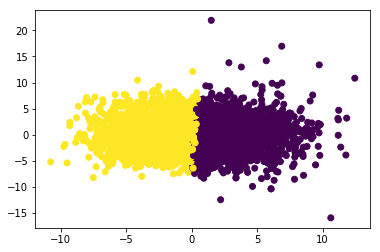

done k:= 3 
PCA:


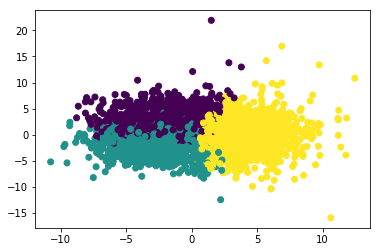

done k:= 4 
PCA:


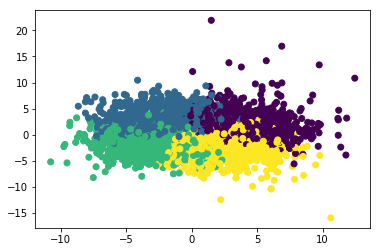

done k:= 5 
PCA:


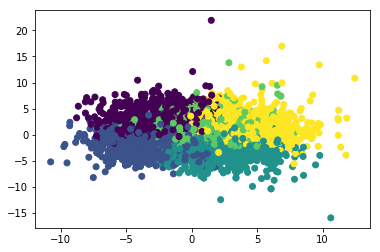

done k:= 6 
PCA:


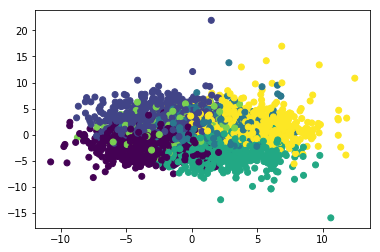

done k:= 7 
PCA:


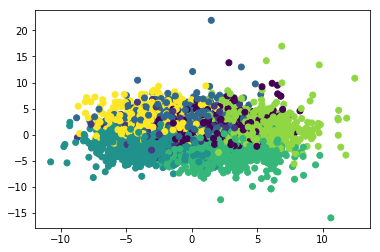

done k:= 8 
PCA:


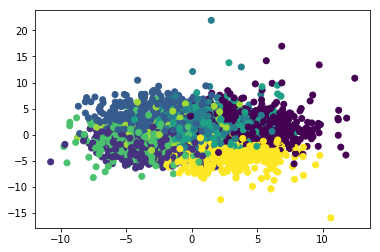

done k:= 9 
PCA:


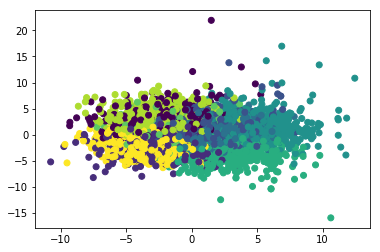

In [58]:
dict_k_vs_loss = {'k':[], 'loss':[]}
predictions_avg_word2vec = []

for k in range(2,10):
    kmeans = KMeans(n_clusters=k, n_jobs=16)
    predictions_avg_word2vec.append(kmeans.fit_predict(X_avg_word2vec_std))
    dict_k_vs_loss['k'].append(k)
    dict_k_vs_loss['loss'].append(kmeans.inertia_)
    print('done k:= {} '.format(k))
    print("PCA:")
    plotPCA(X_avg_word2vec_std,predictions_avg_word2vec[k-2])

In [59]:
cluster_distribution(predictions_avg_word2vec)


cluster k=2 :
[2153 2762]

cluster k=3 :
[1397 1772 1746]

cluster k=4 :
[1003 1243 1482 1187]

cluster k=5 :
[1001 1349  973  703  889]

cluster k=6 :
[1213  891  614  890  494  813]

cluster k=7 :
[ 545  465  665 1103  852  681  604]

cluster k=8 :
[639 774 579 660 498 636 423 706]

cluster k=9 :
[411 615 480 654 536 569 415 488 747]


In [60]:
df_k_vs_loss_avg_word2vec = pd.DataFrame(dict_k_vs_loss)

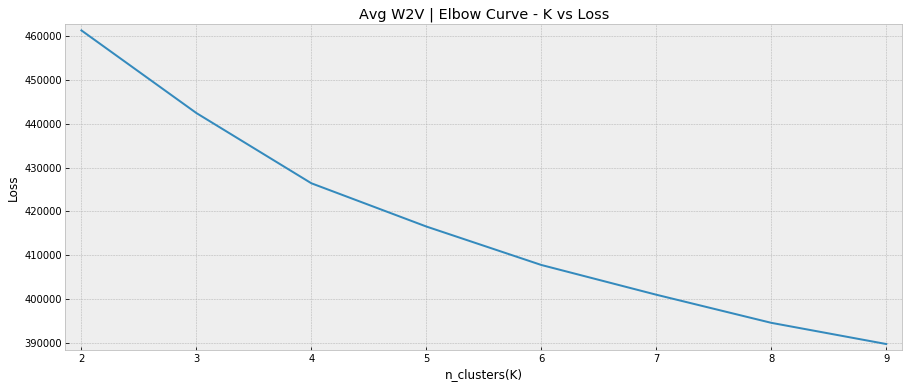

In [139]:
plot_elbow_curve(df_k_vs_loss_avg_word2vec, vector_type='Avg W2V')

In [62]:
#elbowUsingSilhoutte(X_avg_word2vec_std,10)

In [63]:
print(len(predictions_avg_word2vec))
print(len(predictions_avg_word2vec[0]))
print(predictions_avg_word2vec)

8
4915
[array([0, 0, 0, ..., 1, 1, 1]), array([2, 0, 2, ..., 1, 0, 1]), array([3, 3, 0, ..., 2, 1, 2]), array([2, 3, 4, ..., 1, 0, 1]), array([3, 2, 5, ..., 0, 1, 0]), array([4, 4, 5, ..., 3, 2, 3]), array([7, 4, 3, ..., 5, 3, 1]), array([5, 3, 3, ..., 1, 0, 1])]


In [143]:
# Suppose k = 8 is optimum

optimimum_k_avg_word2vec = 4
df_sandisk['labels_avg_word2vec'] = predictions_avg_word2vec[(optimimum_k_avg_word2vec-2)]

In [144]:
df_sandisk.head()

reviewerID        asin  reviewerName helpful  \
1336614  A3SBTW3WS4IQSN  B007WTAJTO           NaN  [0, 0]   
1336615  A18K1ODH1I2MVB  B007WTAJTO          0mie  [0, 0]   
1336616  A2FII3I2MBMUIA  B007WTAJTO           1K3  [0, 0]   
1336617   A3H99DFEG68SR  B007WTAJTO           1m2  [0, 0]   
1336618  A375ZM4U047O79  B007WTAJTO  2&amp;1/2Men  [0, 0]   

                                                reviewText  overall  \
1336614                                         No issues.      4.0   
1336615  Purchased this for my device, it worked as adv...      5.0   
1336616  it works as expected. I should have sprung for...      4.0   
1336617  This think has worked out great.Had a diff. br...      5.0   
1336618  Bought it with Retail Packaging, arrived legit...      5.0   

                                        summary  unixReviewTime   reviewTime  \
1336614                              Four Stars      1406073600  07 23, 2014   
1336615                           MOAR SPACE!!!      1382659200  10 25, 2013   
1336616               nothing to really say....      1356220800  12 23, 2012   
1336617  Great buy at this price!!!  *** UPDATE      1384992000  11 21, 2013   
1336618                        best deal around      1373673600  07 13, 2013   

                                               CleanedText  TotalTechWords  \
1336614                                               issu               0   
1336615  purchas devic work advertis never much phone m...               1   
1336616  work expect sprung higher capac think made bit...               1   
1336617  think work great diff bran gb card went south ...               4   
1336618  bought retail packag arriv legit orang envelop...               3   

         labels_avg_word2vec  tech_words_tfidf  labels_tfidf_word2vec  
1336614                    3          0.000000                      0  
1336615                    3          0.342686                      1  
1336616                    0          0.423427                      0  
1336617                    3          1.160230                      0  
1336618                    0          0.560559                      0

In [145]:
df_sandisk['labels_avg_word2vec'].value_counts()

2    1482
1    1243
3    1187
0    1003
Name: labels_avg_word2vec, dtype: int64

In [146]:

def plot_elbow_curves(df_loss, vector_type):
    """
    Plot the k(n_clusters) vs loss.
    The definition of the loss function can be found in the image above.
    This loss is provided by KMeans in sklearn through an attribute called "inertia_"
    """
    plt.figure(figsize=(15,6))
    plt.style.use('bmh')
    plt.plot(data=df_loss, x='k',y='loss')
    #plt.margins(1)
    plt.xlabel('n_clusters(K)')
    plt.ylabel('Loss')
    plt.title('{} | Elbow Curve - K vs Loss'.format(vector_type))
    plt.yscale('linear')

In [147]:
for i in range(optimimum_k_avg_word2vec):
    sumTotal = sum(df_sandisk.loc[df_sandisk['labels_avg_word2vec'] == i, "TotalTechWords"])
    clusterRows = df_sandisk.loc[df_sandisk['labels_avg_word2vec'] == i,'labels_avg_word2vec'].count()
    print(i , ':  ', sumTotal )
    print(i , ':  ', sumTotal / clusterRows)

0 :   2171
0 :   2.164506480558325
1 :   3189
1 :   2.5655671761866454
2 :   10965
2 :   7.398785425101215
3 :   4146
3 :   3.4928390901432183


In [148]:
print('Results using avg relevant word count for Avg W2V: ')
for i in range(optimimum_k_avg_word2vec):
    sumTotal = sum(df_sandisk.loc[df_sandisk['labels_avg_word2vec'] == i, "TotalTechWords"])
    clusterRows = df_sandisk.loc[df_sandisk['labels_avg_word2vec'] == i,'labels_avg_word2vec'].count()
    print('Total relevant word count in reviews in cluster ',i , ':  ', sumTotal )
    print('Avg relevant word count in reviews in cluster ',i , ':  ', sumTotal / clusterRows)

Results using avg relevant word count for Avg W2V: 
Total relevant word count in reviews in cluster  0 :   2171
Avg relevant word count in reviews in cluster  0 :   2.164506480558325
Total relevant word count in reviews in cluster  1 :   3189
Avg relevant word count in reviews in cluster  1 :   2.5655671761866454
Total relevant word count in reviews in cluster  2 :   10965
Avg relevant word count in reviews in cluster  2 :   7.398785425101215
Total relevant word count in reviews in cluster  3 :   4146
Avg relevant word count in reviews in cluster  3 :   3.4928390901432183


### Looks like cluster 2 contains the most intellectual users

In [152]:
pd.options.display.max_rows

60

In [153]:
pd.options.display.max_colwidth

50

In [154]:
pd.set_option('display.max_colwidth', -1)

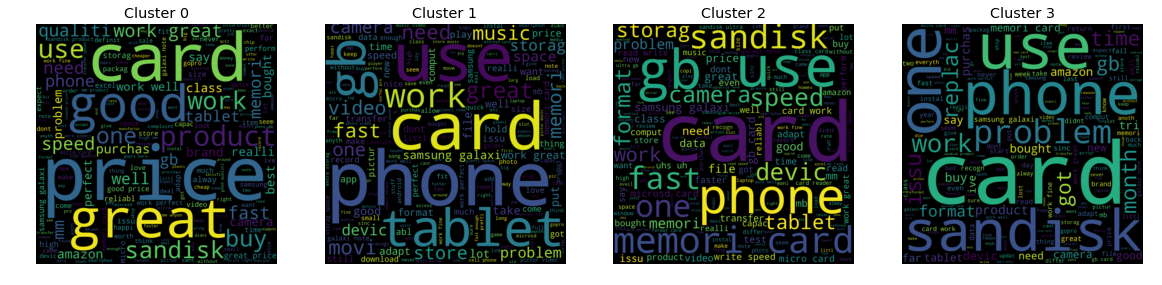

<Figure size 432x288 with 0 Axes>

In [149]:
_ = plot_wordcloud(predictions_avg_word2vec[(optimimum_k_avg_word2vec-2)], df_sandisk, n=1000)

In [155]:
#BEST CLUSTER
df_sandisk.loc[df_sandisk['labels_avg_word2vec'] == 2,'CleanedText']

1336622    work htc rezound run short space gb sandisk order came fast issu                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [156]:
df_sandisk.loc[df_sandisk['labels_avg_word2vec'] == 0,'CleanedText']

1336616    work expect sprung higher capac think made bit cheesier earlier paint look clean                                                                                                             
1336618    bought retail packag arriv legit orang envelop english version asian like pictur show arriv quick bought retail packag htc one optimus card work order probabl best price youll get nice card
1336636    sandisk never disappoint alway sandisk product worth everi penni nice product qualiti work great mm product everyon                                                                          
1336637    good price work flawless samsung normal sandisk qualiti brand brand                                                                                                                          
1336638    san disk hard beat pay brand get qualiti product would purchas                                                                                                                           

In [157]:
df_sandisk.loc[df_sandisk['labels_avg_word2vec'] == 1,'CleanedText']

1336619    mini storag doesnt anyth els suppos purchas add addit storag microsoft surfac pro tablet come gb suppos sandisk long stand reput speak                                                                                                                                                                                                                                                                                                                                                                                                                  
1336621    hard believ afford digit becom gb devic one quarter sie postag stamp would scienc fiction less generat ago pick portabl music didnt want schlep risk phone ipod work great card reader select confid                                                                                                                                                                                                                                                     

In [91]:
X_test = []
kmeans.predict(X_avg_word2vec_std)

array([6, 3, 1, ..., 8, 1, 0])

### 7 clusters have the highest score

In [92]:
#df_k_vs_loss= pd.DataFrame(dict_k_vs_loss)

In [93]:
#plot_elbow_curve(df_k_vs_loss, vector_type='W2V')

In [94]:
# kmeans.cluster_centers_

## TF_IDF Word2Vec

In [ ]:
"""# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(df['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))"""

In [132]:
#saving TFIDFwordtoVec
"""with open('model_tfidf_w2v.pickle', 'wb') as f:
    pickle.dump(tf_idf_matrix, f)
    
with open('dict_tfidf_w2v.pickle', 'wb') as f:
    pickle.dump(dictionary, f)"""


In [71]:
#Retrieving TFIDFwordtoVec
#sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
with open('model_tfidf_w2v.pickle', 'rb') as f:
    tf_idf_matrix = pickle.load(f)
    
with open('dict_tfidf_w2v.pickle', 'rb') as f:
    dictionary = pickle.load(f)    
    
    
print(tf_idf_matrix)

  (0, 113446)	0.06543552031348972
  (0, 113724)	0.10689880576827723
  (0, 127587)	0.12668164648261895
  (0, 192819)	0.24208995932893568
  (0, 232445)	0.11680767979741104
  (0, 287042)	0.4132653563965022
  (0, 130599)	0.18564924993916707
  (0, 244382)	0.08983078187754093
  (0, 280517)	0.05431039996608468
  (0, 16932)	0.09589792376307019
  (0, 66974)	0.07247334056590914
  (0, 82486)	0.12470219166269692
  (0, 92384)	0.07438158088868267
  (0, 310764)	0.19909323374937687
  (0, 305771)	0.0843195060549834
  (0, 295865)	0.07528049804342238
  (0, 126397)	0.07485309713871229
  (0, 259940)	0.07973325244511463
  (0, 105520)	0.26163287050781087
  (0, 61992)	0.06581704831243064
  (0, 111594)	0.1382624562098832
  (0, 292405)	0.14840699803811622
  (0, 312209)	0.11824112138144985
  (0, 114574)	0.09107016048896265
  (0, 183105)	0.09779320399230933
  :	:
  (1689187, 74598)	0.08526490056208678
  (1689187, 113985)	0.07647590536461535
  (1689187, 105625)	0.06514649247917531
  (1689187, 175436)	0.09010331426

In [73]:
# TF-IDF weighted Word2Vec
#tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
tfidf_tech_words = [];
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_sd): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    tech_tfidf = 0;
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            if word in unigramTechSet:
                tech_tfidf += tf_idf
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    tfidf_tech_words.append(tech_tfidf)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 4915/4915 [00:03<00:00, 1264.92it/s]


In [74]:
#saving TFIDFwordtoVec
"""with open('tfidf_tech_words.pickle', 'wb') as f:
    pickle.dump(tfidf_tech_words, f)"""
    

"with open('tfidf_tech_words.pickle', 'wb') as f:\n    pickle.dump(tfidf_tech_words, f)"

In [75]:
#Retrieving TFIDFwordtoVec
tfidf_tech_words = []; 
with open('tfidf_tech_words.pickle', 'rb') as f:
    tfidf_tech_words = pickle.load(f)
    
print(tfidf_tech_words)

[0, 0.34268643607837024, 0.42342695217535126, 1.1602295620274201, 0.5605591595030217, 1.3391599414011919, 1.1326338230752073, 0.3793152192791688, 0.8366700161098228, 0.2829250587819388, 2.7968245607458018, 3.9149060777500644, 1.9671091423493579, 2.345594545731338, 1.1429397115391513, 1.2029546993958438, 0.5324441270853791, 10.754233364467769, 2.0598757808129498, 0.7029221496369682, 0.7361914585674285, 0.54100568967862, 1.5373584023121718, 3.0208939176913967, 0.3851037368788921, 1.1885079567597556, 1.2147827276998429, 0.544057867416538, 1.174454109815446, 1.4590166385516798, 0.21782698769841058, 1.410988933051479, 1.2391027283360638, 0.9277370758972217, 0.4488346364742749, 2.0282489301666153, 0, 3.085608185341691, 4.039318212012803, 0.3258570081282933, 1.3553506256833157, 0.9615719629432916, 0.7456626635754453, 0.8600872507327292, 0.7625700852094578, 0.29945257331140407, 0.97883360655426, 0.6027039465343355, 0.5195014019047481, 0.13135806300590014, 0.55305850216376, 2.351264320166642, 1

In [76]:
df_sandisk['tech_words_tfidf'] = tfidf_tech_words;

In [77]:
#saving TFIDFwordtoVec
with open('sent_vectors_tfidf.pickle', 'wb') as f:
    pickle.dump(tfidf_sent_vectors, f)

In [78]:
#Retrieving TFIDFwordtoVec
#sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
with open('sent_vectors_tfidf.pickle', 'rb') as f:
    tfidf_sent_vectors = pickle.load(f)
    
print(tfidf_sent_vectors)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [79]:
print(len(tfidf_sent_vectors))
print(tfidf_sent_vectors[0])

4915
[ 0.62683418  2.8935956  -0.16636419 -0.77061227 -0.01096752  3.63719129
 -0.557293    1.49304676  1.72335172 -0.98403474  1.11930396 -0.54566187
  1.16893012 -1.42431794 -2.08388566 -0.53042936  1.05230109 -1.25121996
 -2.87727602  2.67584157  1.05996706  0.23263424  3.16750422 -1.6129551
  1.83319707 -0.26969912  1.18622906  0.5105402  -0.65293932  0.23602156
  1.67294612  1.55587088 -1.14006271  3.74987663  4.79241613  2.23710471
  2.31435197  0.69903348 -1.68827876  2.9819399  -1.07257056 -2.60570475
 -0.60529993 -2.68604689  5.00544861 -1.56939525  1.66467955  1.26796474
 -1.68828744 -1.35394069  2.84894534  4.75848126  1.54927961 -1.97853438
  0.9904298   2.00607997 -1.1921361  -0.91718184 -0.23484221 -1.84866763
  3.1976214  -1.98110045  0.33365246  1.65715177  1.0394646  -0.46013244
 -0.57109328 -0.62450592 -0.84296499  4.18349375  0.71365777  3.75276043
 -1.64399831  1.37060169  2.03018264  0.76618792  3.22901692  1.23975737
 -0.35114434  1.70904005 -1.82822985 -1.5413933

In [80]:
X_tfidf_word2vec = np.append(np.asarray(tfidf_sent_vectors),np.asarray(df_sandisk['tech_words_tfidf'])[:, None], 1)
X_tfidf_word2vec

array([[ 0.62683418,  2.8935956 , -0.16636419, ..., -1.93059951,
        -1.25731314,  0.        ],
       [-0.16084341, -0.67639046,  0.01009075, ..., -0.07430024,
        -0.02876555,  0.34268644],
       [ 0.1104335 , -0.13954827, -0.66062016, ..., -0.09510396,
         0.88494481,  0.42342695],
       ...,
       [ 0.20935766, -0.32957937,  0.2387222 , ...,  0.36746824,
         0.12172611,  1.79288795],
       [ 0.81907947, -1.15758589, -0.28846289, ..., -0.0316126 ,
         0.16781348,  0.        ],
       [ 0.45923097, -0.55037975,  1.25722368, ...,  0.30145033,
         0.25670129,  1.15298221]])

In [81]:
scaler_tfidf_word2vec = StandardScaler(with_mean=False)
X_tfidf_word2vec_std = scaler_tfidf_word2vec.fit_transform(X_tfidf_word2vec)

done k:= 2 
PCA:


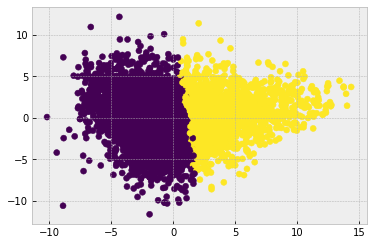

done k:= 3 
PCA:


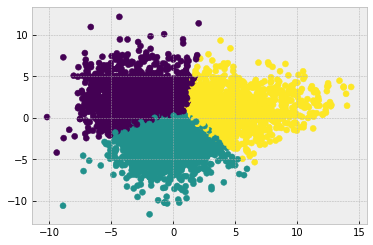

done k:= 4 
PCA:


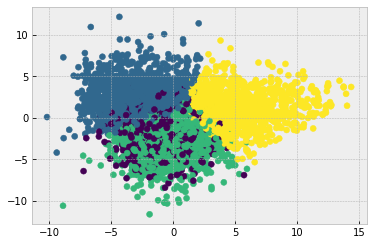

done k:= 5 
PCA:


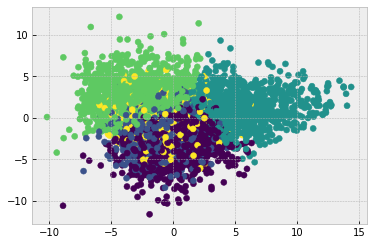

done k:= 6 
PCA:


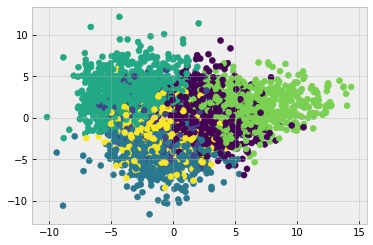

done k:= 7 
PCA:


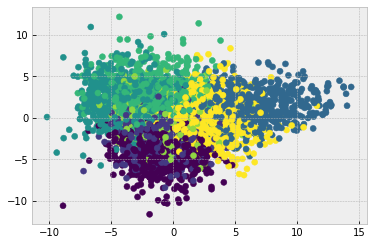

done k:= 8 
PCA:


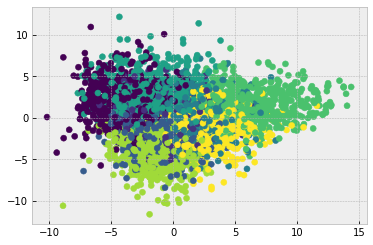

done k:= 9 
PCA:


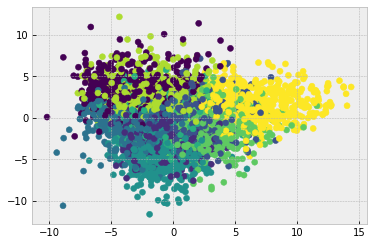

In [82]:
dict_k_vs_loss_tf = {'k':[], 'loss':[]}
predictions_tfidf_word2vec = []
clusters_models = []
for k in range(2,10):
    kmeans = KMeans(n_clusters=k, n_jobs=16)
    clusters_models.append(kmeans)
    predictions_tfidf_word2vec.append(kmeans.fit_predict(X_tfidf_word2vec_std))
    dict_k_vs_loss_tf['k'].append(k)
    dict_k_vs_loss_tf['loss'].append(kmeans.inertia_)
    print('done k:= {} '.format(k))
    print("PCA:")
    plotPCA(X_tfidf_word2vec_std,predictions_tfidf_word2vec[k-2])

In [83]:
cluster_distribution(predictions_tfidf_word2vec)


cluster k=2 :
[3293 1622]

cluster k=3 :
[1874 1819 1222]

cluster k=4 :
[ 856 1552 1424 1083]

cluster k=5 :
[1318  778  948 1430  441]

cluster k=6 :
[1020  434  844 1287  603  727]

cluster k=7 :
[786 605 565 853 769 425 912]

cluster k=8 :
[817 364 550 521 766 535 720 642]

cluster k=9 :
[544 505 498 742 494 345 618 635 534]


In [84]:
df_k_vs_loss_tfidf_word2vec = pd.DataFrame(dict_k_vs_loss_tf)

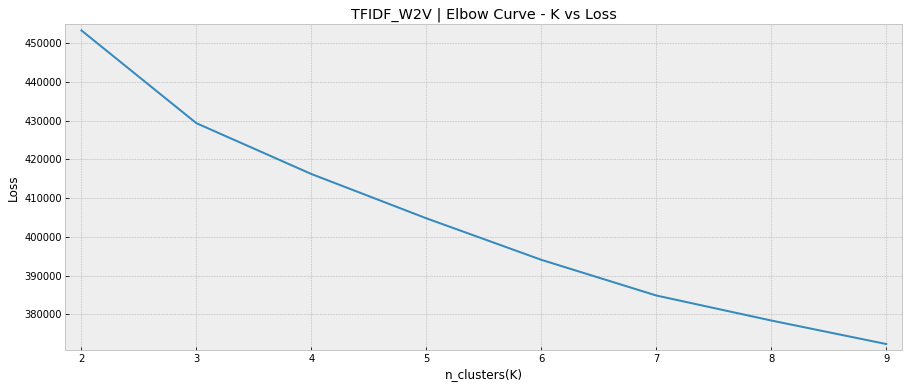

In [85]:
plot_elbow_curve(df_k_vs_loss_tfidf_word2vec, vector_type='TFIDF_W2V')

In [161]:
optimimum_k_tfidf_word2vec = 3
df_sandisk['labels_tfidf_word2vec'] = predictions_tfidf_word2vec[(optimimum_k_tfidf_word2vec-2)]

In [162]:
df_sandisk.head()

reviewerID        asin  reviewerName helpful  \
1336614  A3SBTW3WS4IQSN  B007WTAJTO  NaN           [0, 0]   
1336615  A18K1ODH1I2MVB  B007WTAJTO  0mie          [0, 0]   
1336616  A2FII3I2MBMUIA  B007WTAJTO  1K3           [0, 0]   
1336617  A3H99DFEG68SR   B007WTAJTO  1m2           [0, 0]   
1336618  A375ZM4U047O79  B007WTAJTO  2&amp;1/2Men  [0, 0]   

                                                                                                                                                                                                                                                                                                                                                   reviewText  \
1336614  No issues.                                                                                                                                                                                                                                                                                                                                             
1336615  Purchased this for my device, it worked as advertised. You can never have too much phone memory, since I download a lot of stuff this was a no brainer for me.                                                                                                                                                                                         
1336616  it works as expected. I should have sprung for the higher capacity.  I think its made a bit cheesier than the earlier versions; the paint looks not as clean as before                                                                                                                                                                                 
1336617  This think has worked out great.Had a diff. bran 64gb card and if went south after 3 months.This one has held up pretty well since I had my S3, now on my Note3.*** update 3/21/14I've had this for a few months and have had ZERO issue's since it was transferred from my S3 to my Note3 and into a note2. This card is reliable and solid!Cheers!   
1336618  Bought it with Retail Packaging, arrived legit, in a orange envelope, english version not asian like the picture shows. arrived quickly, bought a 32 and 16 both retail packaging for my htc one sv and Lg Optimus, both cards in working order, probably best price you'll get for a nice sd card                                                     

         overall                                 summary  unixReviewTime  \
1336614  4.0      Four Stars                              1406073600       
1336615  5.0      MOAR SPACE!!!                           1382659200       
1336616  4.0      nothing to really say....               1356220800       
1336617  5.0      Great buy at this price!!!  *** UPDATE  1384992000       
1336618  5.0      best deal around                        1373673600       

          reviewTime  \
1336614  07 23, 2014   
1336615  10 25, 2013   
1336616  12 23, 2012   
1336617  11 21, 2013   
1336618  07 13, 2013   

                                                                                                                                                                                           CleanedText  \
1336614  issu                                                                                                                                                                                            
1336615  purchas devic work advertis never much phone memori sinc download lot stuff brainer                                                                                                             
1336616  work expect sprung higher capac think made bit cheesier earlier paint look clean                                                                                                                
1336617  think work great diff bran gb card went south month one held pretti well sinc updat month zero issu sinc tra

In [164]:
print('Results using avg relevant word count for TF-IDF W2V: ')
for i in range(optimimum_k_tfidf_word2vec):
    sumTotal = sum(df_sandisk.loc[df_sandisk['labels_tfidf_word2vec'] == i, "TotalTechWords"])
    clusterRows = df_sandisk.loc[df_sandisk['labels_tfidf_word2vec'] == i,'labels_tfidf_word2vec'].count()
    print('Total relevant word count in reviews in cluster ',i , ':  ', sumTotal )
    print('Avg relevant word count in reviews in cluster ',i , ':  ', sumTotal / clusterRows)

Results using avg relevant word count for TF-IDF W2V: 
Total relevant word count in reviews in cluster  0 :   4513
Avg relevant word count in reviews in cluster  0 :   2.4082177161152614
Total relevant word count in reviews in cluster  1 :   5134
Avg relevant word count in reviews in cluster  1 :   2.822429906542056
Total relevant word count in reviews in cluster  2 :   10824
Avg relevant word count in reviews in cluster  2 :   8.857610474631752


In [88]:
df_sandisk['labels_tfidf_word2vec'].value_counts()

0    1874
1    1819
2    1222
Name: labels_tfidf_word2vec, dtype: int64

In [136]:
print('Results using avg relevant word count for Avg W2V: ')
for i in range(optimimum_k_tfidf_word2vec):
    sumTotal = sum(df_sandisk.loc[df_sandisk['labels_tfidf_word2vec'] == i, "tech_words_tfidf"])
    clusterRows = df_sandisk.loc[df_sandisk['labels_tfidf_word2vec'] == i,'labels_tfidf_word2vec'].count()
    print('Cummulative TF-IDF of reviews in cluster ' ,i , ':  ', sumTotal )
    print('Avg Cummulative TF-IDF of reviews in cluster ' ,i , ':  ', sumTotal / clusterRows)

Cummulative TF-IDF of reviews in cluster  0 :   1304.4987290736003
Avg Cummulative TF-IDF of reviews in cluster  0 :   0.6961039109250802
Cummulative TF-IDF of reviews in cluster  1 :   1548.7673966783148
Avg Cummulative TF-IDF of reviews in cluster  1 :   0.8514389206587767
Cummulative TF-IDF of reviews in cluster  2 :   3368.9542841171065
Avg Cummulative TF-IDF of reviews in cluster  2 :   2.7569183994411675


In [91]:
#_2 = plot_wordcloud(predictions_tfidf_word2vec[(2)], df_sandisk, n=1000)

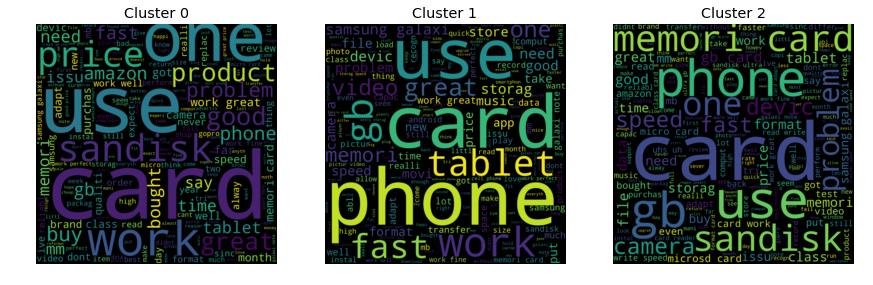

<Figure size 432x288 with 0 Axes>

In [165]:
_ = plot_wordcloud(predictions_tfidf_word2vec[(optimimum_k_tfidf_word2vec-2)], df_sandisk, n=1000)

In [158]:
df_sandisk.loc[df_sandisk['labels_tfidf_word2vec'] == 2,'CleanedText']

1336624    like card take music video download person video file doc multimedia imag fast transfer rate class speed take game larg file easili still enough space app great video camera camcord suppli adapt fit easili smartphon tablet card slot mm gb card everyon                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [159]:
df_sandisk.loc[df_sandisk['labels_tfidf_word2vec'] == 1,'CleanedText']

1336615    purchas devic work advertis never much phone memori sinc download lot stuff brainer                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
1336619    mini storag doesnt anyth els suppos purchas add addit storag microsoft surfac pro tablet come gb suppos sandisk long stand reput speak                                                                                                                                                             

# Demo REview

In [182]:
demoReview1 = "My sd card is 16 gb with fast read write speed class about 20 mm"
demoReview2 = "great product"
demoReview3 = "great for my phone "

demoReviews = []
demoReviews.append(demoReview1)
demoReviews.append(demoReview2)
demoReviews.append(demoReview3)
demoReviews.append("the sd card is not so great as it is really slow")
demoReviews.append("the sd is not so great as it is really slow")
demoReviews.append("the card is not so great as it is really slow")


In [183]:
#process input to get right form
tfidf_sum_arr = []
count_tech_all = []
filtered_sentence=[]

for review in demoReviews:
    filtered_sent = []
    count_tech = 0
    tfidf_sum = 0
    for w in review.split():
        w = w.lower()
        for i in bypass:
            if w.find(i) == -1:
                continue
            else:
                w= i
            filtered_sent.append(w)

        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        c = cleaned_words.lower()
                        s=(sno.stem(c))
                        filtered_sent.append(s)
                        if(s in unigramTechSet):
                            count_tech = count_tech + 1;                    
                        if s in dictionary:
                            tfidf_sum += dictionary[word]*(sent.count(word)/len(sent))
                    else:
                        continue
            else:
                    continue
    filtered_sentence.append(filtered_sent)
    tfidf_sum_arr.append(tfidf_sum)
    count_tech_all.append(count_tech)
print(filtered_sentence)

[['card', 'gb', 'fast', 'read', 'write', 'speed', 'class', 'mm'], ['great', 'product'], ['great', 'phone'], ['card', 'great', 'realli', 'slow'], ['great', 'realli', 'slow'], ['card', 'great', 'realli', 'slow']]


In [184]:
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
tfidf_sent_vectors_demo = []; # the tfidf-w2v for each sentence/review is stored in this list


row=0;

for sent in tqdm(filtered_sentence):
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    tech_tfidf = 0;
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_demo.append(sent_vec)
    row += 1
#print(tfidf_sent_vectors_demo)

100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 3018.21it/s]


In [185]:
X_test_tfidf_word2vec = np.append(np.asarray(tfidf_sent_vectors_demo),np.asarray(tfidf_sum_arr)[:,None], 1)
#X_test_tfidf_word2vec

In [186]:
#scaler_tfidf_word2vec = StandardScaler(with_mean=False)
tfidf_sent_vectors_demo_std = scaler_tfidf_word2vec.transform(X_test_tfidf_word2vec)

In [187]:
best_k = 3
best_cluster_model = clusters_models[best_k - 2]
#predictions_tfidf_word2vec
labels_predicted_demo = best_cluster_model.predict(X_test_tfidf_word2vec)
itr=0
for review in demoReviews:
    print(review, "| cluster", labels_predicted_demo[itr])
    itr +=1

My sd card is 16 gb with fast read write speed class about 20 mm | cluster 2
great product | cluster 0
great for my phone  | cluster 1
the sd card is not so great as it is really slow | cluster 2
the sd is not so great as it is really slow | cluster 1
the card is not so great as it is really slow | cluster 2
